In [560]:
# def ffill(arr):
#     mask = np.isnan(arr)
#     idx = np.where(~mask,np.arange(mask.shape[0]),0)
#     np.maximum.accumulate(idx,axis=0, out=idx)
#     out = arr[idx]#[np.arange(idx.shape[0])[:,None], idx]
#     return out

# def bfill(arr):
#     return ffill(arr[::-1])[::-1]

# def fill(arr):
#     return ffill(bfill(arr))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pyFAI.detectors as dets
import pyFAI

from pathlib import Path

import glob

from importlib import reload
from dataproc.operations import hitp

from xrdc import source_separation as sep
from xrdc import peak_fitting as pf

plt.rcParams["figure.figsize"]=(10, 8)

workflows/alanConfig


In [ ]:
reload(hitp)

In [3]:
def get_boundaries(patterns):
    x = np.arange(len(patterns[0])) + 1
    y = patterns[0]
    
    boundaries = hitp.bayesian_block_finder(x, y)
    return boundaries

In [4]:
df = pd.read_csv("YijinXRD.dat", sep = '\t')
qq = df.iloc[:, 0]

patterns = df.iloc[:, 2:]
patterns = patterns.values.T
for i in range(len(patterns)):
    patterns[i] = patterns[i] - i * 1000
    
boundaries = get_boundaries(patterns)

numBlocks: 352, dataPts/Block: 1.6988636363636365


Text(0, 0.5, 'Intensity (arb.)')

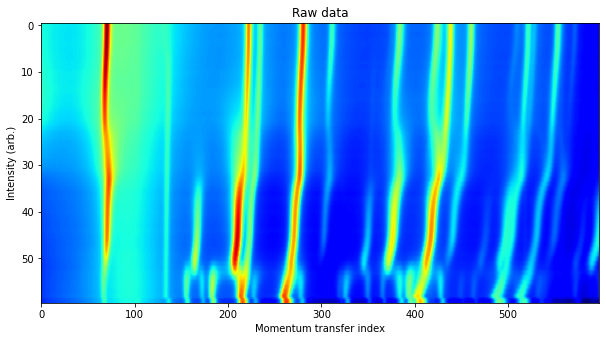

In [5]:
plt.imshow(np.log(1 + patterns), cmap = 'jet', aspect = 5)
plt.title('Raw data')
plt.xlabel('Momentum transfer index')
plt.ylabel('Intensity (arb.)')

In [414]:
%matplotlib inline

Text(0, 0.5, 'Intensity (arb.)')

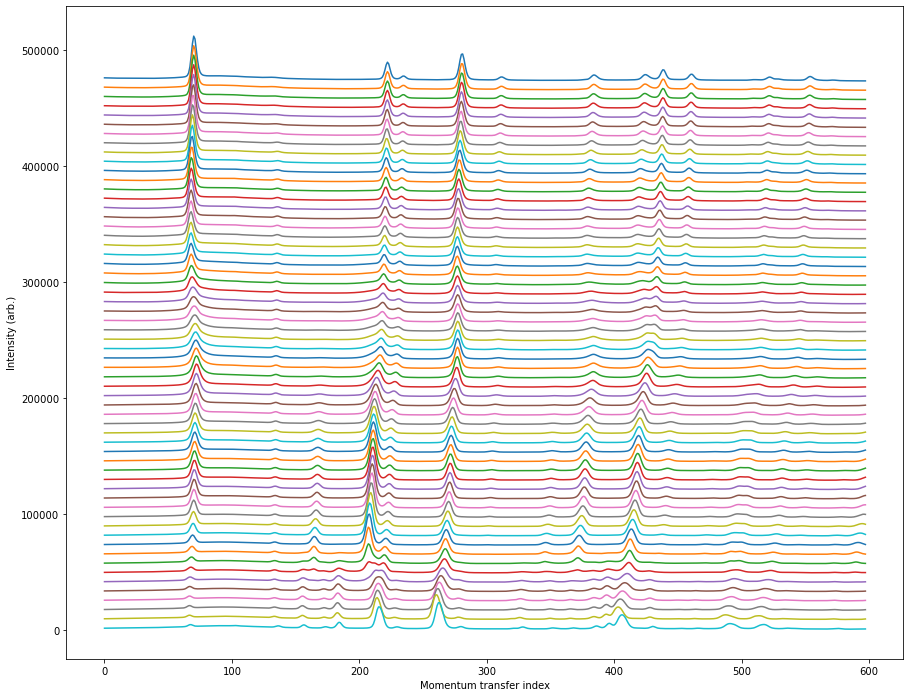

In [430]:
plt.rcParams["figure.figsize"]=(15, 12)
for i in range(len(patterns)):
    plt.plot(patterns[i] + (len(patterns) - i - 1) * 8000)
plt.xlabel('Momentum transfer index')
plt.ylabel('Intensity (arb.)')
#plt.grid()

In [6]:
import pdb

In [7]:
import time
import json
from pathlib import Path
import re
import pyFAI.detectors as dets
import numpy as np


from dataproc.operations.utils import single_select, folder_select
from scipy.ndimage.filters import gaussian_filter as gf

template = ''
configPath = "workflows/alanConfig"

# Configuration setup
# Grab configs
print(configPath)
with open(configPath) as jp:
    cfg = json.load(jp)
cfg['fitInfo']['blockBounds'] = boundaries


def workflow(y, boundaries, downsample_int = 10, noise_estimate = None, background = None,
             **kwargs):
    """
    kwargs are passed to hitp.fit_peak
    """

    # Fill out experimental information
    expInfo = {}


    expInfo['blockBounds'] = cfg['fitInfo']['blockBounds']

    print('Experimental Info used: \n')
    print(expInfo)

    # Pull out Fit info
    fitInfo = cfg['fitInfo']

    # Start processing loop =======================================================
    run_enable = True
    
    # restrict range?
    subx, suby = np.arange(len(y)) + 1, y
    #pdb.set_trace()
    
    if background is None:
        # Background subtract/move to zero
        suby = suby - np.min(suby)
        subx, suby = hitp.bkgd_sub(subx, suby, downsample_int)
    else:
        suby = y - background
        if suby.min() < 0:
            print('negative values in background-subtracted pattern. taking absolute value.')
            suby = suby - suby.min()

    # segment rangeinto two...
    xList = []
    yList = []
    noiseList = []
    paramsList = []
    bnds = expInfo['blockBounds']
    for leftBnd in range(len(bnds) - 1): # indexes
        selector = np.where((subx >= bnds[leftBnd]) & (subx < bnds[leftBnd + 1]))
        xList.append(subx[selector])
        yList.append(suby[selector])
        if noise_estimate is not None:
            noiseList.append(noise_estimate[selector] + 1e-9) 
        else:
            noiseList.append(None)
    for i, (xbit, ybit, noisebit) in enumerate(zip(xList, yList, noiseList)):
        # Restrict range and fit peaks
        curveParams, derivedParams = hitp.fit_peak(xbit, ybit,
                            peakShape=fitInfo['peakShape'],
                            fitMode=fitInfo['fitMode'],
                            numCurves=fitInfo['numCurves'],
                            noise_estimate = noisebit,
                                             **kwargs)
        print(f'    ----Saving data for block between {np.min(xbit):.2f} - {np.max(xbit):.2f}')
        # output/saving of blocks
        hitp.save_dict(curveParams, cfg['exportPath'], template + f'_block{i}_curve')
        hitp.save_dict(derivedParams, cfg['exportPath'], template + f'_block{i}_derived')
        hitp.save_curve_fit(xbit, ybit, curveParams, cfg['exportPath'], 
                        template + f'_block{i}', peakShape=fitInfo['peakShape'])
        paramsList.append(derivedParams)
    return suby, paramsList


workflows/alanConfig


In [15]:
i = 33

y3 = fit_curves(patterns[i])

numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0.  79. 124. 150. 178. 190. 215. 250. 295. 315. 354. 386. 428. 460.
 481. 495. 509. 534. 558. 578. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  79., 124., 150., 178., 190., 215., 250., 295., 315., 354.,
       386., 428., 460., 481., 495., 509., 534., 558., 578., 597.])}
Peak at 70, start iteration with error = 0.6967618746170375
Peak at 70, iteration 0: error = 0.3112924796404795
Peak at 70, iteration 1: error = 0.05352889846870834
Peak at 70, iteration 2: error = 0.05061529640836045
    ----Saving data for block between 1.00 - 78.00
Peak at 81, start iteration with error = 0.2687681791448506
Peak at 81, iteration 0: error = 0.7266628965444057
Peak at 81, iteration 1: error = 0.009561001698481692
Peak at 81, iteration 2: error = 0.0069264497933581
    ----Saving data for block between 79.00 - 123.00
Peak at 134, start iteration with error = 0.2933373609291151
Peak at 134, iteration 0: error = 0.688458434515989
Peak 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 481.00 - 494.00
Peak at 499, start iteration with error = 0.425517386893646
Peak at 499, iteration 0: error = 0.5699762268002508
Peak at 499, iteration 1: error = 0.01503499425180893
Peak at 499, iteration 2: error = 0.011721380254876675


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 495.00 - 508.00
Peak at 526, start iteration with error = 0.2752900918386989
Peak at 526, iteration 0: error = 0.7205723345003803
Peak at 526, iteration 1: error = 0.02647386410167709
Peak at 526, iteration 2: error = 0.015908219288365274
    ----Saving data for block between 509.00 - 533.00
Peak at 534, start iteration with error = 0.25983185089042976
Peak at 534, iteration 0: error = 0.7278541945281239
Peak at 534, iteration 1: error = 0.010698931187932803
Peak at 534, iteration 2: error = 0.007962399080997837
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 534.00 - 557.00
Peak at 573, start iteration with error = 0.21659962203842426
Peak at 573, iteration 0: error = 0.7746776422571334
Peak at 573, iteration 1: error = 0.03009621956332542
Peak at 573, iteration 2: error = 0.023018622679099522
    ----Saving data for block between 558.00 - 577.00
Peak at 591, start iterati

In [5]:
plt.rcParams["figure.figsize"]=(10, 8)

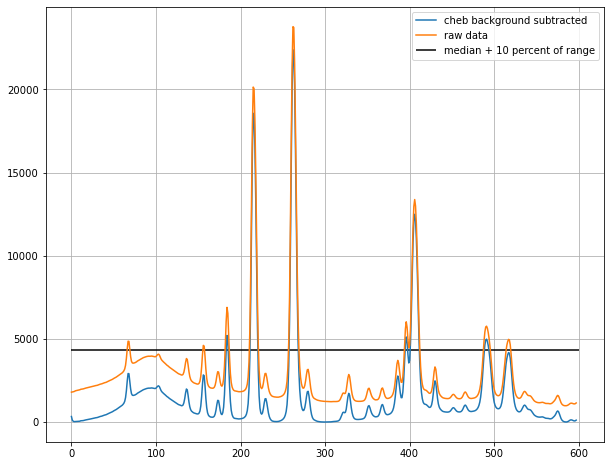

In [33]:
plt.plot(y3, label = 'cheb background subtracted')
plt.plot(patterns[i], label  = 'raw data')
plt.hlines(np.percentile(patterns[i], 50) + 0.1 * (patterns[i].max() - patterns[i].min()), 0, 600, 'k',
           label = 'median + 10 percent of range')
plt.legend()
plt.grid()

In [45]:
y3 = fit_curves(patterns[i], downsample_int = 50)

numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 151., 189., 224., 255., 298., 339., 365., 405., 438.,
       477., 524., 551., 583., 597.])}
Peak at 73, start iteration with error = 0.8131252195519438
Peak at 73, iteration 0: error = 3.2724629672571846
Peak at 73, iteration 1: error = 0.2706696171606327
Peak at 73, iteration 2: error = 0.270669617426323
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.7212719280967178
Peak at 135, iteration 0: error = 0.2023706877655001
Peak at 135, iteration 1: error = 0.09187521663104968
Peak at 135, iteration 2: error = 0.12481627024941336
    ----Saving data for block between 128.00 - 150.00
Peak at 170, start iteration with error = 0.7273658383882524
Peak at 170, iteration 0: error = 0.20370045286649968
Peak at 170, iteration 1: error = 0.1331344753787456
Pe

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 583.00 - 596.00


In [46]:
y4 = fit_curves(patterns[i], downsample_int = 50)

numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 151., 189., 224., 255., 298., 339., 365., 405., 438.,
       477., 524., 551., 583., 597.])}
Peak at 73, start iteration with error = 0.9336557257800359
Peak at 73, iteration 0: error = 5.1461082672077305
Peak at 73, iteration 1: error = 0.6439893688207164
Peak at 73, iteration 2: error = 0.6439894510871301
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.33941583285295485
Peak at 135, iteration 0: error = 0.6495668416283141
Peak at 135, iteration 1: error = 0.026552964605618363
Peak at 135, iteration 2: error = 0.02400662258377597
    ----Saving data for block between 128.00 - 150.00
Peak at 170, start iteration with error = 0.21847419815303698
Peak at 170, iteration 0: error = 0.7798414198244922
Peak at 170, iteration 1: error = 0.0094484686939404

In [50]:
pwd

'/Users/ollie/Documents/SLAC/xrd_clustering/notebooks'

In [49]:
cfg['exportPath']

'fitoutput/'

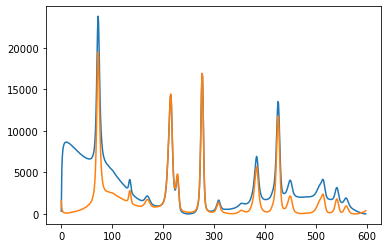

In [37]:
plt.plot(y3)
plt.plot(y4)

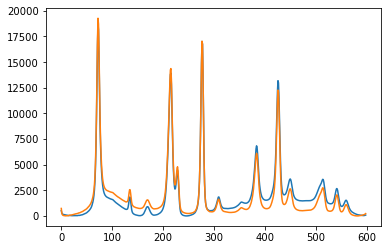

In [47]:
plt.plot(y3)
plt.plot(y4)

In [42]:
len(x)

598

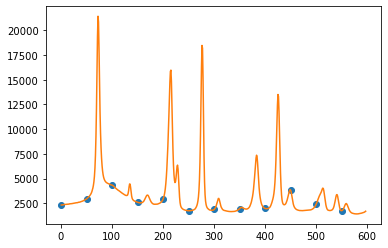

In [44]:
ds = 50
plt.plot(x[::ds], patterns[i][::ds], 'o')
plt.plot(x, patterns[i])

In [29]:
%matplotlib inline

In [21]:
bgsubbed = np.vstack([fit_curves(y) for y in patterns])

numBlocks: 358, dataPts/Block: 1.670391061452514
[  0.  35. 127. 183. 230. 263. 297. 342. 408. 430. 448. 501. 512. 539.
 567. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  35., 127., 183., 230., 263., 297., 342., 408., 430., 448.,
       501., 512., 539., 567., 597.])}
Peak at 6, start iteration with error = 0.8744876110049672
Peak at 6, iteration 0: error = 0.3360550172241699
Peak at 6, iteration 1: error = 0.29478581198305304
Peak at 6, iteration 2: error = 0.27326844264947986
    ----Saving data for block between 1.00 - 34.00
Peak at 71, start iteration with error = 0.7904498272201014
Peak at 71, iteration 0: error = 0.7563760960680689
Peak at 71, iteration 1: error = 0.06056021557924004
Peak at 71, iteration 2: error = 0.06056021557597892
    ----Saving data for block between 35.00 - 126.00
Peak at 132, start iteration with error = 0.542922858290663
Peak at 132, iteration 0: error = 0.4393858171528767
Peak at 132, iteration 1: error = 0.046455246948087885
Peak at 13

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 501.00 - 511.00
Peak at 523, start iteration with error = 0.4412642239353948
Peak at 523, iteration 0: error = 0.5264316851004637
Peak at 523, iteration 1: error = 0.06758496536088339
Peak at 523, iteration 2: error = 0.05663312064883592
    ----Saving data for block between 512.00 - 538.00
Peak at 555, start iteration with error = 0.4715860134471545
Peak at 555, iteration 0: error = 0.5185359829695014
Peak at 555, iteration 1: error = 0.05467249404483868
Peak at 555, iteration 2: error = 0.030391000927953195
    ----Saving data for block between 539.00 - 566.00
Peak at 573, start iteration with error = 0.8571907760268471
Peak at 573, iteration 0: error = 0.1389149324233521
Peak at 573, iteration 1: error = 0.2017497474438672
Peak at 573, iteration 2: error = 0.24373936603188262
    ----Saving data for block between 567.00 - 596.00
numBlocks: 358, dataPts/Block: 1.670391061452514
[  0.  35. 127. 186. 230. 263. 297. 356. 408. 430. 448. 501. 511. 539

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 501.00 - 510.00
Peak at 523, start iteration with error = 0.37299116026538787
Peak at 523, iteration 0: error = 0.6090644437262444
Peak at 523, iteration 1: error = 0.06454078764083507
Peak at 523, iteration 2: error = 0.04738570619886323
    ----Saving data for block between 511.00 - 538.00
Peak at 554, start iteration with error = 0.34032842122052304
Peak at 554, iteration 0: error = 0.6528513544472726
Peak at 554, iteration 1: error = 0.04515998774782589
Peak at 554, iteration 2: error = 0.024840625428730376
    ----Saving data for block between 539.00 - 563.00
Peak at 572, start iteration with error = 0.8411134627229001
Peak at 572, iteration 0: error = 0.19586252952153105
Peak at 572, iteration 1: error = 0.18161118903908388
Peak at 572, iteration 2: error = 0.2301307692164994
    ----Saving data for block between 564.00 - 596.00
numBlocks: 364, dataPts/Block: 1.6428571428571428
[  0.  35. 127. 183. 230. 263. 303. 340. 408. 431. 448. 488. 514.

Peak at 461, start iteration with error = 0.34654450868926645
Peak at 461, iteration 0: error = 0.6376743120517538
Peak at 461, iteration 1: error = 0.016189403619223365
Peak at 461, iteration 2: error = 0.01569232763341317
    ----Saving data for block between 448.00 - 487.00
Peak at 510, start iteration with error = 0.12136790986804954
Peak at 510, iteration 0: error = 0.8773026321514783
Peak at 510, iteration 1: error = 0.004907379473262704
Peak at 510, iteration 2: error = 0.0037471702787619156
    ----Saving data for block between 488.00 - 513.00
Peak at 523, start iteration with error = 0.37534928765873293
Peak at 523, iteration 0: error = 0.6065226800794886
Peak at 523, iteration 1: error = 0.04989361296007392
Peak at 523, iteration 2: error = 0.05103227714295234
    ----Saving data for block between 514.00 - 543.00
Peak at 554, start iteration with error = 0.47822624083422144
Peak at 554, iteration 0: error = 0.5172681607923407
Peak at 554, iteration 1: error = 0.02788088616883

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 500.00 - 510.00
Peak at 522, start iteration with error = 0.42156449224447157
Peak at 522, iteration 0: error = 0.5376175126412431
Peak at 522, iteration 1: error = 0.05763613954303362
Peak at 522, iteration 2: error = 0.048152126367340786
    ----Saving data for block between 511.00 - 543.00
Peak at 554, start iteration with error = 0.5242591241057147
Peak at 554, iteration 0: error = 0.47128506666858366
Peak at 554, iteration 1: error = 0.03288179913141158
Peak at 554, iteration 2: error = 0.021476440858572553
    ----Saving data for block between 544.00 - 566.00
Peak at 572, start iteration with error = 0.921238584216043
Peak at 572, iteration 0: error = 0.32390768489646277
Peak at 572, iteration 1: error = 0.20156405459164375
Peak at 572, iteration 2: error = 0.1425179724749099
    ----Saving data for block between 567.00 - 596.00
numBlocks: 363, dataPts/Block: 1.6473829201101928
[  0.  35. 129. 196. 229. 262. 297. 339. 397. 430. 447. 500. 510.

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 500.00 - 509.00
Peak at 522, start iteration with error = 0.41153743540264626
Peak at 522, iteration 0: error = 0.5545001776952491
Peak at 522, iteration 1: error = 0.06461923643581872
Peak at 522, iteration 2: error = 0.04046004145602228
    ----Saving data for block between 510.00 - 537.00
Peak at 554, start iteration with error = 0.34693446853228005
Peak at 554, iteration 0: error = 0.6496455173995501
Peak at 554, iteration 1: error = 0.025429853256432766
Peak at 554, iteration 2: error = 0.012663802859596163
    ----Saving data for block between 538.00 - 562.00
Peak at 572, start iteration with error = 0.7972137677831049
Peak at 572, iteration 0: error = 0.2768055011469168
Peak at 572, iteration 1: error = 0.4522749651279532
Peak at 572, iteration 2: error = 0.547078450002038
    ----Saving data for block between 563.00 - 596.00
numBlocks: 359, dataPts/Block: 1.6657381615598885
[  0.  35. 130. 181. 229. 262. 297. 339. 407. 429. 447. 499. 510. 5

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 522, start iteration with error = 0.3727469038964142
Peak at 522, iteration 0: error = 0.607814239834606
Peak at 522, iteration 1: error = 0.0566990615045349
Peak at 522, iteration 2: error = 0.0566990614847933
    ----Saving data for block between 510.00 - 542.00
Peak at 553, start iteration with error = 0.48616943073224483
Peak at 553, iteration 0: error = 0.5074149953563832
Peak at 553, iteration 1: error = 0.044231675092145394
Peak at 553, iteration 2: error = 0.025764435928521373
    ----Saving data for block between 543.00 - 566.00
Peak at 571, start iteration with error = 0.8505836666469234
Peak at 571, iteration 0: error = 0.17393051226057424
Peak at 571, iteration 1: error = 0.2057931863364619
Peak at 571, iteration 2: error = 0.2004119807190266
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 567.00 - 596.00
numBlocks: 366, dataPts/Block: 1.633879781420765
[  0.  35. 130. 182. 228. 262. 302. 35

    ----Saving data for block between 429.00 - 446.00
Peak at 460, start iteration with error = 0.555307250699221
Peak at 460, iteration 0: error = 0.34666455250744893
Peak at 460, iteration 1: error = 0.03442392792578542
Peak at 460, iteration 2: error = 0.03597991639213402
    ----Saving data for block between 447.00 - 485.00
Peak at 508, start iteration with error = 0.22524388943842027
Peak at 508, iteration 0: error = 0.7703649372405397
Peak at 508, iteration 1: error = 0.012829162689210243
Peak at 508, iteration 2: error = 0.011935436616598946
    ----Saving data for block between 486.00 - 508.00
Peak at 521, start iteration with error = 0.4225602120627015
Peak at 521, iteration 0: error = 0.5133572629301918
Peak at 521, iteration 1: error = 0.09185585074893338
Peak at 521, iteration 2: error = 0.06007539779899042
    ----Saving data for block between 509.00 - 535.00
Peak at 553, start iteration with error = 0.49184219022929565
Peak at 553, iteration 0: error = 0.4960240758796546


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)



Peak at 521, start iteration with error = 0.3047868479995701
Peak at 521, iteration 0: error = 0.6861714874115031
Peak at 521, iteration 1: error = 0.03787213098227115
Peak at 521, iteration 2: error = 0.024529516086300884
    ----Saving data for block between 509.00 - 541.00
Peak at 552, start iteration with error = 0.3850522592902232
Peak at 552, iteration 0: error = 0.6118360418021116
Peak at 552, iteration 1: error = 0.03550852818373266
Peak at 552, iteration 2: error = 0.02084487157205315
    ----Saving data for block between 542.00 - 561.00
Peak at 570, start iteration with error = 0.8425012089627772
Peak at 570, iteration 0: error = 0.17694386406744708
Peak at 570, iteration 1: error = 0.14246297863683202
Peak at 570, iteration 2: error = 0.15918441985219062
    ----Saving data for block between 562.00 - 596.00
numBlocks: 363, dataPts/Block: 1.6473829201101928
[  0.  34. 130. 193. 227. 254. 296. 351. 405. 428. 447. 497. 508. 535.
 561. 597.]
Experimental Info used: 

{'blockBou

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 521, start iteration with error = 0.3584967864304616
Peak at 521, iteration 0: error = 0.618902317476518
Peak at 521, iteration 1: error = 0.06691594080001635
Peak at 521, iteration 2: error = 0.06104460579959247
    ----Saving data for block between 508.00 - 534.00
Peak at 552, start iteration with error = 0.31291620464788833
Peak at 552, iteration 0: error = 0.6845668771938999
Peak at 552, iteration 1: error = 0.019075018888722792
Peak at 552, iteration 2: error = 0.013929819420337573
    ----Saving data for block between 535.00 - 560.00
Peak at 570, start iteration with error = 0.9382827853822207
Peak at 570, iteration 0: error = 0.3563587076113314
Peak at 570, iteration 1: error = 1.0826063313998635
Peak at 570, iteration 2: error = 1.4001365934608596
    ----Saving data for block between 561.00 - 596.00
numBlocks: 366, dataPts/Block: 1.633879781420765
[  0.  34. 130. 192. 228. 261. 296. 337. 405. 428. 446. 496. 511. 541.
 561. 597.]
Experimental Info used: 

{'blockBounds'

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 496.00 - 510.00
Peak at 521, start iteration with error = 0.3725195953522275
Peak at 521, iteration 0: error = 0.607767896622381
Peak at 521, iteration 1: error = 0.06729417037487334
Peak at 521, iteration 2: error = 0.06586728368038036
    ----Saving data for block between 511.00 - 540.00
Peak at 552, start iteration with error = 0.4067939890662089
Peak at 552, iteration 0: error = 0.5901948355865633
Peak at 552, iteration 1: error = 0.019792971691093172
Peak at 552, iteration 2: error = 0.010664964955135844
    ----Saving data for block between 541.00 - 560.00
Peak at 570, start iteration with error = 0.8704791477639966
Peak at 570, iteration 0: error = 0.261237812945525
Peak at 570, iteration 1: error = 0.8588024705516535
Peak at 570, iteration 2: error = 1.0438832256568094
    ----Saving data for block between 561.00 - 596.00
numBlocks: 366, dataPts/Block: 1.633879781420765
[  0.  33. 130. 191. 228. 261. 301. 350. 405. 429. 450. 496. 506. 541.


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 496.00 - 505.00
Peak at 520, start iteration with error = 0.4178129004900036
Peak at 520, iteration 0: error = 0.5259006169535819
Peak at 520, iteration 1: error = 0.10671846059311133
Peak at 520, iteration 2: error = 0.0903040527404182
    ----Saving data for block between 506.00 - 540.00
Peak at 551, start iteration with error = 0.520794400443885
Peak at 551, iteration 0: error = 0.47689356770870395
Peak at 551, iteration 1: error = 0.022957789633554965
Peak at 551, iteration 2: error = 0.017584883512623627
    ----Saving data for block between 541.00 - 560.00
Peak at 569, start iteration with error = 0.8977305061074387
Peak at 569, iteration 0: error = 0.9617030325672687
Peak at 569, iteration 1: error = 0.5802072493175773
Peak at 569, iteration 2: error = 1.053334728434797
    ----Saving data for block between 561.00 - 596.00
numBlocks: 371, dataPts/Block: 1.6118598382749325
[  0.  33. 130. 189. 227. 261. 301. 350. 405. 427. 446. 495. 506. 534.

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 520, start iteration with error = 0.12208466256028487
Peak at 520, iteration 0: error = 0.8766820767990351
Peak at 520, iteration 1: error = 0.014456839338838618
Peak at 520, iteration 2: error = 0.01032664340659501
    ----Saving data for block between 506.00 - 533.00
Peak at 551, start iteration with error = 0.215607592682621
Peak at 551, iteration 0: error = 0.7766079050640509
Peak at 551, iteration 1: error = 0.03697772005649748
Peak at 551, iteration 2: error = 0.02924114117825233
    ----Saving data for block between 534.00 - 560.00
Peak at 561, start iteration with error = 0.817642622557073
Peak at 561, iteration 0: error = 0.22653688735044344
Peak at 561, iteration 1: error = 0.09868662447806881
Peak at 561, iteration 2: error = 0.07316807464478269
    ----Saving data for block between 561.00 - 596.00
numBlocks: 367, dataPts/Block: 1.6294277929155314
[  0.  33. 130. 188. 228. 260. 301. 350. 404. 426. 446. 495. 506. 540.
 565. 597.]
Experimental Info used: 

{'blockBound

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 495.00 - 505.00
Peak at 520, start iteration with error = 0.4407630479970266
Peak at 520, iteration 0: error = 0.4928058019510736
Peak at 520, iteration 1: error = 0.09084084539470931
Peak at 520, iteration 2: error = 0.05934141530494843
    ----Saving data for block between 506.00 - 539.00
Peak at 551, start iteration with error = 0.35201040440060943
Peak at 551, iteration 0: error = 0.6344618599198393
Peak at 551, iteration 1: error = 0.04249780371906677
Peak at 551, iteration 2: error = 0.03237811912238065
    ----Saving data for block between 540.00 - 564.00
Peak at 596, start iteration with error = 0.1730755952866888
Peak at 596, iteration 0: error = 0.8261641496513482
Peak at 596, iteration 1: error = 0.009846975064568636
Peak at 596, iteration 2: error = 0.008622401359241548
    ----Saving data for block between 565.00 - 596.00
numBlocks: 373, dataPts/Block: 1.6032171581769437
[  0.  33. 130. 187. 226. 260. 301. 348. 405. 428. 446. 494. 540.

Peak at 519, iteration 0: error = 0.23382554995447133
Peak at 519, iteration 1: error = 0.15428793259192314
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 519, iteration 2: error = 0.2847996186523522
    ----Saving data for block between 494.00 - 533.00
Peak at 550, start iteration with error = 0.4392119599140368
Peak at 550, iteration 0: error = 0.49011100271073477
Peak at 550, iteration 1: error = 0.09379646226300412
Peak at 550, iteration 2: error = 0.0766770494833359
    ----Saving data for block between 534.00 - 596.00
numBlocks: 378, dataPts/Block: 1.582010582010582
[  0.  32. 127. 186. 227. 260. 301. 349. 405. 426. 449. 494. 533. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  32., 127., 186., 227., 260., 301., 349., 405., 426., 449.,
       494., 533., 597.])}
Peak at 9, start iteration with error = 0.8751612227826573
Peak at 9, iteration 0: error = 0.3799810235875235
Peak at 9, iteration 1: error = 0.2790187722694936

    ----Saving data for block between 493.00 - 532.00
Peak at 549, start iteration with error = 0.7879257518656488
Peak at 549, iteration 0: error = 1.2512019459770363
Peak at 549, iteration 1: error = 1.0456985937805674
Peak at 549, iteration 2: error = 0.5474198598944824
    ----Saving data for block between 533.00 - 596.00
numBlocks: 393, dataPts/Block: 1.5216284987277353
[  0.  23. 130. 185. 226. 260. 301. 347. 406. 427. 445. 492. 539. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  23., 130., 185., 226., 260., 301., 347., 406., 427., 445.,
       492., 539., 597.])}
Peak at 2, start iteration with error = 0.490442399912121
Peak at 2, iteration 0: error = 0.4888559961575924
Peak at 2, iteration 1: error = 0.07849139552564299
Peak at 2, iteration 2: error = 0.07849139087400016
    ----Saving data for block between 1.00 - 22.00
Peak at 69, start iteration with error = 0.8937074040175986
Peak at 69, iteration 0: error = 1.8559998289734476
Peak at 69, iteration 1: error =

Peak at 5, start iteration with error = 0.40124451999992344
Peak at 5, iteration 0: error = 0.5836141992646513
Peak at 5, iteration 1: error = 0.06231590482246218
Peak at 5, iteration 2: error = 0.06231590536752205
    ----Saving data for block between 1.00 - 31.00
Peak at 69, start iteration with error = 0.7427676665773133
Peak at 69, iteration 0: error = 0.5162917106436181
Peak at 69, iteration 1: error = 0.26253160323383595
Peak at 69, iteration 2: error = 0.10366886425870937
    ----Saving data for block between 32.00 - 125.00
Peak at 136, start iteration with error = 0.4075543816576409
Peak at 136, iteration 0: error = 0.5531165442377008
Peak at 136, iteration 1: error = 0.10173635394238865
Peak at 136, iteration 2: error = 0.10173635422556777
    ----Saving data for block between 126.00 - 184.00
Peak at 220, start iteration with error = 0.7106052094895128
Peak at 220, iteration 0: error = 0.29659848152629986
Peak at 220, iteration 1: error = 0.07408026697531905
Peak at 220, itera

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 596, iteration 2: error = 0.0009782170986216922
    ----Saving data for block between 593.00 - 596.00
numBlocks: 386, dataPts/Block: 1.549222797927461
[  0.  31. 126. 187. 225. 259. 301. 345. 407. 426. 447. 488. 533. 591.
 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  31., 126., 187., 225., 259., 301., 345., 407., 426., 447.,
       488., 533., 591., 597.])}
Peak at 30, start iteration with error = 0.5863914254263587
Peak at 30, iteration 0: error = 0.3408640158745023
Peak at 30, iteration 1: error = 0.18823501235799353
Peak at 30, iteration 2: error = 0.16710200886395774
    ----Saving data for block between 1.00 - 30.00
Peak at 70, start iteration with error = 0.8225190104717892
Peak at 70, iteration 0: error = 0.7660372298394079
Peak at 70, iteration 1: error = 0.3535974036204453
Peak at 70, iteration 2: error = 0.18617803072595784
    ----Saving data for block between 31.00 - 125.00
Peak at 136, start iteration with error = 0.18719364010855982
Peak at 136, i

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 591.00 - 596.00
numBlocks: 389, dataPts/Block: 1.5372750642673523
[  0.  30. 129. 163. 187. 226. 259. 295. 343. 407. 426. 447. 488. 532.
 591. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  30., 129., 163., 187., 226., 259., 295., 343., 407., 426.,
       447., 488., 532., 591., 597.])}
Peak at 1, start iteration with error = 0.29889700905390576
Peak at 1, iteration 0: error = 0.6949029295220701
Peak at 1, iteration 1: error = 0.054924171858804736
Peak at 1, iteration 2: error = 0.026344798801907172
    ----Saving data for block between 1.00 - 29.00
Peak at 70, start iteration with error = 0.5825321479721461
Peak at 70, iteration 0: error = 0.3560811646567744
Peak at 70, iteration 1: error = 0.19155581820369572
Peak at 70, iteration 2: error = 0.19155291132692778
    ----Saving data for block between 30.00 - 128.00
Peak at 136, start iteration with error = 0.32940060027288026
Peak at 136, iteration 0: error = 0.6437978820702474
Peak 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 591.00 - 596.00
numBlocks: 389, dataPts/Block: 1.5372750642673523
[  0.  16. 129. 163. 187. 226. 259. 301. 342. 407. 441. 487. 532. 590.
 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  16., 129., 163., 187., 226., 259., 301., 342., 407., 441.,
       487., 532., 590., 597.])}
Peak at 12, start iteration with error = 0.8930215146708476
Peak at 12, iteration 0: error = 0.9911839407368833
Peak at 12, iteration 1: error = 0.8780608392043713
Peak at 12, iteration 2: error = 0.7747174094978936


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 1.00 - 15.00
Peak at 71, start iteration with error = 0.3663034028638487
Peak at 71, iteration 0: error = 0.5767436908508451
Peak at 71, iteration 1: error = 0.2117818167174109
Peak at 71, iteration 2: error = 0.1149710232588749
    ----Saving data for block between 16.00 - 128.00
Peak at 136, start iteration with error = 0.23548656288411127
Peak at 136, iteration 0: error = 0.7598382214981544
Peak at 136, iteration 1: error = 0.022969526403224628
Peak at 136, iteration 2: error = 0.022969526390412748
    ----Saving data for block between 129.00 - 162.00
Peak at 168, start iteration with error = 0.11049846240060372
Peak at 168, iteration 0: error = 0.8885681455647338
Peak at 168, iteration 1: error = 0.004377673591520841
Peak at 168, iteration 2: error = 0.0028575748080464022
    ----Saving data for block between 163.00 - 186.00
Peak at 219, start iteration with error = 0.5066101567346346
Peak at 219, iteration 0: error = 0.45294192192796917
Peak a

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 590.00 - 596.00
numBlocks: 392, dataPts/Block: 1.5255102040816326
[  0.  29. 129. 161. 187. 225. 259. 300. 342. 407. 445. 487. 532. 589.
 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  29., 129., 161., 187., 225., 259., 300., 342., 407., 445.,
       487., 532., 589., 597.])}
Peak at 1, start iteration with error = 0.4085455929522666
Peak at 1, iteration 0: error = 0.41338681339040223
Peak at 1, iteration 1: error = 0.16104788116434324
Peak at 1, iteration 2: error = 0.1139108154247408
    ----Saving data for block between 1.00 - 28.00
Peak at 71, start iteration with error = 0.8198360627539226
Peak at 71, iteration 0: error = 0.7762329669558173
Peak at 71, iteration 1: error = 0.3222922839869898
Peak at 71, iteration 2: error = 0.2273049927897352
    ----Saving data for block between 29.00 - 128.00
Peak at 136, start iteration with error = 0.25021302551004554
Peak at 136, iteration 0: error = 0.7438691186852764
Peak at 136, iteratio

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 589.00 - 596.00
numBlocks: 387, dataPts/Block: 1.545219638242894
[  0.  27. 129. 160. 188. 226. 259. 300. 341. 407. 444. 486. 532. 552.
 589. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  27., 129., 160., 188., 226., 259., 300., 341., 407., 444.,
       486., 532., 552., 589., 597.])}
Peak at 1, start iteration with error = 0.17311901255610532
Peak at 1, iteration 0: error = 0.8162371644371795
Peak at 1, iteration 1: error = 0.026489658103063772
Peak at 1, iteration 2: error = 0.02648965809416568
    ----Saving data for block between 1.00 - 26.00
Peak at 72, start iteration with error = 0.7629096563478691
Peak at 72, iteration 0: error = 0.6603775032768049
Peak at 72, iteration 1: error = 0.2767110260480064
Peak at 72, iteration 2: error = 0.2031935458473269
    ----Saving data for block between 27.00 - 128.00
Peak at 136, start iteration with error = 0.37258821431373684
Peak at 136, iteration 0: error = 0.6117337700868947
Peak at 1

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 589.00 - 596.00
numBlocks: 388, dataPts/Block: 1.541237113402062
[  0.  27. 129. 160. 188. 224. 259. 299. 342. 407. 443. 486. 532. 555.
 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  27., 129., 160., 188., 224., 259., 299., 342., 407., 443.,
       486., 532., 555., 588., 597.])}
Peak at 1, start iteration with error = 0.4508057511760689
Peak at 1, iteration 0: error = 0.45603064771685753
Peak at 1, iteration 1: error = 0.13123530910083214
Peak at 1, iteration 2: error = 0.10622918788934967
    ----Saving data for block between 1.00 - 26.00
Peak at 72, start iteration with error = 0.850134946882143
Peak at 72, iteration 0: error = 1.0204783454537913
Peak at 72, iteration 1: error = 0.06931722119776568
Peak at 72, iteration 2: error = 0.06884799917251709
    ----Saving data for block between 27.00 - 128.00
Peak at 136, start iteration with error = 0.3143266975706971
Peak at 136, iteration 0: error = 0.6744898034692228
Peak at 13

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
numBlocks: 399, dataPts/Block: 1.4987468671679198
[  0.  22. 125. 159. 188. 225. 258. 299. 341. 356. 407. 439. 486. 531.
 554. 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  22., 125., 159., 188., 225., 258., 299., 341., 356., 407.,
       439., 486., 531., 554., 588., 597.])}
Peak at 1, start iteration with error = 0.10166800840442176
Peak at 1, iteration 0: error = 0.8958000771919933
Peak at 1, iteration 1: error = 0.023324373740061653
Peak at 1, iteration 2: error = 0.015035682923850671
    ----Saving data for block between 1.00 - 21.00
Peak at 72, start iteration with error = 0.5746709087469127
Peak at 72, iteration 0: error = 0.274108174572556
Peak at 72, iteration 1: error = 0.04814084116370577
Peak at 72, iteration 2: error = 0.050813586857044124
    ----Saving data for block between 22.00 - 124.00
Peak at 136, start iteration with error = 0.36260374172727156
Peak at 136, iteration 0: error = 0.59176466957

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 341.00 - 355.00
Peak at 385, start iteration with error = 0.5207864315190118
Peak at 385, iteration 0: error = 0.4625594129196525
Peak at 385, iteration 1: error = 0.03660794553144934
Peak at 385, iteration 2: error = 0.03505812667987118
    ----Saving data for block between 356.00 - 406.00
Peak at 428, start iteration with error = 0.631418980587134
Peak at 428, iteration 0: error = 0.35724763993087766
Peak at 428, iteration 1: error = 0.07317432516165273
Peak at 428, iteration 2: error = 0.026440986935522458
    ----Saving data for block between 407.00 - 438.00
Peak at 454, start iteration with error = 0.3763259823984417
Peak at 454, iteration 0: error = 0.549329746112587
Peak at 454, iteration 1: error = 0.10463070930536646
Peak at 454, iteration 2: error = 0.10463069041284409
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 439.00 - 485.00
Peak at 516, start iteration wit

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
numBlocks: 398, dataPts/Block: 1.5025125628140703
[  0.   4. 125. 159. 188. 224. 258. 299. 341. 355. 407. 441. 486. 531.
 553. 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,   4., 125., 159., 188., 224., 258., 299., 341., 355., 407.,
       441., 486., 531., 553., 588., 597.])}
Peak at 3, start iteration with error = 0.6415114539666799
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 3, iteration 0: error = 0.4889513692878486
Peak at 3, iteration 1: error = 0.43442533371636266


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 3, iteration 2: error = 0.9050330527687763
    ----Saving data for block between 1.00 - 3.00
Peak at 73, start iteration with error = 0.39976996288460764
Peak at 73, iteration 0: error = 0.5444687660432398
Peak at 73, iteration 1: error = 0.04702597337421108
Peak at 73, iteration 2: error = 0.0463276627440352
    ----Saving data for block between 4.00 - 124.00
Peak at 136, start iteration with error = 0.3664272669055433
Peak at 136, iteration 0: error = 0.587612732146959
Peak at 136, iteration 1: error = 0.03792695947719089
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 136, iteration 2: error = 0.6384076331255799
    ----Saving data for block between 125.00 - 158.00
Peak at 170, start iteration with error = 0.24597286218686001
Peak at 170, iteration 0: error = 0.7513024453047756
Peak at 170, iteration 1: error = 0.012907664502624986
Peak at 170, 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 341.00 - 354.00
Peak at 385, start iteration with error = 0.5392354411786908
Peak at 385, iteration 0: error = 0.43927838892444654
Peak at 385, iteration 1: error = 0.047248336560199895
Peak at 385, iteration 2: error = 0.03569031486952998
    ----Saving data for block between 355.00 - 406.00
Peak at 428, start iteration with error = 0.6336644592620632
Peak at 428, iteration 0: error = 0.3547796411481411
Peak at 428, iteration 1: error = 0.0737642159429723
Peak at 428, iteration 2: error = 0.03206541599533474
    ----Saving data for block between 407.00 - 440.00
Peak at 453, start iteration with error = 0.35199337703591566
Peak at 453, iteration 0: error = 0.6153837569768335
Peak at 453, iteration 1: error = 0.09475951848487442
Peak at 453, iteration 2: error = 0.09475951847519078
    ----Saving data for block between 441.00 - 485.00
Peak at 516, start iteration with error = 0.41505530350725717
Peak at 516, iteration 0: error = 0.5515750421267654
P

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
numBlocks: 402, dataPts/Block: 1.4875621890547264
[  0. 125. 159. 188. 225. 257. 298. 340. 356. 406. 441. 485. 531. 550.
 586. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 125., 159., 188., 225., 257., 298., 340., 356., 406., 441.,
       485., 531., 550., 586., 597.])}
Peak at 73, start iteration with error = 0.9361325405441742
Peak at 73, iteration 0: error = 4.912712582020476
Peak at 73, iteration 1: error = 0.591584032322008
Peak at 73, iteration 2: error = 0.5763455261717843
    ----Saving data for block between 1.00 - 124.00
Peak at 136, start iteration with error = 0.2847908653259861
Peak at 136, iteration 0: error = 0.6905759119211864
Peak at 136, iteration 1: error = 0.02440474766096725
Peak at 136, iteration 2: error = 0.0244372053168283
    ----Saving data for block between 125.00 - 158.00
Peak at 170, start iteration with error = 0.17555441063688643
Peak at 170, iteration 0: error = 0.8233469716043591
Pea

Peak at 543, iteration 0: error = 0.7344020360878031
Peak at 543, iteration 1: error = 0.0408979727868135
Peak at 543, iteration 2: error = 0.021107073983118178
    ----Saving data for block between 524.00 - 551.00
Peak at 560, start iteration with error = 0.5917320231359023
Peak at 560, iteration 0: error = 0.4014152841357465
Peak at 560, iteration 1: error = 0.04124837607704863
Peak at 560, iteration 2: error = 0.0209024587218118
    ----Saving data for block between 552.00 - 584.00
Peak at 585, start iteration with error = 0.6969236034208012
Peak at 585, iteration 0: error = 0.22713001199851013
Peak at 585, iteration 1: error = 0.07688567515393034
Peak at 585, iteration 2: error = 0.06762025969550796
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 585.00 - 596.00
numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
Experimental I

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 583.00 - 596.00
numBlocks: 419, dataPts/Block: 1.4272076372315037
[  0. 128. 157. 189. 222. 254. 297. 339. 359. 404. 435. 474. 528. 547.
 581. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 157., 189., 222., 254., 297., 339., 359., 404., 435.,
       474., 528., 547., 581., 597.])}
Peak at 73, start iteration with error = 0.9885584923291708
Peak at 73, iteration 0: error = 9.768873095303043
Peak at 73, iteration 1: error = 1.4651579769302487
Peak at 73, iteration 2: error = 1.4651579955934826
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.3152842727774091
Peak at 135, iteration 0: error = 0.675052873035196
Peak at 135, iteration 1: error = 0.02791659005155045
Peak at 135, iteration 2: error = 0.02918021386184904
    ----Saving data for block between 128.00 - 156.00
Peak at 170, start iteration with error = 0.3194002520388641
Peak at 170, iteration 0: error = 0.6775567257058921
Pea

    ----Saving data for block between 471.00 - 525.00
Peak at 538, start iteration with error = 0.4906143019116271
Peak at 538, iteration 0: error = 0.5019537107483228
Peak at 538, iteration 1: error = 0.02925019604939612
Peak at 538, iteration 2: error = 0.025604363106795414
    ----Saving data for block between 526.00 - 547.00
Peak at 557, start iteration with error = 0.8986768039645147
Peak at 557, iteration 0: error = 1.7983020299371688
Peak at 557, iteration 1: error = 2.727887334160901
Peak at 557, iteration 2: error = 3.4924323936399464
    ----Saving data for block between 548.00 - 577.00
Peak at 596, start iteration with error = 0.8491324718511195
Peak at 596, iteration 0: error = 0.6600347716416772
Peak at 596, iteration 1: error = 0.31206458057137004
Peak at 596, iteration 2: error = 0.26811178646090766
    ----Saving data for block between 578.00 - 596.00
numBlocks: 419, dataPts/Block: 1.4272076372315037
[  0. 128. 150. 188. 221. 253. 290. 324. 364. 402. 432. 470. 488. 521.

    ----Saving data for block between 336.00 - 362.00
Peak at 380, start iteration with error = 0.5879646629535812
Peak at 380, iteration 0: error = 0.4068484318290105
Peak at 380, iteration 1: error = 0.08048785316016208
Peak at 380, iteration 2: error = 0.09373364469155031
    ----Saving data for block between 363.00 - 400.00
Peak at 422, start iteration with error = 0.6709833652649583
Peak at 422, iteration 0: error = 0.34417922480772506
Peak at 422, iteration 1: error = 0.17089455322845407
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 422, iteration 2: error = 0.24383850433535367
    ----Saving data for block between 401.00 - 434.00
Peak at 445, start iteration with error = 0.9122299907620163
Peak at 445, iteration 0: error = 1.1054549839362962
Peak at 445, iteration 1: error = 2.5312552007381055
Peak at 445, iteration 2: error = 3.3694406905497045
    ----Saving data for block between 435.00 - 468.00
Peak at 481, start iteration with

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 507, start iteration with error = 0.4934168986704448
Peak at 507, iteration 0: error = 0.4859608890809997
Peak at 507, iteration 1: error = 0.22676415893285176
Peak at 507, iteration 2: error = 0.10030694213772033
    ----Saving data for block between 483.00 - 519.00
Peak at 535, start iteration with error = 0.4423971259757511
Peak at 535, iteration 0: error = 0.5512092754002427
Peak at 535, iteration 1: error = 0.044253515636080584
Peak at 535, iteration 2: error = 0.04013707121084084
    ----Saving data for block between 520.00 - 541.00
Peak at 554, start iteration with error = 0.9315898733917665
Peak at 554, iteration 0: error = 2.5686914328029267
Peak at 554, iteration 1: error = 0.7716566043072997
Peak at 554, iteration 2: error = 0.9673259147546965
    ----Saving data for block between 542.00 - 571.00
Peak at 583, start iteration with error = 0.7616360761494417
Peak at 583, iteration 0: error = 0.12353366242349324
Peak at 583, iteration 1: error = 0.06857426168845356
Peak

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 572.00 - 583.00
Peak at 596, start iteration with error = 0.3583599586503722
Peak at 596, iteration 0: error = 0.6172126862488214
Peak at 596, iteration 1: error = 0.07435606642801608
Peak at 596, iteration 2: error = 0.050362126105031026


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 409, dataPts/Block: 1.4621026894865525
[  0. 128. 156. 187. 219. 254. 289. 328. 363. 400. 434. 468. 487. 519.
 544. 572. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 156., 187., 219., 254., 289., 328., 363., 400., 434.,
       468., 487., 519., 544., 572., 584., 597.])}
Peak at 72, start iteration with error = 0.436383838579539
Peak at 72, iteration 0: error = 0.39328148060015283
Peak at 72, iteration 1: error = 0.3976542757959554
Peak at 72, iteration 2: error = 0.3976616558686074
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.32456323600333115
Peak at 135, iteration 0: error = 0.6664517289456319
Peak at 135, iteration 1: error = 0.025122767120031027
Peak at 135, iteration 2: error = 0.02579141162998102
    ----Saving data for block between 128.00 - 155.00
Peak at 169, start iteration with error = 0.4291123476687131
Peak at 169, iteration 0: erro

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 572.00 - 583.00
Peak at 596, start iteration with error = 0.4930282395986901
Peak at 596, iteration 0: error = 0.4260650170056915
Peak at 596, iteration 1: error = 0.14156655798533063
Peak at 596, iteration 2: error = 0.12934714093026534
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 584.00 - 596.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0. 128. 156. 187. 219. 254. 288. 326. 358. 400. 433. 468. 483. 523.
 544. 572. 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 156., 187., 219., 254., 288., 326., 358., 400., 433.,
       468., 483., 523., 544., 572., 588., 597.])}
Peak at 72, start iteration with error = 0.9868928057387759
Peak at 72, iteration 0: error = 10.514954064361179
Peak at 72, iteration 1: error = 0.8996877806055916
Peak at 72, iteration 2: error = 0.899687819646589
    ----Saving data for block between 1.00 - 127.00
Peak at 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 468.00 - 482.00
Peak at 502, start iteration with error = 0.4853989101678211
Peak at 502, iteration 0: error = 0.49666195740800045
Peak at 502, iteration 1: error = 0.10811371582432808
Peak at 502, iteration 2: error = 0.07370796924016483
    ----Saving data for block between 483.00 - 522.00
Peak at 534, start iteration with error = 0.5242629186697025
Peak at 534, iteration 0: error = 0.45672738106347505
Peak at 534, iteration 1: error = 0.022608665090557464
Peak at 534, iteration 2: error = 0.01415474056603759
    ----Saving data for block between 523.00 - 543.00
Peak at 553, start iteration with error = 0.7838165724596021
Peak at 553, iteration 0: error = 0.32937286112855063
Peak at 553, iteration 1: error = 0.27521110638085317
Peak at 553, iteration 2: error = 0.07301517389868253
    ----Saving data for block between 544.00 - 571.00
Peak at 582, start iteration with error = 0.7492211907108326
Peak at 582, iteration 0: error = 0.23557771126527127

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 125. 156. 188. 219. 254. 295. 330. 362. 399. 430. 468. 483. 519.
 543. 572. 585. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 125., 156., 188., 219., 254., 295., 330., 362., 399., 430.,
       468., 483., 519., 543., 572., 585., 597.])}
Peak at 72, start iteration with error = 0.9131934969522212
Peak at 72, iteration 0: error = 3.637732283999286
Peak at 72, iteration 1: error = 0.3282265721196202
Peak at 72, iteration 2: error = 0.2968199945491693
    ----Saving data for block between 1.00 - 124.00
Peak at 135, start iteration with error = 0.38021949653039644
Peak at 135, iteration 0: error = 0.5826436043597758
Peak at 135, iteration 1: error = 0.03043322392980956
Peak at 135, iteration 2: error = 0.023778018118475647
    ----Saving data for block between 125.00 - 155.00
Peak at 168, start iteration with error = 0.461592898111074
Peak at 168, iteration 0: error 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 501, start iteration with error = 0.46944042711703404
Peak at 501, iteration 0: error = 0.49047380616235753
Peak at 501, iteration 1: error = 0.14261809862565508
Peak at 501, iteration 2: error = 0.09941881974349398
    ----Saving data for block between 483.00 - 518.00
Peak at 533, start iteration with error = 0.4835053508730706
Peak at 533, iteration 0: error = 0.5022806220167556
Peak at 533, iteration 1: error = 0.05302731812367457
Peak at 533, iteration 2: error = 0.04224194022366604
    ----Saving data for block between 519.00 - 542.00
Peak at 552, start iteration with error = 0.7555725416785936
Peak at 552, iteration 0: error = 0.2732025752969978
Peak at 552, iteration 1: error = 0.18369957617275295
Peak at 552, iteration 2: error = 0.20607632043125165
    ----Saving data for block between 543.00 - 571.00
Peak at 582, start iteration with error = 0.6496176530319393
Peak at 582, iteration 0: error = 0.3408632883870941
Peak at 582, iteration 1: error = 0.021216343640107445
P

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 572.00 - 584.00
Peak at 596, start iteration with error = 0.5194384521960742
Peak at 596, iteration 0: error = 0.3914882336295667
Peak at 596, iteration 1: error = 0.1363786688460609
Peak at 596, iteration 2: error = 0.0992218715942537


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0.  88. 125. 156. 188. 219. 254. 295. 330. 358. 399. 430. 468. 483.
 519. 540. 571. 585. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  88., 125., 156., 188., 219., 254., 295., 330., 358., 399.,
       430., 468., 483., 519., 540., 571., 585., 597.])}
Peak at 72, start iteration with error = 0.4394736301948112
Peak at 72, iteration 0: error = 0.45078076518580235
Peak at 72, iteration 1: error = 0.10557385486539725
Peak at 72, iteration 2: error = 0.07978462814078902
    ----Saving data for block between 1.00 - 87.00
Peak at 92, start iteration with error = 0.28715883332909675
Peak at 92, iteration 0: error = 0.7093841633196927
Peak at 92, iteration 1: error = 0.011117770185695144
Peak at 92, iteration 2: error = 0.00888682481031724
    ----Saving data for block between 88.00 - 124.00
Peak at 135, start iteration with error = 0.3767049728153527
Peak at 135, iteration

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 500, start iteration with error = 0.46524427837537263
Peak at 500, iteration 0: error = 0.4901757767184822
Peak at 500, iteration 1: error = 0.17546891402973913
Peak at 500, iteration 2: error = 0.1269383186750158
    ----Saving data for block between 483.00 - 518.00
Peak at 533, start iteration with error = 0.35183779434499907
Peak at 533, iteration 0: error = 0.641749390120314
Peak at 533, iteration 1: error = 0.03869416734467662
Peak at 533, iteration 2: error = 0.02432674853858985
    ----Saving data for block between 519.00 - 539.00
Peak at 552, start iteration with error = 0.9131210739196234
Peak at 552, iteration 0: error = 1.038947358424102
Peak at 552, iteration 1: error = 0.2282143549608276
Peak at 552, iteration 2: error = 0.34147462921574046
    ----Saving data for block between 540.00 - 570.00
Peak at 581, start iteration with error = 0.8527824367689917
Peak at 581, iteration 0: error = 0.6006156309725857
Peak at 581, iteration 1: error = 0.77493895534254
Peak at 5

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
numBlocks: 405, dataPts/Block: 1.4765432098765432
[  0.  87. 125. 156. 188. 218. 254. 295. 327. 358. 399. 429. 468. 487.
 514. 543. 571. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  87., 125., 156., 188., 218., 254., 295., 327., 358., 399.,
       429., 468., 487., 514., 543., 571., 584., 597.])}
Peak at 72, start iteration with error = 0.9602924511637895
Peak at 72, iteration 0: error = 7.847995244871895
Peak at 72, iteration 1: error = 4.4295616814340635
Peak at 72, iteration 2: error = 3.968561363812422
    ----Saving data for block between 1.00 - 86.00
Peak at 92, start iteration with error = 0.30446801344637503
Peak at 92, iteration 0: error = 0.6915722891235664
Peak at 92, iteration 1: error = 0.011032245185613285
Peak at 92, iteration 2: error = 0.008273223445025828
    ----Saving data for block between 87.00 - 124.00
Peak at 135, start iteration with error = 0.4158003947314272
Peak at 135, iteration 0: 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 571.00 - 583.00
Peak at 596, start iteration with error = 0.8064085430748656
Peak at 596, iteration 0: error = 1.249344154456429
Peak at 596, iteration 1: error = 0.8777996739053948
Peak at 596, iteration 2: error = 0.5574175500710136


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 413, dataPts/Block: 1.4479418886198547
[  0.  87. 125. 156. 189. 218. 253. 295. 328. 362. 398. 432. 467. 482.
 522. 542. 571. 587. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  87., 125., 156., 189., 218., 253., 295., 328., 362., 398.,
       432., 467., 482., 522., 542., 571., 587., 597.])}
Peak at 71, start iteration with error = 0.9099276206927437
Peak at 71, iteration 0: error = 0.2021826650816123
Peak at 71, iteration 1: error = 0.15156841330231355
Peak at 71, iteration 2: error = 0.15146243113857152
    ----Saving data for block between 1.00 - 86.00
Peak at 87, start iteration with error = 0.20030061645795602
Peak at 87, iteration 0: error = 0.7973169381866445
Peak at 87, iteration 1: error = 0.0037119058131807655
Peak at 87, iteration 2: error = 0.0030211517892493205
    ----Saving data for block between 87.00 - 124.00
Peak at 135, start iteration with error = 0.237064672590417
Peak at 135, iteratio

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 467.00 - 481.00
Peak at 499, start iteration with error = 0.5975470646253994
Peak at 499, iteration 0: error = 0.6192800672166497
Peak at 499, iteration 1: error = 0.5794605415629094
Peak at 499, iteration 2: error = 0.45104825209387245
    ----Saving data for block between 482.00 - 521.00
Peak at 532, start iteration with error = 0.6046193245479602
Peak at 532, iteration 0: error = 0.3854347998274718
Peak at 532, iteration 1: error = 0.06652626318723091
Peak at 532, iteration 2: error = 0.021030569146017076
    ----Saving data for block between 522.00 - 541.00
Peak at 551, start iteration with error = 0.771629015467924
Peak at 551, iteration 0: error = 0.22783497825145568
Peak at 551, iteration 1: error = 0.2011532375355278
Peak at 551, iteration 2: error = 0.10331079409640807
    ----Saving data for block between 542.00 - 570.00
Peak at 581, start iteration with error = 0.7467425347832124
Peak at 581, iteration 0: error = 0.24607908785140764
Peak

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 587.00 - 596.00
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  85. 124. 156. 188. 218. 253. 295. 327. 362. 398. 429. 467. 486.
 513. 542. 570. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  85., 124., 156., 188., 218., 253., 295., 327., 362., 398.,
       429., 467., 486., 513., 542., 570., 584., 597.])}
Peak at 71, start iteration with error = 0.8336257251028198
Peak at 71, iteration 0: error = 0.19133773843613536
Peak at 71, iteration 1: error = 0.14518704303327143
Peak at 71, iteration 2: error = 0.12154914724668671
    ----Saving data for block between 1.00 - 84.00
Peak at 92, start iteration with error = 0.2663242237815741
Peak at 92, iteration 0: error = 0.7315407706499617
Peak at 92, iteration 1: error = 0.010559830451764748
Peak at 92, iteration 2: error = 0.008219696258519168
    ----Saving data for block between 85.00 - 123.00
Peak at 135, start iteration with error = 0.36245523372798844
Peak at 135, iteratio

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 570.00 - 583.00
Peak at 596, start iteration with error = 0.687585643088056
Peak at 596, iteration 0: error = 0.3471433799895776
Peak at 596, iteration 1: error = 0.25560052704645747
Peak at 596, iteration 2: error = 0.1927989713910739


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  84. 124. 156. 189. 218. 252. 288. 326. 361. 397. 428. 466. 481.
 517. 541. 569. 586. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  84., 124., 156., 189., 218., 252., 288., 326., 361., 397.,
       428., 466., 481., 517., 541., 569., 586., 597.])}
Peak at 71, start iteration with error = 0.9150410145596913
Peak at 71, iteration 0: error = 1.7675180252308185
Peak at 71, iteration 1: error = 1.457207591639533
Peak at 71, iteration 2: error = 0.7841160474449257
    ----Saving data for block between 1.00 - 83.00
Peak at 96, start iteration with error = 0.2591997890921377
Peak at 96, iteration 0: error = 0.7393073390017479
Peak at 96, iteration 1: error = 0.013438153909443895
Peak at 96, iteration 2: error = 0.007370922930463757
    ----Saving data for block between 84.00 - 123.00
Peak at 135, start iteration with error = 0.3598159506214096
Peak at 135, iteration 0: 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 498, start iteration with error = 0.5239375083733395
Peak at 498, iteration 0: error = 0.5282315681090823
Peak at 498, iteration 1: error = 0.34955978996848835
Peak at 498, iteration 2: error = 0.24074293088636795
    ----Saving data for block between 481.00 - 516.00
Peak at 531, start iteration with error = 0.5324653275962076
Peak at 531, iteration 0: error = 0.45123926540924514
Peak at 531, iteration 1: error = 0.0493303910343793
Peak at 531, iteration 2: error = 0.03653765980860506
    ----Saving data for block between 517.00 - 540.00
Peak at 550, start iteration with error = 0.717632612952001
Peak at 550, iteration 0: error = 0.25159184819343944
Peak at 550, iteration 1: error = 0.058044490520275036
Peak at 550, iteration 2: error = 0.0562140230019126
    ----Saving data for block between 541.00 - 568.00
Peak at 580, start iteration with error = 0.7214695654691319
Peak at 580, iteration 0: error = 0.26863872107719716
Peak at 580, iteration 1: error = 0.04857469820482015
Pea

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 586.00 - 596.00
numBlocks: 409, dataPts/Block: 1.4621026894865525
[  0.  83. 124. 150. 189. 217. 252. 288. 328. 361. 396. 428. 465. 481.
 512. 541. 568. 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  83., 124., 150., 189., 217., 252., 288., 328., 361., 396.,
       428., 465., 481., 512., 541., 568., 583., 597.])}
Peak at 71, start iteration with error = 0.5533281370663661
Peak at 71, iteration 0: error = 0.25794850302215205
Peak at 71, iteration 1: error = 0.23008568618091893
Peak at 71, iteration 2: error = 0.20233680629287698
    ----Saving data for block between 1.00 - 82.00
Peak at 92, start iteration with error = 0.3180156463723305
Peak at 92, iteration 0: error = 0.6790637734918233
Peak at 92, iteration 1: error = 0.011848393104464902
Peak at 92, iteration 2: error = 0.009113110507937394
    ----Saving data for block between 83.00 - 123.00
Peak at 135, start iteration with error = 0.48979323902882016
Peak at 135, iteratio

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 568.00 - 582.00
Peak at 596, start iteration with error = 0.9174419149347514
Peak at 596, iteration 0: error = 4.320480841000506
Peak at 596, iteration 1: error = 3.2638295425981054
Peak at 596, iteration 2: error = 2.6114828203680376


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 583.00 - 596.00
numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0.  82. 124. 150. 190. 217. 252. 288. 323. 356. 394. 427. 464. 480.
 516. 540. 567. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  82., 124., 150., 190., 217., 252., 288., 323., 356., 394.,
       427., 464., 480., 516., 540., 567., 584., 597.])}
Peak at 71, start iteration with error = 0.7108217493595119
Peak at 71, iteration 0: error = 0.39029952900645243
Peak at 71, iteration 1: error = 0.4478209164963621
Peak at 71, iteration 2: error = 0.4478209133021891
    ----Saving data for block between 1.00 - 81.00
Peak at 92, start iteration with error = 0.29700729512012564
Peak at 92, iteration 0: error = 0.7007095135245456
Peak at 92, iteration 1: error = 0.009871985948365435
Peak at 92, iteration 2: error = 0.0079738092453251
    ----Saving data for block between 82.00 - 123.00
Peak at 135, start iteration with error = 0.44109692795255806
Peak at 135, iteration 0

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 411, dataPts/Block: 1.4549878345498783
[  0.  81. 124. 149. 188. 216. 251. 288. 324. 359. 393. 430. 454. 479.
 516. 539. 566. 580. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  81., 124., 149., 188., 216., 251., 288., 324., 359., 393.,
       430., 454., 479., 516., 539., 566., 580., 597.])}
Peak at 71, start iteration with error = 0.824718873926394
Peak at 71, iteration 0: error = 0.8297437692610254
Peak at 71, iteration 1: error = 0.8381889572615335
Peak at 71, iteration 2: error = 0.2925966620995537
    ----Saving data for block between 1.00 - 80.00
Peak at 92, start iteration with error = 0.2604492328283281
Peak at 92, iteration 0: error = 0.7379079015898461
Peak at 92, iteration 1: error = 0.008012113549735335
Peak at 92, iteration 2: error = 0.0075403095508062385
    ----Saving data for block between 81.00 - 123.00
Peak at 135, start iteration with error = 0.35942740596756473
Peak at 135, iteration 0

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 566.00 - 579.00
Peak at 594, start iteration with error = 0.6820428814200277
Peak at 594, iteration 0: error = 0.2540875305500139
Peak at 594, iteration 1: error = 0.10116410810434179
Peak at 594, iteration 2: error = 0.07483220170186415
    ----Saving data for block between 580.00 - 596.00
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  80. 124. 153. 180. 216. 250. 295. 319. 358. 390. 426. 450. 478.
 510. 535. 565. 579. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  80., 124., 153., 180., 216., 250., 295., 319., 358., 390.,
       426., 450., 478., 510., 535., 565., 579., 597.])}
Peak at 70, start iteration with error = 0.9742831644188311
Peak at 70, iteration 0: error = 7.453426844763872
Peak at 70, iteration 1: error = 4.113213745702928
Peak at 70, iteration 2: error = 4.113213448528701
    ----Saving data for block between 1.00 - 79.00
Peak at 92, start iteration with error = 0.2747063907606045
Peak at 92, iteration 0: e

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 565.00 - 578.00
Peak at 592, start iteration with error = 0.6995995758967033
Peak at 592, iteration 0: error = 0.26809930599082676
Peak at 592, iteration 1: error = 0.0614947522323191
Peak at 592, iteration 2: error = 0.042262849752349126
    ----Saving data for block between 579.00 - 596.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0.  79. 124. 150. 178. 190. 215. 250. 295. 315. 354. 386. 428. 460.
 481. 495. 509. 534. 558. 578. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  79., 124., 150., 178., 190., 215., 250., 295., 315., 354.,
       386., 428., 460., 481., 495., 509., 534., 558., 578., 597.])}
Peak at 70, start iteration with error = 0.8978971313845873
Peak at 70, iteration 0: error = 1.3675799910649078
Peak at 70, iteration 1: error = 0.7534848704957331
Peak at 70, iteration 2: error = 0.7534848408184547
    ----Saving data for block between 1.00 - 78.00
Peak at 92, start iteration with error = 0.31421559585072323

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 178.00 - 189.00
Peak at 208, start iteration with error = 0.5449308331735457
Peak at 208, iteration 0: error = 0.4537148559572244
Peak at 208, iteration 1: error = 0.06398390360157073
Peak at 208, iteration 2: error = 0.01868278478977195
    ----Saving data for block between 190.00 - 214.00
Peak at 221, start iteration with error = 0.758782684788245
Peak at 221, iteration 0: error = 0.5192724482767309
Peak at 221, iteration 1: error = 0.8370291547881205
Peak at 221, iteration 2: error = 1.127901575189841
    ----Saving data for block between 215.00 - 249.00
Peak at 269, start iteration with error = 0.8046635871260875
Peak at 269, iteration 0: error = 0.23419039113984016
Peak at 269, iteration 1: error = 0.12715218340730727
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 269, iteration 2: error = 0.1621609853511031
    ----Saving data for block between 250.00 - 294.00
Peak at 300, start iteration with er

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 499, start iteration with error = 0.5592114583329013
Peak at 499, iteration 0: error = 0.43190505665256423
Peak at 499, iteration 1: error = 0.024081820174028996
Peak at 499, iteration 2: error = 0.0201804646612354


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 495.00 - 508.00
Peak at 526, start iteration with error = 0.36031534297193857
Peak at 526, iteration 0: error = 0.6307426606061634
Peak at 526, iteration 1: error = 0.043608707678261374
Peak at 526, iteration 2: error = 0.02752858748251018
    ----Saving data for block between 509.00 - 533.00
Peak at 534, start iteration with error = 0.4427193839857532
Peak at 534, iteration 0: error = 0.47630410532815226
Peak at 534, iteration 1: error = 0.027787951636892457
Peak at 534, iteration 2: error = 0.02373739142521389
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 534.00 - 557.00
Peak at 574, start iteration with error = 0.6160163793099953
Peak at 574, iteration 0: error = 0.26517429005235016
Peak at 574, iteration 1: error = 0.15146922172711091
Peak at 574, iteration 2: error = 0.09047973981599552
    ----Saving data for block between 558.00 - 577.00
Peak at 591, start iteratio

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 386.00 - 398.00
Peak at 413, start iteration with error = 0.7564209555511824
Peak at 413, iteration 0: error = 0.4768415392293315
Peak at 413, iteration 1: error = 0.4252026271984532
Peak at 413, iteration 2: error = 0.24679257769197183
    ----Saving data for block between 399.00 - 451.00
Peak at 471, start iteration with error = 0.45688770163527026
Peak at 471, iteration 0: error = 0.5225158328071486
Peak at 471, iteration 1: error = 0.08132562569577292
Peak at 471, iteration 2: error = 0.05732463425665106
    ----Saving data for block between 452.00 - 474.00
Peak at 499, start iteration with error = 0.6056598422983475
Peak at 499, iteration 0: error = 0.49403069693866847
Peak at 499, iteration 1: error = 0.37208583423360087
Peak at 499, iteration 2: error = 0.13254307570770707
    ----Saving data for block between 475.00 - 508.00
Peak at 525, start iteration with error = 0.7666627316836986
Peak at 525, iteration 0: error = 0.3385693919857953
Pea

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 160.00 - 174.00
Peak at 185, start iteration with error = 0.39058513754020024
Peak at 185, iteration 0: error = 0.5952166069105306
Peak at 185, iteration 1: error = 0.04518944017324073
Peak at 185, iteration 2: error = 0.03553163820209858
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 175.00 - 195.00
Peak at 209, start iteration with error = 0.521587761068579
Peak at 209, iteration 0: error = 0.44227442802499484
Peak at 209, iteration 1: error = 0.14786257955822424
Peak at 209, iteration 2: error = 0.06782206357181443
    ----Saving data for block between 196.00 - 214.00
Peak at 220, start iteration with error = 0.6143194401994405
Peak at 220, iteration 0: error = 0.38592267758462956
Peak at 220, iteration 1: error = 0.26750865476253566
Peak at 220, iteration 2: error = 0.32793988712856437
    ----Saving data for block between 215.00 - 248.00
Peak at 268, start iteration w

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 412, start iteration with error = 0.46783833166133376
Peak at 412, iteration 0: error = 0.525103635519928
Peak at 412, iteration 1: error = 0.044479607580737844
Peak at 412, iteration 2: error = 0.03670563587688295
    ----Saving data for block between 400.00 - 420.00
Peak at 428, start iteration with error = 0.38563710427460435
Peak at 428, iteration 0: error = 0.60139178023026
Peak at 428, iteration 1: error = 0.056875116929146485
Peak at 428, iteration 2: error = 0.05644292412339534
    ----Saving data for block between 421.00 - 446.00
Peak at 451, start iteration with error = 0.04202467496634016
Peak at 451, iteration 0: error = 0.9563314508249195
Peak at 451, iteration 1: error = 0.001959023124643191
Peak at 451, iteration 2: error = 0.0013719869113203477


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 447.00 - 458.00
Peak at 467, start iteration with error = 0.17246666135702535
Peak at 467, iteration 0: error = 0.8231558468147014
Peak at 467, iteration 1: error = 0.01591033134644979
Peak at 467, iteration 2: error = 0.012779629480663779
    ----Saving data for block between 459.00 - 477.00
Peak at 497, start iteration with error = 0.44252578673221826
Peak at 497, iteration 0: error = 0.5540991197909343
Peak at 497, iteration 1: error = 0.03407061568476717
Peak at 497, iteration 2: error = 0.014117959960417684
    ----Saving data for block between 478.00 - 507.00
Peak at 524, start iteration with error = 0.6398065324205312
Peak at 524, iteration 0: error = 0.27137572557886275
Peak at 524, iteration 1: error = 0.1561320099446498
Peak at 524, iteration 2: error = 0.08593651187029407
    ----Saving data for block between 508.00 - 557.00
Peak at 573, start iteration with error = 0.717167120845602
Peak at 573, iteration 0: error = 0.2659997040077729
P

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 582.00 - 596.00
numBlocks: 416, dataPts/Block: 1.4375
[  0.  77. 124. 147. 165. 176. 195. 248. 311. 341. 356. 372. 388. 401.
 420. 445. 454. 476. 510. 532. 564. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  77., 124., 147., 165., 176., 195., 248., 311., 341., 356.,
       372., 388., 401., 420., 445., 454., 476., 510., 532., 564., 584.,
       597.])}
Peak at 11, start iteration with error = 0.9674460929556721
Peak at 11, iteration 0: error = 0.830154224585114
Peak at 11, iteration 1: error = 0.8334871540597916
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 11, iteration 2: error = 0.8536466424290732
    ----Saving data for block between 1.00 - 76.00
Peak at 77, start iteration with error = 0.268395027690046
Peak at 77, iteration 0: error = 0.7298211272328344
Peak at 77, iteration 1: error = 0.010533834626437831
Peak at 77, iteration 2: error = 0.008543747895185356
    ----Saving d

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 176, start iteration with error = 0.1838050602332666
Peak at 176, iteration 0: error = 0.8139032268033183
Peak at 176, iteration 1: error = 0.00875708980230569
Peak at 176, iteration 2: error = 0.006309156816539797
    ----Saving data for block between 176.00 - 194.00
Peak at 195, start iteration with error = 0.3234867709662212
Peak at 195, iteration 0: error = 0.6629611282489232
Peak at 195, iteration 1: error = 0.027101125260839864
Peak at 195, iteration 2: error = 0.023276564585672812
    ----Saving data for block between 195.00 - 247.00
Peak at 310, start iteration with error = 0.2546203106540691
Peak at 310, iteration 0: error = 0.7310225628592679
Peak at 310, iteration 1: error = 0.04671290269002188
Peak at 310, iteration 2: error = 0.0334451346201195
    ----Saving data for block between 248.00 - 310.00
Peak at 340, start iteration with error = 0.18998306449552155
Peak at 340, iteration 0: error = 0.8088181588567864
Peak at 340, iteration 1: error = 0.010004708957928534


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 371, start iteration with error = 0.07682842839222555
Peak at 371, iteration 0: error = 0.923052951480145
Peak at 371, iteration 1: error = 0.002403088295980605
Peak at 371, iteration 2: error = 0.0017885442935085274
    ----Saving data for block between 356.00 - 371.00
Peak at 387, start iteration with error = 0.06773900590166965
Peak at 387, iteration 0: error = 0.9321816597166732
Peak at 387, iteration 1: error = 0.0017501651613102114
Peak at 387, iteration 2: error = 0.0015194112127637255
    ----Saving data for block between 372.00 - 387.00
Peak at 400, start iteration with error = 0.05289572928113016
Peak at 400, iteration 0: error = 0.9469380531050997
Peak at 400, iteration 1: error = 0.0021448894235336943
Peak at 400, iteration 2: error = 0.0006131913816293172
    ----Saving data for block between 388.00 - 400.00

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)



Peak at 412, start iteration with error = 0.06897064646399338
Peak at 412, iteration 0: error = 0.9307791473394996
Peak at 412, iteration 1: error = 0.0015731258548968303
Peak at 412, iteration 2: error = 0.0012873109731461046
    ----Saving data for block between 401.00 - 419.00
Peak at 444, start iteration with error = 0.04756037660756409
Peak at 444, iteration 0: error = 0.9523396655271911
Peak at 444, iteration 1: error = 0.004126295456138815
Peak at 444, iteration 2: error = 0.0030093063769578944
    ----Saving data for block between 420.00 - 444.00
Peak at 453, start iteration with error = 0.011400453351590943
Peak at 453, iteration 0: error = 0.9885880427872054
Peak at 453, iteration 1: error = 0.00048424729196198116
Peak at 453, iteration 2: error = 0.00031458614773531395
    ----Saving data for block between 445.00 - 453.00


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 475, start iteration with error = 0.01616364138395532
Peak at 475, iteration 0: error = 0.983815064756659
Peak at 475, iteration 1: error = 0.0005313594462059105
Peak at 475, iteration 2: error = 0.0003968984792325461
    ----Saving data for block between 454.00 - 475.00
Peak at 494, start iteration with error = 0.04249594489941016
Peak at 494, iteration 0: error = 0.9572497917647015
Peak at 494, iteration 1: error = 0.003960244365739681
Peak at 494, iteration 2: error = 0.00234382761689422
    ----Saving data for block between 476.00 - 509.00
Peak at 510, start iteration with error = 0.07233054961014533
Peak at 510, iteration 0: error = 0.9274069739975158
Peak at 510, iteration 1: error = 0.0037838993461274603
Peak at 510, iteration 2: error = 0.0025178009570700844
    ----Saving data for block between 510.00 - 531.00
Peak at 532, start iteration with error = 0.21728125818946525
Peak at 532, iteration 0: error = 0.7810234482553476
Peak at 532, iteration 1: error = 0.0089876733

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 425, dataPts/Block: 1.4070588235294117
[  0.  76. 124. 147. 166. 176. 195. 225. 247. 311. 337. 356. 373. 387.
 400. 421. 444. 458. 476. 507. 530. 564. 585. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  76., 124., 147., 166., 176., 195., 225., 247., 311., 337.,
       356., 373., 387., 400., 421., 444., 458., 476., 507., 530., 564.,
       585., 597.])}
Peak at 68, start iteration with error = 0.9760088564451674
Peak at 68, iteration 0: error = 1.2879950173472288
Peak at 68, iteration 1: error = 1.293522046237111
Peak at 68, iteration 2: error = 1.2866898070373012
    ----Saving data for block between 1.00 - 75.00
Peak at 76, start iteration with error = 0.3047400254524329
Peak at 76, iteration 0: error = 0.6885141623120509
Peak at 76, iteration 1: error = 0.010452558375362986
Peak at 76, iteration 2: error = 0.007404566386985394
    ----Saving data for block between 76.00 - 123.00
Peak at 134, start iteration with error = 0.30703144577003355
Peak at 134, iter

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 166.00 - 175.00
Peak at 184, start iteration with error = 0.5536801474254837
Peak at 184, iteration 0: error = 0.4299124408143308
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 184, iteration 1: error = 0.10289584096331
Peak at 184, iteration 2: error = 0.05885295223403701
    ----Saving data for block between 176.00 - 194.00
Peak at 216, start iteration with error = 0.5552969101043294
Peak at 216, iteration 0: error = 0.46169213473601567
Peak at 216, iteration 1: error = 0.1115531354765378
Peak at 216, iteration 2: error = 0.13457019721816899
    ----Saving data for block between 195.00 - 224.00
Peak at 229, start iteration with error = 0.922973648785833
Peak at 229, iteration 0: error = 0.5324042899098559
Peak at 229, iteration 1: error = 0.49820415953024316
Peak at 229, iteration 2: error = 1.0971367272593373
    ----Saving data for block between 225.00 - 246.00
Peak at 265, start iteration with err

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 395, start iteration with error = 0.2889987748591797
Peak at 395, iteration 0: error = 0.7061920853738684
Peak at 395, iteration 1: error = 0.03133090762965654
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 395, iteration 2: error = 0.7192363204161336
    ----Saving data for block between 387.00 - 399.00


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 409, start iteration with error = 0.4664783851814561
Peak at 409, iteration 0: error = 0.5283057236020839
Peak at 409, iteration 1: error = 0.022199961797162236
Peak at 409, iteration 2: error = 0.01567100440574351
    ----Saving data for block between 400.00 - 420.00
Peak at 429, start iteration with error = 0.23389589174839673
Peak at 429, iteration 0: error = 0.7629640382275017
Peak at 429, iteration 1: error = 0.015860026603489258
Peak at 429, iteration 2: error = 0.0112454662233602
    ----Saving data for block between 421.00 - 443.00
Peak at 451, start iteration with error = 0.06729120345967242
Peak at 451, iteration 0: error = 0.9320577768100812
Peak at 451, iteration 1: error = 0.0028010407070475857
Peak at 451, iteration 2: error = 0.001398063287135669


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 444.00 - 457.00
Peak at 465, start iteration with error = 0.06696420250152693
Peak at 465, iteration 0: error = 0.9324462353095746
Peak at 465, iteration 1: error = 0.004091965869031097
Peak at 465, iteration 2: error = 0.0026284776065964672
    ----Saving data for block between 458.00 - 475.00
Peak at 494, start iteration with error = 0.29076696488697285
Peak at 494, iteration 0: error = 0.7086931673831656
Peak at 494, iteration 1: error = 0.005515836308113754
Peak at 494, iteration 2: error = 0.0047742777090890275
    ----Saving data for block between 476.00 - 506.00
Peak at 519, start iteration with error = 0.32734497539234586
Peak at 519, iteration 0: error = 0.6689393233929263
Peak at 519, iteration 1: error = 0.03564791742996205
Peak at 519, iteration 2: error = 0.020875780312402753
    ----Saving data for block between 507.00 - 529.00
Peak at 535, start iteration with error = 0.3514362392001763
Peak at 535, iteration 0: error = 0.64724133343

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
numBlocks: 435, dataPts/Block: 1.374712643678161
[  0.  75. 124. 143. 163. 176. 200. 224. 246. 273. 311. 336. 356. 374.
 387. 398. 419. 444. 454. 475. 505. 529. 558. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  75., 124., 143., 163., 176., 200., 224., 246., 273., 311.,
       336., 356., 374., 387., 398., 419., 444., 454., 475., 505., 529.,
       558., 584., 597.])}
Peak at 68, start iteration with error = 0.9778088503731944
Peak at 68, iteration 0: error = 7.903969018751049
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 68, iteration 1: error = 7.912826707410196
Peak at 68, iteration 2: error = 4.989609876355914
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 1.00 - 74.00
Peak at 96, start iteration with error = 0.23365298843287619
Peak at 96, iteration 0: error = 0.7654158638027629
Peak 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 163.00 - 175.00
Peak at 184, start iteration with error = 0.4837343736183082
Peak at 184, iteration 0: error = 0.5049437659883493
Peak at 184, iteration 1: error = 0.022609473166611913
Peak at 184, iteration 2: error = 0.018798855902130537
    ----Saving data for block between 176.00 - 199.00
Peak at 216, start iteration with error = 0.6254851032004367
Peak at 216, iteration 0: error = 0.3863327422448899
Peak at 216, iteration 1: error = 0.05955311879529654
Peak at 216, iteration 2: error = 0.07128527524781625
    ----Saving data for block between 200.00 - 223.00
Peak at 229, start iteration with error = 0.47313344751896586
Peak at 229, iteration 0: error = 0.5125039249915415
Peak at 229, iteration 1: error = 0.06549035546371788
Peak at 229, iteration 2: error = 0.07329346800936377
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 224.00 - 245.00
Peak at 264, start iteration 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 374.00 - 386.00
Peak at 395, start iteration with error = 0.3664116417638621
Peak at 395, iteration 0: error = 0.6274368714799624
Peak at 395, iteration 1: error = 0.03075581277628874
Peak at 395, iteration 2: error = 0.023872905545145786


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 387.00 - 397.00
Peak at 407, start iteration with error = 0.6528867314058566
Peak at 407, iteration 0: error = 0.30093000542080506
Peak at 407, iteration 1: error = 0.08196897817875504
Peak at 407, iteration 2: error = 0.047064555359074646
    ----Saving data for block between 398.00 - 418.00
Peak at 429, start iteration with error = 0.5344357598275394
Peak at 429, iteration 0: error = 0.3967738648647447
Peak at 429, iteration 1: error = 0.04428731722791786
Peak at 429, iteration 2: error = 0.024254097154938113
    ----Saving data for block between 419.00 - 443.00
Peak at 450, start iteration with error = 0.2685595694481852
Peak at 450, iteration 0: error = 0.7270491801991171
Peak at 450, iteration 1: error = 0.0168702561505878
Peak at 450, iteration 2: error = 0.008045370120466364


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 444.00 - 453.00
Peak at 464, start iteration with error = 0.22094405219167676
Peak at 464, iteration 0: error = 0.7713186535008771
Peak at 464, iteration 1: error = 0.0355038250919377
Peak at 464, iteration 2: error = 0.012169823623602546
    ----Saving data for block between 454.00 - 474.00
Peak at 493, start iteration with error = 0.6078472609475124
Peak at 493, iteration 0: error = 0.38854252193359995
Peak at 493, iteration 1: error = 0.03712078599144938
Peak at 493, iteration 2: error = 0.026729286106600223
    ----Saving data for block between 475.00 - 504.00
Peak at 518, start iteration with error = 0.564890400758535
Peak at 518, iteration 0: error = 0.4228969086276648
Peak at 518, iteration 1: error = 0.03820521738757512
Peak at 518, iteration 2: error = 0.03034733494863812
    ----Saving data for block between 505.00 - 528.00
Peak at 535, start iteration with error = 0.554079506572051
Peak at 535, iteration 0: error = 0.43375621516166957
Pe

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 427, dataPts/Block: 1.4004683840749415
[  0.  75. 124. 144. 163. 176. 200. 224. 246. 273. 311. 335. 359. 370.
 387. 396. 421. 444. 453. 474. 501. 525. 558. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  75., 124., 144., 163., 176., 200., 224., 246., 273., 311.,
       335., 359., 370., 387., 396., 421., 444., 453., 474., 501., 525.,
       558., 584., 597.])}
Peak at 68, start iteration with error = 0.969749724806773
Peak at 68, iteration 0: error = 0.7690918405831911
Peak at 68, iteration 1: error = 0.6879403275636491
Peak at 68, iteration 2: error = 0.6879328958962407
    ----Saving data for block between 1.00 - 74.00
Peak at 92, start iteration with error = 0.3165658053609045
Peak at 92, iteration 0: error = 0.6818702559787451
Peak at 92, iteration 1: error = 0.016419462635372608
Peak at 92, iteration 2: error = 0.008955273498008108
    ----Saving data for block between 75.00 - 123.00
Peak at 134, s

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 184, start iteration with error = 0.5862872452962361
Peak at 184, iteration 0: error = 0.3686786213816838
Peak at 184, iteration 1: error = 0.04676736133782453
Peak at 184, iteration 2: error = 0.04359786599148647
    ----Saving data for block between 176.00 - 199.00
Peak at 215, start iteration with error = 0.719086792254008
Peak at 215, iteration 0: error = 0.3189585269672233
Peak at 215, iteration 1: error = 0.38997830088625346
Peak at 215, iteration 2: error = 0.2966590564081518
    ----Saving data for block between 200.00 - 223.00
Peak at 229, start iteration with error = 0.6852014903188987
Peak at 229, iteration 0: error = 0.3478665759382709
Peak at 229, iteration 1: error = 0.380860489989584
Peak at 229, iteration 2: error = 0.4614236653738605
    ----Saving data for block between 224.00 - 245.00
Peak at 263, start iteration with error = 0.8600341364631995
Peak at 263, iteration 0: error = 0.13202849728398433
Peak at 263, iteration 1: error = 0.18866998015181546
Peak at 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 385, start iteration with error = 0.35173566461372774
Peak at 385, iteration 0: error = 0.645226684334368
Peak at 385, iteration 1: error = 0.017340637519973695
Peak at 385, iteration 2: error = 0.010639085959189084
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 370.00 - 386.00
Peak at 395, start iteration with error = 0.30297564655854986
Peak at 395, iteration 0: error = 0.6896071426069291
Peak at 395, iteration 1: error = 0.03843365065592039
Peak at 395, iteration 2: error = 0.022104365328282503
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 387.00 - 395.00
Peak at 406, start iteration with error = 0.5667524295389943
Peak at 406, iteration 0: error = 0.3603429079742923
Peak at 406, iteration 1: error = 0.07180956685712526
Peak at 406, iteration 2: error = 0.059361540965399556
    ----Saving data for block between 396.00 - 42

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 444.00 - 452.00
Peak at 464, start iteration with error = 0.09944612841370584
Peak at 464, iteration 0: error = 0.8987770609824283
Peak at 464, iteration 1: error = 0.008748969751899748
Peak at 464, iteration 2: error = 0.007039716642690324
    ----Saving data for block between 453.00 - 473.00
Peak at 491, start iteration with error = 0.45258084345866056
Peak at 491, iteration 0: error = 0.5466275376482314
Peak at 491, iteration 1: error = 0.0263239416501112
Peak at 491, iteration 2: error = 0.02500448233764465
    ----Saving data for block between 474.00 - 500.00
Peak at 516, start iteration with error = 0.3730863903416382
Peak at 516, iteration 0: error = 0.6234833436798933
Peak at 516, iteration 1: error = 0.03482212283937119
Peak at 516, iteration 2: error = 0.02879318617072618
    ----Saving data for block between 501.00 - 524.00
Peak at 534, start iteration with error = 0.3911396037182387
Peak at 534, iteration 0: error = 0.6027545195606966
P

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 415, dataPts/Block: 1.4409638554216868
[  0.  75. 124. 148. 163. 176. 200. 224. 245. 271. 297. 341. 359. 370.
 387. 418. 444. 453. 473. 502. 527. 559. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  75., 124., 148., 163., 176., 200., 224., 245., 271., 297.,
       341., 359., 370., 387., 418., 444., 453., 473., 502., 527., 559.,
       584., 597.])}
Peak at 68, start iteration with error = 0.9612988206443676
Peak at 68, iteration 0: error = 8.188426306060894
Peak at 68, iteration 1: error = 7.824011362174537
Peak at 68, iteration 2: error = 4.412569016675585
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 1.00 - 74.00
Peak at 96, start iteration with error = 0.2658643658219267
Peak at 96, iteration 0: error = 0.7331032880779063
Peak at 96, iteration 1: error = 0.005733535389032366
Peak at 96, iteration 2: error = 0.0037713251011

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 148.00 - 162.00
Peak at 173, start iteration with error = 0.2968734580108076
Peak at 173, iteration 0: error = 0.7003149761690508
Peak at 173, iteration 1: error = 0.018876446781068163
Peak at 173, iteration 2: error = 0.009521776074167662


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 163.00 - 175.00
Peak at 184, start iteration with error = 0.4812022162624691
Peak at 184, iteration 0: error = 0.4965982478313827
Peak at 184, iteration 1: error = 0.029322262616950284
Peak at 184, iteration 2: error = 0.025809528687539635
    ----Saving data for block between 176.00 - 199.00
Peak at 215, start iteration with error = 0.6410513170433629
Peak at 215, iteration 0: error = 0.35612675034123303
Peak at 215, iteration 1: error = 0.06708573346140746
Peak at 215, iteration 2: error = 0.06708577318884593
    ----Saving data for block between 200.00 - 223.00
Peak at 228, start iteration with error = 0.4795321176890264
Peak at 228, iteration 0: error = 0.5120884003139516
Peak at 228, iteration 1: error = 0.04413693254120928
Peak at 228, iteration 2: error = 0.054251031146641704
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 224.00 - 244.00
Peak at 261, start iteration

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 359.00 - 369.00
Peak at 385, start iteration with error = 0.39055845979091647
Peak at 385, iteration 0: error = 0.6049891635404158
Peak at 385, iteration 1: error = 0.018557698526343785
Peak at 385, iteration 2: error = 0.011704527886833706
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 370.00 - 386.00
Peak at 404, start iteration with error = 0.6209398074422777
Peak at 404, iteration 0: error = 0.28142788240748634
Peak at 404, iteration 1: error = 0.17275037302017396
Peak at 404, iteration 2: error = 0.12973020496606105
    ----Saving data for block between 387.00 - 417.00
Peak at 429, start iteration with error = 0.3574793421654962
Peak at 429, iteration 0: error = 0.620270156276028
Peak at 429, iteration 1: error = 0.032355848512640804
Peak at 429, iteration 2: error = 0.015172604579436744
    ----Saving data for block between 418.00 - 443.00
Peak at 450, start iteratio

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 444.00 - 452.00
Peak at 464, start iteration with error = 0.1443397072133922
Peak at 464, iteration 0: error = 0.8528768524194767
Peak at 464, iteration 1: error = 0.010858206311753094
Peak at 464, iteration 2: error = 0.010007651583881857
    ----Saving data for block between 453.00 - 472.00
Peak at 488, start iteration with error = 0.526176810859657
Peak at 488, iteration 0: error = 0.4525047356205081
Peak at 488, iteration 1: error = 0.08390915917416383
Peak at 488, iteration 2: error = 0.053889298352805606
    ----Saving data for block between 473.00 - 501.00
Peak at 515, start iteration with error = 0.5311410242084321
Peak at 515, iteration 0: error = 0.4484826757401138
Peak at 515, iteration 1: error = 0.09493469554198698
Peak at 515, iteration 2: error = 0.05044353555229732
    ----Saving data for block between 502.00 - 526.00
Peak at 534, start iteration with error = 0.38203500872793794
Peak at 534, iteration 0: error = 0.6132364516154881
P

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 411, dataPts/Block: 1.4549878345498783
[  0.  76. 127. 149. 167. 176. 202. 226. 246. 273. 314. 344. 358. 376.
 390. 398. 421. 447. 460. 476. 503. 531. 559. 587. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  76., 127., 149., 167., 176., 202., 226., 246., 273., 314.,
       344., 358., 376., 390., 398., 421., 447., 460., 476., 503., 531.,
       559., 587., 597.])}
Peak at 68, start iteration with error = 0.9019984932447255
Peak at 68, iteration 0: error = 1.0509355875681747
Peak at 68, iteration 1: error = 0.7014544795068037
Peak at 68, iteration 2: error = 0.7014075259710004
    ----Saving data for block between 1.00 - 75.00
Peak at 104, start iteration with error = 0.34236183050278984
Peak at 104, iteration 0: error = 0.6335260997839299
Peak at 104, iteration 1: error = 0.020274608328990286
Peak at 104, iteration 2: error = 0.020209163545183824
    ----Saving data for block between 76.00 - 126.00
Peak at 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 167.00 - 175.00
Peak at 185, start iteration with error = 0.523469407324922
Peak at 185, iteration 0: error = 0.3665506795719863
Peak at 185, iteration 1: error = 0.07290757517022506
Peak at 185, iteration 2: error = 0.041280581393178015
    ----Saving data for block between 176.00 - 201.00
Peak at 216, start iteration with error = 0.6942902277989275
Peak at 216, iteration 0: error = 0.392188979246455
Peak at 216, iteration 1: error = 0.6547055961057723
Peak at 216, iteration 2: error = 0.6412504608904562
    ----Saving data for block between 202.00 - 225.00
Peak at 231, start iteration with error = 0.5961897211377103
Peak at 231, iteration 0: error = 0.3943602057970457
Peak at 231, iteration 1: error = 0.21693090168648066
Peak at 231, iteration 2: error = 0.04817613974240601
    ----Saving data for block between 226.00 - 245.00
Peak at 263, start iteration with error = 0.82005545659584
Peak at 263, iteration 0: error = 0.33192273898901015
Peak at 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 369, start iteration with error = 0.3326677368800064
Peak at 369, iteration 0: error = 0.6579613507476967
Peak at 369, iteration 1: error = 0.04410209230376181
Peak at 369, iteration 2: error = 0.030517088815011875
    ----Saving data for block between 358.00 - 375.00
Peak at 387, start iteration with error = 0.47777850579355013
Peak at 387, iteration 0: error = 0.5210417007498552
Peak at 387, iteration 1: error = 0.0037812053855110855
Peak at 387, iteration 2: error = 0.0034145137800052974
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 376.00 - 389.00
Peak at 397, start iteration with error = 0.346774719653475
Peak at 397, iteration 0: error = 0.6469062808503628
Peak at 397, iteration 1: error = 0.030708161495261108
Peak at 397, iteration 2: error = 0.01851871597010902
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 390.00 - 3

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 467, start iteration with error = 0.16886304564459212
Peak at 467, iteration 0: error = 0.8295150585568163
Peak at 467, iteration 1: error = 0.007753569069444313
Peak at 467, iteration 2: error = 0.004865101008207463
    ----Saving data for block between 460.00 - 475.00
Peak at 492, start iteration with error = 0.548304787501586
Peak at 492, iteration 0: error = 0.4508501294143812
Peak at 492, iteration 1: error = 0.04046746194221857
Peak at 492, iteration 2: error = 0.04334578931106797
    ----Saving data for block between 476.00 - 502.00
Peak at 518, start iteration with error = 0.513167662790225
Peak at 518, iteration 0: error = 0.479106496704679
Peak at 518, iteration 1: error = 0.040627855585091056
Peak at 518, iteration 2: error = 0.026641741495067806
    ----Saving data for block between 503.00 - 530.00
Peak at 537, start iteration with error = 0.4116576242461457
Peak at 537, iteration 0: error = 0.5786670795464574
Peak at 537, iteration 1: error = 0.044345938672655016
P

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [24]:
threshold = np.median(bgsubbed.mean(axis = 1))

In [28]:
(bgsubbed.mean(axis = 1) >= threshold).sum() 

11

In [29]:
while (bgsubbed.mean(axis = 1) >= threshold).sum() > 0:
    for i, recalculate in enumerate(bgsubbed.mean(axis = 1) >= threshold):
        if recalculate:
            bgsubbed[i] = fit_curves(patterns[i])

numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0. 128. 158. 189. 223. 255. 298. 340. 364. 406. 439. 482. 524. 552.
 585. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 158., 189., 223., 255., 298., 340., 364., 406., 439.,
       482., 524., 552., 585., 597.])}
Peak at 73, start iteration with error = 0.9862291042070555
Peak at 73, iteration 0: error = 16.43053057651934
Peak at 73, iteration 1: error = 16.43053057880569
Peak at 73, iteration 2: error = 16.099940495960478
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.21021303731413904
Peak at 135, iteration 0: error = 0.786078959874594
Peak at 135, iteration 1: error = 0.017433078480146382
Peak at 135, iteration 2: error = 0.017124216591252774
    ----Saving data for block between 128.00 - 157.00
Peak at 170, start iteration with error = 0.14642060207772356
Peak at 170, iteration 0: error = 0.8528033052639254
Peak at 170, iteration 1: error = 0.00571186039586591


KeyboardInterrupt: 

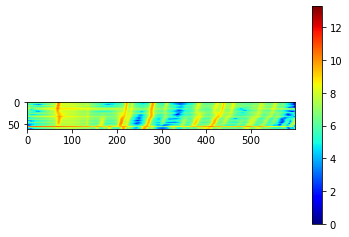

In [22]:
plt.imshow(np.log(1 + bgsubbed), cmap = 'jet')
plt.colorbar()

In [30]:
bgsubbed_noise = np.vstack([fit_curves(y, noise_estimate = fast_T.T[i], stdratio_threshold = 1.5) for y in patterns])

numBlocks: 358, dataPts/Block: 1.670391061452514
[  0.  35. 127. 183. 230. 263. 297. 342. 408. 430. 448. 501. 512. 539.
 567. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  35., 127., 183., 230., 263., 297., 342., 408., 430., 448.,
       501., 512., 539., 567., 597.])}
Peak at 7, start iteration with error = 0.9522141479331878
Peak at 7, iteration 0: error = 1.4771205021148746
45.81680774272451
Peak at 7, iteration 1: error = 1.383759675834048
40.888922105178075
Peak at 7, iteration 2: error = 1.124026301612643
    ----Saving data for block between 1.00 - 34.00
Peak at 71, start iteration with error = 0.34495506127333136
Peak at 71, iteration 0: error = 0.6027901866074106
10.732075564184159
Peak at 71, iteration 1: error = 0.02530567183498203
1.1958643815532521
    ----Saving data for block between 35.00 - 126.00
Peak at 132, start iteration with error = 0.8034674005309951
Peak at 132, iteration 0: error = 0.15687590084012784
5.480185640682441
Peak at 132, iteration 1: 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 523, start iteration with error = 0.4717826947423572
Peak at 523, iteration 0: error = 0.4852790525793488
10.026656348238864
Peak at 523, iteration 1: error = 0.08596431828267401
2.1674345834641606
Peak at 523, iteration 2: error = 0.07364007080460469
    ----Saving data for block between 511.00 - 538.00
Peak at 554, start iteration with error = 0.39939646718384025
Peak at 554, iteration 0: error = 0.5834095379626083
5.465759054362207
Peak at 554, iteration 1: error = 0.08400434865714232
0.9951273182723549
    ----Saving data for block between 539.00 - 563.00
Peak at 572, start iteration with error = 0.7509888990531967
Peak at 572, iteration 0: error = 0.3580628682858496
5.511986780270467
Peak at 572, iteration 1: error = 0.4564932993310396
3.1270293890108416
Peak at 572, iteration 2: error = 0.6449469828323626
    ----Saving data for block between 564.00 - 596.00
numBlocks: 364, dataPts/Block: 1.6428571428571428
[  0.  35. 127. 183. 230. 263. 303. 340. 408. 431. 448. 488. 514.

Peak at 523, start iteration with error = 0.3993439305831897
Peak at 523, iteration 0: error = 0.5746310561102752
8.559306603252152
Peak at 523, iteration 1: error = 0.06216084083958278
1.4603157790592027
    ----Saving data for block between 514.00 - 543.00
Peak at 554, start iteration with error = 0.4802046244540223
Peak at 554, iteration 0: error = 0.5160415985718282
10.634475579397066
Peak at 554, iteration 1: error = 0.027208551736644892
0.7136874970783279
    ----Saving data for block between 544.00 - 566.00
Peak at 572, start iteration with error = 0.47099027953109557
Peak at 572, iteration 0: error = 0.5206187155649641
15.334827015933833
Peak at 572, iteration 1: error = 0.03403418553814109
1.964540191906422
Peak at 572, iteration 2: error = 0.03510031386326232
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 567.00 - 596.00
numBlocks: 362, dataPts/Block: 1.6519337016574585
[  0.  34. 128. 183. 229. 263.

Peak at 461, start iteration with error = 0.3906798629683095
Peak at 461, iteration 0: error = 0.5582454418587385
7.9406084865876645
Peak at 461, iteration 1: error = 0.033724634652567496
0.9476738698143248
    ----Saving data for block between 447.00 - 499.00
Peak at 509, start iteration with error = 0.267051438191037
Peak at 509, iteration 0: error = 0.7309781295962344
2.950413122802926
Peak at 509, iteration 1: error = 0.002649376618474777
0.015575734828176665


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 500.00 - 509.00
Peak at 522, start iteration with error = 0.42842721518562193
Peak at 522, iteration 0: error = 0.5323048828596851
10.644268177719104
Peak at 522, iteration 1: error = 0.06935798284328722
1.6939430977301546
Peak at 522, iteration 2: error = 0.04319003241257736
    ----Saving data for block between 510.00 - 537.00
Peak at 554, start iteration with error = 0.36511811686525336
Peak at 554, iteration 0: error = 0.6309146321267542
6.3336496556042015
Peak at 554, iteration 1: error = 0.028387725959660343
0.34965559609488056
    ----Saving data for block between 538.00 - 562.00
Peak at 572, start iteration with error = 0.7934374097153754
Peak at 572, iteration 0: error = 0.2981294159265565
5.291070942194075
Peak at 572, iteration 1: error = 0.5535930055907602
2.4063592819901
Peak at 572, iteration 2: error = 0.6789624441651443
    ----Saving data for block between 563.00 - 596.00
numBlocks: 359, dataPts/Block: 1.6657381615598885
[  0.  35.

    ----Saving data for block between 451.00 - 485.00
Peak at 508, start iteration with error = 0.14546858162666454
Peak at 508, iteration 0: error = 0.8524123986783995
5.008863148189567
Peak at 508, iteration 1: error = 0.005425152524790529
0.03760194066066896
    ----Saving data for block between 486.00 - 509.00
Peak at 522, start iteration with error = 0.39684133645351466
Peak at 522, iteration 0: error = 0.5788592194592103
8.035653724757283
Peak at 522, iteration 1: error = 0.06751747818249684
1.4620230344906855
    ----Saving data for block between 510.00 - 542.00
Peak at 553, start iteration with error = 0.5177649689848118
Peak at 553, iteration 0: error = 0.47812734679061963
7.0777168561816595
Peak at 553, iteration 1: error = 0.020603651941439784
0.3350923563129571
    ----Saving data for block between 543.00 - 565.00
Peak at 571, start iteration with error = 0.8675233085042511
Peak at 571, iteration 0: error = 0.14681172587180685
2.459152373517726
Peak at 571, iteration 1: err

Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 406.00 - 429.00
Peak at 438, start iteration with error = 0.4452352103306618
Peak at 438, iteration 0: error = 0.5509791501762727
14.413409476206409
Peak at 438, iteration 1: error = 0.024397140015275237
0.8750022116590044
    ----Saving data for block between 430.00 - 446.00
Peak at 460, start iteration with error = 0.30371339134091885
Peak at 460, iteration 0: error = 0.6774887595116994
15.460807093555596
Peak at 460, iteration 1: error = 0.023340585237615882
1.0598189225088523
    ----Saving data for block between 447.00 - 496.00
Peak at 507, start iteration with error = 0.17110470501252242
Peak at 507, iteration 0: error = 0.827766237541089
6.479850951107623
Peak at 507, iteration 1: error = 0.001193451579699739
0.014102023756196657
    ----Saving data for block between 497.00 - 508.00
Peak at 521, start iteration with error = 0.3438949144527931
Peak at 521, i

    ----Saving data for block between 337.00 - 404.00
Peak at 421, start iteration with error = 0.4587978138183444
Peak at 421, iteration 0: error = 0.5291839935287006
1.9213681708448591
Peak at 421, iteration 1: error = 0.0642523243758113
0.2751191369497574
    ----Saving data for block between 405.00 - 427.00
Peak at 438, start iteration with error = 0.4193064185351806
Peak at 438, iteration 0: error = 0.576040199467779
5.003273783276526
Peak at 438, iteration 1: error = 0.031151122381566296
0.33584838718109494
    ----Saving data for block between 428.00 - 445.00
Peak at 459, start iteration with error = 0.2887278870821966
Peak at 459, iteration 0: error = 0.6921500134117115
16.357460672746885
Peak at 459, iteration 1: error = 0.0197180887754007
1.0201285821916641
    ----Saving data for block between 446.00 - 495.00
Peak at 506, start iteration with error = 0.18940650247301383
Peak at 506, iteration 0: error = 0.8092300203469655
7.041272236446661
Peak at 506, iteration 1: error = 0

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 496.00 - 505.00
Peak at 520, start iteration with error = 0.3780101395491651
Peak at 520, iteration 0: error = 0.590418324381769
7.3618057860418284
Peak at 520, iteration 1: error = 0.06979401401293495
1.1259830730213316
    ----Saving data for block between 506.00 - 540.00
Peak at 551, start iteration with error = 0.4373455930697999
Peak at 551, iteration 0: error = 0.5610733610034495
6.1514318932690175
Peak at 551, iteration 1: error = 0.017902460025337106
0.2724625329959702
    ----Saving data for block between 541.00 - 560.00
Peak at 569, start iteration with error = 0.932055136526245
Peak at 569, iteration 0: error = 0.4121693027791029
2.5967983392910634
Peak at 569, iteration 1: error = 0.8141240482850246
1.4083567263282757
    ----Saving data for block between 561.00 - 596.00
numBlocks: 371, dataPts/Block: 1.6118598382749325
[  0.  33. 130. 189. 227. 261. 301. 350. 405. 427. 446. 495. 506. 534.
 561. 597.]
Experimental Info used: 

{'blockBo

Peak at 520, start iteration with error = 0.39415333511888706
Peak at 520, iteration 0: error = 0.5672297121349917
5.893779959202981
Peak at 520, iteration 1: error = 0.10945749267628715
1.4259979293214486
    ----Saving data for block between 506.00 - 539.00
Peak at 551, start iteration with error = 0.5259524805158885
Peak at 551, iteration 0: error = 0.46925383061527776
3.398104457061654
Peak at 551, iteration 1: error = 0.03387236171987306
0.3064362128371375
    ----Saving data for block between 540.00 - 564.00
Peak at 568, start iteration with error = 0.4855590582778128
Peak at 568, iteration 0: error = 0.45006190750301445
3.567107069718851
Peak at 568, iteration 1: error = 0.10250844088100808
0.8949848246016198
    ----Saving data for block between 565.00 - 596.00
numBlocks: 373, dataPts/Block: 1.6032171581769437
[  0.  33. 130. 187. 226. 260. 301. 348. 405. 428. 446. 494. 540. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  33., 130., 187., 226., 260., 301., 348., 4

    ----Saving data for block between 494.00 - 533.00
Peak at 550, start iteration with error = 0.8379083154539717
Peak at 550, iteration 0: error = 2.3361128044486716
1.732683486935358
Peak at 550, iteration 1: error = 1.924453073459339
1.366788064286355
    ----Saving data for block between 534.00 - 596.00
numBlocks: 378, dataPts/Block: 1.582010582010582
[  0.  32. 127. 186. 227. 260. 301. 349. 405. 426. 449. 494. 533. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  32., 127., 186., 227., 260., 301., 349., 405., 426., 449.,
       494., 533., 597.])}
Peak at 1, start iteration with error = 0.5038657185537979
Peak at 1, iteration 0: error = 0.4752303628939312
13.913837400776808
Peak at 1, iteration 1: error = 0.058134106313818726
2.725932010976204
Peak at 1, iteration 2: error = 0.042897525772746324
    ----Saving data for block between 1.00 - 31.00
Peak at 69, start iteration with error = 0.8645779126505446
Peak at 69, iteration 0: error = 0.9884536368516157
4.414727515

Peak at 6, start iteration with error = 0.9527258632077817
Peak at 6, iteration 0: error = 21.370178042085723
12.98810085476112
Peak at 6, iteration 1: error = 17.192849337049587
10.658772107032823
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 6, iteration 2: error = 18.972881852042743
    ----Saving data for block between 1.00 - 22.00
Peak at 69, start iteration with error = 0.6894087819255117
Peak at 69, iteration 0: error = 0.5227743570888408
6.56807756175555
Peak at 69, iteration 1: error = 0.13783264364440537
2.5523493787036844
Peak at 69, iteration 2: error = 0.09289372349558518
    ----Saving data for block between 23.00 - 129.00
Peak at 136, start iteration with error = 0.23007538597948285
Peak at 136, iteration 0: error = 0.7640157455811383
54.909135590877504
Peak at 136, iteration 1: error = 0.041715521230542375
4.744097645726605
Peak at 136, iteration 2: error = 0.03709354411635287
Optimal parameters not found: The maximum numb

    ----Saving data for block between 32.00 - 125.00
Peak at 136, start iteration with error = 0.35877815249939854
Peak at 136, iteration 0: error = 0.6207350821074455
36.78585672703144
Peak at 136, iteration 1: error = 0.06343490407405888
8.819416147605207
Peak at 136, iteration 2: error = 0.06343490447614138
    ----Saving data for block between 126.00 - 184.00
Peak at 220, start iteration with error = 0.5720074931809487
Peak at 220, iteration 0: error = 0.33459579853721433
2.9424015596750284
Peak at 220, iteration 1: error = 0.0500200640214637
0.73928728279929
    ----Saving data for block between 185.00 - 226.00
Peak at 232, start iteration with error = 0.5957314906004108
Peak at 232, iteration 0: error = 0.3882556646200122
3.279874024792033
Peak at 232, iteration 1: error = 0.0887464519632029
1.5380361438104224
Peak at 232, iteration 2: error = 0.10474359629266906
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block be

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 596, iteration 0: error = 0.9451787467745849
34.952802888758534
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 596, iteration 1: error = 0.005829108903060633
0.27683947842416123
    ----Saving data for block between 593.00 - 596.00
numBlocks: 386, dataPts/Block: 1.549222797927461
[  0.  31. 126. 187. 225. 259. 301. 345. 407. 426. 447. 488. 533. 591.
 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  31., 126., 187., 225., 259., 301., 345., 407., 426., 447.,
       488., 533., 591., 597.])}
Peak at 1, start iteration with error = 0.9142655892469129
Peak at 1, iteration 0: error = 4.091812503608881
9.981736162489044
Peak at 1, iteration 1: error = 1.4064679137595637
9.043199675159324
Peak at 1, iteration 2: error = 1.4061640114288243
    ----Saving data for block between 1.00 - 30.00
Peak at 70, start iteration with error = 0.9284472576057338
Peak at 70, iteration 0: error = 2.0569433080127113
5.439351139620756
Peak at 70

Peak at 517, iteration 0: error = 0.8025657703820369
32.2254121816171
Peak at 517, iteration 1: error = 0.015507519552612216
0.7552751331811042
    ----Saving data for block between 488.00 - 531.00
Peak at 547, start iteration with error = 0.7677626137198825
Peak at 547, iteration 0: error = 0.22086435150801326
5.651928134892435
Peak at 547, iteration 1: error = 0.09039573104580528
3.173234900847609
Peak at 547, iteration 2: error = 0.08271822176360993
    ----Saving data for block between 532.00 - 590.00
Peak at 591, start iteration with error = 0.4617901746960445
Peak at 591, iteration 0: error = 0.5110994193007082
3.709844359431202
Peak at 591, iteration 1: error = 0.04417404009855084
0.36646808480887905
    ----Saving data for block between 591.00 - 596.00


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 389, dataPts/Block: 1.5372750642673523
[  0.  16. 129. 163. 187. 226. 259. 301. 342. 407. 441. 487. 532. 590.
 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  16., 129., 163., 187., 226., 259., 301., 342., 407., 441.,
       487., 532., 590., 597.])}
Peak at 12, start iteration with error = 0.8278189026699618
Peak at 12, iteration 0: error = 0.4188773976447592
28.9986121463966
Peak at 12, iteration 1: error = 0.33659883736530394
18.940970503200422
Peak at 12, iteration 2: error = 0.30511108550650134


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 1.00 - 15.00
Peak at 71, start iteration with error = 0.4533746108416518
Peak at 71, iteration 0: error = 0.44532216180266126
9.800857168210184
Peak at 71, iteration 1: error = 0.2961523113701469
5.09247330852702
Peak at 71, iteration 2: error = 0.14562448392469884
    ----Saving data for block between 16.00 - 128.00
Peak at 136, start iteration with error = 0.23376682213684427
Peak at 136, iteration 0: error = 0.7614765541589158
352.1718276453512
Peak at 136, iteration 1: error = 0.022461965418568423
17.887833485797337
Peak at 136, iteration 2: error = 0.022461965382605205
    ----Saving data for block between 129.00 - 162.00
Peak at 168, start iteration with error = 0.1035922635050865
Peak at 168, iteration 0: error = 0.8954433104338371
48.39231201058157
Peak at 168, iteration 1: error = 0.0032151660763601216
0.2423337460728338
    ----Saving data for block between 163.00 - 186.00
Peak at 219, start iteration with error = 0.5141886740732265
Peak 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 590.00 - 596.00
numBlocks: 392, dataPts/Block: 1.5255102040816326
[  0.  29. 129. 161. 187. 225. 259. 300. 342. 407. 445. 487. 532. 589.
 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  29., 129., 161., 187., 225., 259., 300., 342., 407., 445.,
       487., 532., 589., 597.])}
Peak at 1, start iteration with error = 0.9264489558968655
Peak at 1, iteration 0: error = 2.5637263435661533
6.475506236170388
Peak at 1, iteration 1: error = 0.9463314811525515
4.468572120164816
Peak at 1, iteration 2: error = 0.9463346309343666
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 1.00 - 28.00
Peak at 71, start iteration with error = 0.924483734931999
Peak at 71, iteration 0: error = 2.1149202526912405
4.996927988336536
Peak at 71, iteration 1: error = 0.5856180808110382
3.5620104919422517
Peak at 71, iteration 2: error = 0.5818769679769946
    ----Saving data for block bet

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 387, dataPts/Block: 1.545219638242894
[  0.  27. 129. 160. 188. 226. 259. 300. 341. 407. 444. 486. 532. 552.
 589. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  27., 129., 160., 188., 226., 259., 300., 341., 407., 444.,
       486., 532., 552., 589., 597.])}
Peak at 1, start iteration with error = 0.22500969598113107
Peak at 1, iteration 0: error = 0.757025929441466
15.54565608868292
Peak at 1, iteration 1: error = 0.06312947033769888
2.429646313781856
Peak at 1, iteration 2: error = 0.06312902691493626
    ----Saving data for block between 1.00 - 26.00
Peak at 72, start iteration with error = 0.8126674963150605
Peak at 72, iteration 0: error = 0.8951986116439059
4.924695481950962
Peak at 72, iteration 1: error = 0.31545368778436833
3.320165297115899
Peak at 72, iteration 2: error = 0.2652970081934031
    ----Saving data for block between 27.00 - 128.00
Peak at 136, start iteration with error = 0.39615885703174375
Peak at 136, iteration 0: error = 0.585137268

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 589.00 - 596.00
numBlocks: 388, dataPts/Block: 1.541237113402062
[  0.  27. 129. 160. 188. 224. 259. 299. 342. 407. 443. 486. 532. 555.
 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  27., 129., 160., 188., 224., 259., 299., 342., 407., 443.,
       486., 532., 555., 588., 597.])}
Peak at 1, start iteration with error = 0.9199993875403301
Peak at 1, iteration 0: error = 1.4861341361995293
1.664367758987276
Peak at 1, iteration 1: error = 1.2387300745841558
1.4055654161585311
    ----Saving data for block between 1.00 - 26.00
Peak at 72, start iteration with error = 0.8980430877817801
Peak at 72, iteration 0: error = 1.5238471654739651
4.919155889953046
Peak at 72, iteration 1: error = 0.07426159403271056
1.7675902822954548
Peak at 72, iteration 2: error = 0.08362414027189483
    ----Saving data for block between 27.00 - 128.00
Peak at 136, start iteration with error = 0.35850057508232835
Peak at 136, iteration 0: error = 0.62542

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
numBlocks: 399, dataPts/Block: 1.4987468671679198
[  0.  22. 125. 159. 188. 225. 258. 299. 341. 356. 407. 439. 486. 531.
 554. 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  22., 125., 159., 188., 225., 258., 299., 341., 356., 407.,
       439., 486., 531., 554., 588., 597.])}
Peak at 17, start iteration with error = 0.19793837339220133
Peak at 17, iteration 0: error = 0.7933991852682432
19.34061963506693
Peak at 17, iteration 1: error = 0.03137212875546178
1.1584476081077961
    ----Saving data for block between 1.00 - 21.00
Peak at 72, start iteration with error = 0.7526316146180829
Peak at 72, iteration 0: error = 0.7164990192466109
4.961898416728351
Peak at 72, iteration 1: error = 0.06177365911383049
1.6538233495251713
Peak at 72, iteration 2: error = 0.060240745047018436
    ----Saving data for block between 22.00 - 124.00
Peak at 136, start iteration with error = 0.3978484617147056
Peak at 136, iteration 0

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 398, dataPts/Block: 1.5025125628140703
[  0.   4. 125. 159. 188. 224. 258. 299. 341. 355. 407. 441. 486. 531.
 553. 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,   4., 125., 159., 188., 224., 258., 299., 341., 355., 407.,
       441., 486., 531., 553., 588., 597.])}
Peak at 3, start iteration with error = 0.5733646686899764
Peak at 3, iteration 0: error = 0.2974784937938489
5.8405612890584715


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 3, iteration 1: error = 0.10968492263451889
0.8040980426225259
    ----Saving data for block between 1.00 - 3.00
Peak at 73, start iteration with error = 0.6234301174088881
Peak at 73, iteration 0: error = 0.38082615488633886
5.366161620816979
Peak at 73, iteration 1: error = 0.04919165878295469
1.6277039204927217
Peak at 73, iteration 2: error = 0.04919165894097595
    ----Saving data for block between 4.00 - 124.00
Peak at 136, start iteration with error = 0.38669077910719757
Peak at 136, iteration 0: error = 0.557800513888366
174.01024808672855
Peak at 136, iteration 1: error = 0.03755849678985759
17.605068589293868
Peak at 136, iteration 2: error = 0.03755849685637523
    ----Saving data for block between 125.00 - 158.00
Peak at 170, start iteration with error = 0.24466993931112124
Peak at 170, iteration 0: error = 0.7533071743064826
24.559174273087972
Peak at 170, iteration 1: error = 0.008088451481515073
0.3225289912488208
    ----Saving data for block between 159.00 - 18

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 402, dataPts/Block: 1.4875621890547264
[  0. 125. 159. 188. 225. 257. 298. 340. 356. 406. 441. 485. 531. 550.
 586. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 125., 159., 188., 225., 257., 298., 340., 356., 406., 441.,
       485., 531., 550., 586., 597.])}
Peak at 73, start iteration with error = 0.9086725089227601
Peak at 73, iteration 0: error = 3.94069003889554
5.235360144976122
Peak at 73, iteration 1: error = 0.4748752184266903
1.766220772227294
Peak at 73, iteration 2: error = 0.38849304031923826
    ----Saving data for block between 1.00 - 124.00
Peak at 136, start iteration with error = 0.37762895261078816
Peak at 136, iteration 0: error = 0.5671537896923435
166.88654642861962
Peak at 136, iteration 1: error = 0.03567774954986725
16.384747823451647
Peak at 136, iteration 2: error = 0.038177220276926986
    ----Saving data for block between 125.00 - 158.00
Peak at 170, start iteration with error = 0.25222463355598973
Peak at 170, iteration 0: error 

Peak at 596, iteration 0: error = 0.26993834940377054
1.703794555121485
Peak at 596, iteration 1: error = 0.12133266204869593
0.5906860430058143
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 585.00 - 596.00
numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 151., 189., 224., 255., 298., 339., 365., 405., 438.,
       477., 524., 551., 583., 597.])}
Peak at 73, start iteration with error = 0.7278140002765818
Peak at 73, iteration 0: error = 0.8101575238516157
5.363499021382212
Peak at 73, iteration 1: error = 0.12359530839121786
1.285034478096495
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.3311076783616203
Peak at 135, iteration 0: error = 0.6587047756596245
251.14051160923992
Peak at 135, iteration 1: error = 0.025656

Peak at 559, start iteration with error = 0.3062705951861644
Peak at 559, iteration 0: error = 0.6857360649587798
14.285728381171506
Peak at 559, iteration 1: error = 0.03491381277958497
0.9268297882011929
    ----Saving data for block between 547.00 - 580.00
Peak at 596, start iteration with error = 0.2317831118059971
Peak at 596, iteration 0: error = 0.7658944990353183
71.3468338286101
Peak at 596, iteration 1: error = 0.025428325229104876
2.6826155990046225
Peak at 596, iteration 2: error = 0.008300996375886428
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 581.00 - 596.00
numBlocks: 421, dataPts/Block: 1.4204275534441806
[  0. 128. 157. 188. 221. 254. 291. 337. 360. 403. 436. 471. 526. 548.
 578. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 157., 188., 221., 254., 291., 337., 360., 403., 436.,
       471., 526., 548., 578., 597.])}
Peak at 73, start iteration with error = 0.9861100131

Peak at 481, start iteration with error = 0.1413428004462274
Peak at 481, iteration 0: error = 0.8569924913668209
316.13608460522283
Peak at 481, iteration 1: error = 0.0022492839618866566
1.1943951572979101
    ----Saving data for block between 470.00 - 487.00
Peak at 509, start iteration with error = 0.47578662850560305
Peak at 509, iteration 0: error = 0.45122314437974653
8.406569033078103
Peak at 509, iteration 1: error = 0.11928505224971186
1.80515474266011
Peak at 509, iteration 2: error = 0.05720868447673317
    ----Saving data for block between 488.00 - 520.00
Peak at 537, start iteration with error = 0.3721132801977344
Peak at 537, iteration 0: error = 0.6237494643957726
5.889586741490626
Peak at 537, iteration 1: error = 0.034743751849592906
0.42966191708849016
    ----Saving data for block between 521.00 - 543.00
Peak at 556, start iteration with error = 0.943182727239275
Peak at 556, iteration 0: error = 1.7946558455684025
2.3481005465129137
Peak at 556, iteration 1: error 

Peak at 353, start iteration with error = 0.780054242815204
Peak at 353, iteration 0: error = 0.2402931225962747
2.275979962284057
Peak at 353, iteration 1: error = 0.16842598678766252
1.2048707003631016
    ----Saving data for block between 331.00 - 358.00
Peak at 380, start iteration with error = 0.5393347431355663
Peak at 380, iteration 0: error = 0.45345218909100315
2.0971698522579136
Peak at 380, iteration 1: error = 0.06161998454920531
0.49005827887298564
    ----Saving data for block between 359.00 - 400.00
Peak at 421, start iteration with error = 0.618898149938188
Peak at 421, iteration 0: error = 0.3721468108939447
1.0003506306569494
    ----Saving data for block between 401.00 - 433.00
Peak at 445, start iteration with error = 0.54513210065475
Peak at 445, iteration 0: error = 0.4167524476869762
2.556546527641543
Peak at 445, iteration 1: error = 0.11718276676341434
0.6141093301535177
    ----Saving data for block between 434.00 - 467.00
Peak at 480, start iteration with err

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 572.00 - 583.00
Peak at 596, start iteration with error = 0.2772316340392683
Peak at 596, iteration 0: error = 0.7130926893139553
23.30937837254739
Peak at 596, iteration 1: error = 0.04464117970590959
1.9326286733827636
Peak at 596, iteration 2: error = 0.030712223042369705


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 409, dataPts/Block: 1.4621026894865525
[  0. 128. 156. 187. 219. 254. 289. 328. 363. 400. 434. 468. 487. 519.
 544. 572. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 156., 187., 219., 254., 289., 328., 363., 400., 434.,
       468., 487., 519., 544., 572., 584., 597.])}
Peak at 72, start iteration with error = 0.9718457958070628
Peak at 72, iteration 0: error = 0.688592633425035
3.993968655736964
Peak at 72, iteration 1: error = 0.26217864763547005
1.028396394076105
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.31352823180726597
Peak at 135, iteration 0: error = 0.6787164281803465
246.3438344284853
Peak at 135, iteration 1: error = 0.02423689851718263
16.264550280810983
Peak at 135, iteration 2: error = 0.02432982858293507
    ----Saving data for block between 128.00 - 155.00
Peak at 168, start iteration with error = 0.43074535020303556
Peak at 1

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0. 128. 156. 187. 219. 254. 288. 326. 358. 400. 433. 468. 483. 523.
 544. 572. 588. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 156., 187., 219., 254., 288., 326., 358., 400., 433.,
       468., 483., 523., 544., 572., 588., 597.])}
Peak at 72, start iteration with error = 0.7790085738058646
Peak at 72, iteration 0: error = 1.2063178168448934
5.608414687272729
Peak at 72, iteration 1: error = 0.18940773755370713
1.5079024013211237
Peak at 72, iteration 2: error = 0.16601760571515906
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.2606020125203822
Peak at 135, iteration 0: error = 0.734483081143308
308.0920435652087
Peak at 135, iteration 1: error = 0.01895363456951592
13.886430730200379
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 135, iteration 2: error = 0.7429

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 125. 156. 188. 219. 254. 295. 330. 362. 399. 430. 468. 483. 519.
 543. 572. 585. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 125., 156., 188., 219., 254., 295., 330., 362., 399., 430.,
       468., 483., 519., 543., 572., 585., 597.])}
Peak at 72, start iteration with error = 0.9245322550865048
Peak at 72, iteration 0: error = 0.5321234748113892
3.9659026302780025
Peak at 72, iteration 1: error = 0.10742920519971869
0.8423125829781991
    ----Saving data for block between 1.00 - 124.00
Peak at 135, start iteration with error = 0.37588752328779196
Peak at 135, iteration 0: error = 0.589033072983078
174.857808755689
Peak at 135, iteration 1: error = 0.03003629732761557
18.38920935929441
Peak at 135, iteration 2: error = 0.02415044027194491
    ----Saving data for block between 125.00 - 155.00
Peak at 168, start iteration with error = 0.46024200726554293
Peak at 168, iteration 0: error = 0.5257418691166239
20.3926748

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 468.00 - 482.00
Peak at 501, start iteration with error = 0.4504075642761119
Peak at 501, iteration 0: error = 0.5160504725058312
8.875320050517727
Peak at 501, iteration 1: error = 0.11917607713264974
2.07123637788705
Peak at 501, iteration 2: error = 0.08369309724281823
    ----Saving data for block between 483.00 - 518.00
Peak at 533, start iteration with error = 0.46433969537349334
Peak at 533, iteration 0: error = 0.5219876577199919
5.903475078771864
Peak at 533, iteration 1: error = 0.0510124752007523
0.6509947029809603
    ----Saving data for block between 519.00 - 542.00
Peak at 552, start iteration with error = 0.7764469200816216
Peak at 552, iteration 0: error = 0.24027281355466762
1.0625143588293042
    ----Saving data for block between 543.00 - 571.00
Peak at 582, start iteration with error = 0.6237667804520576
Peak at 582, iteration 0: error = 0.36301301192379665
8.12516267045877
Peak at 582, iteration 1: error = 0.04952732414371971
1.

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0.  88. 125. 156. 188. 219. 254. 295. 330. 358. 399. 430. 468. 483.
 519. 540. 571. 585. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  88., 125., 156., 188., 219., 254., 295., 330., 358., 399.,
       430., 468., 483., 519., 540., 571., 585., 597.])}
Peak at 72, start iteration with error = 0.9702171034430035
Peak at 72, iteration 0: error = 5.081533551614982
1.9249405654392742
Peak at 72, iteration 1: error = 2.285077697456029
0.9220170268838707
    ----Saving data for block between 1.00 - 87.00
Peak at 92, start iteration with error = 0.3271877209453076
Peak at 92, iteration 0: error = 0.6678272815286139
149.22271267600127
Peak at 92, iteration 1: error = 0.011989032808718278
3.3973663023674123
Peak at 92, iteration 2: error = 0.009619705130200277
    ----Saving data for block between 88.00 - 124.00
Peak at 135, start iteration with error = 0.4538976104976529
Pea

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
numBlocks: 405, dataPts/Block: 1.4765432098765432
[  0.  87. 125. 156. 188. 218. 254. 295. 327. 358. 399. 429. 468. 487.
 514. 543. 571. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  87., 125., 156., 188., 218., 254., 295., 327., 358., 399.,
       429., 468., 487., 514., 543., 571., 584., 597.])}
Peak at 72, start iteration with error = 0.9305810793349156
Peak at 72, iteration 0: error = 0.4874322159998186
2.042523207144681
Peak at 72, iteration 1: error = 0.39292564946458625
1.130141533289662
    ----Saving data for block between 1.00 - 86.00
Peak at 92, start iteration with error = 0.262055988834842
Peak at 92, iteration 0: error = 0.7352783664315056
201.16534243403035
Peak at 92, iteration 1: error = 0.009044882650829337
3.5416402024695595
Peak at 92, iteration 2: error = 0.007267026180986071
    ----Saving data for block between 87.00 - 124.00
Peak at 135, start iteration with error = 0.3439458267633665
Pea

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 571.00 - 583.00
Peak at 596, start iteration with error = 0.47046023348145394
Peak at 596, iteration 0: error = 0.4741998961459154
14.579531517964176
Peak at 596, iteration 1: error = 0.10681249079772501
3.813820820596775
Peak at 596, iteration 2: error = 0.071354963671992


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 413, dataPts/Block: 1.4479418886198547
[  0.  87. 125. 156. 189. 218. 253. 295. 328. 362. 398. 432. 467. 482.
 522. 542. 571. 587. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  87., 125., 156., 189., 218., 253., 295., 328., 362., 398.,
       432., 467., 482., 522., 542., 571., 587., 597.])}
Peak at 71, start iteration with error = 0.6654311098887173
Peak at 71, iteration 0: error = 0.30198465406454694
2.2311144891842365
Peak at 71, iteration 1: error = 0.300800222428861
1.0875602731382406
    ----Saving data for block between 1.00 - 86.00
Peak at 94, start iteration with error = 0.26101599770932465
Peak at 94, iteration 0: error = 0.7372300081176849
195.8811685532797
Peak at 94, iteration 1: error = 0.009543441282633732
3.8302965497898396
Peak at 94, iteration 2: error = 0.0074176314800410365
    ----Saving data for block between 87.00 - 124.00
Peak at 135, start iteration with error = 0.3426844969879212


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 467.00 - 481.00
Peak at 499, start iteration with error = 0.47882264491841225
Peak at 499, iteration 0: error = 0.571041555587229
7.044448901504561
Peak at 499, iteration 1: error = 0.38010902835216653
3.292990943413826
Peak at 499, iteration 2: error = 0.3074486475013306
    ----Saving data for block between 482.00 - 521.00
Peak at 532, start iteration with error = 0.5765999049914294
Peak at 532, iteration 0: error = 0.4118362112089529
3.250405373912836
Peak at 532, iteration 1: error = 0.027587158447083156
0.3430992715652987
    ----Saving data for block between 522.00 - 541.00
Peak at 551, start iteration with error = 0.7741180252280437
Peak at 551, iteration 0: error = 0.2580364013623443
0.3509322728972345
    ----Saving data for block between 542.00 - 570.00
Peak at 581, start iteration with error = 0.7664764060453791
Peak at 581, iteration 0: error = 0.22422360562720162
5.649997250938908
Peak at 581, iteration 1: error = 0.030699353414851485


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 587.00 - 596.00
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  85. 124. 156. 188. 218. 253. 295. 327. 362. 398. 429. 467. 486.
 513. 542. 570. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  85., 124., 156., 188., 218., 253., 295., 327., 362., 398.,
       429., 467., 486., 513., 542., 570., 584., 597.])}
Peak at 71, start iteration with error = 0.8232078671564605
Peak at 71, iteration 0: error = 1.0833437151381904
1.6946094822588373
Peak at 71, iteration 1: error = 0.8562538461221739
0.990050404748169
    ----Saving data for block between 1.00 - 84.00
Peak at 96, start iteration with error = 0.27842630947187313
Peak at 96, iteration 0: error = 0.7198780605466881
156.22381417496374
Peak at 96, iteration 1: error = 0.015712392747837103
3.9448383666073203
Peak at 96, iteration 2: error = 0.008940362917784514
    ----Saving data for block between 85.00 - 123.00
Peak at 135, start iteration with error = 0.3915663365618599
P

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  84. 124. 156. 189. 218. 252. 288. 326. 361. 397. 428. 466. 481.
 517. 541. 569. 586. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  84., 124., 156., 189., 218., 252., 288., 326., 361., 397.,
       428., 466., 481., 517., 541., 569., 586., 597.])}
Peak at 71, start iteration with error = 0.9845411437796259
Peak at 71, iteration 0: error = 3.728287716516883
29.82199631968584
Peak at 71, iteration 1: error = 3.74059395526945
29.818538093280242
Peak at 71, iteration 2: error = 3.740593966149269
    ----Saving data for block between 1.00 - 83.00
Peak at 84, start iteration with error = 0.27868815012648046
Peak at 84, iteration 0: error = 0.7186390153564106
962.4845281436982
Peak at 84, iteration 1: error = 0.010524286259106347
22.763004873614975
Peak at 84, iteration 2: error = 0.008811861298381348
    ----Saving data for block between 84.00 - 123.00
Peak at 124, st

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 498, start iteration with error = 0.1744828827565719
Peak at 498, iteration 0: error = 0.8227847962576632
85.41662277033096
Peak at 498, iteration 1: error = 0.029623461983787222
3.8652870723148776
Peak at 498, iteration 2: error = 0.01766570194248847
    ----Saving data for block between 481.00 - 516.00
Peak at 531, start iteration with error = 0.1826627445680209
Peak at 531, iteration 0: error = 0.8124350079328163
108.57254829440913
Peak at 531, iteration 1: error = 0.028716532594040545
4.424360492259923
Peak at 531, iteration 2: error = 0.02020814923418991
    ----Saving data for block between 517.00 - 540.00
Peak at 541, start iteration with error = 0.35434684298991576
Peak at 541, iteration 0: error = 0.6348291603145176
35.15089840204336
Peak at 541, iteration 1: error = 0.033274944032774416
2.1657807723906815
Peak at 541, iteration 2: error = 0.010451920186298489
    ----Saving data for block between 541.00 - 568.00
Peak at 569, start iteration with error = 0.618675219197

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 586.00 - 596.00
numBlocks: 409, dataPts/Block: 1.4621026894865525
[  0.  83. 124. 150. 189. 217. 252. 288. 328. 361. 396. 428. 465. 481.
 512. 541. 568. 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  83., 124., 150., 189., 217., 252., 288., 328., 361., 396.,
       428., 465., 481., 512., 541., 568., 583., 597.])}
Peak at 71, start iteration with error = 0.7892522357882578
Peak at 71, iteration 0: error = 0.8784560865115582
1.4940990064082005
    ----Saving data for block between 1.00 - 82.00
Peak at 92, start iteration with error = 0.30052865408486196
Peak at 92, iteration 0: error = 0.6967753072732443
113.99777328440365
Peak at 92, iteration 1: error = 0.010272445223354632
2.447549619822682
Peak at 92, iteration 2: error = 0.008321392543459195
    ----Saving data for block between 83.00 - 123.00
Peak at 135, start iteration with error = 0.45819370736483145
Peak at 135, iteration 0: error = 0.4760995492973382
133.24631991523066

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 568.00 - 582.00
Peak at 596, start iteration with error = 0.9171025305154272
Peak at 596, iteration 0: error = 4.1129650295248625
4.409868447853393
Peak at 596, iteration 1: error = 3.140715099859086
3.359811737884959
Peak at 596, iteration 2: error = 2.7110274122338205
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 583.00 - 596.00
numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0.  82. 124. 150. 190. 217. 252. 288. 323. 356. 394. 427. 464. 480.
 516. 540. 567. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  82., 124., 150., 190., 217., 252., 288., 323., 356., 394.,
       427., 464., 480., 516., 540., 567., 584., 597.])}
Peak at 71, start iteration with error = 0.6648686357477634
Peak at 71, iteration 0: error = 0.30947598454361336
2.686093992618944
Peak at 71, iteration 1: error = 0.10665396519925574
0.9564713561417753
    ----Saving data for bloc

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 411, dataPts/Block: 1.4549878345498783
[  0.  81. 124. 149. 188. 216. 251. 288. 324. 359. 393. 430. 454. 479.
 516. 539. 566. 580. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  81., 124., 149., 188., 216., 251., 288., 324., 359., 393.,
       430., 454., 479., 516., 539., 566., 580., 597.])}
Peak at 71, start iteration with error = 0.9352994571891473
Peak at 71, iteration 0: error = 2.908321541724224
1.7857200224978795
Peak at 71, iteration 1: error = 1.771810541167128
1.6056174312919944
Peak at 71, iteration 2: error = 1.671005007342061
    ----Saving data for block between 1.00 - 80.00
Peak at 96, start iteration with error = 0.2139171404035229
Peak at 96, iteration 0: error = 0.7852228059558507
94.02295192467801
Peak at 96, iteration 1: error = 0.008438632400246273
1.2488975405678158
    ----Saving data for block between 81.00 - 123.00
Peak at 135, start iteration with error = 0.29086424469952515
Peak a

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 566.00 - 579.00
Peak at 594, start iteration with error = 0.6008305815806078
Peak at 594, iteration 0: error = 0.37535692693910805
20.583016622473778
Peak at 594, iteration 1: error = 0.05674194495634499
3.9469599523313232
Peak at 594, iteration 2: error = 0.04240834225548769
    ----Saving data for block between 580.00 - 596.00
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  80. 124. 153. 180. 216. 250. 295. 319. 358. 390. 426. 450. 478.
 510. 535. 565. 579. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  80., 124., 153., 180., 216., 250., 295., 319., 358., 390.,
       426., 450., 478., 510., 535., 565., 579., 597.])}
Peak at 70, start iteration with error = 0.8102292160979588
Peak at 70, iteration 0: error = 0.21754082566936883
2.1210679022470864
Peak at 70, iteration 1: error = 0.10390837091525017
1.0575346800621683
    ----Saving data for block between 1.00 - 79.00
Peak at 91, start iteration with error = 0.2618264651458

    ----Saving data for block between 315.00 - 353.00
Peak at 373, start iteration with error = 0.5512949198085929
Peak at 373, iteration 0: error = 0.4165711728202969
4.099229858265808
Peak at 373, iteration 1: error = 0.047443231309555634
0.4995119353993198
    ----Saving data for block between 354.00 - 385.00
Peak at 413, start iteration with error = 0.4894530595516306
Peak at 413, iteration 0: error = 0.49208136393862223
2.6526921258440757
Peak at 413, iteration 1: error = 0.06143802280142299
0.3534031555937885
    ----Saving data for block between 386.00 - 427.00
Peak at 436, start iteration with error = 0.24412047605354598
Peak at 436, iteration 0: error = 0.7354779829000628
2.0014876892715994
Peak at 436, iteration 1: error = 0.07252883324787507
0.23661779692855112
    ----Saving data for block between 428.00 - 459.00
Peak at 472, start iteration with error = 0.25243600173838077
Peak at 472, iteration 0: error = 0.7456876916786468
316.435679882081
Peak at 472, iteration 1: error

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)



Peak at 499, start iteration with error = 0.5740768223652559
Peak at 499, iteration 0: error = 0.41643061882115695
6.148344046111922
Peak at 499, iteration 1: error = 0.025436600619886295
0.4360040402090824
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 495.00 - 508.00
Peak at 526, start iteration with error = 0.3651381367714687
Peak at 526, iteration 0: error = 0.6252427774786579
8.25503856522498
Peak at 526, iteration 1: error = 0.04537982302270963
0.6591077968689176
    ----Saving data for block between 509.00 - 533.00
Peak at 543, start iteration with error = 0.47014843608850754
Peak at 543, iteration 0: error = 0.44026307569066936
1.5814542024874776
Peak at 543, iteration 1: error = 0.13588106900351707
0.39002372847920014
    ----Saving data for block between 534.00 - 557.00
Peak at 574, start iteration with error = 0.6869495207475004
Peak at 574, iteration 0: error = 0.22352274591762442
0.97155935206809

Peak at 157, start iteration with error = 0.30421903645277965
Peak at 157, iteration 0: error = 0.694285684654888
309.9115489360738
Peak at 157, iteration 1: error = 0.011894275658708583
8.230699077991027
Peak at 157, iteration 2: error = 0.004235320540386007
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 143.00 - 159.00
Peak at 165, start iteration with error = 0.2905147368537558
Peak at 165, iteration 0: error = 0.696417630256991
54.47309134736051
Peak at 165, iteration 1: error = 0.047243430908134494
4.373856320446732
Peak at 165, iteration 2: error = 0.035807574475969745


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 160.00 - 174.00
Peak at 185, start iteration with error = 0.4593961423428179
Peak at 185, iteration 0: error = 0.511500048614879
137.9606181229355
Peak at 185, iteration 1: error = 0.058166580364075994
17.418100147982916
Peak at 185, iteration 2: error = 0.045501431799919625
    ----Saving data for block between 175.00 - 195.00
Peak at 209, start iteration with error = 0.5446837305447382
Peak at 209, iteration 0: error = 0.42224820504591315
8.853480172349617
Peak at 209, iteration 1: error = 0.16476978875282322
2.5622691530977058
Peak at 209, iteration 2: error = 0.07315412923617333
    ----Saving data for block between 196.00 - 214.00
Peak at 220, start iteration with error = 0.6086303055872777
Peak at 220, iteration 0: error = 0.39200120668289307
4.875914537073469
Peak at 220, iteration 1: error = 0.27874759342095906
2.5925401054212105
Peak at 220, iteration 2: error = 0.34197400122259464
    ----Saving data for block between 215.00 - 248.00
Peak

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 165.00 - 175.00
Peak at 185, start iteration with error = 0.5126507741987134
Peak at 185, iteration 0: error = 0.46809642368126975
141.54809423106002
Peak at 185, iteration 1: error = 0.06139383312529429
23.96799958885833
Peak at 185, iteration 2: error = 0.05181782126463628
    ----Saving data for block between 176.00 - 194.00
Peak at 214, start iteration with error = 0.8013021236808987
Peak at 214, iteration 0: error = 0.41873556801881656
5.420585610758242
Peak at 214, iteration 1: error = 0.3702452646849436
3.213961267744176
Peak at 214, iteration 2: error = 0.49215065601926555
    ----Saving data for block between 195.00 - 247.00
Peak at 266, start iteration with error = 0.8219672460390504
Peak at 266, iteration 0: error = 1.2169400231676477
1.9659167093264793
Peak at 266, iteration 1: error = 2.00635549885637
1.0025108758893158
    ----Saving data for block between 248.00 - 310.00
Peak at 328, start iteration with error = 0.8010148671105283
Pe

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 341.00 - 355.00
Peak at 368, start iteration with error = 0.36684638725765917
Peak at 368, iteration 0: error = 0.6282378065842839
50.82275481220615
Peak at 368, iteration 1: error = 0.028108978949834287
3.095573472714585
Peak at 368, iteration 2: error = 0.010389621048166818
    ----Saving data for block between 356.00 - 371.00
Peak at 385, start iteration with error = 0.31300008608652097
Peak at 385, iteration 0: error = 0.6853861792997715
5.435146460410266
Peak at 385, iteration 1: error = 0.012335709037946
0.11361575628836201
    ----Saving data for block between 372.00 - 387.00
Peak at 396, start iteration with error = 0.33105842201714253
Peak at 396, iteration 0: error = 0.6666400316324282
21.391471731313725
Peak at 396, iteration 1: error = 0.025951564139393243
0.9847470298957034
    ----Saving data for block between 388.00 - 400.00
Peak at 411, start iteration with error = 0.4974603640467876
Peak at 411, iteration 0: error = 0.4950139583397

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 465, start iteration with error = 0.1172994415831635
Peak at 465, iteration 0: error = 0.8804935593830094
63.553878416183395
Peak at 465, iteration 1: error = 0.018688660928281878
1.6963757627416414
Peak at 465, iteration 2: error = 0.00985611793815376
    ----Saving data for block between 454.00 - 475.00
Peak at 495, start iteration with error = 0.4243342270225929
Peak at 495, iteration 0: error = 0.5720025910865252
9.691514690460998
Peak at 495, iteration 1: error = 0.020476976260519284
0.4210510234868446
    ----Saving data for block between 476.00 - 509.00
Peak at 522, start iteration with error = 0.4622433328482082
Peak at 522, iteration 0: error = 0.5219245401034269
12.953365102104396
Peak at 522, iteration 1: error = 0.0479786868048022
1.4780822683898212
    ----Saving data for block between 510.00 - 531.00
Peak at 535, start iteration with error = 0.5538615525794318
Peak at 535, iteration 0: error = 0.43973989182384243
1.8039050316511105
Peak at 535, iteration 1: error 

numBlocks: 435, dataPts/Block: 1.374712643678161
[  0.  75. 124. 143. 163. 176. 200. 224. 246. 273. 311. 336. 356. 374.
 387. 398. 419. 444. 454. 475. 505. 529. 558. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  75., 124., 143., 163., 176., 200., 224., 246., 273., 311.,
       336., 356., 374., 387., 398., 419., 444., 454., 475., 505., 529.,
       558., 584., 597.])}
Peak at 68, start iteration with error = 0.9536136445563601
Peak at 68, iteration 0: error = 0.40490189179276737
1.6839758270558447
Peak at 68, iteration 1: error = 0.38678530819705914
1.5686635727112779
Peak at 68, iteration 2: error = 0.3867844062117343
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 1.00 - 74.00
Peak at 92, start iteration with error = 0.30694275406592625
Peak at 92, iteration 0: error = 0.6912463847750029
8.218347946722341
Peak at 92, iteration 1: error = 0.017525049998380338
0.24356088638116422
    ----Sa

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 464, start iteration with error = 0.10291631418053457
Peak at 464, iteration 0: error = 0.8953495349109801
80.56218231303694
Peak at 464, iteration 1: error = 0.014237691421972534
1.6605995405761476
Peak at 464, iteration 2: error = 0.005274819787673858
    ----Saving data for block between 454.00 - 474.00
Peak at 493, start iteration with error = 0.42534709300532875
Peak at 493, iteration 0: error = 0.5734679512587277
15.721684876861989
Peak at 493, iteration 1: error = 0.019642587278551157
0.7084826401434573
    ----Saving data for block between 475.00 - 504.00
Peak at 518, start iteration with error = 0.45537806041067475
Peak at 518, iteration 0: error = 0.5372388566518648
10.893333264749428
Peak at 518, iteration 1: error = 0.02662878271143738
0.6760370730982986
    ----Saving data for block between 505.00 - 528.00
Peak at 534, start iteration with error = 0.3853145348837751
Peak at 534, iteration 0: error = 0.6117484457998081
4.815973632917609
Peak at 534, iteration 1: err

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 385, start iteration with error = 0.5692096446864302
Peak at 385, iteration 0: error = 0.3913665490393494
0.7407732023170064
    ----Saving data for block between 370.00 - 386.00
Peak at 395, start iteration with error = 0.3638424094799958
Peak at 395, iteration 0: error = 0.6220927103731486
8.859597756224154
Peak at 395, iteration 1: error = 0.052306169401211626
0.9304826331810097
    ----Saving data for block between 387.00 - 395.00


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 406, start iteration with error = 0.7046404585263377
Peak at 406, iteration 0: error = 0.1927774067766255
6.696120367361055
Peak at 406, iteration 1: error = 0.1233906140501686
2.1926276088495227
Peak at 406, iteration 2: error = 0.10508419389267003
    ----Saving data for block between 396.00 - 420.00
Peak at 429, start iteration with error = 0.8098581450897662
Peak at 429, iteration 0: error = 0.16115405685429193
0.15282646041979098
    ----Saving data for block between 421.00 - 443.00
Peak at 450, start iteration with error = 0.6961668093124154
Peak at 450, iteration 0: error = 0.29484387124227196
0.20298842405566414
    ----Saving data for block between 444.00 - 452.00
Peak at 464, start iteration with error = 0.6823363956570979
Peak at 464, iteration 0: error = 0.25323975527523546
1.3050253300591903
    ----Saving data for block between 453.00 - 473.00
Peak at 491, start iteration with error = 0.8259329849939382
Peak at 491, iteration 0: error = 0.20220704901901615
3.02007

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 359.00 - 369.00
Peak at 385, start iteration with error = 0.45804253187182686
Peak at 385, iteration 0: error = 0.5315113801628532
1.3156447656541375
    ----Saving data for block between 370.00 - 386.00
Peak at 404, start iteration with error = 0.6687404148789681
Peak at 404, iteration 0: error = 0.3235908958604433
12.54457361364904
Peak at 404, iteration 1: error = 0.21426339884361145
5.338351473804227
Peak at 404, iteration 2: error = 0.16014239115605922
    ----Saving data for block between 387.00 - 417.00
Peak at 429, start iteration with error = 0.4941190595569612
Peak at 429, iteration 0: error = 0.4373789780023458
0.5810430002292437
    ----Saving data for block between 418.00 - 443.00
Peak at 450, start iteration with error = 0.2814703496408008
Peak at 450, iteration 0: error = 0.7155187464738816
2.2394084876466684
Peak at 450, iteration 1: error = 0.0035132976533380055
0.014423827358677152
Optimal parameters not found: The maximum number 

Peak at 453, iteration 1: error = 0.0064454726705771605
0.05597493069865877
    ----Saving data for block between 447.00 - 459.00
Peak at 467, start iteration with error = 0.17836071327521064
Peak at 467, iteration 0: error = 0.8198916487039719
345.9198634127898
Peak at 467, iteration 1: error = 0.008276024763854745
4.003005094641573
Peak at 467, iteration 2: error = 0.006022655233548004
    ----Saving data for block between 460.00 - 475.00
Peak at 492, start iteration with error = 0.5760627754634188
Peak at 492, iteration 0: error = 0.42375891520048753
12.566299720397865
Peak at 492, iteration 1: error = 0.04526805249668229
1.98321866180347
Peak at 492, iteration 2: error = 0.049406106150843995
    ----Saving data for block between 476.00 - 502.00
Peak at 518, start iteration with error = 0.5466767358859815
Peak at 518, iteration 0: error = 0.44400376186951623
6.064195017642401
Peak at 518, iteration 1: error = 0.045465784803766916
0.939328789852869
    ----Saving data for block betwe

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [50]:
for i, recalculate in enumerate(bgsubbed_noise.mean(axis = 1) >= threshold):
    if recalculate:
        bgsubbed_noise[i] = fit_curves(patterns[i], noise_estimate = fast_T.T[i], stdratio_threshold = 2)

numBlocks: 405, dataPts/Block: 1.4765432098765432
[  0.  87. 125. 156. 188. 218. 254. 295. 327. 358. 399. 429. 468. 487.
 514. 543. 571. 584. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  87., 125., 156., 188., 218., 254., 295., 327., 358., 399.,
       429., 468., 487., 514., 543., 571., 584., 597.])}
Peak at 72, start iteration with error = 0.953171499923533
Peak at 72, iteration 0: error = 0.30830382990141986
9.480720549387641
Peak at 72, iteration 1: error = 0.2870001511445211
6.954728689327316
Peak at 72, iteration 2: error = 0.2863043232249425
    ----Saving data for block between 1.00 - 86.00
Peak at 90, start iteration with error = 0.27347819717197913
Peak at 90, iteration 0: error = 0.7231583593100953
55.34637069929626
Peak at 90, iteration 1: error = 0.009010287316987546
1.0226296539840183
    ----Saving data for block between 87.00 - 124.00
Peak at 135, start iteration with error = 0.35168311157882337
Peak at 135, iteration 0: error = 0.620554103579434
25.954

In [156]:
from matplotlib.widgets import Slider
from pylab import *

In [174]:
# bad rows: 50, ...
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(i):
#     plt.plot(patterns[i], label = 'raw')
    plt.plot(bgsubbed[i], label = 'curve fit subtraction')
    plt.legend()
    plt.grid()

interactive_plot = interactive(f, i=(0, 60), step = 1)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=30, description='i', max=60), Output(layout=Layout(height='350px'))), _d…

In [16]:
bgsubbed = np.vstack(bgsubbed)

In [194]:
with open('data/yijin_cheb_bgsub.npy', 'wb') as f:
    np.save(f, bgsubbed)

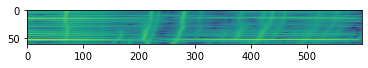

In [15]:
plt.imshow(np.log(1 + np.vstack(bgsubbed)))

# Stop condition based on noise estimate

In [6]:
from importlib import reload
reload(sep)

<module 'xrdc.source_separation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/source_separation.py'>

In [7]:
# from xrdc import source_separation as sep
# slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns, background_after_filter=False,
#                                                      smooth_q_background = 20)

(0, 0)


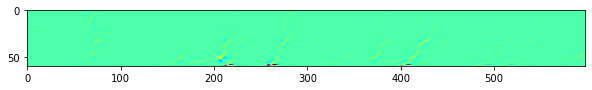

In [124]:
plt.imshow(fast_T.T, cmap = 'jet')

In [20]:
tmp_noise = fit_curves(patterns[i], noise_estimate = fast_T.T[i], stdratio_threshold = 1.5)

numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  80. 124. 153. 180. 216. 250. 295. 319. 358. 390. 426. 450. 478.
 510. 535. 565. 579. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  80., 124., 153., 180., 216., 250., 295., 319., 358., 390.,
       426., 450., 478., 510., 535., 565., 579., 597.])}
Peak at 70, start iteration with error = 0.8954622878967595
Peak at 70, iteration 0: error = 0.2032032707641565
4.30003736421616
Peak at 70, iteration 1: error = 0.1634125912060861
3.117529377364593
Peak at 70, iteration 2: error = 0.15372658798604658
    ----Saving data for block between 1.00 - 79.00
Peak at 91, start iteration with error = 0.29744862632659186
Peak at 91, iteration 0: error = 0.7005850547703371
655.4673565515208
Peak at 91, iteration 1: error = 0.023507799728151004
25.363323736540465
Peak at 91, iteration 2: error = 0.011132750393302283
    ----Saving data for block between 80.00 - 123.00
Peak at 135, start iteration with error = 0.3813735195299301
Peak 

In [10]:
tmp = fit_curves(patterns[i], noise_estimate = None, stdratio_threshold = 2)

numBlocks: 411, dataPts/Block: 1.4549878345498783
[  0.  76. 127. 149. 167. 176. 202. 226. 246. 273. 314. 344. 358. 376.
 390. 398. 421. 447. 460. 476. 503. 531. 559. 587. 597.]
Experimental Info used: 

{'blockBounds': array([  0.,  76., 127., 149., 167., 176., 202., 226., 246., 273., 314.,
       344., 358., 376., 390., 398., 421., 447., 460., 476., 503., 531.,
       559., 587., 597.])}
Peak at 68, start iteration with error = 0.5097905812309175
Peak at 68, iteration 0: error = 0.4142675508058265
Peak at 68, iteration 1: error = 0.1440705288145415
Peak at 68, iteration 2: error = 0.14406258502538766
    ----Saving data for block between 1.00 - 75.00
Peak at 104, start iteration with error = 0.3985823902099456
Peak at 104, iteration 0: error = 0.5648419350456224
Peak at 104, iteration 1: error = 0.023726759362318786
Peak at 104, iteration 2: error = 0.02372675936831845
    ----Saving data for block between 76.00 - 126.00
Peak at 137, start iteration with error = 0.5061215860788141
Pe

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 167.00 - 175.00
Peak at 185, start iteration with error = 0.5799326033985286
Peak at 185, iteration 0: error = 0.21005639620205369
Peak at 185, iteration 1: error = 0.12405988680701076
Peak at 185, iteration 2: error = 0.08640814350795845
    ----Saving data for block between 176.00 - 201.00
Peak at 216, start iteration with error = 0.7537770280742621
Peak at 216, iteration 0: error = 0.3511869124612352
Peak at 216, iteration 1: error = 0.914429041743698
Peak at 216, iteration 2: error = 0.9214191471281974
    ----Saving data for block between 202.00 - 225.00
Peak at 231, start iteration with error = 0.5063420522845157
Peak at 231, iteration 0: error = 0.47012966003238466
Peak at 231, iteration 1: error = 0.1141114633726182
Peak at 231, iteration 2: error = 0.0319757065956475
    ----Saving data for block between 226.00 - 245.00
Peak at 263, start iteration with error = 0.7777521440124979
Peak at 263, iteration 0: error = 0.32847170062612474
Peak a

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 369, start iteration with error = 0.1964234596412536
Peak at 369, iteration 0: error = 0.8007264655480879
Peak at 369, iteration 1: error = 0.021142880142990334
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 369, iteration 2: error = 0.8079594113289948
    ----Saving data for block between 358.00 - 375.00
Peak at 387, start iteration with error = 0.35345695076455375
Peak at 387, iteration 0: error = 0.6459129036073927
Peak at 387, iteration 1: error = 0.002797556437281869
Peak at 387, iteration 2: error = 0.0027975564373533025


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 376.00 - 389.00
Peak at 397, start iteration with error = 0.2948606185763136
Peak at 397, iteration 0: error = 0.7016490783654602
Peak at 397, iteration 1: error = 0.02287805966146249
Peak at 397, iteration 2: error = 0.013556979137872887
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 390.00 - 397.00
Peak at 407, start iteration with error = 0.562216329182747
Peak at 407, iteration 0: error = 0.39241302599345884
Peak at 407, iteration 1: error = 0.06581374537495352
Peak at 407, iteration 2: error = 0.04619870652336674
    ----Saving data for block between 398.00 - 420.00
Peak at 431, start iteration with error = 0.2204807428438116
Peak at 431, iteration 0: error = 0.7744661526312993
Peak at 431, iteration 1: error = 0.013065531264307678
Peak at 431, iteration 2: error = 0.0061447110016406795
    ----Saving data for block between 421.00 - 446.00
Peak at 453, start iteration

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 447.00 - 459.00
Peak at 467, start iteration with error = 0.08778266993948618
Peak at 467, iteration 0: error = 0.911491159918923
Peak at 467, iteration 1: error = 0.003620511898454562
Peak at 467, iteration 2: error = 0.0026483062367927907
    ----Saving data for block between 460.00 - 475.00
Peak at 492, start iteration with error = 0.42587968824864936
Peak at 492, iteration 0: error = 0.5730571932313349
Peak at 492, iteration 1: error = 0.023911655371024527
Peak at 492, iteration 2: error = 0.024254250579525127
    ----Saving data for block between 476.00 - 502.00
Peak at 518, start iteration with error = 0.4335314532507298
Peak at 518, iteration 0: error = 0.5599159733422311
Peak at 518, iteration 1: error = 0.031321984773253785
Peak at 518, iteration 2: error = 0.020924295447626647
    ----Saving data for block between 503.00 - 530.00
Peak at 537, start iteration with error = 0.32680028294204216
Peak at 537, iteration 0: error = 0.670640148898

## Chebyshev background fit instability:

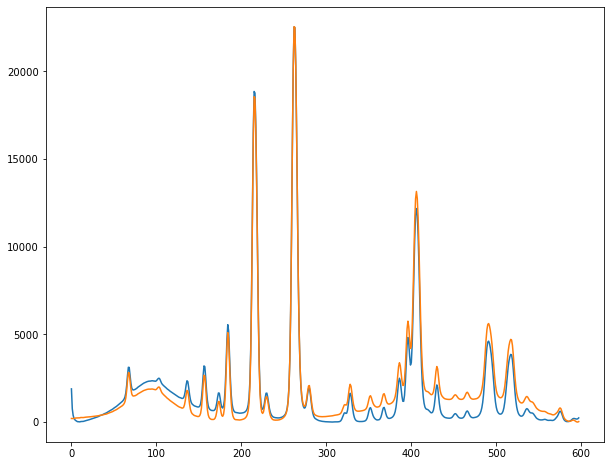

In [14]:
plt.plot(tmp_noise)
plt.plot(tmp)

# Add in fourier background subtraction, compare to Chebyshev

Use default stop condition

In [63]:
from importlib import reload
reload(hitp)

<module 'dataproc.operations.hitp' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/dataproc-1.0-py3.7.egg/dataproc/operations/hitp.py'>

In [53]:
patterns.shape

(60, 598)

In [385]:
reload(sep)

<module 'xrdc.source_separation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/source_separation.py'>

Mark1

Start here for full workflow

In [73]:
reload(sep)

<module 'xrdc.source_separation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/source_separation.py'>

In [9]:
from xrdc import source_separation as sep
slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns, background_after_filter=False,
                                                     smooth_q_background = 0, threshold = 25,
                                                    smooth_q = 1.7)

background = slow_q
# bg = sep.get_background(slow_T, threshold = 25, smooth_q = 1.7, bg_fill_method = 'simple',
#                                  smooth_q_background = 15)

(0, 0)


In [504]:
sep.iplot_rows(background)

interactive(children=(IntSlider(value=30, description='i', max=60), Output(layout=Layout(height='550px'))), _d…

In [211]:
%matplotlib notebook

<IPython.core.display.Javascript object>


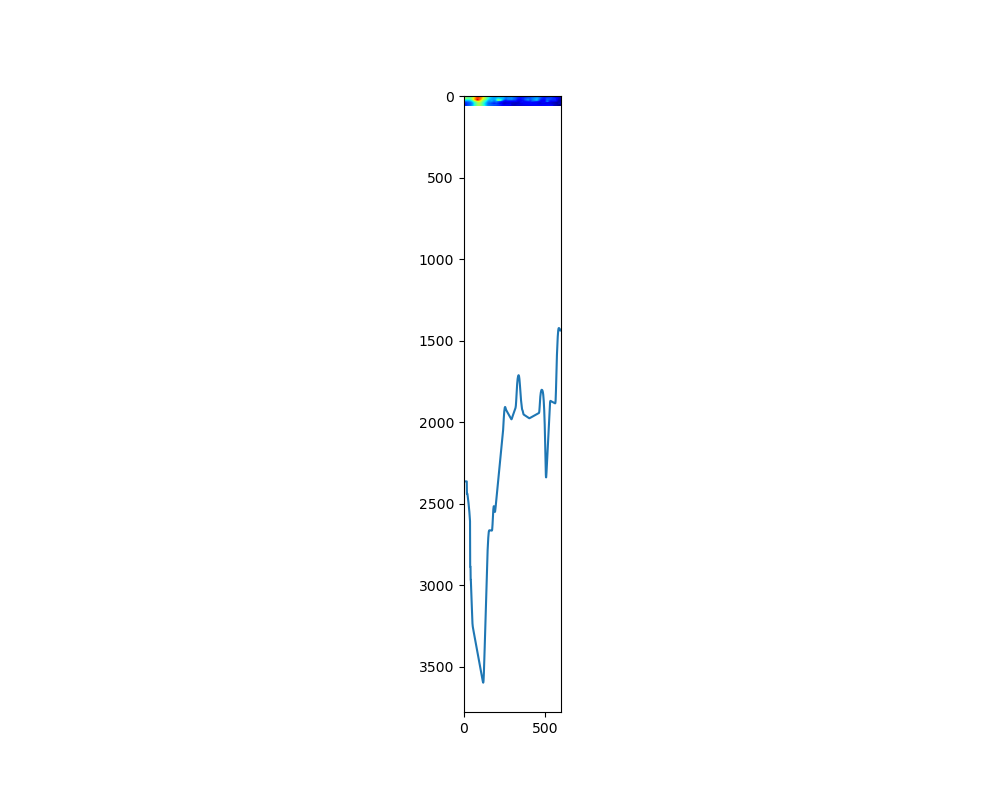

In [214]:
plt.imshow(background, cmap = 'jet')

delta q / q: around 0.01, cutoff == .2

In [223]:
patterns.shape

(60, 598)

<IPython.core.display.Javascript object>


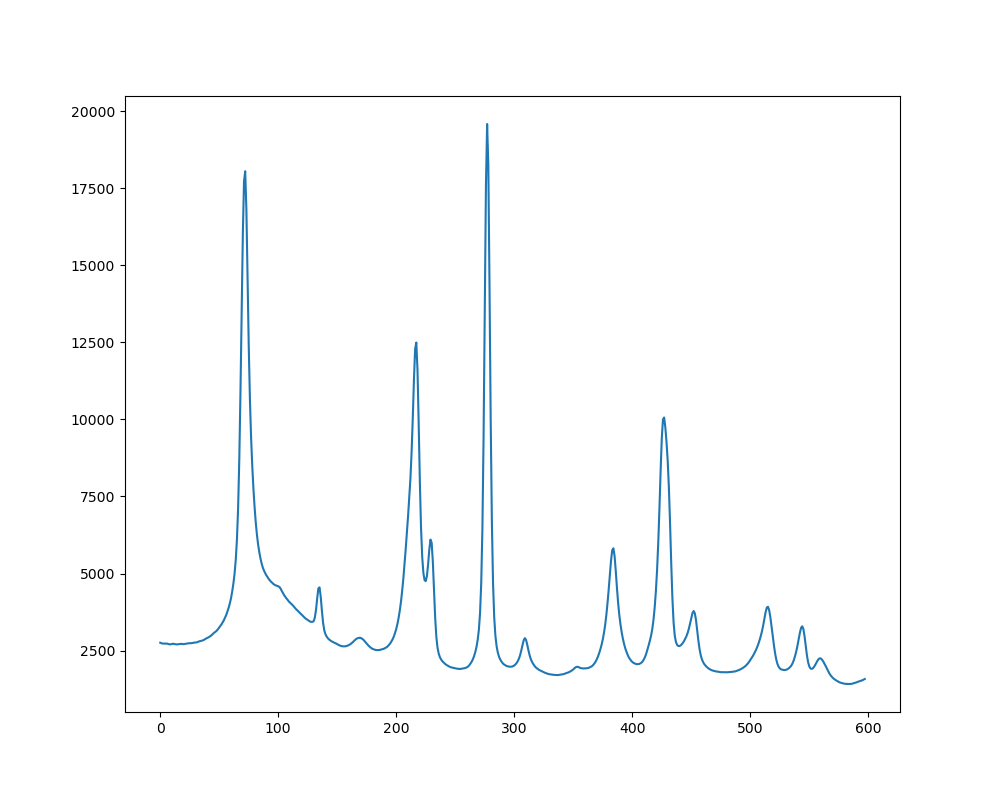

In [222]:
plt.plot(patterns[30])

In [212]:
plt.imshow(background, cmap = 'jet')

<IPython.core.display.Javascript object>

In [9]:
signal = slow_T - background

In [10]:
plt.imshow(signal)

Raw data:

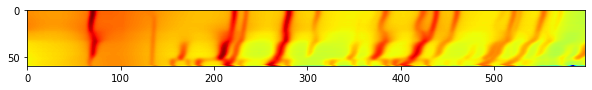

In [249]:
plt.imshow(np.log(1 + patterns - patterns.min()), cmap = 'jet')

Extracted peaks:

In [248]:
plt.imshow(np.log(1 + fast_q - fast_q.min()), cmap = 'jet')

Peak exclusion map with threshold == 25th percentile:

In [241]:
plt.imshow(np.log(.001 + sep.get_bgmask(patterns, 25)), cmap = 'jet', interpolation = 'none')

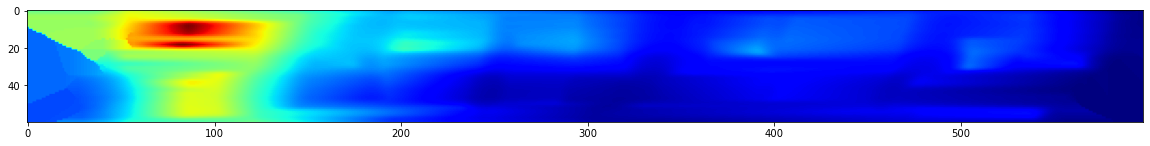

In [394]:
plt.imshow(background, cmap = 'jet')

In [200]:
plt.imshow(sep.get_background(patterns, threshold = 25, method='cloughtocher'), cmap = 'jet')

(2, 60, 598)
(2, 60, 598)


In [202]:
y_chebsub = fit_curves(patterns[i], downsample_int = 50)

numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 151., 189., 224., 255., 298., 339., 365., 405., 438.,
       477., 524., 551., 583., 597.])}
Peak at 73, start iteration with error = 0.9746976658181494
Peak at 73, iteration 0: error = 0.7632643049653883
Peak at 73, iteration 1: error = 0.28786401653171223
Peak at 73, iteration 2: error = 0.2836495505385252
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.3522892839538164
Peak at 135, iteration 0: error = 0.6356975531416189
Peak at 135, iteration 1: error = 0.02825465988502006
Peak at 135, iteration 2: error = 0.025922827919779984
    ----Saving data for block between 128.00 - 150.00
Peak at 170, start iteration with error = 0.27702391295418577
Peak at 170, iteration 0: error = 0.7165927381413776
Peak at 170, iteration 1: error = 0.0216082439181571

In [205]:
y_fsub = fit_curves(patterns[i], background = background[i])

numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 151., 189., 224., 255., 298., 339., 365., 405., 438.,
       477., 524., 551., 583., 597.])}
Peak at 73, start iteration with error = 2.2557912022718787
Peak at 73, iteration 0: error = 2.8251054570348244
Peak at 73, iteration 1: error = 0.9413973281888355
Peak at 73, iteration 2: error = 0.9413973292908348
    ----Saving data for block between 1.00 - 127.00
Peak at 136, start iteration with error = 0.6475416311150094
Peak at 136, iteration 0: error = 0.11733597048635004
Peak at 136, iteration 1: error = -0.6684159352874665
Peak at 136, iteration 2: error = -1.4072143919629334
    ----Saving data for block between 128.00 - 150.00
Peak at 170, start iteration with error = 1.2639816664070973
Peak at 170, iteration 0: error = -1.5352019854667773
Peak at 170, iteration 1: error = -0.2272234977887527

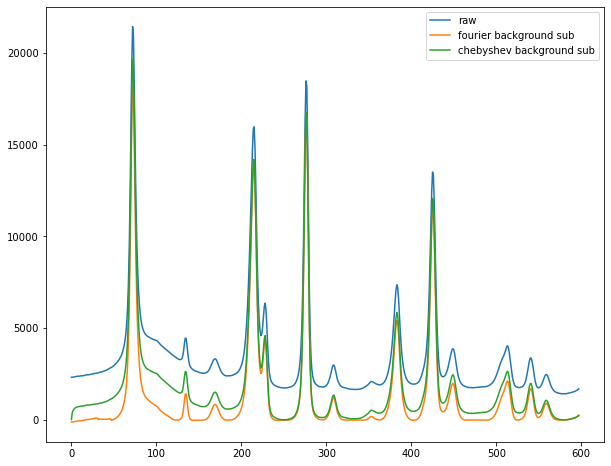

In [204]:
plt.plot(patterns[i], label = 'raw')
plt.plot(y_fsub, label = 'fourier background sub')
plt.plot(y_chebsub, label = 'chebyshev background sub')
plt.legend()

In [222]:
background[i]

array([2437.8668571 , 2437.8668571 , 2437.8668571 , 2437.8668571 ,
       2437.8668571 , 2437.8668571 , 2437.8668571 , 2437.8668571 ,
       2437.8668571 , 2437.8668571 , 2437.8668571 , 2437.8668571 ,
       2437.8668571 , 2437.8668571 , 2437.8668571 , 2437.8668571 ,
       2437.8668571 , 2437.8668571 , 2437.8668571 , 2437.8668571 ,
       2437.8668571 , 2437.8668571 , 2437.8668571 , 2437.8668571 ,
       2437.8668571 , 2437.8668571 , 2437.8668571 , 2437.8668571 ,
       2437.8668571 , 2447.58764304, 2457.45383819, 2467.53325923,
       2547.40016237, 2547.40016237, 2559.11517484, 2571.49106603,
       2584.83047422, 2599.37466381, 2615.27750857, 2632.51542532,
       2650.82885336, 2669.88540293, 2689.54795656, 2709.94965527,
       2731.26090727, 2753.33907069, 2775.67098244, 2888.69926423,
       2888.69926423, 2910.3514427 , 2931.04283183, 2949.91794161,
       2966.43140302, 2980.87221525, 2994.05676825, 3006.70838138,
       3019.20074904, 3031.65949873, 3044.1132218 , 3056.56641

# Put in stop condition

In [253]:
y_fsub_stop = fit_curves(patterns[i], background = background[i],
                         noise_estimate = fast_T.T[i], stdratio_threshold = 2)

numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 151., 189., 224., 255., 298., 339., 365., 405., 438.,
       477., 524., 551., 583., 597.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 73, start iteration with error = 0.9801843484918483
Peak at 73, iteration 0: error = 3.63321718291097
2.1610252173555535
Peak at 73, iteration 1: error = 0.3799127635112271
1.036314994127792
    ----Saving data for block between 1.00 - 127.00
Peak at 136, start iteration with error = 0.4486477954730887
Peak at 136, iteration 0: error = 0.5250500405974753
32.29733294251421
Peak at 136, iteration 1: error = 0.14171338093970287
12.035267824642911
Peak at 136, iteration 2: error = 0.13205790689479233
    ----Saving data for block between 128.00 - 150.00
Peak at 170, start iteration with error = 0.4564312106486672
Peak at 170, it

In [206]:
y_fsub_stop = fit_curves(patterns[i], background = background[i],
                         noise_estimate = fast_T.T[i], stdratio_threshold = 2)

numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 151., 189., 224., 255., 298., 339., 365., 405., 438.,
       477., 524., 551., 583., 597.])}
Peak at 73, start iteration with error = 2.2557912022718787
Peak at 73, iteration 0: error = 2.8251054570348244
2.2962954504819257
Peak at 73, iteration 1: error = 0.9413973281888355
1.036315107814895
    ----Saving data for block between 1.00 - 127.00
Peak at 136, start iteration with error = 0.6475416311150094
Peak at 136, iteration 0: error = 0.11733597048635004
17.79877005286934
Peak at 136, iteration 1: error = -0.6684159352874665
12.035267297298853
Peak at 136, iteration 2: error = -1.4072143919629334
    ----Saving data for block between 128.00 - 150.00
Peak at 170, start iteration with error = 1.2639816664070973
Peak at 170, iteration 0: error = -1.5352019854667773
0.8686290269342464
    ----Savi

## Peak fit examples

_block0peakAt_73.000.png _block1peakAt_136.000.png _block2peakAt_170.000.png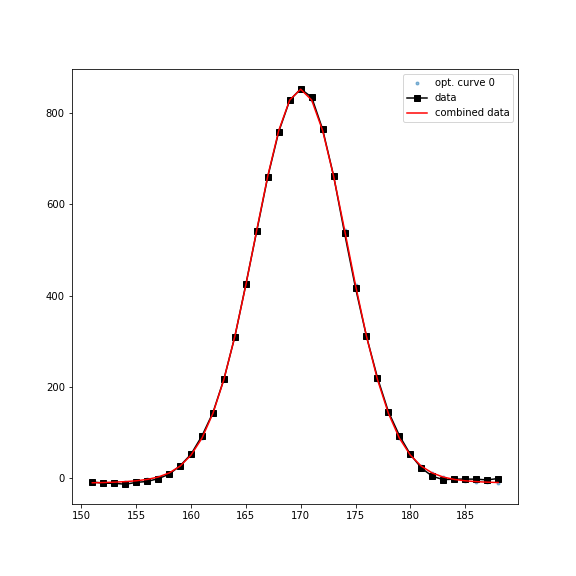

## Stop condition with Chebyshev subtraction 

The purpose of this comparison is to check the effect of background subtraction on the robustness of peak-finding.

In [258]:
y_fsub_stop_cheb = fit_curves(patterns[i], 
                         noise_estimate = fast_T.T[i], stdratio_threshold = 2)

numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
Experimental Info used: 

{'blockBounds': array([  0., 128., 151., 189., 224., 255., 298., 339., 365., 405., 438.,
       477., 524., 551., 583., 597.])}
Peak at 73, start iteration with error = 0.9477578430819944
Peak at 73, iteration 0: error = 5.419372690178083
17.148812836886528
Peak at 73, iteration 1: error = 5.46637398681453
17.147597525429006
Peak at 73, iteration 2: error = 5.466373617769352
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.0682417486363587
Peak at 135, iteration 0: error = 0.9314728913059315
1754.7502432231522
Peak at 135, iteration 1: error = 0.004943885222143594
14.017151778091094
Peak at 135, iteration 2: error = 0.0034453079664042803
    ----Saving data for block between 128.00 - 150.00
Peak at 170, start iteration with error = 0.04774299085962311
Peak at 170, iteration 0: error 

_block0peakAt_73.000.png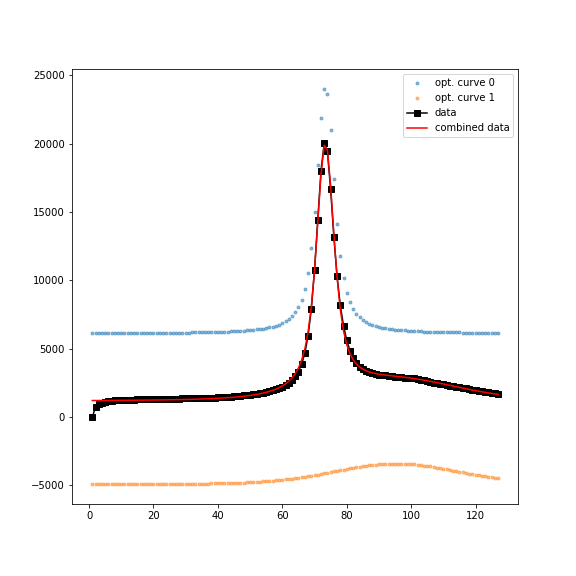 _block1peakAt_135.000.png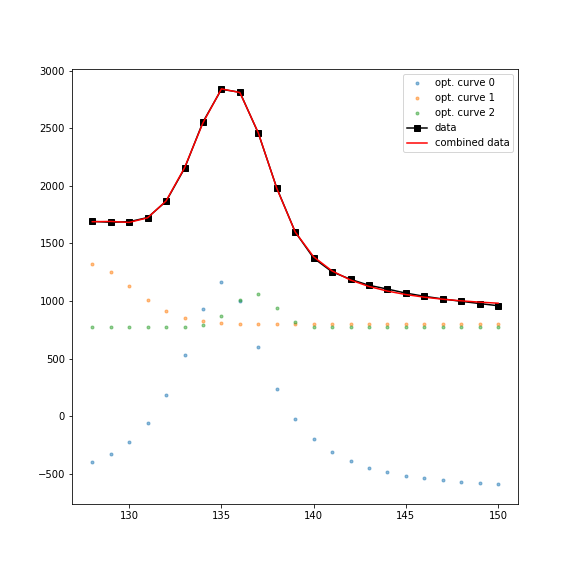 _block2peakAt_170.000.png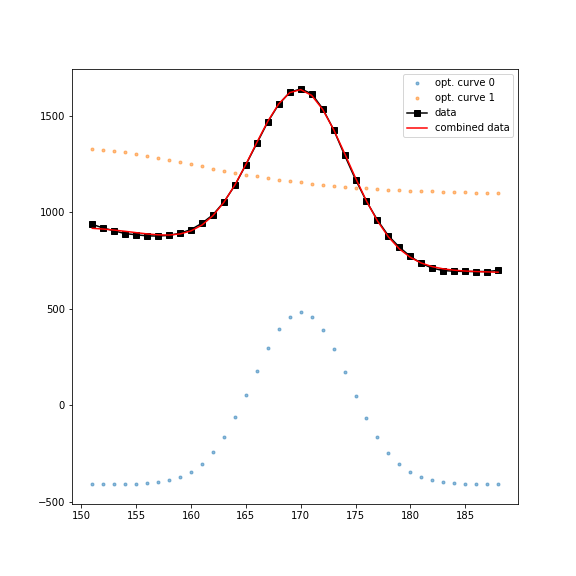

In [79]:
reload(pf)

workflows/alanConfig


<module 'xrdc.peak_fitting' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/peak_fitting.py'>

In [9]:
%matplotlib inline

In [484]:
reload(pf)

workflows/alanConfig


<module 'xrdc.peak_fitting' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/peak_fitting.py'>

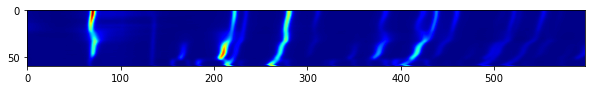

In [492]:
plt.imshow(patterns - background, cmap= 'jet')

In [496]:
sep.iplot_rows(patterns, background)

interactive(children=(IntSlider(value=30, description='i', max=60), Output(layout=Layout(height='550px'))), _d…

In [500]:
start, end = 23, 24

In [572]:
%pdb

Automatic pdb calling has been turned ON


In [587]:
reload(pf)

workflows/alanConfig


<module 'xrdc.peak_fitting' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/peak_fitting.py'>

In [600]:
bk1, bk2 = fsub_stop_2d, fsub_stop_2d_bg

In [13]:
# fsub_stop_2d = pf.curvefit_2d((patterns - 0)[start:end],stdratio_threshold = 3, noise_estimate = fast_T[start:end],
#                    background = background[start:end],
#                              bg_shift_pos = False)
fsub_stop_2d = pf.curvefit_2d(patterns, stdratio_threshold = 2, noise_estimate = fast_T,
                   background = background,
                             bg_shift_pos = False)

numBlocks: 358, dataPts/Block: 1.670391061452514
[  0.  35. 127. 183. 230. 263. 297. 342. 408. 430. 448. 501. 512. 539.
 567. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  35., 127., 183., 230., 263., 297., 342., 408., 430., 448.,
       501., 512., 539., 567., 597.])}
Peak at 1, start iteration with error = 0.6710509788129796
Peak at 1, iteration 0: error = 4.213501556989029
0.03640849345049248
    ----Saving data for block between 1.00 - 34.00
[-0.6499999999999483, 7.831876650748784, 4603.731316248259, 5.8675588769427955, 1.3177418361459678]
Peak at 71, start iteration with error = 0.8901906147181539
Peak at 71, iteration 0: error = 118.90341678282857
0.4196019982809258
    ----Saving data for block between 35.00 - 126.00
[71.32464543651531, 1046.1233453106906, 195365.51899908076, 1.966551984036778, 0.6264884348500621]
Peak at 132, start iteration with error = 0.6480869423524039
Peak at 132, iteration 0: error = 1.4669353555086622
0.05860449434274294
    ----Sav

Peak at 461, start iteration with error = 0.8230076298214657
Peak at 461, iteration 0: error = 5.97826982715526
2.7446947928039944
Peak at 461, iteration 1: error = 3.9295552308394592
0.9560138586083712
    ----Saving data for block between 448.00 - 500.00
[461.4671015414179, -1220.5688016446777, 30695.921689796818, 2.032210261133523, 0.8758929376458504, 445.46362093366344, 1203.230636884014, 9590.95851630082, 9.932050879552186, 0.1220806449085493]
Peak at 510, start iteration with error = 0.8662338594268986
Peak at 510, iteration 0: error = 0.41297727219067293
0.4399019609240447
    ----Saving data for block between 501.00 - 510.00
[510.4348288610967, -23.10044950727919, 3940.023322600956, 2.2499999999999996, 1.403321946325033]
Peak at 523, start iteration with error = 0.8737619390069858
Peak at 523, iteration 0: error = 0.5114239167000917
6.965686558359145
Peak at 523, iteration 1: error = 0.3671828476718236
4.373003558900225
Peak at 523, iteration 2: error = 0.2637376389838449
    -

Peak at 461, start iteration with error = 0.6695067414959543
Peak at 461, iteration 0: error = 21.79490134373055
25.80590601794083
Peak at 461, iteration 1: error = 7.168548126403413
7.504704793016533
Peak at 461, iteration 2: error = 8.61643546713365
    ----Saving data for block between 448.00 - 487.00
[461.3270729268558, -935.0919474073668, 27021.21507331867, 2.1728625569473317, 1.0113325920997536, 446.05000000000007, 2095.8869426283145, 8339.272885391565, 8.712264664144968, 7.918052661607684e-17, 461.4757493126601, -1189.038593094191, 3933.0364322944592, 1.8957796607713455, 3.884450126557743e-06]
Peak at 510, start iteration with error = 0.4395818584325155
Peak at 510, iteration 0: error = 0.5371458715188439
1.6305538788655645
    ----Saving data for block between 488.00 - 513.00
[510.61246072061374, -0.7293228967859189, 3338.206700644695, 3.405121570714603, 6.08821523415087e-19]
Peak at 523, start iteration with error = 0.8820005134736058
Peak at 523, iteration 0: error = 0.482356

    ----Saving data for block between 431.00 - 447.00
[439.2057953330308, 3522.475073961925, 39605.292831666164, 2.2273100311172374, 0.13181414862625723, 432.2084949533187, -2165.0796029641206, 8807.945235471134, 3.978845231830446, 3.976221595888438, 430.8224418264966, -832.727584440824, 267.6099268906924, 0.06539805896654674, 0.08037522806461027]
Peak at 461, start iteration with error = 0.7684127020496454
Peak at 461, iteration 0: error = 3.962998450353737
29.940766886241693
Peak at 461, iteration 1: error = 1.3342572936828745
8.915747981015203
Peak at 461, iteration 2: error = 1.6177312946968598
    ----Saving data for block between 448.00 - 487.00
[461.1837178380625, -1059.685987792091, 16555.73283744401, 2.803147644746218, 1.3058643177606561, 446.05000000000007, 2006.2651483165941, 8213.95060449785, 8.440176868415959, 8.06798550810001e-13, 461.2896403038523, -963.3054087484154, 13745.378730197272, 2.1543973276398325, 8.403620241736068e-05]
Peak at 510, start iteration with error =

Peak at 461, start iteration with error = 0.7680120215362563
Peak at 461, iteration 0: error = 6.3348506596685565
16.219483230780355
Peak at 461, iteration 1: error = 5.765926776247355
5.929705018325656
Peak at 461, iteration 2: error = 6.212950427702155
    ----Saving data for block between 448.00 - 499.00
[461.1362441766478, -15.881319060310616, 31431.7855407516, 1.9399731879454603, 1.0761643832073648, 445.45000000023765, -67.19811137962927, 10198.400428037368, 9.371134378724841, 2.993372036635638e-07, 492.73535518964354, -23.3790482716363, 5199.750475241656, 12.749909967953014, 10.970388288945227]
Peak at 510, start iteration with error = 0.8581613452057819
Peak at 510, iteration 0: error = 0.5923835880200706
2.9947497495780127
Peak at 510, iteration 1: error = 0.7502760019820286
2.245115609620532
Peak at 510, iteration 2: error = 0.04801103850024722


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 500.00 - 510.00
[509.66186051046594, -32.50703778613312, 3950.6652085676706, 2.4999973426976725, 1.3975501255222702, 507.4774428829379, 0.002808361930606792, 11.923091132153733, 0.3553889825012566, 5.662072597434899e-07, 499.50000000000006, 0.04064978438201235, 50.97152735676349, 2.1230897425939386, 6.423811846864564e-27]
Peak at 522, start iteration with error = 0.9156714074316604
Peak at 522, iteration 0: error = 8.844303039855765
45.427657579146235
Peak at 522, iteration 1: error = 1.3341301091138509
23.689881093232415
Peak at 522, iteration 2: error = 1.210022209225714
    ----Saving data for block between 511.00 - 543.00
[522.2864939627301, -216.62283534474813, 18498.45462287935, 1.7822386353980102, 1.522359161414966, 528.7847861624901, 796.7463206113288, 6318.714261361936, 1.5433691138600956, 1.8740547231458864, 509.42442286043445, -634.0001153293834, 3473.416661928408, 3.9376376438162226, 1.017643327193873e-18]
Peak at 554, start iteration w

    ----Saving data for block between 447.00 - 499.00
[460.71896725388814, -1181.7450507399296, 8532.93153961481, 4.929218183763229, 0.00013047800459253404, 444.40000167217147, 573.5876753489053, 9441.926559023259, 8.345639014225187, 0.0005121321011549292, 460.9763114465699, 607.8050178154288, 19579.92712613825, 2.2927702839131876, 0.07997074531321471]
Peak at 509, start iteration with error = 0.8564209516082345
Peak at 509, iteration 0: error = 0.411642005264402
0.8421038308964813
    ----Saving data for block between 500.00 - 509.00
[509.0556862983876, -30.485935776810674, 3838.841989235229, 2.249999999999999, 1.5843570924170636]
Peak at 522, start iteration with error = 0.8477410459919474
Peak at 522, iteration 0: error = 0.42825963880186213
45.80254764212647
Peak at 522, iteration 1: error = 0.2635668956905179
24.340291477392036
Peak at 522, iteration 2: error = 0.16654868843577
    ----Saving data for block between 510.00 - 537.00
[522.0852416978527, 1212.1321432062286, 18072.5743

Peak at 439, iteration 1: error = 0.08543810606888545
15.558157529086756
Peak at 439, iteration 2: error = 0.05765296993573426
    ----Saving data for block between 429.00 - 446.00
[438.81205861672606, -2103.296238079243, 44772.481468587, 1.9525512065214, 0.6908253150281894, 428.15000000000003, -1101.8547959952868, 8302.716109236431, 2.204141887934626e-09, 2.389978185959442, 436.2812220055866, 3509.9311010029933, 2626.897122382642, 1.1933629093751843, 4.248793833595237]
Peak at 461, start iteration with error = 0.5351139995346775
Peak at 461, iteration 0: error = 19.983490171222684
30.495158425957374
Peak at 461, iteration 1: error = 10.808136636403486
10.412140806637696
Peak at 461, iteration 2: error = 12.36169449326406
    ----Saving data for block between 447.00 - 498.00
[460.4360271317989, -926.9385251032803, 8577.880605083443, 4.983417233220361, 0.0006069948605494009, 444.45059384800663, 1475.1045047640598, 9048.41291121966, 7.891130265007006, 0.002090786017807081, 460.7621062970

    ----Saving data for block between 407.00 - 428.00
[423.6094914073336, -903.3144757532389, 30500.538128400858, 2.8445643217772267, 1.3656864031256273, 429.0496576356279, 1812.0133960266617, 2204.752710549419, 2.02286019930886, 0.10743364030061979, 422.3182346506623, -976.2085082374776, 3191.185495784379, 2.0644463497796295, 1.3570191877642343e-05]
Peak at 439, start iteration with error = 0.5948503464162809
Peak at 439, iteration 0: error = 0.32576575916322753
32.936367143263745
Peak at 439, iteration 1: error = 0.062830818060203
9.804532277050873
Peak at 439, iteration 2: error = 0.07885277142737296
    ----Saving data for block between 429.00 - 450.00
[438.6500215382555, -1629.8631236723957, 39740.97277643436, 1.9741086450581344, 0.5692057742154917, 427.95000000000005, 3533.579738897178, 8195.227999124278, 0.00017574823985241897, 2.6554512069770633, 438.1841523972209, -1577.8197353192886, 6065.575195434773, 2.846494141218335, 1.5439968991323432]
Peak at 461, start iteration with e

    ----Saving data for block between 406.00 - 428.00
[424.1822690683989, 21.8424617861719, 24901.42564655327, 4.344190450625788, 1.1835968287606733, 428.3021443355492, -627.7037300200003, 60.741245993793704, 0.23434851735358803, 1.3726527892380494e-32, 422.19626119674666, 567.9553876986122, 10012.589367441833, 2.4527617020573826, 1.5416660929119563e-34]
Peak at 438, start iteration with error = 0.6002018167336983
Peak at 438, iteration 0: error = 0.3718990471807972
52.46014721066849
Peak at 438, iteration 1: error = 0.1124453162233163
17.237144239865636
Peak at 438, iteration 2: error = 0.0633562551634459
    ----Saving data for block between 429.00 - 446.00
[438.43681855195524, 777.074983658193, 44256.151834268276, 1.9427346634298523, 0.7217910071007001, 436.03632517910773, 1425.615165399756, 2403.089838127068, 2.370433672691403, 3.8772462793088383, 428.15000614689, -1867.2799311904914, 5952.609405553278, 3.799496701208601e-09, 2.441925334188891]
Peak at 460, start iteration with err

    ----Saving data for block between 430.00 - 446.00
[438.0774736940997, 98.71990876727018, 39679.11828195311, 1.817512535088078, 1.0507839233716054, 429.20000000000005, 394.5319505309688, 3816.004891238668, 2.4528770872399683e-05, 2.4553015105348615, 438.75064717862097, -172.77750726236388, 6845.340176255248, 2.038868516715768, 0.06621094347900301]
Peak at 460, start iteration with error = 0.4973334919700962
Peak at 460, iteration 0: error = 20.48765439613649
14.337094861947822
Peak at 460, iteration 1: error = 13.522446187721465
5.33984751454315
Peak at 460, iteration 2: error = 15.33563050884938
    ----Saving data for block between 447.00 - 496.00
[459.8933075218118, -668.0411298981876, 24016.336913177365, 2.0322053546519716, 0.9937420344233814, 444.77619624435204, -258.1466533274721, 9669.425982874427, 9.465867279503016, 3.546127487835549e-34, 460.9799573095524, 905.507890307748, 2734.1062341651477, 2.318263403564621, 0.22543343313490516]
Peak at 507, start iteration with error =

Peak at 460, iteration 2: error = 2.7440987860221018
    ----Saving data for block between 447.00 - 496.00
[459.7256399548581, -490.9554416127308, 26486.34733687633, 2.0942127798290384, 0.9642061838174938, 444.55000000000007, 353.2283698143999, 9068.998185905271, 8.099198246476258, 1.1905423654617985e-29, 454.2382057429291, 122.1166304554684, 266.01048984041097, 2.0810459387187112, 2.941775824757583e-22]
Peak at 506, start iteration with error = 0.7928453973742537
Peak at 506, iteration 0: error = 0.2062331387061363
0.8979703697262598
    ----Saving data for block between 497.00 - 507.00
[506.1430735907876, -23.926853704557306, 3407.456011373101, 2.4999999999999996, 1.5816475284436518]
Peak at 521, start iteration with error = 0.763103852943639
Peak at 521, iteration 0: error = 0.2623597414789703
30.788878732195325
Peak at 521, iteration 1: error = 0.19100432971754813
17.330034117920583
Peak at 521, iteration 2: error = 0.16497027735475106
    ----Saving data for block between 508.00 -

    ----Saving data for block between 428.00 - 445.00
[437.7675377486945, 1241.5882186542403, 36948.15957670934, 2.036632575996688, 0.4637126815718028, 427.1508515650289, -1768.1622094168026, 6422.529233416071, 0.01076490375118486, 2.8886272814323353, 437.31206279565527, 994.3304257914594, 5547.169529770745, 4.165992906374765, 0.08115930515614192]
Peak at 459, start iteration with error = 0.8094553600935346
Peak at 459, iteration 0: error = 4.938179751239756
19.60071840765073
Peak at 459, iteration 1: error = 3.1275103828216078
6.752524008722959
Peak at 459, iteration 2: error = 3.6294874731452715
    ----Saving data for block between 446.00 - 495.00
[459.3539337906281, -769.5597188009272, 24257.40718673187, 1.9889752711574098, 1.1188183536890577, 443.5511038795436, 704.0707616708161, 11166.757708424733, 9.24815424880594, 1.7030540312266363e-27, 460.5966752467366, 47.83929517665686, 1626.7639306401118, 2.325119188338079, 0.14073868405182627]
Peak at 506, start iteration with error = 0.

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 496.00 - 510.00
[505.6629614263961, 12.104892912432403, 2391.92725175619, 3.475341024839245, 8.039588529207567e-21, 510.69996081364735, 73.51402450948987, 760.5442941587822, 0.9356909518537944, 1.7745291591042769, 504.28164782266697, -86.63342161243638, 60.76292152448891, 1.673911715055011, 2.2111120951141117e-07]
Peak at 521, start iteration with error = 0.8609475233726408
Peak at 521, iteration 0: error = 0.9123203794544178
26.202437583605818
Peak at 521, iteration 1: error = 0.4029586063417809
16.36204813076786
Peak at 521, iteration 2: error = 0.8583823787600031
    ----Saving data for block between 511.00 - 540.00
[509.55000000000103, 367.3426481105023, 2027.9127133051522, 8.802837085168151e-10, 4.075338011860685, 526.9369208939604, -569.6602961679603, 5567.421122162444, 1.9404943455184196, 1.6062084967462058, 520.4452188678447, 160.2449882050358, 16746.60344714667, 2.0055488108560953, 1.3802382522153696]
Peak at 552, start iteration with erro

    ----Saving data for block between 450.00 - 495.00
[459.14106913234235, -635.919919529523, 20389.29418498052, 2.3270507474030255, 0.4107040774851192, 451.4938350673448, -869.1017734782789, 7368.023446193628, 7.668110973324971, 5.3983039486257294e-33, 463.77361735033776, 1499.2903498297703, 886.9212899754742, 3.0941956700392437, 7.436555237259732e-35]
Peak at 505, start iteration with error = 0.8763563450502729
Peak at 505, iteration 0: error = 0.224607336027898
0.4235670999957919
    ----Saving data for block between 496.00 - 505.00
[504.8076651318549, -26.473012795318983, 3104.2961566346594, 2.2499999999999964, 1.7890267288126558]
Peak at 520, start iteration with error = 0.9214785010345109
Peak at 520, iteration 0: error = 3.359972232371839
25.409136874735996
Peak at 520, iteration 1: error = 1.3555083816678482
15.051346838927225
Peak at 520, iteration 2: error = 0.5413863921496895
    ----Saving data for block between 506.00 - 540.00
[520.104143452683, -133.20427445083516, 16468.

Peak at 459, start iteration with error = 0.5071547951779698
Peak at 459, iteration 0: error = 22.477592746127236
19.40845500466879
Peak at 459, iteration 1: error = 14.417323112421167
7.256561628784335
Peak at 459, iteration 2: error = 16.61176115659835
    ----Saving data for block between 446.00 - 494.00
[458.7382776003911, -269.90488515474203, 20775.84397052585, 2.011833784248421, 1.0725394593828108, 443.6151969740427, 746.9411601707311, 11384.8349041059, 9.582548245809413, 6.155702937781118e-14, 459.827470402823, -496.4040299503153, 2474.293540106613, 2.4393447568049815, 0.2224060317472283]
Peak at 505, start iteration with error = 0.7111114232335821
Peak at 505, iteration 0: error = 2.0009239844554183
1.9158915020055267
    ----Saving data for block between 495.00 - 505.00
[504.37219376670384, -16.639831848947104, 2334.0491261529814, 2.4999999999999996, 1.0613002935307572]
Peak at 520, start iteration with error = 0.7675012637356915
Peak at 520, iteration 0: error = 0.27785447418

    ----Saving data for block between 404.00 - 425.00
[420.87468954003685, -760.883738032044, 27761.510483424277, 3.0999901056590846, 1.8897873217707688, 426.04999366378746, 1420.8033464928124, 1874.7545151065754, 1.9694449762042932, 0.021458739035785858, 418.9895297382707, -734.9102849406869, 3633.287593658448, 2.2180476401079035, 0.00013134092990960114]
Peak at 437, start iteration with error = 0.5693525338582728
Peak at 437, iteration 0: error = 0.4012572147643314
36.30577227145116
Peak at 437, iteration 1: error = 0.06862324278110878
5.683383717338571
Peak at 437, iteration 2: error = 0.05416037281051524
    ----Saving data for block between 426.00 - 445.00
[436.94024490218686, -1447.9567008547629, 37202.03402392213, 2.0520118851586795, 0.49073800705836323, 425.05025181952493, 3884.604438757976, 10034.715675496505, 4.557337860647455e-06, 3.402474675936061, 436.31952354794504, -1975.050792487849, 5193.210359776, 4.745279149007985, 0.3098007977244625]
Peak at 459, start iteration wit

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 495.00 - 505.00
[503.8016435599451, 90.4335555973127, 1867.6641526328322, 2.4999999999999996, 1.0032918983179542, 495.1985478939943, -56.7493452447467, 34.8310575899998, 1.1891799474210911, 1.7444154634305496e-33, 504.99877267053563, -56.749345752739686, 1.4444906031174816, 0.0011963984317490816, 0.025214996488165126]
Peak at 520, start iteration with error = 0.8887438458711269
Peak at 520, iteration 0: error = 5.028772919928466
27.28924398256533
Peak at 520, iteration 1: error = 1.2690465285796975
17.872425990069303
Peak at 520, iteration 2: error = 2.2314979238633628
    ----Saving data for block between 506.00 - 539.00
[519.7493153870249, -506.9096313668714, 15761.988531644995, 1.317615406612905, 2.0591232763701304, 526.0697777254134, 395.3332213953228, 3081.7458321850777, 2.5708463939817094, 4.183062492071954e-34, 517.5644187172454, 120.25184045171878, 880.9525120632479, 1.5934532966209016, 1.6824691197783086e-28]
Peak at 551, start iteration w

Peak at 458, start iteration with error = 0.5747170342140714
Peak at 458, iteration 0: error = 16.988376444833357
23.796600491974356
Peak at 458, iteration 1: error = 12.74067280433428
9.391255953552202
Peak at 458, iteration 2: error = 14.866292918839042
    ----Saving data for block between 446.00 - 493.00
[458.22850187687186, -816.2280715850048, 12325.90925345781, 2.3436580036216714, 4.67857379093081e-19, 443.65000000000003, -139.95771288725618, 10199.144093655406, 7.585409870008777, 3.3025971771078636e-28, 458.01781015739846, 955.792902367502, 8060.821421278298, 4.986090618175217, 2.230628677955479e-35]
Peak at 519, start iteration with error = 0.8633440588835362
Peak at 519, iteration 0: error = 3.5225427270425174
29.51355506784818
Peak at 519, iteration 1: error = 2.8406046410257475
17.830077839233503
Peak at 519, iteration 2: error = 2.8406046432795624
    ----Saving data for block between 494.00 - 539.00
[519.1258275191335, -394.9191461354106, 13250.51782839463, 2.2570991816652

Peak at 458, iteration 2: error = 1.5905171998054008
    ----Saving data for block between 449.00 - 493.00
[457.8893193910822, -777.1047955016707, 19030.929517127588, 2.1121152788097426, 0.9189215780079137, 449.1652838642818, 509.0584886491904, 3977.1580192370106, 4.251956740051647, 9.122672569596756e-37, 458.11908275291114, 265.4580563593425, 1647.0837661726782, 4.678526232083322, 8.468081299668025e-36]
Peak at 519, start iteration with error = 0.8014524350997526
Peak at 519, iteration 0: error = 0.4813131072931977
12.77000492489523
Peak at 519, iteration 1: error = 0.6011051190340684
8.54983949810015
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 519, iteration 2: error = 0.5152683238397644
    ----Saving data for block between 494.00 - 533.00
[518.825469533718, 200.8860185735693, 12528.630702546236, 2.4033835762754956, 0.7472043538806835, 525.2168106456944, -482.4043327018651, 3285.281636002788, 2.42274638906323, 8.352301200838192e-08, 

    ----Saving data for block between 449.00 - 493.00
[457.642544757516, -670.5927011782294, 21685.03641057866, 1.837524262395961, 1.4602321076890163, 446.80000000384814, -730.8669979608782, 7131.154588651231, 6.122212925274335, 6.291836606392312e-06, 487.5242017536818, 1285.2747710025983, 5264.35084496703, 10.999994740133971, 10.991692275560776]
Peak at 519, start iteration with error = 0.8858251137619223
Peak at 519, iteration 0: error = 1.937899747825096
18.74949746143636
Peak at 519, iteration 1: error = 2.587202567829597
12.775327645833194
Peak at 519, iteration 2: error = 3.1168006034492772
    ----Saving data for block between 494.00 - 532.00
[518.5334833995485, 7.038062805174651, 12751.229302052127, 2.2540635324506457, 1.02593079711677, 524.9908355685064, -0.42504996985994237, 3288.325087670039, 2.551593692924912, 9.507024230952276e-33, 518.8528641227181, 30.86541569446472, 9.23784805842366, 0.00013747114056318117, 0.04098968558334479]
Peak at 550, start iteration with error = 

Peak at 518, start iteration with error = 0.8943508512738587
Peak at 518, iteration 0: error = 0.7788896733145731
26.278182735895644
Peak at 518, iteration 1: error = 2.009434967078373
13.53481476262403
Peak at 518, iteration 2: error = 2.037622645859024
    ----Saving data for block between 493.00 - 532.00
[518.2200092520955, -268.78724107623907, 12809.899792988255, 2.1905976191168306, 1.1879469610876434, 524.6895560928231, -445.3145451080685, 4183.339056114124, 2.054818218368619, 1.020433563718101, 502.67423831461264, 699.7562311776333, 580.0064421844218, 1.8294738554529173, 1.282498024092581]
Peak at 549, start iteration with error = 0.7577090395465648
Peak at 549, iteration 0: error = 6.616251761989268
15.08160078595388
Peak at 549, iteration 1: error = 2.8176677797701206
8.369699513396089
Peak at 549, iteration 2: error = 3.2793080980635043
    ----Saving data for block between 533.00 - 596.00
[549.332342415967, -487.8566270311288, 14686.254736999204, 2.2967962835397326, 1.0717377

    ----Saving data for block between 492.00 - 538.00
[517.9001517647356, -422.5365566867669, 11378.523637552496, 2.4350031031301627, 0.7882173860984149, 524.3181124458945, -74.1072910046261, 3869.5973268020703, 2.373563044743993, 0.5757918606839203, 540.2999957992739, 489.888944969438, 6.35832470064026e-07, 11.418383318983393, 11.499999992460669]
Peak at 549, start iteration with error = 0.6798225458364535
Peak at 549, iteration 0: error = 10.334225072474236
10.757221992659984
Peak at 549, iteration 1: error = 2.728909222157275
6.416430392871801
Peak at 549, iteration 2: error = 4.0520948139666
    ----Saving data for block between 539.00 - 596.00
[548.9967119765853, 789.2186301839262, 13983.364165136065, 2.316275767882594, 1.0178681188150844, 566.9399038964543, -494.46479057092546, 1416.836746607734, 2.234951011829304, 1.251718264023771, 557.0435783600155, -301.60028588669036, 1419.618123834613, 4.142622389161438, 3.3618498722272676e-06]
numBlocks: 392, dataPts/Block: 1.5255102040816

Peak at 549, start iteration with error = 0.8381740348787383
Peak at 549, iteration 0: error = 6.90368371678608
13.693726992670095
Peak at 549, iteration 1: error = 3.1619916811129993
7.578738153569253
Peak at 549, iteration 2: error = 3.1280500360836374
    ----Saving data for block between 533.00 - 596.00
[549.0716641369108, 32.88370433784733, 11737.72330177468, 1.945973629106754, 1.462751633882456, 561.1655116020291, -54.81651794274303, 3532.6415953237274, 9.866357162570548, 1.474892842850753e-11, 547.2989363325304, 7.844899924405152, 1951.9270427850936, 2.448722490300311, 1.0618515839633361e-31]
numBlocks: 388, dataPts/Block: 1.541237113402062
[  0.  32. 126. 185. 227. 260. 301. 347. 406. 425. 448. 491. 533. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  32., 126., 185., 227., 260., 301., 347., 406., 425., 448.,
       491., 533., 597.])}
Peak at 1, start iteration with error = 0.897424174383979
Peak at 1, iteration 0: error = 10.489427993126801
4.5890203303394

numBlocks: 391, dataPts/Block: 1.5294117647058822
[  0.  32. 126. 186. 225. 259. 296. 345. 407. 425. 444. 489. 533. 593.
 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  32., 126., 186., 225., 259., 296., 345., 407., 425., 444.,
       489., 533., 593., 597.])}
Peak at 1, start iteration with error = 0.8649893032679339
Peak at 1, iteration 0: error = 6.243284227269116
9.434636486294842
Peak at 1, iteration 1: error = 3.0824104239768775
5.934022471754341
Peak at 1, iteration 2: error = 2.374679683758558
    ----Saving data for block between 1.00 - 31.00
[12.419238737130406, 161.5435610796581, 3819.113701607414, 2.7330520339125153, 4.907070189659481, 19.585344329672985, -161.40069704222725, 528.7991545607158, 2.550193988452623, 2.3422289926965795e-29, -0.4999999913928332, -62.3369074573723, 17774.57809600487, 3.2125008310196526, 7.49999986480811]
Peak at 69, start iteration with error = 0.9633415376580663
Peak at 69, iteration 0: error = 23.06380691300643
25.325583242

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 386, dataPts/Block: 1.549222797927461
[  0.  31. 126. 187. 225. 259. 301. 345. 407. 426. 447. 488. 533. 591.
 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  31., 126., 187., 225., 259., 301., 345., 407., 426., 447.,
       488., 533., 591., 597.])}
Peak at 1, start iteration with error = 0.7584102294833391
Peak at 1, iteration 0: error = 2.4581589276816262
0.7739530160553386
    ----Saving data for block between 1.00 - 30.00
[-0.09856793852082388, -29.295426083653656, 12517.29677870069, 7.249999999999999, 7.249999999999999]
Peak at 70, start iteration with error = 0.9070313313047089
Peak at 70, iteration 0: error = 48.434280456885624
18.02440285773264
Peak at 70, iteration 1: error = 2.95097130522888
11.485600684464968
Peak at 70, iteration 2: error = 2.950952530672777
    ----Saving data for block between 31.00 - 125.00
[69.95680139012053, -207.98000883220863, 92074.72010005874, 2.6596871195605845, 1.134653649213706, 80.79946502735152, 5.510217553540318

Peak at 70, start iteration with error = 0.9060172668108879
Peak at 70, iteration 0: error = 40.666760373733496
23.559132986037792
Peak at 70, iteration 1: error = 37.779650612572375
23.502156138344684
Peak at 70, iteration 2: error = 4.3178783550363296
    ----Saving data for block between 30.00 - 128.00
[70.22750254415716, 5269.532723334191, 66369.13911143996, 3.0054158552840273, 0.3942446563834759, 91.97399367683464, -3030.9079948872227, 59951.409439682975, 12.943653126267211, 9.133968066544353, 74.67542171878078, -2416.310306241701, 77384.86171888956, 5.001647026082956, 5.1751017734820675]
Peak at 136, start iteration with error = 0.5142570919330778
Peak at 136, iteration 0: error = 4.419471681592977
5.923751259224229
Peak at 136, iteration 1: error = 5.9279992265973105
3.597922680857923
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 136, iteration 2: error = 6.009716220640036
Optimal parameters not found: The maximum number of functio

[0.7910421574041749, -1.152386709821848, 820.8687430321277, 3.4999999999999933, 0.17130716621865635]
Peak at 71, start iteration with error = 0.697012997027367
Peak at 71, iteration 0: error = 113.12480568320072
28.669292486739472
Peak at 71, iteration 1: error = 108.09895732607438
28.633687697250885
Peak at 71, iteration 2: error = 108.09380663040947
    ----Saving data for block between 16.00 - 128.00
[70.74244579211576, -2964.669149109221, 57979.68845794501, 3.2313087045398308, 0.0399320258214978, 74.10457681027019, -833.5229581299527, 58683.807342873384, 8.029128026615421, 0.20577985774152657, 90.10590943648204, 3790.256197385757, 57972.13463033087, 19.363873406911452, 4.06542093320648e-14]
Peak at 136, start iteration with error = 0.48400736826040214
Peak at 136, iteration 0: error = 5.976332972489456
4.579625486716641
Peak at 136, iteration 1: error = 8.211233680654214
2.7131275257432232
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at

    ----Saving data for block between 129.00 - 160.00
[136.0229058362904, -14.214305955180206, 2713.4685912434134, 1.9236181583605352, 8.04868488158011e-26, 129.01746773567749, 214.0616533116181, 730.9373759313387, 2.5741874772000934, 4.5968340700290507e-32, 135.8568311050321, -199.26141232366263, 4442.997202396115, 2.9140859414511224, 1.961576339915336e-31]
Peak at 168, start iteration with error = 0.6994145322085223
Peak at 168, iteration 0: error = 1.1494456712026475
2.2120272604694335
Peak at 168, iteration 1: error = 1.0968584296631116
1.3674482453064774
    ----Saving data for block between 161.00 - 186.00
[167.50922692359717, -14.78892030646427, 261.3926076637236, 2.6260083686537032, 1.291147015203149e-09, 171.4455086367329, 13.463359992807533, 342.4302632478369, 0.5062998155155981, 2.3582812095512318]
Peak at 219, start iteration with error = 0.9370836190762284
Peak at 219, iteration 0: error = 3.892664589679412
45.69173763878722
Peak at 219, iteration 1: error = 0.861669280390

    ----Saving data for block between 188.00 - 225.00
[218.9018979511344, 174.2733729503784, 83905.34387673248, 0.00019457976364046825, 3.572824113914843, 211.98668988053655, -542.0767849800857, 50667.60018599314, 4.141837349749824, 5.0337085328965, 186.15214485737482, 94.73582557281752, 6.076361914607457e-32, 0.035969937185861126, 9.036270444687862]
Peak at 231, start iteration with error = 0.5379280705235476
Peak at 231, iteration 0: error = 3.054200875583256
15.988137023343116
Peak at 231, iteration 1: error = 24.452420272850066
8.643130671694173
Peak at 231, iteration 2: error = 24.45241850497207
    ----Saving data for block between 226.00 - 258.00
[231.50136062955613, 210.3290854651754, 22503.06678353929, 2.06965513234293, 1.1516615263236734, 224.40040960969512, 601.9220789006278, 7765.844079654796, 2.0267583063105254, 7.615782817965627e-08, 227.69336833907758, -840.8312312992896, 5451.289374625784, 2.185582611749005, 4.661414728536486e-19]
Peak at 278, start iteration with error

Peak at 310, start iteration with error = 0.697996311296866
Peak at 310, iteration 0: error = 0.3313222533973983
1.1501281927113511
    ----Saving data for block between 299.00 - 341.00
[309.978902611583, -11.148555365473191, 9819.835831761517, 1.6614819754555603, 3.134952537892472]
Peak at 385, start iteration with error = 0.7639659912036323
Peak at 385, iteration 0: error = 1.4323783377406085
5.858669184065309
Peak at 385, iteration 1: error = 1.2992056760867772
5.196629114161364
Peak at 385, iteration 2: error = 1.2951761020069397
    ----Saving data for block between 342.00 - 406.00
[384.62940346145604, -780.4775924705149, 54371.700423972485, 2.6941266216424378e-05, 5.381925618581044, 349.37925948664036, 1413.5947892073293, 2094.2910566995997, 7.355235184910015, 6.957354354560043e-33, 379.5805485663407, -788.0831659229775, 2119.7407500467643, 4.354417201689872, 5.517341820340434e-34]
Peak at 427, start iteration with error = 0.8373506552200017
Peak at 427, iteration 0: error = 0.21

Peak at 354, start iteration with error = 0.43804732809655966
Peak at 354, iteration 0: error = 0.06962414471294522
0.14562951919509173
    ----Saving data for block between 341.00 - 355.00
[353.9759288517386, 0.0019060253809634452, 410.34035931044747, 2.14791161001096, 4.8073121566012196e-17]
Peak at 385, start iteration with error = 0.8970161397365863
Peak at 385, iteration 0: error = 2.469025710831297
4.073602417264009
Peak at 385, iteration 1: error = 1.6876221881103257
3.5556113514834293
Peak at 385, iteration 2: error = 2.4064588763097334
    ----Saving data for block between 356.00 - 406.00
[384.4717644241511, -194.32356172992468, 63146.586469048416, 1.3973209351099282e-05, 5.471424680147671, 354.3228103585354, -25.888018298288415, 1897.1510546586344, 4.867104856144556, 4.962462578697491e-32, 408.49999999999994, -42.75346527479608, 5505.196824580741, 12.425850965086742, 12.499999999999998]
Peak at 428, start iteration with error = 0.8286247758291467
Peak at 428, iteration 0: err

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 73, start iteration with error = 0.8385185744493845
Peak at 73, iteration 0: error = 24.078628248813622
25.63529140594503
Peak at 73, iteration 1: error = 7.740814512200503
21.553442549263135
Peak at 73, iteration 2: error = 7.740814547815788
    ----Saving data for block between 4.00 - 124.00
[72.74600645041674, 237.61256770042948, 137197.93344112925, 2.4013257968685418, 2.1915080779025207, 83.3468970976037, -158.5997647211028, 45226.06873725735, 12.57263843610133, 0.9312224323896086, 72.2000000067665, -118.62088033750165, 4.062234629650757e-29, 29.999999997, 29.999999997]
Peak at 136, start iteration with error = 0.48891333863164793
Peak at 136, iteration 0: error = 2.663598709716517
3.064161103356946
Peak at 136, iteration 1: error = 3.364766816760075
1.9599986592274383
    ----Saving data for block between 125.00 - 158.00
[135.6953796482075, -347.4531038972014, 6833.261850496181, 2.281992059260932, 0.014204878255756283, 130.60234196770878, 346.0444817481078, 430.39571718035

numBlocks: 402, dataPts/Block: 1.4875621890547264
[  0. 125. 159. 188. 225. 257. 298. 340. 356. 406. 441. 485. 531. 550.
 586. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 125., 159., 188., 225., 257., 298., 340., 356., 406., 441.,
       485., 531., 550., 586., 597.])}
Peak at 73, start iteration with error = 0.9363106959922018
Peak at 73, iteration 0: error = 8.444570296806159
17.90783004921304
Peak at 73, iteration 1: error = 7.951014677906823
17.89207114025282
Peak at 73, iteration 2: error = 7.950542248521557
    ----Saving data for block between 1.00 - 124.00
[72.77834724817535, 7714.941616495801, 88623.75076661352, 2.11966404343337, 1.4768172004164049, 86.02505903311132, -3946.1658273610283, 39956.211695152284, 16.860306347656664, 6.145500992177388e-10, 74.49444857918473, -3777.9088010416594, 52102.618639160995, 6.183908679198731, 0.053269807823633705]
Peak at 136, start iteration with error = 0.46058363928883556
Peak at 136, iteration 0: error = 3.49384817

    ----Saving data for block between 128.00 - 157.00
[137.55369220696784, 233.6680569970128, 680.3816751808894, 1.567238632241815, 1.7191152111183983e-36, 135.43708564454386, -216.30817624429858, 5574.588046574846, 2.0308330399403767, 6.25043049579601e-36, 132.86210538151911, -18.21739246198803, 755.8691392911468, 2.619266024604811, 1.8378637756922235e-34]
Peak at 170, start iteration with error = 0.7450132770961012
Peak at 170, iteration 0: error = 1.4492782880933757
0.3437458382690925
    ----Saving data for block between 158.00 - 188.00
[170.24391687389874, -8.583756447315235, 6167.292229266402, 5.173704749494075, 5.708754096425856e-17]
Peak at 217, start iteration with error = 0.9649410697361321
Peak at 217, iteration 0: error = 1.7492288497932604
5.781661009400946
Peak at 217, iteration 1: error = 11.294427446407433
3.9427537214014317
Peak at 217, iteration 2: error = 2.970259544155305
    ----Saving data for block between 189.00 - 222.00
[216.9348023678189, 3550.5218212381487, 1

Peak at 277, start iteration with error = 0.9129549897917915
Peak at 277, iteration 0: error = 2.313565500218906
1.3974130322554277
    ----Saving data for block between 255.00 - 297.00
[277.2156165572784, -137.3980272889737, 126226.88607906293, 2.253882443299037, 1.1913634310127181]
Peak at 310, start iteration with error = 0.5770261284679506
Peak at 310, iteration 0: error = 3.716053579275173
1.498089727357145
    ----Saving data for block between 298.00 - 338.00
[309.3763089604634, -18.12036843112083, 11848.638760725806, 3.02641956162142, 1.4550884694145052]
Peak at 354, start iteration with error = 0.6214894380327748
Peak at 354, iteration 0: error = 0.9757489701659807
0.5970944377669175
    ----Saving data for block between 339.00 - 364.00
[353.79106658401497, -0.09499135442999039, 1114.3261564890893, 2.499537735605175, 0.513646173731874]
Peak at 384, start iteration with error = 0.9318708374317721
Peak at 384, iteration 0: error = 0.9192846873836219
1.1253562800623076
    ----Sav

Peak at 512, start iteration with error = 0.6035688744315151
Peak at 512, iteration 0: error = 16.663993261348708
7.667366859665484
Peak at 512, iteration 1: error = 34.343391112395324
4.720972195778939
Peak at 512, iteration 2: error = 34.343390589405004
    ----Saving data for block between 474.00 - 527.00
[513.6248011323651, -493.15417433583957, 8832.434815839315, 3.376857173487794, 0.2130578420204057, 507.4889249124323, -466.8220024469989, 20077.81882623198, 6.116830292897677, 0.5760382708209182, 476.5575845060687, 928.3005535976696, 1135.0921484399869, 3.568611863254837, 12.405443626350317]
Peak at 540, start iteration with error = 0.8414806681853748
Peak at 540, iteration 0: error = 0.14875165116779662
0.8079406982534811
    ----Saving data for block between 528.00 - 546.00
[539.7713284971097, -40.0403999255819, 16961.614707440403, 3.172319438926139, 1.6263305555186667]
Peak at 559, start iteration with error = 0.7098139782168776
Peak at 559, iteration 0: error = 3.93536273290793

Peak at 135, start iteration with error = 0.5787143054096832
Peak at 135, iteration 0: error = 1.10950518605979
2.42464324146583
Peak at 135, iteration 1: error = 4.114559630522141
1.6757589514022662
    ----Saving data for block between 128.00 - 149.00
[131.0585317110596, -350.51672946988606, 119.28089573632137, 1.3252565180676261, 1.2046983460782692e-27, 135.36303440453668, 348.3043658692274, 6974.597978546204, 2.291890257531521, 7.995855622198534e-09]
Peak at 169, start iteration with error = 0.5741988373654511
Peak at 169, iteration 0: error = 3.511545689208487
0.9640900033741436
    ----Saving data for block between 150.00 - 187.00
[169.11267265357088, -22.23865630573983, 18469.252670680235, 3.6297968536155536, 0.6601108779162097]
Peak at 213, start iteration with error = 0.7860198278589627
Peak at 213, iteration 0: error = 12.770099356388963
1.8529037441905063
    ----Saving data for block between 188.00 - 220.00
[213.2231191569763, -329.641981236458, 201178.65881028713, 2.439935

Peak at 274, start iteration with error = 0.7654783613379113
Peak at 274, iteration 0: error = 0.40882169472386154
1.8703506231097802
    ----Saving data for block between 253.00 - 295.00
[274.1003699544473, -89.03333245114038, 108711.9138382981, 2.549261647289456, 0.9573017026459315]
Peak at 306, start iteration with error = 0.5550326919490829
Peak at 306, iteration 0: error = 0.38649212103163255
1.1462191464404066
    ----Saving data for block between 296.00 - 335.00
[306.4486240144041, 7.465016348917831, 8009.16060140011, 3.1446840428171514, 0.5859783226985817]
Peak at 353, start iteration with error = 0.7292686116802074
Peak at 353, iteration 0: error = 0.27039376326562065
1.2486845192238778
    ----Saving data for block between 336.00 - 362.00
[352.74389986927935, -31.343889696920353, 9913.441649296947, 2.6775434371886777, 2.652808001649538]
Peak at 380, start iteration with error = 0.874398712629452
Peak at 380, iteration 0: error = 0.38782599108251237
3.0685510994596914
Peak at 

[352.17649173474507, 227.95350159833254, 7093.884826541453, 4.575948755554371, 1.1234703835825594e-09, 352.82479295881006, -227.172086646402, 1036.8019003500033, 2.496529505399963, 2.4336575567017763e-12]
Peak at 380, start iteration with error = 0.8813913369075307
Peak at 380, iteration 0: error = 0.7441465008135415
3.428763457745558
Peak at 380, iteration 1: error = 0.5357995132580833
2.6195116208095923
Peak at 380, iteration 2: error = 0.7342457509294117
    ----Saving data for block between 359.00 - 400.00
[379.9034899342261, -1105.3282539889642, 68464.28567220904, 3.070245375153094, 1.1762811430266962, 375.18492986700335, -1006.382548942327, 10253.854603860358, 2.3018333967871865, 2.452573471934442, 356.99198307476746, 2002.0749586580987, 2454.221787232602, 7.317748827982257e-08, 2.6422638388862048]
Peak at 421, start iteration with error = 0.897319602331722
Peak at 421, iteration 0: error = 0.29988866320398366
2.759930354294957
Peak at 421, iteration 1: error = 1.027915879617796


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
[596.599920635342, -173.4139275937301, 487.3562654158694, 0.00013506961911812008, 0.5568184228972511, 584.2055028402882, -175.84441138144882, 290.91438284012406, 1.9774128703736047, 9.646235114814186e-34, 596.2635025913352, 271.15590401588923, 6188.784287381008, 0.00012441734382230592, 2.9951845354223368]
numBlocks: 409, dataPts/Block: 1.4621026894865525
[  0. 128. 156. 187. 219. 254. 289. 328. 363. 400. 434. 468. 487. 519.
 544. 572. 584. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 128., 156., 187., 219., 254., 289., 328., 363., 400., 434.,
       468., 487., 519., 544., 572., 584., 597.])}
Peak at 72, start iteration with error = 0.4761925439831644
Peak at 72, iteration 0: error = 7.003758289355002
5.994009501538029
Peak at 72, iteration 1: error = 7.9366177267411855
5.315763976484321
Peak at 72, iteration 2: error = 12.043836201925409
    ----Saving data for block between 1.00 - 127.00
[71.94139909741634, -

    ----Saving data for block between 544.00 - 571.00
[553.8237823165032, 156.06720341999738, 6990.651563972786, 4.220228093074909, 2.38129812203748e-13, 543.0994791829849, -158.98132668498806, 1016.7443575431698, 6.74999999996038, 3.625877527585032e-11]
Peak at 583, start iteration with error = 0.5143251117948395
Peak at 583, iteration 0: error = 0.3982512556916666
1.1481323349281574
    ----Saving data for block between 572.00 - 583.00
[583.5499999999992, -2.5696298500612413, 253.4597697535901, 2.749999999990716, 2.62729702251336]
Peak at 596, start iteration with error = 0.6808374232006413
Peak at 596, iteration 0: error = 5.169284107870447
17.344692820270147
Peak at 596, iteration 1: error = 3.625071180445098
15.041149480797273
Peak at 596, iteration 2: error = 2.9814225256869356


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
[596.5999999999999, -38.37466833194407, 2257.9814805523015, 8.388032807450887e-07, 1.5034674198421871, 583.4000000000001, -13.351500752899351, 769.0156822483256, 8.36260265471579e-06, 2.9999999999999996, 596.5864817628908, -14.21275052815404, 4308.535961905403, 2.9999999999999996, 0.8500035933485277]
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0. 128. 156. 187. 219. 254. 288. 326. 358. 400. 433. 468. 483. 523.
 544. 572. 588. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 128., 156., 187., 219., 254., 288., 326., 358., 400., 433.,
       468., 483., 523., 544., 572., 588., 597.])}
Peak at 72, start iteration with error = 0.6422684459109858
Peak at 72, iteration 0: error = 3.7508339028135076
6.076416947052683
Peak at 72, iteration 1: error = 8.083039820100227
3.997078523721309
Peak at 72, iteration 2: error = 8.279208132542145
    ----Saving data for block between 1.00 - 127.00
[71.80700972168978, -240.71

Peak at 581, start iteration with error = 0.5863276068797874
Peak at 581, iteration 0: error = 1.403203951774666
2.4748075341281734
Peak at 581, iteration 1: error = 1.2249462949624954
2.1903968976530854
Peak at 581, iteration 2: error = 1.2324217871067336
    ----Saving data for block between 572.00 - 587.00
[580.1432601490654, 16.01097053346628, 217.63068403144527, 2.5013597397271083, 1.4528805126126736e-33, 574.5266846765404, -9.41651505533718, 17.73088557437458, 0.2956340347796036, 1.2961960744054054e-32, 583.2400183930296, -7.833746051597902, 34.99847089213434, 0.9239157286759596, 2.517149382524105e-32]
Peak at 596, start iteration with error = 0.7652802256735813
Peak at 596, iteration 0: error = 2.314989181529817
23.26046156983942
Peak at 596, iteration 1: error = 2.1937609399063995
19.086215450858873
Peak at 596, iteration 2: error = 2.564163246255572


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
[595.9931729065281, -41.59965776977246, 4123.177453469838, 1.9999856942992906, 0.2799595684136603, 592.2251145732848, 15.708773004562111, 263.74210755183856, 1.3074460005995143, 1.0622558744778524e-32, 595.9991879018916, 15.00960291594545, 12.944938380761043, 0.015759334945708133, 0.014971548049248563]
numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 125. 156. 188. 219. 254. 295. 330. 362. 399. 430. 468. 483. 519.
 543. 572. 585. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 125., 156., 188., 219., 254., 295., 330., 362., 399., 430.,
       468., 483., 519., 543., 572., 585., 597.])}
Peak at 72, start iteration with error = 0.44070863600938603
Peak at 72, iteration 0: error = 7.549592429121839
19.49601575600454
Peak at 72, iteration 1: error = 12.909381511308364
13.223831406733229
Peak at 72, iteration 2: error = 13.860395346453435
    ----Saving data for block between 1.00 - 124.00
[71.70098153788076, 51

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 468.00 - 482.00
[478.8031828977918, -48.56139722509664, 5152.9282520851175, 3.4999837634506212, 2.4632146786655302, 477.79638117206326, -61.400122395220215, 26.882951087470765, 1.3493403373507638, 1.0086141560045334e-31, 467.5874844425363, -50.508882988766956, 1111.10636316262, 3.138795932411972, 1.25748745240474]
Peak at 501, start iteration with error = 0.7985273502905528
Peak at 501, iteration 0: error = 0.6290444928563983
66.09054976321785
Peak at 501, iteration 1: error = 0.9514817416643763
33.997885012524385
Peak at 501, iteration 2: error = 0.4163665786015809
    ----Saving data for block between 483.00 - 518.00
[500.35536733322016, 939.586793565274, 22064.72713340783, 4.396866616061801, 0.09202536811240683, 507.2298272035577, -262.9030272047362, 15263.878325148968, 2.629784161373598, 1.0980940996101898, 483.3151852452895, -637.3419725107944, 54.58358586113628, 0.3574670349270632, 1.2368658879049052e-34]
Peak at 533, start iteration with err

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 572.00 - 584.00
[578.7723952649451, -1.5202472275739558, 493.963105300662, 9.162290612071752e-07, 1.7320856144857915, 582.074746677292, -18.648234223797797, 317.6982997087928, 2.103840986033733, 0.1112943437999414, 572.4631209887558, -13.631806052848669, 239.3656665008176, 1.6490092462252706, 2.0865597887885357]
Peak at 596, start iteration with error = 0.49792537418873306
Peak at 596, iteration 0: error = 11.206071398593869
11.259438272096792
Peak at 596, iteration 1: error = 11.638911477101233
9.801162615740282
Peak at 596, iteration 2: error = 12.19354224976788


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
[596.3193066422363, 249.47814566774395, 6643.725277907293, 0.9874558855804247, 1.395209401193984, 593.2984872376286, -5.876574232221353, 360.7138497652438, 1.2886249548590505, 2.943763545474938e-19, 595.9994337389677, -288.20963920671807, 1.1609166184088429, 0.009399535877137336, 0.005109528471941698]
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0.  88. 125. 156. 188. 219. 254. 295. 330. 358. 399. 430. 468. 483.
 519. 540. 571. 585. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  88., 125., 156., 188., 219., 254., 295., 330., 358., 399.,
       430., 468., 483., 519., 540., 571., 585., 597.])}
Peak at 72, start iteration with error = 0.3734326904472866
Peak at 72, iteration 0: error = 12.11519555183898
8.383118472868391
Peak at 72, iteration 1: error = 15.380688377654412
7.388640830383805
Peak at 72, iteration 2: error = 17.75091197998449
    ----Saving data for block between 1.00 - 87.00
[71.597533974966

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 468.00 - 482.00
[478.1189894304764, -66.86939483557121, 5101.339471901492, 2.5111186601218303, 3.1296315637144256, 482.67801394018323, 25.03986171222952, 827.6892363820332, 3.499999350654343, 3.4999806447514428, 467.9593374404229, -77.85624516576175, 274.3936695909776, 2.025801615105616, 2.2394104975809223e-33]
Peak at 500, start iteration with error = 0.7499636178212746
Peak at 500, iteration 0: error = 0.7102284704957559
78.62749923720067
Peak at 500, iteration 1: error = 0.8755438663268701
39.759941752386545
Peak at 500, iteration 2: error = 0.4591337603547905
    ----Saving data for block between 483.00 - 518.00
[499.8349906265147, 1262.0490281161453, 21819.462052324936, 4.0694832246081285, 0.24856585907126377, 506.73062274788685, -654.4108271025216, 15613.441698005947, 2.72318480580777, 0.9001826825232292, 482.73747471245423, -544.1020201456793, 153.7662573483624, 0.13772912493398382, 8.349078924737008e-23]
Peak at 533, start iteration with er

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 571.00 - 584.00
[578.6927335915852, 59.02302658807866, 342.0976004243912, 1.473655284037726, 4.332109255029201e-24, 581.5480815812427, -34.423684325742016, 251.1694294858161, 1.559005214265553, 2.4915840439640337e-26, 578.9926501506721, -25.67335813407202, 7.589971918441784, 0.1687310722400571, 2.747799110335652e-15]
Peak at 596, start iteration with error = 0.49797034761625864
Peak at 596, iteration 0: error = 12.79519318253782
16.4486065044932
Peak at 596, iteration 1: error = 13.650096566032062
14.21029569106266
Peak at 596, iteration 2: error = 5.010187580877489


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
[596.5499999999998, -32.9512252960436, 6973.280318621751, 0.7504617091997863, 1.371913317733528, 594.23305915203, -158.32693818181102, 1669.8053083939367, 2.1687647417625526, 1.075135848903535e-22, 585.7395988572928, 34.31129812318827, 1642.4542014557132, 2.7499999999999996, 2.7499999999999996]
numBlocks: 405, dataPts/Block: 1.4765432098765432
[  0.  87. 125. 156. 188. 218. 254. 295. 327. 358. 399. 429. 468. 487.
 514. 543. 571. 584. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  87., 125., 156., 188., 218., 254., 295., 327., 358., 399.,
       429., 468., 487., 514., 543., 571., 584., 597.])}
Peak at 72, start iteration with error = 0.3454322804683922
Peak at 72, iteration 0: error = 13.35646395454507
5.003127661633338
Peak at 72, iteration 1: error = 16.134794936641544
4.407622067323039
Peak at 72, iteration 2: error = 17.830246533880402
    ----Saving data for block between 1.00 - 86.00
[71.5105113152273, 127

Peak at 579, iteration 0: error = 4.697814076898872
2.5077247125856834
Peak at 579, iteration 1: error = 5.404809758805054
1.4166678775650683
    ----Saving data for block between 571.00 - 583.00
[578.7946539852536, -46.21032757931007, 482.53674766751533, 1.4624604040126783, 1.1825526336921336e-17, 581.248277447804, 45.034231771096024, 338.1209785880171, 1.7366845816282783, 9.346574034457735e-14]
Peak at 596, start iteration with error = 0.4596531629964524
Peak at 596, iteration 0: error = 15.985281370348169
3.4219497790881435
Peak at 596, iteration 1: error = 16.904655878101753
2.9762273482927037
Peak at 596, iteration 2: error = 6.0925450586399625


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
[596.5999090799245, -68.93374740811883, 6683.1370776720105, 1.3804356001457059, 0.582151674087396, 593.7755206243169, -1.0630252676827923, 1519.9297825202473, 1.76378763121208, 1.371441035453067e-26, 585.3077656293094, -8.421652742539376, 952.424604834756, 2.9999999999999996, 2.9999999999999996]
numBlocks: 413, dataPts/Block: 1.4479418886198547
[  0.  87. 125. 156. 189. 218. 253. 295. 328. 362. 398. 432. 467. 482.
 522. 542. 571. 587. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  87., 125., 156., 189., 218., 253., 295., 328., 362., 398.,
       432., 467., 482., 522., 542., 571., 587., 597.])}
Peak at 71, start iteration with error = 0.8998770884463928
Peak at 71, iteration 0: error = 2.0909896732623556
1.96493179410438
    ----Saving data for block between 1.00 - 86.00
[71.43438887834124, -12.592918328717783, 95335.09790115122, 2.142019766370507, 0.7966739982792503]
Peak at 87, start iteration with error = 0.7

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 587.00 - 596.00
[595.8195418376872, -155.78266756039093, 5886.346818458914, 1.9467233480237665, 6.674954412739777e-27, 592.5442340504363, 51.05765628743253, 546.2806571628637, 1.2511162462778354, 2.310421598919938e-33, 595.9972766755178, 101.84874951221056, 13.311085713546586, 0.01647878574425549, 0.0025288389898060447]
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  85. 124. 156. 188. 218. 253. 295. 327. 362. 398. 429. 467. 486.
 513. 542. 570. 584. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  85., 124., 156., 188., 218., 253., 295., 327., 362., 398.,
       429., 467., 486., 513., 542., 570., 584., 597.])}
Peak at 71, start iteration with error = 0.35106786770164233
Peak at 71, iteration 0: error = 10.663056258972993
1.3788985124357385
    ----Saving data for block between 1.00 - 84.00
[71.3260360469151, -22.34434105402776, 91172.09364680546, 2.140089897815947, 0.7316219700206003]
Peak at 85, start iteration with e

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
[596.2432069942936, 625.2133288847407, 8780.789626220936, 2.309645363159513, 1.5003631277635822e-34, 596.0000252760832, -349.084599957085, 27.15378373988927, 0.07387515664699286, 9.34171889391408e-07, 592.6110474329208, -279.1772871906985, 597.0441271954792, 1.4266202074314107, 3.7330942259180515e-35]
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  84. 124. 156. 189. 218. 252. 288. 326. 361. 397. 428. 466. 481.
 517. 541. 569. 586. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  84., 124., 156., 189., 218., 252., 288., 326., 361., 397.,
       428., 466., 481., 517., 541., 569., 586., 597.])}
Peak at 71, start iteration with error = 0.42177024708377553
Peak at 71, iteration 0: error = 8.257784326043696
0.7899858906859702
    ----Saving data for block between 1.00 - 83.00
[71.17693861252366, -19.625037322373643, 84141.63298359289, 2.1720512316836094, 0.625055710853777]
Peak at 84, start iteration with err

Peak at 83, start iteration with error = 0.5598638385496528
Peak at 83, iteration 0: error = 0.9361951331635475
0.8590245349211543
    ----Saving data for block between 83.00 - 123.00
[89.77491168950894, -2.8566185597845624, 820.7730338996696, 9.999999999999998, 4.264383101352979]
Peak at 135, start iteration with error = 0.5178799037847683
Peak at 135, iteration 0: error = 1.4152947978275185
0.771891111997823
    ----Saving data for block between 124.00 - 149.00
[134.78969746700207, -6.850881295356557, 6800.27828091949, 2.1911328054226056, 0.23636224589280122]
Peak at 167, start iteration with error = 0.5848381923356103
Peak at 167, iteration 0: error = 3.219579989437256
0.32118588841568163
    ----Saving data for block between 150.00 - 188.00
[167.06938495493523, -25.624749838714383, 35277.00753621478, 2.5656035360792058, 0.44377634297290736]
Peak at 210, start iteration with error = 0.8126204747760288
Peak at 210, iteration 0: error = 3.340218246607258
1.037347552688845
    ----Savi

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 568.00 - 582.00
[579.6609755729036, -79.88945936170532, 2619.6024784048677, 2.844604550605347, 7.061701678314815e-05, 574.972199667056, -79.88999686308242, 3387.6201050238565, 0.9750418013350853, 2.8174905379020756, 567.3001129862744, -79.89064181551161, 2332.7759448589945, 3.4948274670211266, 2.3145620215226756]
Peak at 596, start iteration with error = 0.6375792206920659
Peak at 596, iteration 0: error = 6.343963693297831
0.8857876449259497
    ----Saving data for block between 583.00 - 596.00
[596.0899925331573, -36.8322240576777, 17946.918438283858, 3.2499999999999996, 0.368548538933211]
numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0.  82. 124. 150. 190. 217. 252. 288. 323. 356. 394. 427. 464. 480.
 516. 540. 567. 584. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  82., 124., 150., 190., 217., 252., 288., 323., 356., 394.,
       427., 464., 480., 516., 540., 567., 584., 597.])}
Peak at 71, start iteration with erro

Peak at 92, start iteration with error = 0.9387395042829245
Peak at 92, iteration 0: error = 0.3352787233402708
1.6177102640443464
    ----Saving data for block between 81.00 - 123.00
[93.8776852715751, -31.99456307356724, 6935.873492861859, 10.499999999999043, 9.873298137999742]
Peak at 135, start iteration with error = 0.8259644769301354
Peak at 135, iteration 0: error = 0.6402562328836278
1.6522683877400375
    ----Saving data for block between 124.00 - 148.00
[134.69102864230467, -7.736754210102936, 7008.114231747628, 2.1245982307683042, 0.4098668168236471]
Peak at 166, start iteration with error = 0.6321929067755929
Peak at 166, iteration 0: error = 3.3566967811806703
0.3535933697910831
    ----Saving data for block between 149.00 - 187.00
[166.0651898804065, -19.77755356629061, 39992.07462093311, 2.591210670282612, 0.345274863252802]
Peak at 209, start iteration with error = 0.934020323475358
Peak at 209, iteration 0: error = 0.4655565895210945
0.4711761240464329
    ----Saving d

Peak at 222, start iteration with error = 0.49719151236330084
Peak at 222, iteration 0: error = 14.030788003726348
2.1044419930183773
Peak at 222, iteration 1: error = 28.35593776539481
1.1136020121609005
    ----Saving data for block between 216.00 - 249.00
[221.6994439149622, 928.9046622330218, 32674.735028029885, 2.688861626763189, 0.2675245023134503, 214.35000000000753, -953.6109535482966, 11982.37351141581, 1.7053708584731445e-11, 2.727232937305492]
Peak at 269, start iteration with error = 0.6845767490951498
Peak at 269, iteration 0: error = 6.837769145788687
0.699579898829454
    ----Saving data for block between 250.00 - 294.00
[269.11789070349715, -85.62678197777558, 99839.88740009021, 2.610243015245628, 0.9418612237958968]
Peak at 301, start iteration with error = 0.4027044197602076
Peak at 301, iteration 0: error = 0.9020750505203287
0.23176008548683913
    ----Saving data for block between 295.00 - 318.00
[301.052242849051, -1.0730798995668738, 844.4494813629669, 2.42571730

Peak at 300, start iteration with error = 0.37773601090332065
Peak at 300, iteration 0: error = 0.44456188471124125
0.24319892285426226
    ----Saving data for block between 295.00 - 314.00
[300.2821640138173, -0.47185272631519143, 274.6100580563947, 2.026227875473677, 2.0793499944667274e-20]
Peak at 347, start iteration with error = 0.7124975836217846
Peak at 347, iteration 0: error = 2.219685487391241
0.5030693044578304
    ----Saving data for block between 315.00 - 353.00
[346.71321989203705, 0.25148326177817826, 13117.750787396199, 2.654939995083753, 0.6748098571068853]
Peak at 373, start iteration with error = 0.8247442106096005
Peak at 373, iteration 0: error = 0.38282679043714923
0.6369434698059032
    ----Saving data for block between 354.00 - 385.00
[372.73755064789265, -30.64706079229349, 58747.397294376206, 2.0587447630809677, 1.7942714599588248]
Peak at 413, start iteration with error = 0.6342623626291565
Peak at 413, iteration 0: error = 0.30642270300218094
1.5417215344831

Peak at 268, start iteration with error = 0.5891547636820663
Peak at 268, iteration 0: error = 16.773122204507555
2.002835374412005
Peak at 268, iteration 1: error = 25.021733848804885
1.2461831720276375
    ----Saving data for block between 249.00 - 312.00
[268.27771575293224, -3089.888367759463, 111366.12693738836, 2.589495232287226, 1.4967273116381468, 278.82429868644937, 2995.4514604389133, 4176.060910963591, 3.8548753878579687, 1.705359160363498e-08]
Peak at 329, start iteration with error = 0.7596412464865058
Peak at 329, iteration 0: error = 1.3087914062307315
0.2612348123931434
    ----Saving data for block between 313.00 - 332.00
[329.0062002415601, -30.01863124778352, 4904.704732101524, 0.5094991904628107, 4.749999999999999]
Peak at 347, start iteration with error = 0.6546918209675501
Peak at 347, iteration 0: error = 0.2740273911139564
3.029557570169
Peak at 347, iteration 1: error = 0.13741168415657082
1.428519708691238
    ----Saving data for block between 333.00 - 353.00


Peak at 268, start iteration with error = 0.8590933440243637
Peak at 268, iteration 0: error = 1.9325114382580173
2.5220607736534877
Peak at 268, iteration 1: error = 4.1455875673441
1.4076209532701178
    ----Saving data for block between 249.00 - 311.00
[267.60922348876045, 2891.1391636172307, 113040.71017651778, 3.2039996002225313, 1.2634261666961106, 278.5427781074342, -2953.469859310616, 10065.014709618235, 3.4731784395554133, 0.7464769744385161]
Peak at 329, start iteration with error = 0.8497769236050463
Peak at 329, iteration 0: error = 0.21202219574441503
1.4478176611104088
    ----Saving data for block between 312.00 - 334.00
[328.6486451975351, -73.35257013347554, 15204.039755902264, 0.6439851774790717, 5.499999999999998]
Peak at 347, start iteration with error = 0.615837649699596
Peak at 347, iteration 0: error = 0.32297161436044863
5.31574493989535
Peak at 347, iteration 1: error = 0.14108065400677514
2.107460967866853
Peak at 347, iteration 2: error = 0.06481526414706391


Peak at 185, start iteration with error = 0.7703304959779868
Peak at 185, iteration 0: error = 0.32977513826499716
1.6847467087754062
    ----Saving data for block between 176.00 - 194.00
[184.9485499583044, 285.8011677902589, 27206.685688883776, 3.032165521666197, 5.783384471620225e-20]
Peak at 214, start iteration with error = 0.8656329529266843
Peak at 214, iteration 0: error = 1.9763323566830917
3.2304867165778046
Peak at 214, iteration 1: error = 1.7212519772500656
1.9220934398683873
    ----Saving data for block between 195.00 - 247.00
[214.22880298788795, 2339.4967792085554, 115045.20715856896, 2.6532784868948545, 2.863862565059376, 219.8219309241895, -2375.4795995173645, 32231.687287839974, 2.1850921013854703, 0.5308882303007317]
Peak at 266, start iteration with error = 0.8070867537006883
Peak at 266, iteration 0: error = 8.588534866170594
4.165181220407024
Peak at 266, iteration 1: error = 28.22711519735326
2.154157263243046
Peak at 266, iteration 2: error = 34.45041431349488

Peak at 157, start iteration with error = 0.5773243341553638
Peak at 157, iteration 0: error = 9.575974680511901
0.9594459097097476
    ----Saving data for block between 147.00 - 165.00
[156.6709066473093, -23.22071329241195, 14619.206678836481, 2.487913947926092, 4.620347835126208e-21]
Peak at 173, start iteration with error = 0.6899062535768696
Peak at 173, iteration 0: error = 4.765575557067425
0.4025877540585389
    ----Saving data for block between 166.00 - 175.00
[173.16475885276813, -22.16044988727595, 5196.5629299610355, 2.179285688950633, 1.0031761644364352e-19]
Peak at 184, start iteration with error = 0.7614566883232503
Peak at 184, iteration 0: error = 0.31639936886727754
2.436767659096546
Peak at 184, iteration 1: error = 0.21640877295196806
1.0163807833429552
    ----Saving data for block between 176.00 - 194.00
[183.90468169148747, 914.9433973932604, 22469.004211876636, 2.4134943788964742, 7.104853575211074e-19, 186.56050872657696, -728.4561594592099, 9798.550245025752, 

Peak at 134, start iteration with error = 0.47147099723126223
Peak at 134, iteration 0: error = 4.537381576423018
4.711417459839263
Peak at 134, iteration 1: error = 7.224670130540051
2.949714314826983
Peak at 134, iteration 2: error = 4.882174522359326
    ----Saving data for block between 124.00 - 142.00
[133.85721248217376, -23.35066453989211, 3685.837907106722, 1.9820168498098487, 1.768513966949806e-33, 135.65682385647727, -62.56165058589508, 1036.9856427362508, 1.4726541517157048, 1.8547815430456007e-33, 125.32176473731943, 80.24748773997001, 27.495956381495965, 1.920475210749329, 5.0422786042674e-11]
Peak at 156, start iteration with error = 0.49908062028254374
Peak at 156, iteration 0: error = 11.234128641406102
3.23520111391328
Peak at 156, iteration 1: error = 25.81389370696956
1.9597450656531321
    ----Saving data for block between 143.00 - 162.00
[155.5699138734029, 536.7470654559066, 7975.460527373255, 1.936580455146722, 1.3749280240880718e-34, 157.661905939943, -545.83755

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 464, start iteration with error = 0.69723188272308
Peak at 464, iteration 0: error = 4.054166332510407
3.7231754403134296
Peak at 464, iteration 1: error = 2.5137993231558005
2.559431647646971
Peak at 464, iteration 2: error = 0.8196152105851959
    ----Saving data for block between 454.00 - 474.00
[463.45100206634834, -50.97015939501259, 1166.7856776436613, 2.1880245483630008, 1.1350911096018538e-11, 453.0383081078393, -45.90600249841693, 363.5839085683271, 1.7107329323423024, 3.0080712808509456e-18, 465.9159146847442, 94.34751932085068, 918.3271317642044, 2.2871314286012865, 1.6736507262691105e-17]
Peak at 493, start iteration with error = 0.8855318920532528
Peak at 493, iteration 0: error = 1.1343423147780745
0.5839313908579574
    ----Saving data for block between 475.00 - 504.00
[492.6182443965655, 8.135880320805056, 31189.833841833235, 4.697769691319962, 1.1571236822618238e-19]
Peak at 518, start iteration with error = 0.9138752798409623
Peak at 518, iteration 0: error = 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 163.00 - 175.00
[171.588110036748, 109.65574369974976, 781.6681339357763, 1.4487507970335367, 3.0745487164440423e-24, 173.6242376237869, -269.00590927871275, 4620.933508210543, 2.0162053505018624, 4.8485019425117945e-21, 164.8438458794769, 67.86830692343538, 1294.0665439437025, 2.9999999999999996, 2.999999999941847]
Peak at 184, start iteration with error = 0.7611528757621523
Peak at 184, iteration 0: error = 4.356301931907918
1.3435655959975048
    ----Saving data for block between 176.00 - 199.00
[183.92429569701252, -39.67919321344583, 33952.73939999119, 2.1037576785473524, 0.7521420975594938]
Peak at 215, start iteration with error = 0.9521530931816824
Peak at 215, iteration 0: error = 2.1390709217741453
3.5705866067280563
Peak at 215, iteration 1: error = 12.503398567819909
2.103266994862647
Peak at 215, iteration 2: error = 16.522476746732654
    ----Saving data for block between 200.00 - 223.00
[214.52168988615063, -2977.1024940523716, 94885

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 359.00 - 369.00
[366.686154496376, 331.374964409998, 4134.771459985156, 2.422738714517647, 0.4078302324468166, 365.9660693930711, -100.33619571522352, 252.57356611250043, 1.5008706997338432, 0.0004021002277837189, 358.50000000000006, -194.0453420746134, 9.327837664164804, 2.4999999999999996, 2.4999999999999996]
Peak at 385, start iteration with error = 0.5444184006101883
Peak at 385, iteration 0: error = 0.42560898967042304
9.560803325365487
Peak at 385, iteration 1: error = 0.06297007990651679
1.3807729908725828
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 370.00 - 386.00
[385.13296642311957, 11.49723048987573, 17230.00139120964, 3.0296321468354095, 0.7242966668135022, 370.15999998801925, 138.24480583755295, 137.5023257159161, 0.5117679171060733, 2.384975423904671e-26]
Peak at 395, start iteration with error = 0.3601084603661647
Peak at 395, iteration 0: error = 0.62631

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 444.00 - 452.00
[448.3803573767646, -57.11850324905785, 290.47209602209426, 1.9999996990237174, 3.3658125275914563e-13, 450.70549656152355, 67.8171368547168, 1323.951007476156, 1.9999999947107137, 0.8742381216964363]
Peak at 464, start iteration with error = 0.6133385006272829
Peak at 464, iteration 0: error = 0.1990669422028
4.984005987916224
Peak at 464, iteration 1: error = 0.20969136218793172
1.5964376260633393
    ----Saving data for block between 453.00 - 473.00
[464.17100118378875, -96.06565905683169, 2047.1270239888781, 2.6079633121708734, 5.963346598785177e-13, 452.04378257482773, 114.58612195339371, 550.4170699676138, 1.877300765662875, 6.860846305622795e-13]
Peak at 491, start iteration with error = 0.831824576180861
Peak at 491, iteration 0: error = 0.355674631550201
0.836629606614486
    ----Saving data for block between 474.00 - 500.00
[490.857910478258, -5.041915194057908, 35593.43444053742, 4.974987690624859, 2.111769486015746e-16]


Peak at 515, start iteration with error = 0.8016482473911011
Peak at 515, iteration 0: error = 0.28135993029285083
0.5348808030311398
    ----Saving data for block between 502.00 - 526.00
[514.0753596723888, 46.531823957296176, 29616.121036078584, 4.77981045504814, 5.237764482690568e-17]
Peak at 534, start iteration with error = 0.4235339826773094
Peak at 534, iteration 0: error = 0.5353434846509475
1.5640276186412025
    ----Saving data for block between 527.00 - 558.00
[534.2245201700829, 86.51505926758578, 1931.3476628402225, 3.3261206690612597, 0.005873177262804916]
Peak at 573, start iteration with error = 0.31894660981667616
Peak at 573, iteration 0: error = 0.6702761277349832
1.399080862229201
    ----Saving data for block between 559.00 - 583.00
[572.964614507128, 94.41511021351266, 2418.117821406008, 2.902750839939207, 4.1240808423541656e-20]
Peak at 588, start iteration with error = 0.9122389619389664
Peak at 588, iteration 0: error = 3.650425280078764
0.24223841812858515
   

Peak at 587, start iteration with error = 0.0
Peak at 587, iteration 0: error = 1.0594519952664763e-10
5.298337295189348e-13
    ----Saving data for block between 587.00 - 596.00
[587.0000000587, 1e-10, 1e-10, 0.9, 0.9]


In [11]:
# fsub_stop_2d_bg = pf.curvefit_2d(patterns[start:end], stdratio_threshold = 3, noise_estimate = fast_T[start:end],
#                              bg_shift_pos = False)
fsub_stop_2d_bg = pf.curvefit_2d(patterns, stdratio_threshold = 2, noise_estimate = fast_T,
                             bg_shift_pos = False)

numBlocks: 358, dataPts/Block: 1.670391061452514
[  0.  35. 127. 183. 230. 263. 297. 342. 408. 430. 448. 501. 512. 539.
 567. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  35., 127., 183., 230., 263., 297., 342., 408., 430., 448.,
       501., 512., 539., 567., 597.])}
downsample: 10
Peak at 5, start iteration with error = 0.19871817221570795
Peak at 5, iteration 0: error = 0.7968556545233065
2.9085584042143537
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 5, iteration 1: error = 0.022519965084775256
0.21747384682830695
    ----Saving data for block between 1.00 - 34.00
[12.477522003949925, -491.8478912404553, 11721.9111482702, 1.8717632764076102, 8.249999999999998, 5.279253332520104, 1843.4824153112781, 2393.631097903855, 2.8532418492653617, 3.0068848254016927e-34]
Peak at 71, start iteration with error = 0.4051093974949613
Peak at 71, iteration 0: error = 0.5219151373601224
0.8143466004171575
    ----Saving data fo

Peak at 385, start iteration with error = 0.3642698862087449
Peak at 385, iteration 0: error = 0.6178498197098059
16.27952176256555
Peak at 385, iteration 1: error = 0.020268298641931255
0.9476233981425362
    ----Saving data for block between 356.00 - 407.00
[385.0426296705315, -1413.863213921605, 42345.42437207614, 1.3688036791530198, 2.5144578674522506, 408.60640644873206, 2379.428052355515, 29094.338774837124, 9.060634973059523, 12.71957856188318]
Peak at 425, start iteration with error = 0.3247953262124504
Peak at 425, iteration 0: error = 0.6733664977065869
19.808433974518287
Peak at 425, iteration 1: error = 0.021386332771614416
0.9163667786194424
    ----Saving data for block between 408.00 - 429.00
[424.76198411692883, 3081.597302224233, 19534.587138250416, 2.3493552978742187, 0.47253000725806077, 427.84460965768636, -1561.0249598094388, 30317.003333909914, 3.1566266714300732e-12, 4.8138052902183475]
Peak at 439, start iteration with error = 0.39060441072203794
Peak at 439, it

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 501.00 - 510.00
[509.9727109605105, -499.70263178796864, 3392.462399121471, 1.8011081578974768, 1.6036721176587572, 509.7622556369028, 2019.4205012536438, 33.688905813138575, 0.35358978935647617, 0.06253816650698829]
Peak at 523, start iteration with error = 0.3187531673943636
Peak at 523, iteration 0: error = 0.6717064399876129
52.97889486123617
Peak at 523, iteration 1: error = 0.051440767748067225
4.696833566943511
Peak at 523, iteration 2: error = 0.03348093145441801
    ----Saving data for block between 511.00 - 538.00
[522.6558307130598, -957.8195409379795, 19215.445347369616, 1.703201243084769, 1.6026696662026871, 529.2997729327791, 3310.262279939406, 8289.367230248568, 0.68245754924911, 2.7789825080249577, 510.2791018068836, -1025.9159000022894, 7775.477322473094, 1.6966109748576796, 3.6998440441580267]
Peak at 554, start iteration with error = 0.33772518785197037
Peak at 554, iteration 0: error = 0.6578214524778102
30.895442077524923
Peak 

    ----Saving data for block between 431.00 - 447.00
[439.28323962001224, 6017.6464821490645, 44849.76920650042, 1.9772588730763687, 0.5906976613330418, 430.56100489959283, 2470.1184544754356, 2260.5044859378495, 0.0004637189935760191, 1.435159970752415, 436.10798669897423, -1802.3690163356846, 337.9500783970628, 1.6286864912359948, 4.768327685720707e-16]
Peak at 461, start iteration with error = 0.09177976242577628
Peak at 461, iteration 0: error = 0.908004411830708
1298.0355227186162
Peak at 461, iteration 1: error = 0.002353821469696122
4.402701866278237
Peak at 461, iteration 2: error = 0.002309935403951178
    ----Saving data for block between 448.00 - 487.00
[461.36619163829147, -728.2389721403893, 31578.432966252094, 1.9361248183064526, 1.0386916982191623, 446.05000000000007, 5944.146058685776, 9176.929640222215, 2.0050168879184174, 9.749999999999998, 475.22601667521377, 1257.4008491630827, 1249.6313704193608, 7.356863463909042, 1.1616585284145579e-26]
Peak at 510, start iterat

Peak at 425, start iteration with error = 0.42501704549840397
Peak at 425, iteration 0: error = 0.5719245523237246
100.1602978785518
Peak at 425, iteration 1: error = 0.029876512913772916
10.97877254047431
Peak at 425, iteration 2: error = 0.0298765142971481
    ----Saving data for block between 407.00 - 430.00
[425.01675044540224, -31.154529951534883, 39782.05030401337, 2.659692967290356, 1.454009779500225, 429.6855216301041, 836.7265100226409, 582.2695481735528, 0.5484817595961374, 1.036344945976148e-19, 423.7700001344814, 0.06098988124327476, 0.00011592469334350024, 5.7499998824727525, 5.74999986868099]
Peak at 439, start iteration with error = 0.44660366384714617
Peak at 439, iteration 0: error = 0.5467169380455005
319.4451874567283
Peak at 439, iteration 1: error = 0.025636617696942463
16.63246236350738
Peak at 439, iteration 2: error = 0.02136942134548059
    ----Saving data for block between 431.00 - 447.00
[439.19010320477275, -2421.815267988137, 45059.96393723597, 2.0147976979

Peak at 312, start iteration with error = 0.4169472856312593
Peak at 312, iteration 0: error = 0.5770962961088956
27.140790849868917
Peak at 312, iteration 1: error = 0.02556784233812341
2.077558415978
Peak at 312, iteration 2: error = 0.024063525587734932
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 303.00 - 339.00
[312.05361095061227, 2.559436496490921, 18999.792092820877, 1.7308125717632594, 1.59577237846681, 303.1894827582921, 212.62648997963225, 124.18759404611234, 0.9701860738147211, 5.153546545437652e-29, 310.3599999995111, -2.762241933606393, 176.00111480959336, 8.999999999860854, 8.999999999347173]
Peak at 384, start iteration with error = 0.5358586743135659
Peak at 384, iteration 0: error = 0.36391796356443723
29.785811161953408
Peak at 384, iteration 1: error = 0.058384381501289766
6.4012630852892105
Peak at 384, iteration 2: error = 0.04774455948707416
Optimal parameters not found: The maximum nu

Peak at 281, start iteration with error = 0.4190975685956378
Peak at 281, iteration 0: error = 0.5785439708172883
29.660371772160865
Peak at 281, iteration 1: error = 0.034233198205551166
2.0425810783504734
Peak at 281, iteration 2: error = 0.034233198205551825
    ----Saving data for block between 262.00 - 296.00
[280.9369786168768, -60.81725193244678, 129258.9978380237, 2.122229392809679, 0.7164874966932289, 284.7734620247372, 1121.0919053445043, 2302.7751582961114, 1.9163138171221856, 1.3915447606907954e-29, 264.99944696640773, 28.183325885660746, 44.1695414421312, 0.11033381119991263, 0.19344764864136063]
Peak at 312, start iteration with error = 0.5050535465798676
Peak at 312, iteration 0: error = 0.4377962949944091
65.22974037727522
Peak at 312, iteration 1: error = 0.049548091862234224
8.227974080886257
Peak at 312, iteration 2: error = 0.04542050222085439
    ----Saving data for block between 297.00 - 338.00
[311.73215287575346, 333.64561202128607, 25378.96339181274, 0.44214176

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 500.00 - 509.00
[509.10957069962734, -45.733179407510654, 5409.641418833451, 2.1059137196655793, 2.2499999999999996, 509.1258396311268, 90.25843168966242, 10.327649785142183, 0.07808692018581392, 1.2888560377108725e-09]
Peak at 522, start iteration with error = 0.42326482024345513
Peak at 522, iteration 0: error = 0.5063378868672445
125.59602352601205
Peak at 522, iteration 1: error = 0.09538546935591043
22.16599296489174
Peak at 522, iteration 2: error = 0.07324261470036443
    ----Saving data for block between 510.00 - 537.00
[522.08559969016, 1000.0496237143243, 12362.99870800846, 2.524060682695713, 0.04962443477784302, 528.3329380854353, -261.5783875735984, 8022.300070065394, 1.1950765319689205, 2.4296963045536786, 509.98386694284784, -276.9961244079053, 443.84083605753125, 1.6876775907765822, 6.460545015949124e-34]
Peak at 554, start iteration with error = 0.4036190825003977
Peak at 554, iteration 0: error = 0.5888326941764027
64.282733263229


Peak at 461, start iteration with error = 0.7496789865976207
Peak at 461, iteration 0: error = 0.8903393675355452
36.337533348424806
Peak at 461, iteration 1: error = 0.14316826919590364
11.259594257999337
Peak at 461, iteration 2: error = 0.14901987357847227
    ----Saving data for block between 447.00 - 498.00
[460.6967472431906, 1423.5201501495633, 30480.699002372083, 1.794690448601004, 1.2599248942650323, 444.45000000000005, -246.9380097430375, 21072.264837766925, 8.355701279697023e-06, 10.130575130346292, 462.7206139532834, -1188.9856231208187, 415.826812452634, 1.4087105538629772, 1.2527186588713472e-33]
Peak at 509, start iteration with error = 0.6396249471220984
Peak at 509, iteration 0: error = 0.35693361183500855
14.306361307617296
Peak at 509, iteration 1: error = 0.0343899901083782
1.3763989263691951
    ----Saving data for block between 499.00 - 509.00
[509.1515495182616, -21.653180794906138, 4545.425631929281, 2.4999596583436743, 2.016542780854338, 507.0483037445112, 27.3

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 423, iteration 2: error = 0.572937856034957
    ----Saving data for block between 407.00 - 428.00
[422.8380392814328, -884.7916964294932, 27710.33170314687, 2.256949342119548, 1.30601157839339, 427.40864182125586, 1279.6883449817913, 9825.857491343908, 3.814004728288628, 2.048376413578629e-05, 416.78396565288136, 508.8125613460547, 2441.8242576904963, 5.2428916350582, 2.3434010434117036]
Peak at 439, start iteration with error = 0.3681083231025974
Peak at 439, iteration 0: error = 0.6218746990758647
109.63525732273489
Peak at 439, iteration 1: error = 0.03202847376872809
9.766502636231753
Peak at 439, iteration 2: error = 0.031910594121324624
    ----Saving data for block between 429.00 - 450.00
[438.5885445052851, 4573.941741106842, 37401.72488667715, 2.065272220040663, 0.8256193502397793, 427.95000000000005, -623.8512301179891, 7196.448139929315, 0.009085266546592216, 2.554384055044593, 438.

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))


Peak at 1, start iteration with error = 0.331999923530487
Peak at 1, iteration 0: error = 0.6439322549659543
36.52426769160065
Peak at 1, iteration 1: error = 0.08396698348168191
6.53187615611951
Peak at 1, iteration 2: error = 0.06999371406740326
    ----Saving data for block between 1.00 - 34.00
[-0.38432870345020886, -31.057837063280026, 1240.079016368918, 1.7662860964160687, 3.84843686685571e-14, 35.64999999999999, -88.86832461610325, 2123.90022245379, 0.00016185821169508512, 5.500827027840168, -0.65, 247.09512351152574, 6361.660691300652, 8.249999999999998, 1.7300265013835427]
Peak at 70, start iteration with error = 0.7964022023175921
Peak at 70, iteration 0: error = 0.6815324593249854
25.70306650930132
Peak at 70, iteration 1: error = 0.10741596040885028
8.458654940667609
Peak at 70, iteration 2: error = 0.08878373137789744
    ----Saving data for block between 35.00 - 129.00
[70.12058803154827, -8012.20913028538, 173292.6455274484, 1.9976121719063051, 0.6013654938047497, 91.629

Peak at 571, start iteration with error = 0.6063839909004225
Peak at 571, iteration 0: error = 0.3658545130206226
2.643669591632545
Peak at 571, iteration 1: error = 0.09134030143004408
0.9874435938950151
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 566.00 - 596.00
[570.7000000000002, -11.121313429121424, 6119.558051402088, 2.198213196639071, 3.0665125941737252, 566.299996603378, 14.061531034961098, 99.03704585812042, 0.5144196953898998, 1.1052101601477241e-17]
numBlocks: 364, dataPts/Block: 1.6428571428571428
[  0.  34. 130. 194. 229. 262. 302. 351. 406. 430. 447. 497. 509. 542.
 562. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  34., 130., 194., 229., 262., 302., 351., 406., 430., 447.,
       497., 509., 542., 562., 597.])}
downsample: 10
Peak at 7, start iteration with error = 0.9102809111586524
Peak at 7, iteration 0: error = 0.48944572557088817
14.025805637508077
Peak at 7, iterat

Peak at 552, iteration 0: error = 0.5762140015779593
67.84327355083055
Peak at 552, iteration 1: error = 0.03296974598131336
4.9064023770048
Peak at 552, iteration 2: error = 0.02234086582326712
    ----Saving data for block between 542.00 - 561.00
[552.3343355324342, -97.41269061248356, 23592.01050778128, 1.4801761547375758, 4.749999999999991, 552.4241538430385, 488.3127897487681, 7442.554535104289, 2.370501851387121, 2.0904398474452978e-16, 541.1581364638068, -84.06822780481674, 992.0752800523594, 2.577084069029204, 8.29934009974871e-35]
Peak at 570, start iteration with error = 0.8650559183915703
Peak at 570, iteration 0: error = 0.1701904658471444
9.089675071456506
Peak at 570, iteration 1: error = 0.21235573213385478
4.776476091221422
Peak at 570, iteration 2: error = 0.2680056315258486
    ----Saving data for block between 562.00 - 596.00
[576.0269985202026, 2.720064034154798, 5478.993537377498, 8.499999999999998, 8.499999999999998, 560.3000000000001, -172.5566755206786, 9067.206

Peak at 521, start iteration with error = 0.3379383743593183
Peak at 521, iteration 0: error = 0.643046152356139
141.82703839205695
Peak at 521, iteration 1: error = 0.06100680909023319
18.24071715486863
Peak at 521, iteration 2: error = 0.05507012642606724
    ----Saving data for block between 508.00 - 534.00
[520.8613675836613, -668.9509804815732, 11925.855934505062, 2.893257205476611, 3.4033591350865084e-16, 527.2180713826831, -756.78567703317, 3607.4414452182095, 2.4436276892592166, 4.7178409960357735e-32, 520.5658136808348, 2280.122301558044, 930.6559699372136, 1.6906549433751112, 6.971462637212066e-32]
Peak at 552, start iteration with error = 0.30156398873914836
Peak at 552, iteration 0: error = 0.6962588129302957
88.52294300685413
Peak at 552, iteration 1: error = 0.01808059263195865
3.082777305292564
Peak at 552, iteration 2: error = 0.012931303109589733
    ----Saving data for block between 535.00 - 560.00
[552.2451872535163, -742.2675995693247, 21088.186316443724, 1.43059142

Peak at 459, start iteration with error = 0.35174050809841306
Peak at 459, iteration 0: error = 0.6108689880635321
68.86230678520674
Peak at 459, iteration 1: error = 0.026485328858773395
6.81978135402292
Peak at 459, iteration 2: error = 0.02884543194293703
    ----Saving data for block between 446.00 - 495.00
[459.41944990220907, -1021.1687105040695, 27054.472644143534, 1.777271498735708, 1.389503486065479, 443.55000000000007, 2604.940299827825, 22677.900864686508, 7.615522995828004e-07, 10.141451122977893, 461.6246065244197, -1124.3411188599973, 244.26271669217797, 1.3081457742305254, 5.44511430368248e-32]
Peak at 506, start iteration with error = 0.2589693486349588
Peak at 506, iteration 0: error = 0.7388552285642435
116.3367161771212
Peak at 506, iteration 1: error = 0.011131177509220167
2.0468488534279627
Peak at 506, iteration 2: error = 0.007367359583389629


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 496.00 - 510.00
[505.4439111865892, 791.1982585462795, 2653.998205516267, 3.412443046775487, 2.90276380800807e-06, 510.69999999999993, -113.30882325614766, 1555.966627478016, 1.0659818317075371, 2.2468370381033442, 499.0293483998088, -178.95265109695018, 44.76027377259358, 1.7530710746912472, 6.55490960552614e-32]
Peak at 521, start iteration with error = 0.3645105316858844
Peak at 521, iteration 0: error = 0.6168948704182494
121.98581028443108
Peak at 521, iteration 1: error = 0.06545726053287103
18.104067755870226
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 521, iteration 2: error = 0.6443764264383863
    ----Saving data for block between 511.00 - 540.00
[520.4758578847088, -161.08616251881, 16447.175566798454, 2.012800745812576, 1.31625943989098, 526.9361224468216, -172.35717759860677, 3950.920193679654, 2.759862472969719, 6.237676890493546e-32, 532.7322954937739, 993.2320929047079, 244.482078808

Peak at 437, start iteration with error = 0.45914534639872895
Peak at 437, iteration 0: error = 0.5310718869570245
68.04988654937495
Peak at 437, iteration 1: error = 0.053048377073601716
12.817025614855051
Peak at 437, iteration 2: error = 0.04269435278569639
    ----Saving data for block between 429.00 - 449.00
[437.29496424385616, 96.8718263089151, 41241.786836346786, 1.7674404738856087, 1.0935819978892387, 438.3959199238561, 934.7579471292887, 4736.555503522817, 1.990960213409329, 2.533375111043031e-15, 428.0000160742986, -148.64971808122206, 4061.4394839559636, 1.3830970368166136, 2.093705919211417]
Peak at 459, start iteration with error = 0.3790867865720943
Peak at 459, iteration 0: error = 0.6039553069596737
45.71891039844282
Peak at 459, iteration 1: error = 0.032878190658860634
5.771821258796748
Peak at 459, iteration 2: error = 0.03287819065818048
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 450.0

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 496.00 - 505.00
[504.92817611748194, -44.01776244176294, 4154.463846056841, 2.2499999999999996, 2.2499999999999996, 497.8234983218979, 357.4466557347336, 35.59401647810808, 1.4626752497372058, 1.0547347060841907]
Peak at 520, start iteration with error = 0.36870729246720374
Peak at 520, iteration 0: error = 0.6031844762936421
95.33262327707251
Peak at 520, iteration 1: error = 0.0642445120279441
13.529945115000263
Peak at 520, iteration 2: error = 0.05247376423560522
    ----Saving data for block between 506.00 - 540.00
[520.1013466775022, -367.5446894727466, 15524.45390965863, 2.0541779154333404, 1.2603211740889404, 526.6156927533474, 1549.9767150449095, 5798.448645512836, 1.5984412472173628, 1.9871590257585572, 504.4835886951047, -684.940038745945, 1696.9465514273893, 4.024342282008469, 1.7343819439864355e-05]
Peak at 551, start iteration with error = 0.43230159244045707
Peak at 551, iteration 0: error = 0.5660994441667027
60.63569191934347
Peak 

Peak at 459, start iteration with error = 0.17735329513161358
Peak at 459, iteration 0: error = 0.818381216220748
255.6176576420461
Peak at 459, iteration 1: error = 0.010671923901567243
6.643200076046115
Peak at 459, iteration 2: error = 0.010671923897797008
    ----Saving data for block between 446.00 - 494.00
[458.8686633562761, -1405.4413060210695, 25494.700292352194, 1.8961719659865144, 1.333564203988627, 443.6000000000001, -1374.2028875706133, 12643.631770240503, 9.168105651724092, 0.25656986038533103, 469.14644027367984, 4644.53913720152, 2318.928120530419, 6.202285584761744, 4.662128167543403]
Peak at 505, start iteration with error = 0.06473012685746993
Peak at 505, iteration 0: error = 0.9347678700863475
440.31235862417583
Peak at 505, iteration 1: error = 0.0016157713023735127
0.9301644065183036
    ----Saving data for block between 495.00 - 505.00
[505.42224558863813, 2399.404007063861, 2844.4743832607037, 2.499957086179568, 2.350028352290855, 503.3983834087735, -533.520953

Peak at 420, start iteration with error = 0.43802885838929856
Peak at 420, iteration 0: error = 0.5563762310216828
70.31200783357244
Peak at 420, iteration 1: error = 0.04154123829721202
7.182167751303823
Peak at 420, iteration 2: error = 0.0433469842381611
    ----Saving data for block between 404.00 - 425.00
[420.9623299917002, 1918.2073764913616, 30681.134196939227, 1.6401979254797066, 3.5540722649060994, 426.0499999991646, -992.4218339034727, 3766.454631310775, 2.9488189132559275, 1.4009952887526437e-08, 418.91065270740125, -250.71674543487862, 5444.497120900595, 2.3939281103677215, 7.161753350615977e-05]
Peak at 437, start iteration with error = 0.40509496217980895
Peak at 437, iteration 0: error = 0.5881916911830176
86.66841044088741
Peak at 437, iteration 1: error = 0.033460712894323646
5.3491624413535375
Peak at 437, iteration 2: error = 0.03387673563596926
    ----Saving data for block between 426.00 - 445.00
[436.9233887829376, -2207.440524706519, 33897.48814803442, 2.3086575

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 495.00 - 505.00
[505.4266118123513, -162.88084385575604, 3738.1078512857175, 2.4998955056506293, 2.3881531919241517, 502.3958422420599, 1287.4329909703156, 307.6553869565179, 1.9165683510301577, 4.2553066638764274e-05, 499.4906601453745, -296.1860109576885, 131.91614898163547, 1.0672458846035333, 1.2836734998434205]
Peak at 520, start iteration with error = 0.3003901898105979
Peak at 520, iteration 0: error = 0.6901230263578357
189.64526772178417
Peak at 520, iteration 1: error = 0.04143543861817633
17.727285119408467
Peak at 520, iteration 2: error = 0.0386817601953105
    ----Saving data for block between 506.00 - 539.00
[519.8700855069768, -51.05487707666616, 16582.38372537683, 0.8644838258053604, 2.469325354121931, 526.1694754777316, 231.7375250584833, 2975.5272227344426, 2.5743284883538338, 2.58678847360015e-32, 517.7716164764942, 804.7399360160505, 1263.6466437192473, 1.621924648986833, 4.3254387655531156e-33]
Peak at 551, start iteration wit

    ----Saving data for block between 428.00 - 445.00
[436.630254390632, 4807.52958242394, 41619.49735349328, 2.032271791861572, 0.6669719016902256, 435.02691142962976, -1505.7762856859629, 355.7371194417031, 2.649929982268557, 0.10753651473070244, 427.4069466130744, -2100.7862844140145, 5018.261892292222, 3.3391682686898467, 1.509502609384654]
Peak at 458, start iteration with error = 0.33739051638791295
Peak at 458, iteration 0: error = 0.6291761023561189
88.85763686367828
Peak at 458, iteration 1: error = 0.02705680391661346
8.975886463966166
Peak at 458, iteration 2: error = 0.031646053003814324
    ----Saving data for block between 446.00 - 493.00
[458.2186492385924, -351.1872716420145, 23348.17978979001, 1.8535655878877362, 1.3990866953716006, 443.65000099734186, 1846.1828115748574, 14007.24687924359, 9.117319747619671, 6.698017768966123e-05, 467.2391558763835, -986.1940888050843, 1610.557115455561, 8.155646998721602, 2.0406747450840192e-29]
Peak at 519, start iteration with erro

Peak at 458, start iteration with error = 0.7064187812605854
Peak at 458, iteration 0: error = 0.2871461297621895
8.516028695200971
Peak at 458, iteration 1: error = 0.2562844756780181
4.332894752817412
Peak at 458, iteration 2: error = 0.25628447411623256
    ----Saving data for block between 449.00 - 493.00
[457.8988374293662, -0.07070291043269337, 22864.110331322026, 1.8010388868852798, 1.4984785147132091, 448.9117173663579, 5.59232905630183, 4327.478954270497, 4.210387277861213, 0.979199119297537, 446.8004941259253, 12.82959687941694, 1967.0601081783398, 0.00014783100704486568, 0.6043707366061348]
Peak at 519, start iteration with error = 0.7843266461266059
Peak at 519, iteration 0: error = 0.27554459562555156
20.94958748329309
Peak at 519, iteration 1: error = 0.22931219455957316
14.123937803364912
Peak at 519, iteration 2: error = 0.18457534170205103
    ----Saving data for block between 494.00 - 533.00
[518.8003083554275, 935.4697951268057, 8529.99850829323, 2.520604046624077, 9

Peak at 458, start iteration with error = 0.21634563156886175
Peak at 458, iteration 0: error = 0.7793898036396142
140.68009362571712
Peak at 458, iteration 1: error = 0.019746134794242736
5.871592229218729
Peak at 458, iteration 2: error = 0.01974613478820261
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 449.00 - 493.00
[457.56000000000006, -13.417765218972823, 28442.485140385612, 0.2739318692590498, 2.838483792415722, 449.00000000000006, 1054.1325791753554, 2053.26145814149, 1.945440944751608, 0.556976357528125, 458.56000000000006, 1.4822421855104801e-08, 1.4148822498432984e-14, 10.99999999999806, 10.99999999999379]
Peak at 519, start iteration with error = 0.28397302046096673
Peak at 519, iteration 0: error = 0.7096059098803476
167.89223115046585
Peak at 519, iteration 1: error = 0.047897472959227166
14.022081631296706
Peak at 519, iteration 2: error = 0.047897472960166526
    ----Saving data for block bet

[435.777264327217, -1941.8460520425278, 39582.34194762876, 1.9785519482124783, 0.721922583580278, 430.92837106463463, -1577.8850945473398, 9576.391324800983, 3.536342143074419, 4.09431152447913, 426.0358745840866, 4107.841054492214, 1874.798741849292, 1.9600815029386685, 5.512755446805456e-05]
Peak at 457, start iteration with error = 0.7437992402351981
Peak at 457, iteration 0: error = 0.38365713954555736
13.268322466697578
Peak at 457, iteration 1: error = 0.39565705444852084
7.12110183104104
Peak at 457, iteration 2: error = 0.39565705515487404
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 449.00 - 492.00
[457.1665591082225, -21.365098558270418, 26393.48452909703, 0.6504752526116582, 2.7261291479976757, 449.0000000000006, -13.830085656176065, 1708.2370432391015, 2.0995305601640353, 1.4480764435148274e-11, 458.57000000000005, -5.623879735028535e-08, 2.5082335398929605e-15, 10.749999999999998, 10.74999999999

    ----Saving data for block between 427.00 - 444.00
[435.14476179947684, -2023.1688494284285, 25607.08536038479, 2.4071730407476783, 1.208767430373025, 435.58308025649853, 3107.941907325694, 15887.400234078685, 2.0448921569943685, 6.304325087165467e-06, 426.15000000000003, 180.84903201073, 9612.103842073959, 0.011143468916192603, 4.067725500450133]
Peak at 457, start iteration with error = 0.31310468261303825
Peak at 457, iteration 0: error = 0.6519934495094357
76.85865855663187
Peak at 457, iteration 1: error = 0.02664365777981669
7.561489256660414
Peak at 457, iteration 2: error = 0.031089528869303985
    ----Saving data for block between 445.00 - 491.00
[456.92574867172755, 514.3148890206284, 18210.019332586937, 1.5667908669004502, 1.681927586088435, 442.70000000000056, 858.2833199312175, 28309.287935661385, 4.3299641550000793e-07, 10.683336447326143, 458.79672593678873, -844.359909166357, 657.3682497351738, 1.6301023757626427, 4.1634446969347963e-10]
Peak at 518, start iteration 

    ----Saving data for block between 425.00 - 444.00
[433.1316195657438, -1543.816389931353, 19978.320646291213, 0.0013846155275090539, 4.714014037198115, 424.05000000000007, 4248.8738316485305, 12274.512979210678, 0.00010809547940717779, 3.205856769103312, 435.2573578367877, -1931.4623701161997, 29857.053418535543, 2.119604736811656, 0.33376095319612537]
Peak at 457, start iteration with error = 0.5189021726571774
Peak at 457, iteration 0: error = 0.31948403723201824
32.25478226291589
Peak at 457, iteration 1: error = 0.06864702404258329
8.027383344382285
Peak at 457, iteration 2: error = 0.09410013886162559
    ----Saving data for block between 445.00 - 490.00
[456.5657746524506, 242.4623328022809, 17347.71603325264, 1.4116532250550764, 1.9041657843741862, 442.75093258843117, 542.7046729527963, 30922.096432611168, 0.04394869354389509, 10.897156740854893, 458.38964703969685, -707.9631734170185, 1050.9999959340676, 1.7172199061771503, 7.072352161256402e-27]
Peak at 518, start iteratio

Peak at 435, iteration 2: error = 0.024255140269515363
    ----Saving data for block between 425.00 - 447.00
[434.98567512607735, -732.0080858604728, 30178.89967445489, 2.128443963633032, 0.3963798124092604, 432.0807880679029, -1895.8014221963738, 15356.893288580135, 2.1483904012814066e-06, 4.000727005635345, 423.90000000000003, 4114.666733898396, 15631.861122683511, 2.8792664357606233e-06, 3.3530965880858856]
Peak at 456, start iteration with error = 0.24878270355343793
Peak at 456, iteration 0: error = 0.7439935720431345
79.45692890746753
Peak at 456, iteration 1: error = 0.0272546552075088
5.325365153061952
Peak at 456, iteration 2: error = 0.027254655128401355
    ----Saving data for block between 448.00 - 490.00
[456.5602058106766, 2246.618178360962, 12736.651885554282, 2.182452804895085, 0.7937790562531712, 447.2898966746787, -606.3873724606703, 22375.918660214607, 10.499999999917982, 3.6778316577497567, 458.19469744229986, -817.0206648633393, 22292.550182144143, 0.00686310217214

    ----Saving data for block between 425.00 - 443.00
[433.22006916125696, -1811.1871613465355, 20956.355822849153, 3.079983115842075, 1.0732318144223405, 424.10002685341726, -1742.849449252078, 26371.81575794994, 0.6146470670094242, 3.7050099603107647, 434.7338517525762, 4853.792601951494, 17111.11919196701, 2.2025866035696833, 0.00025336362260455254]
Peak at 456, start iteration with error = 0.3301281116702709
Peak at 456, iteration 0: error = 0.6333659880556988
73.2325223148045
Peak at 456, iteration 1: error = 0.046426292753734826
10.518735895450892
Peak at 456, iteration 2: error = 0.04997325639341753
    ----Saving data for block between 444.00 - 488.00
[455.0742892968807, 752.8421514543636, 18532.286990638793, 1.8450459503609575, 5.244588910173746, 441.80000000003344, -708.4466830855444, 11117.312113244825, 7.012794063902396, 3.7995989808345516e-10, 456.3583659594951, 492.42198164736965, 6397.7960007246, 2.3788992740226997, 6.870487224171856e-11]
Peak at 517, start iteration wit

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 593.00 - 596.00
[595.7885210488344, 0.49512816387185626, 39.33570027136263, 0.7389149956757686, 0.6771259573261086, 594.2319564254517, 51.300755094879726, 3.8361208127858153, 0.49160361440499173, 5.3496904092914683e-11]
numBlocks: 386, dataPts/Block: 1.549222797927461
[  0.  31. 126. 187. 225. 259. 301. 345. 407. 426. 447. 488. 533. 591.
 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  31., 126., 187., 225., 259., 301., 345., 407., 426., 447.,
       488., 533., 591., 597.])}
downsample: 10
Peak at 10, start iteration with error = 0.9664785411240212
Peak at 10, iteration 0: error = 158.61194319205921
40.75224800573097
Peak at 10, iteration 1: error = 129.30927447400862
33.0028849606497
Peak at 10, iteration 2: error = 124.84825421261993
    ----Saving data for block between 1.00 - 30.00
[10.706222347071972, -1381.9432573345048, 102463.88970203398, 7.249999999999999, 0.04867195840219677, 26.920873818429428, -1381.9432573345048, 2

Peak at 548, iteration 2: error = 0.2470728671207891
    ----Saving data for block between 533.00 - 590.00
[547.7923090601396, 929.5256719976431, 40473.93602179333, 0.0007074154492499562, 7.060291922079617, 534.0487092617163, -133.69482502127573, 3230.711675515138, 3.1726488944511897, 3.164209476445279e-34, 530.1500000000001, -563.7079425983643, 3048.7316882557056, 0.006638923961529309, 14.249999999999998]
Peak at 591, start iteration with error = 0.09922711738634372
Peak at 591, iteration 0: error = 0.8854212136492524
11.066715022007553
Peak at 591, iteration 1: error = 0.011141619169159398
0.184891978147683
    ----Saving data for block between 591.00 - 596.00

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)



[590.7507004074449, -17.93549546509269, 82.92541719003128, 0.9932449936272771, 0.8519793616571968, 593.4286013875064, 75.86600540342927, 6.15878944354142, 0.49217658716533236, 1.270774025668141e-05]
numBlocks: 389, dataPts/Block: 1.5372750642673523
[  0.  30. 129. 163. 187. 226. 259. 295. 343. 407. 426. 447. 488. 532.
 591. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  30., 129., 163., 187., 226., 259., 295., 343., 407., 426.,
       447., 488., 532., 591., 597.])}
downsample: 10
Peak at 7, start iteration with error = 0.5460839050087322
Peak at 7, iteration 0: error = 0.44288728246700654
199.40057225943022
Peak at 7, iteration 1: error = 0.06787633021796412
41.96568486953307
Peak at 7, iteration 2: error = 0.05131051169063148
    ----Saving data for block between 1.00 - 29.00
[3.5381838594986537, -497.56049775109494, 19167.381801447078, 1.8642599141020842e-05, 4.044554346545971, 10.988132920287436, -497.56049775109494, 56696.96978401642, 6.999999999999999, 4.091

Peak at 547, iteration 1: error = 0.4730942136496452
34.12843236509444
Peak at 547, iteration 2: error = 0.35397112869623887
    ----Saving data for block between 532.00 - 590.00
[547.3922390753423, -350.0000251184982, 7354.591512559556, 2.9715437124597637, 3.7930659089988354e-06, 558.2365637507378, 817.6557996296469, 17074.862752917536, 10.329075793634175, 3.26808802179761, 536.1470999170792, -475.97691344204804, 21505.26836380726, 12.148455334693178, 2.1874847103361668]
Peak at 596, start iteration with error = 0.2739249396861851
Peak at 596, iteration 0: error = 0.7037135706308946
18.385604831575726
Peak at 596, iteration 1: error = 0.016291105868872294
0.7911797858735541
    ----Saving data for block between 591.00 - 596.00
[596.2448996351496, -18.410903492173624, 223.64702218050658, 0.9830888700127463, 1.2335153402484473, 593.5784250900693, 48.268376033518834, 11.766351430541484, 0.8403180359069382, 0.0019365512108209183]


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 389, dataPts/Block: 1.5372750642673523
[  0.  16. 129. 163. 187. 226. 259. 301. 342. 407. 441. 487. 532. 590.
 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  16., 129., 163., 187., 226., 259., 301., 342., 407., 441.,
       487., 532., 590., 597.])}
downsample: 10
Peak at 6, start iteration with error = 0.8071215334371615
Peak at 6, iteration 0: error = 0.4677804797276811
10.43503910102252
Peak at 6, iteration 1: error = 0.29943926171230884
6.315114871513713
Peak at 6, iteration 2: error = 0.2706804864894411


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 1.00 - 15.00
[5.191779789259821, -114.65196896496367, 5276.074075164959, 3.4999999999999996, 0.8419110432037847, 13.435906722079874, -114.65196896496367, 11281.24380315023, 3.4999999999999996, 3.4999999999999996, 2.3777746709683267, -114.65196896496367, 587.8837991184774, 5.6853281082327924e-05, 0.7275893703131072]
Peak at 71, start iteration with error = 0.6418092909610496
Peak at 71, iteration 0: error = 0.49913017252464603
41.85611686927878
Peak at 71, iteration 1: error = 0.6766195515678
37.65079722482215
Peak at 71, iteration 2: error = 0.2566933743114697
    ----Saving data for block between 16.00 - 128.00
[70.63752739435503, 6641.028446263217, 58339.88098060604, 3.2292111010386493, 0.011106774873910569, 97.42584263168973, -3261.5025583217953, 108508.48044431466, 27.99757600182546, 1.6886303306340458, 74.64130094696158, -3153.3657969471883, 118040.51256005454, 0.00022027482740755112, 8.825895648456221]
Peak at 136, start iteration with error 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 392, dataPts/Block: 1.5255102040816326
[  0.  29. 129. 161. 187. 225. 259. 300. 342. 407. 445. 487. 532. 589.
 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  29., 129., 161., 187., 225., 259., 300., 342., 407., 445.,
       487., 532., 589., 597.])}
downsample: 10
Peak at 28, start iteration with error = 0.39326228105188893
Peak at 28, iteration 0: error = 0.5974989225263904
54.48535025463307
Peak at 28, iteration 1: error = 0.03408664187075491
5.0880001389750085
Peak at 28, iteration 2: error = 0.036830763647713885
    ----Saving data for block between 1.00 - 28.00
[29.349999999999998, -110.23167382423095, 22066.844565479958, 6.749999999999999, 6.749999999999999, 3.180329672073059, -114.44169884216426, 6802.4396673211695, 6.682007168901973, 2.6191082329988898e-24, 14.620342586955918, -94.35639769752281, 5557.850586444055, 6.749999999999999, 0.7887359991005248]
Peak at 71, start iteration with error = 0.7151640037119384
Peak at 71, iteration 0: error = 0

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 589.00 - 596.00
[596.3499999999999, 47.76104810172181, 701.2733312919237, 0.5565568549225302, 1.7499999999999998, 593.4062860854115, -3.7446024945162626, 425.0765390227345, 1.7499999999999998, 1.7499999999999998]
numBlocks: 387, dataPts/Block: 1.545219638242894
[  0.  27. 129. 160. 188. 226. 259. 300. 341. 407. 444. 486. 532. 552.
 589. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  27., 129., 160., 188., 226., 259., 300., 341., 407., 444.,
       486., 532., 552., 589., 597.])}
downsample: 10
Peak at 1, start iteration with error = 0.3472985018148001
Peak at 1, iteration 0: error = 0.5836952264362724
47.71901988892997
Peak at 1, iteration 1: error = 0.12667225870190846
14.1976293346183
Peak at 1, iteration 2: error = 0.07636097357882128
    ----Saving data for block between 1.00 - 26.00
[0.0831891416810096, -73.09163473466604, 16769.427457089965, 0.00021275118757621084, 0.946964958703055, -0.24999470574170063, 750.049985499277

Peak at 559, start iteration with error = 0.2160945570467013
Peak at 559, iteration 0: error = 0.779146675939187
64.04465511928328
Peak at 559, iteration 1: error = 0.03512502067077565
3.713707468242236
Peak at 559, iteration 2: error = 0.02180755037778005
    ----Saving data for block between 552.00 - 588.00
[559.9093676913915, -217.11429679696448, 14272.113317642988, 0.00011579390354190767, 8.618791756849895, 551.7666338473551, -4.86314983031539, 379.78986305627365, 1.0404733564940596, 1.65139467771723e-32, 589.7999999999998, 535.0247710277382, 5100.554835815983, 0.0001417722077143353, 7.106160834574141]
Peak at 596, start iteration with error = 0.13007840246016708
Peak at 596, iteration 0: error = 0.8681223777969951
82.820899003656
Peak at 596, iteration 1: error = 0.006384552575100193
0.8970228144379947
    ----Saving data for block between 589.00 - 596.00
[596.3499999999999, 753.5964236411023, 1773.0554606643575, 1.749999999999992, 1.7499999999999998, 592.0108080810998, -190.74291

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 388, dataPts/Block: 1.541237113402062
[  0.  27. 129. 160. 188. 224. 259. 299. 342. 407. 443. 486. 532. 555.
 588. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  27., 129., 160., 188., 224., 259., 299., 342., 407., 443.,
       486., 532., 555., 588., 597.])}
downsample: 10
Peak at 1, start iteration with error = 0.7538561059916488
Peak at 1, iteration 0: error = 0.7978030846478643
8.658672397837327
Peak at 1, iteration 1: error = 0.5538301726669984
6.243162228059703
Peak at 1, iteration 2: error = 0.4234317497564861
    ----Saving data for block between 1.00 - 26.00
[-0.24996015638962688, 32.82497641435574, 4103.044547518983, 0.9773022110887071, 6.952882492107251e-30, -0.011242161380786434, -7.2739006998653, 3835.4174877293326, 2.011207300195966, 1.0451004283839389e-29, 2.760462319145305, 0.1631346124561257, 1968.64265892884, 4.035075888845214, 1.4785937033952276e-30]
Peak at 72, start iteration with error = 0.8964496718030163
Peak at 72, iteration 0: e

Peak at 596, start iteration with error = 0.4365311290690203
Peak at 596, iteration 0: error = 0.5435888967729547
8.615193940927565
Peak at 596, iteration 1: error = 0.034744695018240485
0.6379283095256449
    ----Saving data for block between 588.00 - 596.00


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[596.3999999999999, -44.68741724928837, 1227.78549571232, 1.999999592990664, 1.9999999999976499, 591.734011780368, 82.70125823124515, 132.0817422886524, 1.9999999618547908, 0.39757147496047396]
numBlocks: 399, dataPts/Block: 1.4987468671679198
[  0.  22. 125. 159. 188. 225. 258. 299. 341. 356. 407. 439. 486. 531.
 554. 588. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  22., 125., 159., 188., 225., 258., 299., 341., 356., 407.,
       439., 486., 531., 554., 588., 597.])}
downsample: 10
Peak at 17, start iteration with error = 0.9119688110079054
Peak at 17, iteration 0: error = 0.843642358307258
70.74319132052786
Peak at 17, iteration 1: error = 0.7792397034433899
57.52654640906686
Peak at 17, iteration 2: error = 0.6953663302686239
    ----Saving data for block between 1.00 - 21.00
[19.306675461434466, -320.3589871844634, 49085.93759113717, 4.999999999999999, 4.999999999999999, 3.1212568285665743, -320.3589871844634, 3880.8406366745357, 2.1865816466415793, 4.58548

Peak at 546, start iteration with error = 0.3935360312581572
Peak at 546, iteration 0: error = 0.587940794830051
41.42179718715046
Peak at 546, iteration 1: error = 0.04399641043144016
3.3279034468958337
Peak at 546, iteration 2: error = 0.017698101526905426
    ----Saving data for block between 531.00 - 553.00
[546.1573758964637, -281.8940450587544, 5872.5687021323965, 2.815930865255888, 1.4169495170770795e-05, 542.5190034750715, 711.5195753794503, 8561.421426755933, 2.475743980550349, 3.302000411046015, 552.8820082515084, -10.087318497338554, 100.25838219453195, 0.3424886156203806, 0.7918498618641974]
Peak at 560, start iteration with error = 0.7021905932002539
Peak at 560, iteration 0: error = 0.2841317030071631
9.01897454603956
Peak at 560, iteration 1: error = 0.06839525757211351
2.7372151996017062
Peak at 560, iteration 2: error = 0.06839517304843756
    ----Saving data for block between 554.00 - 587.00
[559.9032848629801, 174.24241168133184, 18488.94444785628, 4.16142376877962, 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[596.3999993686241, 67.59658156673343, 638.2052585509509, 0.44813086416900105, 1.9999999601653677, 592.7338982969069, -37.730909814912685, 460.35871094682636, 1.9999999999999358, 1.9999999996536237]
numBlocks: 398, dataPts/Block: 1.5025125628140703
[  0.   4. 125. 159. 188. 224. 258. 299. 341. 355. 407. 441. 486. 531.
 553. 588. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,   4., 125., 159., 188., 224., 258., 299., 341., 355., 407.,
       441., 486., 531., 553., 588., 597.])}
downsample: 10
Peak at 1, start iteration with error = 0.3814350689217503
Peak at 1, iteration 0: error = 0.6168329820644586
48.96460652666377
Peak at 1, iteration 1: error = 8.90246952470034e-07
0.00012512845081202216


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 1.00 - 3.00
[1.0199996231873207, -60.378545647111075, 1910.5284334548817, 0.49998067677221947, 0.3438125870714544, 2.9999999999305884, 355.7872008483061, 0.0010094961360477379, 0.07160513565043479, 2.0150711676233705e-10]
Peak at 73, start iteration with error = 0.9820016721135564
Peak at 73, iteration 0: error = 12.510470012695754
50.267391529246694
Peak at 73, iteration 1: error = 0.6676366728451977
16.1135264268633
Peak at 73, iteration 2: error = 0.6676366101258219
    ----Saving data for block between 4.00 - 124.00
[72.84256252981054, 648.4021456443139, 185529.20059996814, 0.5269050181534111, 3.9176970127508763, 98.38050464048487, -643.3380817427042, 90139.29360139929, 21.85473268071345, 6.123471138017805e-33, 123.99790367509591, 22.819609287914297, 22.805471997175466, 0.1357973156177386, 9.94648962085999e-06]
Peak at 136, start iteration with error = 0.40555420536583914
Peak at 136, iteration 0: error = 0.5290932223720197
109.92146245459915
P

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 341.00 - 354.00
[351.2433045095912, -5.468267240115625, 2423.845500543596, 3.2499999999999996, 3.2499999999999996, 354.54971470626987, 90.73652579942109, 949.7926690175087, 2.55127286667871, 0.054869985159146505, 344.75042304707046, -77.66291784636469, 61.9311731188848, 0.9277128583579922, 1.1506115255540743]
Peak at 385, start iteration with error = 0.5532443134902719
Peak at 385, iteration 0: error = 0.42858167643042305
30.259123511241246
Peak at 385, iteration 1: error = 0.05545035331362252
4.093020094862954
Peak at 385, iteration 2: error = 0.03951963176133925
    ----Saving data for block between 355.00 - 406.00
[384.5598817192518, -963.0382323013757, 68324.55484380975, 3.0009275371755502e-05, 5.29213447679398, 408.54999999999995, 2052.8883048182315, 7977.115352297056, 0.0004084614080544877, 12.47931536725882, 353.5837037007677, -1052.680805431481, 1308.866674386311, 4.319755704666461, 5.6918698217457054e-33]
Peak at 428, start iteration with 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
[596.3999999999966, 16.219045059585156, 852.7161775583321, 1.9999999995063065, 1.999999999311905, 592.3226118729266, -3.0925418000449496, 372.07854677347996, 1.9999999999999998, 1.9999999999999998, 596.3999999992159, -11.301834451838182, 42.394749464426305, 0.0004883317945959405, 0.7447726531036636]
numBlocks: 402, dataPts/Block: 1.4875621890547264
[  0. 125. 159. 188. 225. 257. 298. 340. 356. 406. 441. 485. 531. 550.
 586. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 125., 159., 188., 225., 257., 298., 340., 356., 406., 441.,
       485., 531., 550., 586., 597.])}
downsample: 10
Peak at 73, start iteration with error = 0.9875844878097131
Peak at 73, iteration 0: error = 28.552134259050806
92.46524304600543
Peak at 73, iteration 1: error = 28.552106439427376
92.46524304593432
Peak at 73, iteration 2: error = 28.55210643980923
    ----Saving data for block between 1.00 - 124.00
[73.43820579292516, 4531.186802830

Peak at 596, start iteration with error = 0.09118028065447564
Peak at 596, iteration 0: error = 0.9083910002152497
603.251010991552
Peak at 596, iteration 1: error = 0.0048727431064798325
4.423718785382195
Peak at 596, iteration 2: error = 0.003173453889837331
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 586.00 - 596.00
[595.9000000000001, 20.66955882509103, 7966.172342450978, 2.4999999999999996, 2.4999999999999996, 590.9000000000001, 3447.581809007033, 471.4298410371192, 2.0696582543943043, 8.681847473864468e-11, 595.9606529726727, -6.050315999581767, 59.99457657296235, 0.4355803510232853, 7.868304801955582e-13]
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0. 128. 158. 189. 223. 255. 298. 340. 364. 406. 439. 482. 524. 552.
 585. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 128., 158., 189., 223., 255., 298., 340., 364., 406., 439.,
       482., 524., 552., 585., 597.])}
downsam

    ----Saving data for block between 552.00 - 584.00
[565.4451637058879, 433.79859082903204, 4400.8593142645905, 9.02405302613609e-06, 6.415745183343929, 585.5999999999999, 770.3660263445411, 8499.95950097864, 1.5299438982984974, 7.999999999999999, 560.1584312188904, -412.52975813300185, 5858.433693989732, 3.9321474045475107, 6.518427420918236e-33]
Peak at 596, start iteration with error = 0.1353883308253114
Peak at 596, iteration 0: error = 0.8635130558138981
1240.1921324329437
Peak at 596, iteration 1: error = 0.006146381587546009
14.066842103508954
Peak at 596, iteration 2: error = 0.004386341318279881
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 585.00 - 596.00
[595.8900000000001, 5.674192146703405, 4854.272076512527, 2.7499999999999996, 2.7499999999999996, 589.8900000000001, 1153.7298007481374, 222.88465097868232, 2.020102123646865, 7.083036945868605e-19, 595.9999999999999, -3.591529113501942, 35.82806

Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 583.00 - 596.00
[595.9999999999999, -2.913743576431115, 2819.097153652464, 3.2499999999999996, 3.2499999999999996, 595.9992681411528, 29.362482588891464, 8.381811788616805, 0.16843679267431785, 4.3825242598638285e-13, 588.8700000000001, -7.81435845824028, 109.58857120916994, 2.552564833284184, 1.1210699984215989e-18]
numBlocks: 419, dataPts/Block: 1.4272076372315037
[  0. 128. 157. 189. 222. 254. 297. 339. 359. 404. 435. 474. 528. 547.
 581. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 128., 157., 189., 222., 254., 297., 339., 359., 404., 435.,
       474., 528., 547., 581., 597.])}
downsample: 10
Peak at 73, start iteration with error = 0.9257468496977055
Peak at 73, iteration 0: error = 0.5284662225187756
13.976788469030062
Peak at 73, iteration 1: error = 0.11387341841714396
3.6294166404660855
Peak at 73, iteration 2: error = 0.11387341758

Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 581.00 - 596.00
[595.9999999999999, 5.853201283057066, 1650.1264195525278, 3.694326776476772e-18, 3.136451825224159, 595.9999999983727, 29.077262063710695, 3.313927740183331, 0.10103670867889704, 3.4319084648901973e-17]
numBlocks: 421, dataPts/Block: 1.4204275534441806
[  0. 128. 157. 188. 221. 254. 291. 337. 360. 403. 436. 471. 526. 548.
 578. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 128., 157., 188., 221., 254., 291., 337., 360., 403., 436.,
       471., 526., 548., 578., 597.])}
downsample: 10
Peak at 73, start iteration with error = 0.9445989971083046
Peak at 73, iteration 0: error = 4.39875380459364
33.79686683539276
Peak at 73, iteration 1: error = 0.4983455087164485
8.826195229428782
Peak at 73, iteration 2: error = 0.4983455271235434
    ----Saving data for block between 1.00 - 127.00
[72.82115201637109, -4684.07587368382, 147524.

numBlocks: 419, dataPts/Block: 1.4272076372315037
[  0. 128. 150. 188. 221. 253. 290. 324. 364. 402. 432. 470. 488. 521.
 544. 575. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 128., 150., 188., 221., 253., 290., 324., 364., 402., 432.,
       470., 488., 521., 544., 575., 597.])}
downsample: 10
Peak at 73, start iteration with error = 0.9837714310710092
Peak at 73, iteration 0: error = 14.326242369423213
36.91259202486528
Peak at 73, iteration 1: error = 2.161462244174136
9.013905680217743
Peak at 73, iteration 2: error = 1.9782538093077715
    ----Saving data for block between 1.00 - 127.00
[72.56410274654111, 8510.447708519461, 132298.39108919434, 2.127358494441473, 1.4805080997394722, 97.95915174866929, -4505.75000731552, 226988.23001159405, 21.47765358649994, 20.6874277062837, 0.476601600342485, -4220.429133375753, 5301.15692500604, 1.3464913504101358e-09, 1.0779748540744736]
Peak at 135, start iteration with error = 0.33684687932037316
Peak at 135, iteration

Peak at 596, iteration 1: error = 0.06690855958788586
2.1301932677214013
Peak at 596, iteration 2: error = 0.05483106516652745
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 575.00 - 596.00
[595.9999999999999, 51.44915841173047, 5662.805655792444, 0.0005100489278789179, 4.0236786756581235, 585.2099999999999, 55.28080001589381, 745.4985396162185, 3.4926211011647825, 4.3364190424767993e-13, 595.7900000002377, -5.6119401877002515, 124.23249345703944, 0.5096164734880455, 2.3472701608031077e-14]
numBlocks: 411, dataPts/Block: 1.4549878345498783
[  0. 128. 156. 188. 220. 253. 296. 336. 363. 401. 435. 469. 488. 525.
 543. 573. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 128., 156., 188., 220., 253., 296., 336., 363., 401., 435.,
       469., 488., 525., 543., 573., 597.])}
downsample: 10
Peak at 72, start iteration with error = 0.9673274532365488
Peak at 72, iteration 0: error = 1.4307886688516

Peak at 555, start iteration with error = 0.6655389627998619
Peak at 555, iteration 0: error = 0.21134154033566893
6.150106301843702
Peak at 555, iteration 1: error = 0.1415937460163503
2.1895475849518586
Peak at 555, iteration 2: error = 0.10698983717028912
    ----Saving data for block between 543.00 - 572.00
[552.8193181900821, 252.09304113212775, 2483.9594920946874, 5.968363636702458, 3.4617780457860462e-34, 541.5500000000001, -195.10833471059374, 1643.662728930602, 8.210575658347919e-05, 2.0224174088364766, 555.7545506368808, -10.939681773656108, 5725.838710628804, 3.9611231109147687, 2.6424994434357416e-16]
Peak at 596, start iteration with error = 0.6583694636485241
Peak at 596, iteration 0: error = 0.2907357967648694
12.560595134858497
Peak at 596, iteration 1: error = 0.1097329863639075
4.5115660773774025
Peak at 596, iteration 2: error = 0.09478272219731376
    ----Saving data for block between 573.00 - 596.00
[595.0251510305077, -88.25293004656443, 2259.0406617141907, 3.6110

Peak at 507, start iteration with error = 0.41798414398594463
Peak at 507, iteration 0: error = 0.5141837054829425
46.736873877176336
Peak at 507, iteration 1: error = 0.15876523669885106
11.93470799036301
Peak at 507, iteration 2: error = 0.07237005049894035
    ----Saving data for block between 483.00 - 519.00
[509.1015762341087, -77.22063062414153, 8851.4972687695, 3.024133884700841, 4.291268358166558e-34, 502.4191058410343, 665.0664858797797, 32329.369617768618, 3.912680233146918, 2.4817323035658334, 481.72533237269056, -90.39595510249842, 996.2910707587295, 2.8422226736938248, 4.156414599696307e-30]
Peak at 535, start iteration with error = 0.35648787116457004
Peak at 535, iteration 0: error = 0.6391980436716634
33.87513922100782
Peak at 535, iteration 1: error = 0.03510094070888878
2.5307894619446025
Peak at 535, iteration 2: error = 0.03159018308980269
    ----Saving data for block between 520.00 - 541.00
[532.8782501734237, -470.3029096708759, 10676.443047699595, 1.188679892007

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
[596.5999999999999, 64.0893493308053, 1953.2684770642732, 1.0957197828829399e-05, 1.576589808202499, 583.7519221387769, 192.69255320217164, 960.9624672914964, 2.9999999999999996, 0.16722244540546924, 596.3379059365174, -191.245781110026, 2900.3563675283362, 2.9999949794260092, 0.7230123957348501]
numBlocks: 409, dataPts/Block: 1.4621026894865525
[  0. 128. 156. 187. 219. 254. 289. 328. 363. 400. 434. 468. 487. 519.
 544. 572. 584. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 128., 156., 187., 219., 254., 289., 328., 363., 400., 434.,
       468., 487., 519., 544., 572., 584., 597.])}
downsample: 10
Peak at 72, start iteration with error = 0.9765579243565654
Peak at 72, iteration 0: error = 15.631753358420273
61.97185916513583
Peak at 72, iteration 1: error = 0.7699210934289292
14.626640686099948
Peak at 72, iteration 2: error = 0.3546607228445533
    ----Saving data for block between 1.00 - 127.00
[71.952376903

Peak at 534, start iteration with error = 0.4431447492918458
Peak at 534, iteration 0: error = 0.5434261456929164
44.02477812831021
Peak at 534, iteration 1: error = 0.055794326290750436
5.050564453228726
Peak at 534, iteration 2: error = 0.04488943435928419
    ----Saving data for block between 519.00 - 543.00
[532.0935070781171, -265.00059654246655, 11202.041499591262, 0.9717438812603226, 4.034624448949535, 518.7364629195655, 1150.9147038439412, 4165.028242719329, 3.753497166699059e-06, 4.0022873322127195, 535.1604115289813, -516.9795024176499, 6742.658437114163, 2.952857391561154, 5.604787525583383e-05]
Peak at 554, start iteration with error = 0.7572454167033372
Peak at 554, iteration 0: error = 0.2538400263434646
17.503954592920103
Peak at 554, iteration 1: error = 0.2003820594116285
6.536470213377429
Peak at 554, iteration 2: error = 0.06143125677614532
    ----Saving data for block between 544.00 - 571.00
[553.7585432506821, -263.2113040677343, 9235.248139707153, 4.4378009235379

    ----Saving data for block between 400.00 - 432.00
[419.28464527313133, -158.53751958004267, 94732.76106771715, 2.7151930584391377, 1.2503426784264688, 421.4252931556322, 107.76185297618792, 22390.45060017851, 2.518119511830442, 5.990535698794464e-35, 400.55898489481746, 201.47352073922917, 475.39175558376735, 4.126632946631693, 2.2161818792934126e-35]
Peak at 444, start iteration with error = 0.5969022797851303
Peak at 444, iteration 0: error = 0.37188895825254625
18.381660025033536
Peak at 444, iteration 1: error = 0.20803704147313984
7.12393201200533
Peak at 444, iteration 2: error = 0.06462275371045445
    ----Saving data for block between 433.00 - 467.00
[443.6302228062724, -479.791930706947, 14484.805707407815, 3.4248209652338497, 0.372628870416477, 435.3529182904807, 516.8717239087764, 6440.6178370024445, 8.499999999999998, 0.8275760699781294, 452.1434073922476, 24.61221106293162, 706.1937896782258, 1.2345545946575518, 2.9918739063301616]
Peak at 479, start iteration with err

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
[596.3998364307078, -45.01753465454841, 7176.248309022265, 1.737680293753842, 1.3849108537055024, 592.4356592587685, 237.659338798824, 177.09233597476222, 1.4383979550890909, 0.005050397011232409, 595.9984148604841, 1.97954427631519, 1.5485933565449224, 0.00512252732421756, 3.331518367742848e-05]
numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 125. 156. 188. 219. 254. 295. 330. 362. 399. 430. 468. 483. 519.
 543. 572. 585. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 125., 156., 188., 219., 254., 295., 330., 362., 399., 430.,
       468., 483., 519., 543., 572., 585., 597.])}
downsample: 10
Peak at 72, start iteration with error = 0.7747994381080799
Peak at 72, iteration 0: error = 0.23257280173052045
282.3583806913104
Peak at 72, iteration 1: error = 0.07458816868938405
104.12242383793094
Peak at 72, iteration 2: error = 0.06388266488352078
    ----Saving data for block between 1.00 - 124.00
[71.709807

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 501, start iteration with error = 0.44848591216882966
Peak at 501, iteration 0: error = 0.5146120463667591
129.38084580465403
Peak at 501, iteration 1: error = 0.13306740831469147
32.10379732485631
Peak at 501, iteration 2: error = 0.09320990822094904
    ----Saving data for block between 483.00 - 518.00
[500.267932371349, -640.630794864597, 26256.866298135963, 3.6079446282160847, 1.4211302698855783, 507.1148616831422, -647.3425592411066, 12656.445405668608, 3.215786586450296, 3.2701387865546375e-17, 481.25000000000006, 1828.8250793961815, 1050.580102416815, 2.0183747119550346, 0.972581007119535]
Peak at 533, start iteration with error = 0.4689380036957005
Peak at 533, iteration 0: error = 0.5176421749392391
78.2536764920253
Peak at 533, iteration 1: error = 0.050873044813703805
8.66069041236342
Peak at 533, iteration 2: error = 0.040109637674473654
    ----Saving data for block between 519.00 - 542.00
[531.1230801599501, -488.2315193734042, 8262.974241386963, 1.581657077078608

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[581.7228329191059, -41.09788100219895, 2837.456548981746, 2.5817248120415397, 2.180207987484623, 578.3550864915194, 78.40356247479437, 85.1045243443215, 0.15603159311333628, 1.5477312217485841, 572.3966770016162, -61.79066111802782, 21.218952290950206, 0.3390733142350345, 1.1474989654878515e-10]
Peak at 596, start iteration with error = 0.7737511577175523
Peak at 596, iteration 0: error = 1.0046578772713433
18.202837871129997
Peak at 596, iteration 1: error = 0.7389265599637592
12.16344038092586
Peak at 596, iteration 2: error = 0.4615600447643226


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
[596.5499999999998, -292.9816283635365, 4236.557957987027, 0.008475207286508283, 1.615366449926121, 584.4500000000002, 460.9981800263791, 1718.0180606032925, 7.723552518792068e-06, 2.3448945142418096, 595.8943568439518, -278.0915225317319, 3849.5926237399513, 2.74999833108339, 0.6886042149678411]
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0.  88. 125. 156. 188. 219. 254. 295. 330. 358. 399. 430. 468. 483.
 519. 540. 571. 585. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  88., 125., 156., 188., 219., 254., 295., 330., 358., 399.,
       430., 468., 483., 519., 540., 571., 585., 597.])}
downsample: 10
Peak at 72, start iteration with error = 0.9056925178869568
Peak at 72, iteration 0: error = 2.482474226533336
65.70238678150302
Peak at 72, iteration 1: error = 2.328443291423148
59.99526889261273
Peak at 72, iteration 2: error = 1.2822268321166599
    ----Saving data for block between 1.00 - 87.00
[71.60

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 468.00 - 482.00
[478.25515660348447, -166.43519701373765, 4135.216512710997, 3.3178038800719514, 1.6679910546510015, 481.55970728831244, 577.149006715322, 20.200982083333987, 0.253365291496503, 0.09826843177726821, 469.8137031960789, -133.87756897837522, 201.199947009164, 3.498811116787903, 3.251006000592171]
Peak at 500, start iteration with error = 0.5010664745827709
Peak at 500, iteration 0: error = 0.4966350603287919
99.26238976240336
Peak at 500, iteration 1: error = 0.26265149760057255
39.18822978761846
Peak at 500, iteration 2: error = 0.18383335469337977
    ----Saving data for block between 483.00 - 518.00
[499.7681950917475, -726.4831926731928, 24350.22396594748, 3.5476169022971193, 1.0905800371994878, 506.64403889448556, -486.92581329720207, 13590.302294596419, 3.181006767827419, 0.06636455425316673, 482.35356375690236, 1549.4822596311035, 344.3145843058751, 1.6043332792932956, 7.080773304222888e-09]
Peak at 533, start iteration with err

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 571.00 - 584.00
[581.5850362504345, -8.636715473220477, 5777.393194550539, 2.880935781825211, 3.249999934785543, 580.510674743813, -4.585433979647602, 5.020794621065856, 0.3232611129220509, 2.2549836847272166e-07, 570.8206611792571, -72.80565033423395, 155.48977355530252, 2.0951389244966725, 2.6632223860527696e-30]
Peak at 596, start iteration with error = 0.5028028185532513
Peak at 596, iteration 0: error = 0.44375668013514247
53.635406851581116
Peak at 596, iteration 1: error = 0.10212636533519664
16.071083409420726
Peak at 596, iteration 2: error = 0.07458167085730784


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
[596.5455017990487, -148.37240349841719, 8304.965664179479, 0.0034524718092348557, 1.8366769343771203, 584.4937799489337, 464.22018496847727, 1533.730903037993, 0.01585796431776782, 2.15575516394965, 594.3787941027524, -380.0856371727495, 2785.935433509705, 0.6297548750880021, 2.3873705260400575]
numBlocks: 405, dataPts/Block: 1.4765432098765432
[  0.  87. 125. 156. 188. 218. 254. 295. 327. 358. 399. 429. 468. 487.
 514. 543. 571. 584. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  87., 125., 156., 188., 218., 254., 295., 327., 358., 399.,
       429., 468., 487., 514., 543., 571., 584., 597.])}
downsample: 10
Peak at 72, start iteration with error = 0.6638673218349508
Peak at 72, iteration 0: error = 0.24548073123190794
44.876693828791936
Peak at 72, iteration 1: error = 0.16343982419196623
18.958782012936645
Peak at 72, iteration 2: error = 0.12296639598449496
    ----Saving data for block between 1.00 - 86.00

    ----Saving data for block between 487.00 - 513.00
[499.374017543559, 1531.5014794648694, 20993.18810258495, 3.795529351718308, 0.20181947893147348, 506.2925381533617, -493.20907776750096, 14799.857824305536, 3.1236661940827757, 0.19144497860236845, 491.90799295567996, -724.8631879071173, 348.529106250699, 2.7454787928725466, 3.216935072407318e-08]
Peak at 533, start iteration with error = 0.5197495990054968
Peak at 533, iteration 0: error = 0.4510503904427636
29.965518655982088
Peak at 533, iteration 1: error = 0.1146532541772837
7.053780819422263
Peak at 533, iteration 2: error = 0.03619442386880284
    ----Saving data for block between 514.00 - 542.00
[532.7085441095239, -443.22331227361394, 10484.357620213552, 3.1972787690374793, 0.0004348341832859755, 528.8248150276253, -404.67209562657496, 1009.5803247256717, 2.5646360251084213, 1.0309371663062984e-05, 515.3855290548083, 1037.365886810852, 4944.825675675873, 6.999911325392551, 6.999999834649273]
Peak at 552, start iteration wi

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
[596.5999636443619, -187.41869018204306, 5658.777220260749, 2.398574376028789e-06, 1.7110776797940954, 583.4000000000001, 530.5290647961243, 2594.198999326894, 5.732723491450275e-06, 2.7089665544301758, 596.1043579654727, -416.27668483084506, 7439.849198033783, 2.3524526394513456, 1.7143351547318721]
numBlocks: 413, dataPts/Block: 1.4479418886198547
[  0.  87. 125. 156. 189. 218. 253. 295. 328. 362. 398. 432. 467. 482.
 522. 542. 571. 587. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  87., 125., 156., 189., 218., 253., 295., 328., 362., 398.,
       432., 467., 482., 522., 542., 571., 587., 597.])}
downsample: 10
Peak at 71, start iteration with error = 0.98491472935235
Peak at 71, iteration 0: error = 12.57406792146072
28.92587692923123
Peak at 71, iteration 1: error = 10.456605041639897
19.550717665961265
Peak at 71, iteration 2: error = 5.569571864674316
    ----Saving data for block between 1.00 - 86.00
[71

Peak at 532, start iteration with error = 0.385254393798167
Peak at 532, iteration 0: error = 0.6095418002442219
84.74516640023339
Peak at 532, iteration 1: error = 0.01936584440300453
2.9083660601878316
Peak at 532, iteration 2: error = 0.013830791889148073
    ----Saving data for block between 522.00 - 541.00
[532.547838247568, -54.160708496270686, 14070.163786889294, 2.6066563225945627, 1.3806872032252053, 541.9499999997824, 769.3992110326079, 1957.581051916842, 3.505414459858777, 2.8787513987827947e-05, 529.4266043008615, 5.430795291711235, 1763.0703732576678, 2.415698161880151, 0.6266929611778778]
Peak at 552, start iteration with error = 0.2736728950008626
Peak at 552, iteration 0: error = 0.7167590923302969
153.11250363704264
Peak at 552, iteration 1: error = 0.04494493606111074
11.371424779158051
Peak at 552, iteration 2: error = 0.03359140751447982
    ----Saving data for block between 542.00 - 570.00
[558.2601954476975, -490.0296825815476, 7182.241313666173, 6.999994515925555

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  85. 124. 156. 188. 218. 253. 295. 327. 362. 398. 429. 467. 486.
 513. 542. 570. 584. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  85., 124., 156., 188., 218., 253., 295., 327., 362., 398.,
       429., 467., 486., 513., 542., 570., 584., 597.])}
downsample: 10
Peak at 71, start iteration with error = 0.8066832889220369
Peak at 71, iteration 0: error = 0.2181802428000197
91.16603206565648
Peak at 71, iteration 1: error = 0.11014723398423928
44.97047300656574
Peak at 71, iteration 2: error = 0.10666936580098882
    ----Saving data for block between 1.00 - 84.00
[71.36468589327353, -5651.593285034893, 71025.15098031564, 2.446741518255155, 1.7609649166551937e-10, 18.823409197874675, 16644.21253551695, 210946.3527139784, 8.28620282770243, 13.207772663532936, 69.39525093055617, -2939.7460164651134, 8876.851357048721, 4.266898402642073, 3.249763861448277e-06]
Peak at 85, start iteration with error = 0.262267510245

    ----Saving data for block between 513.00 - 541.00
[531.6221802451576, 445.6132578411241, 13138.980753699525, 3.393321001147604, 0.3229972065457787, 512.2589747424445, 2139.2604591772388, 782.0200445532498, 1.7223104491922117, 2.4572317684984234e-17, 517.147346138318, -826.464978919246, 23074.49269105988, 6.999999999999999, 6.999999999999998]
Peak at 550, start iteration with error = 0.4390389638011552
Peak at 550, iteration 0: error = 0.5564508246458546
129.06572790536512
Peak at 550, iteration 1: error = 0.02882881057021778
9.019860332190781
Peak at 550, iteration 2: error = 0.027047377212425568
    ----Saving data for block between 542.00 - 569.00
[549.1051451879569, -340.82680539305545, 37168.4083795877, 6.749999999999999, 6.749999999999999, 540.6500000000001, 1456.8954741987461, 5094.942592378913, 0.00048163555051441173, 3.5546245957790474, 550.7032596936883, -562.5370774866467, 2741.4766157836184, 2.957845822558078, 2.1391571251280904e-34]
Peak at 570, start iteration with err

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 570.00 - 583.00
[576.6189780806593, -120.76000654281667, 1520.8345909761283, 3.1805693947299796, 3.4295131018617204e-33, 580.5731271840132, 211.43955978015381, 2944.156609616187, 3.2499999999999996, 1.3860088184649166e-27, 569.3500000000001, -3.386384735644655, 9110.871722427659, 3.2499999999999996, 3.2499999999999996]
Peak at 596, start iteration with error = 0.9077591629132458
Peak at 596, iteration 0: error = 9.626611291937492
4.067023080138508
Peak at 596, iteration 1: error = 6.743447418664546
2.63444556109846
Peak at 596, iteration 2: error = 5.261135675756531


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
[596.5999977183654, -332.7857357586202, 4939.539829985144, 0.06318815118716886, 1.7312512223414884, 583.4000000000001, 451.7164465519844, 3739.3877217992294, 4.8704527442987476e-06, 2.557373933083473, 596.094181870863, -259.5948907044082, 6109.501349173433, 2.946436705727807, 8.00285933498377e-29]
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  84. 124. 156. 189. 218. 252. 288. 326. 361. 397. 428. 466. 481.
 517. 541. 569. 586. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  84., 124., 156., 189., 218., 252., 288., 326., 361., 397.,
       428., 466., 481., 517., 541., 569., 586., 597.])}
downsample: 10
Peak at 71, start iteration with error = 0.9144337484140985
Peak at 71, iteration 0: error = 0.3960860761978912
19.751272702133157
Peak at 71, iteration 1: error = 0.3875760741281223
16.385344216179384
Peak at 71, iteration 2: error = 0.1397435430017029
    ----Saving data for block between 1.00 - 83.00
[

Peak at 499, iteration 2: error = 0.4567597558179246
    ----Saving data for block between 481.00 - 516.00
[498.09177269713604, 1340.2753333048624, 21588.95837136322, 4.042959755569496, 4.565033808268907e-16, 505.09454817885006, -660.652527285588, 15779.038108048553, 2.591564790198324, 1.053059429252803, 480.91718679263266, -643.4157726918248, 212.58641278609795, 0.9701537109038137, 6.13626430182964e-17]
Peak at 531, start iteration with error = 0.6076791594625873
Peak at 531, iteration 0: error = 0.38238522074900977
9.95108024617454
Peak at 531, iteration 1: error = 0.040075146223947616
1.1586003418387627
    ----Saving data for block between 517.00 - 540.00
[531.0163102800444, -420.22111795426207, 12111.842385067623, 3.2883716075121665, 0.4233942604434943, 539.8796623739894, 585.9654440228877, 216.9246330059808, 1.525861729882846, 3.9128867840520484e-13]
Peak at 550, start iteration with error = 0.45929332069818474
Peak at 550, iteration 0: error = 0.5155891019079432
25.2829133312304

    ----Saving data for block between 428.00 - 464.00
[441.6596570258739, 365.28924620986487, 6213.989486331423, 2.1179639485285615, 1.079046636075499, 426.20000000000005, -240.6836118562636, 5417.9837040363645, 0.00038477066587835846, 4.752869456980883, 439.0306876137833, -100.6328338370368, 8202.168231129866, 1.9676449634199578, 2.1508419604050495]
Peak at 476, start iteration with error = 0.6549683078453453
Peak at 476, iteration 0: error = 0.33872355859029973
4.405239496922234
Peak at 476, iteration 1: error = 0.0052048854874848
0.09575110166916866
    ----Saving data for block between 465.00 - 480.00
[475.8394700762306, 74.79142270708526, 4721.768125254817, 3.6058012334954745, 0.7894513273782267, 472.5408566625143, -36.1127340635335, 30.796741478617037, 0.022888410944876675, 0.07778364430154862]
Peak at 498, start iteration with error = 0.6809365758630262
Peak at 498, iteration 0: error = 0.4716243725421727
16.055360333535265
Peak at 498, iteration 1: error = 0.4164427524842513
7.

Peak at 376, start iteration with error = 0.5335699473189283
Peak at 376, iteration 0: error = 0.45751657628193054
4.015775329878424
Peak at 376, iteration 1: error = 0.11554433676104924
1.5242960547353908
    ----Saving data for block between 356.00 - 393.00
[376.9617329428462, -2336.0372472392805, 26089.768366043718, 1.762682368519932, 1.7267533669586028, 374.66643475742666, 2637.314146127708, 48994.23146527511, 3.1499977652222513, 0.277808861785037]
Peak at 416, start iteration with error = 0.542236272500487
Peak at 416, iteration 0: error = 0.45441387543835327
3.189354375839898
Peak at 416, iteration 1: error = 0.0449646718298744
0.9256215904878681
    ----Saving data for block between 394.00 - 426.00
[416.2348064086064, -22.13747717057456, 110904.50498284788, 3.1930049692561884, 0.4971777506737037, 418.4740257047706, 494.94706984388745, 6.246560400150728e-18, 7.999999141575427, 7.999999498012182]
Peak at 440, start iteration with error = 0.37343924706178905
Peak at 440, iteration 

Peak at 348, start iteration with error = 0.5656758834641088
Peak at 348, iteration 0: error = 0.4133184074259374
5.828116987411863
Peak at 348, iteration 1: error = 0.041901466940927105
1.0497511926060468
    ----Saving data for block between 324.00 - 358.00
[347.9426114264278, -529.8989883269412, 16841.516935767162, 2.9686867685697536, 1.0130065278256404, 359.69999999759386, 648.9935847217971, 3286.8402044251625, 5.086791646609089e-07, 5.242839711165433]
Peak at 375, start iteration with error = 0.562043330933027
Peak at 375, iteration 0: error = 0.42765988630829205
3.747154854059519
Peak at 375, iteration 1: error = 0.1127036878488384
1.3335382587715623
    ----Saving data for block between 359.00 - 392.00
[376.07136271084704, 2671.236633754975, 23003.623766855522, 1.5764399292472775, 1.9872817232532074, 373.74351711388306, -2243.889335392631, 47226.750396793715, 3.29114092395404, 0.05544935715410164]
Peak at 415, start iteration with error = 0.5051188075779887
Peak at 415, iteratio

Peak at 301, iteration 0: error = 0.7580802956702212
11.507220686556149
Peak at 301, iteration 1: error = 0.02015663514380235
0.40089647974307324
    ----Saving data for block between 295.00 - 318.00
[300.85603237944684, -65.52381959058395, 1020.810191895727, 2.699547093745679, 2.320341415193236e-18, 319.14999999998093, 177.8552252460259, 204.71139036019625, 3.8952763570023623, 2.8505596280767693e-18]
Peak at 347, start iteration with error = 0.5677810451982775
Peak at 347, iteration 0: error = 0.41237976640339685
4.006970161441223
Peak at 347, iteration 1: error = 0.06265030065043016
0.7725222041774404
    ----Saving data for block between 319.00 - 357.00
[347.1010286658265, -581.599204443588, 12538.442722588356, 3.148016934958827, 1.4887766868025443e-14, 351.96748877637526, 700.7247892724482, 15931.062963955448, 9.499999999603885, 9.499999999998339]
Peak at 374, start iteration with error = 0.5502816154961222
Peak at 374, iteration 0: error = 0.43611001994946763
3.011680946862884
Pea

Peak at 208, iteration 0: error = 0.45759402809649957
1.513623892331978
    ----Saving data for block between 190.00 - 214.00
[208.26976028161195, 393.45504095854284, 159575.83255330913, 2.013381627160554, 1.230513292108034]
Peak at 221, start iteration with error = 0.7319497328958223
Peak at 221, iteration 0: error = 0.49832139177973583
3.431487764683315
Peak at 221, iteration 1: error = 0.6784852246937979
1.9971818209138776
    ----Saving data for block between 215.00 - 249.00
[221.11219610485435, 1604.3819313014626, 41569.35488345328, 2.2545274326979055, 0.9886785262004913, 213.3000000009356, -1577.7149264705563, 26837.76755928686, 0.0001037068559113902, 3.2345253929855877]
Peak at 269, start iteration with error = 0.7912518339165664
Peak at 269, iteration 0: error = 0.22321315982957995
0.9921525220501152
    ----Saving data for block between 250.00 - 294.00
[268.6252719174367, -26.313871965176695, 110118.37799729791, 2.3214671983847026, 1.4822995619178194]
Peak at 300, start iterat

[134.17475539118107, 709.3164604039763, 9109.722744263288, 0.8987389593171045, 2.0587145702343914, 122.85000000000001, -565.7532236326736, 13521.76318546005, 3.0863312745917244, 5.749999999890651, 135.96013528929296, 533.2009226124748, 1893.7812624875182, 0.7791149497625534, 1.4252757162702006]
Peak at 165, start iteration with error = 0.48619943190024884
Peak at 165, iteration 0: error = 0.4678082478104784
13.433324010334774
Peak at 165, iteration 1: error = 0.04983550937082531
2.2831327154936605
Peak at 165, iteration 2: error = 0.03527475440180517
    ----Saving data for block between 148.00 - 174.00
[164.6415781362728, -493.09427419046057, 32689.75415447041, 0.0010805015885038056, 2.7316756138708023, 156.9449761414832, -1284.8125502782866, 4750.79232453912, 2.5567481183905696, 0.03751589022672654, 166.19928455353048, 2445.9258880240272, 3692.810251586638, 1.4342023362446847, 3.217780517075287e-12]
Peak at 185, start iteration with error = 0.41533926120521786
Peak at 185, iteration 

    ----Saving data for block between 1.00 - 76.00
[69.04499467006123, -1126.1688642159338, 50446.42365878646, 4.768499938013261e-06, 3.8937219845643902, 52.82418105995811, 2311.0579449809134, 41881.9398921388, 1.2243050622064435, 18.749999984965793, 75.99469988029813, -1160.7700679116524, 22.596018817253437, 0.0693419544752961, 0.021874070740090668]
Peak at 96, start iteration with error = 0.23446718225248414
Peak at 96, iteration 0: error = 0.7645119815994321
200.463044551866
Peak at 96, iteration 1: error = 0.0064542851043624125
2.224884890429358
Peak at 96, iteration 2: error = 0.004637115662229392
    ----Saving data for block between 77.00 - 123.00
[95.72840847739789, 1735.490047260502, 54825.65752591666, 11.499999917684509, 11.499964304684005, 77.62365762248993, -606.5986163870195, 6839.116238586979, 11.498566694232608, 2.3222065511858743, 112.74646681405157, 133.56051624024943, 3303.390708096807, 11.32827524852733, 3.937066591213497e-09]
Peak at 134, start iteration with error 

Peak at 451, iteration 0: error = 0.8523942318101042
22.442182436882483
Peak at 451, iteration 1: error = 0.005695383976184934
0.17833571398024098
    ----Saving data for block between 447.00 - 458.00
[450.74103215145266, 97.89174156989769, 545.5377735780014, 0.7671213154234134, 2.2833043099409025, 453.52417914150914, 73.84105603922598, 77.74097236352665, 1.6398272982683244, 4.96624247891704e-30]
Peak at 467, start iteration with error = 0.385650793182232
Peak at 467, iteration 0: error = 0.5894448817982166
19.96438110394794
Peak at 467, iteration 1: error = 0.038171491986599186
1.5485567988936424
    ----Saving data for block between 459.00 - 477.00
[465.2334877468939, 41.39562891326061, 548.6651029239588, 2.6038267859199062, 1.5865809340754725e-23, 470.33852130852375, 89.70616195578607, 4340.577055827807, 3.725537312836999, 4.499999999999999]
Peak at 497, start iteration with error = 0.6058218150544562
Peak at 497, iteration 0: error = 0.3903691243566133
5.840680307371199
Peak at 497

Peak at 385, start iteration with error = 0.32891958543549427
Peak at 385, iteration 0: error = 0.6691634241360294
6.161038484928564
Peak at 385, iteration 1: error = 0.013622059533865123
0.14471829714898762
    ----Saving data for block between 372.00 - 387.00
[384.86402346947636, -650.2074433189779, 27203.775302819922, 1.7926269120176144, 3.7499674956490874, 371.25000053196504, 1209.6474224786793, 1759.5987661029262, 2.40653916826363, 2.404747515590097e-32]
Peak at 396, start iteration with error = 0.34139643315889906
Peak at 396, iteration 0: error = 0.6560823554056016
13.924435343725195
Peak at 396, iteration 1: error = 0.02704289647054211
0.6775409332235683
    ----Saving data for block between 388.00 - 400.00
[395.96633967034626, -1104.2901366144665, 22146.271011000084, 2.9999999999999996, 0.5901963627875084, 388.00393939175063, 2654.3237364590514, 54.679276487986456, 0.004058342654190626, 0.05258431153926848]
Peak at 411, start iteration with error = 0.5134416057214352
Peak at 4

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[450.8464453794745, -145.541912310116, 1375.3036062673716, 1.8164771886943232, 1.9482135411962205, 453.2552387221987, 613.0215540547359, 83.40444624595493, 1.4978469136896306, 4.786636516914487e-10]
Peak at 465, start iteration with error = 0.1444159992703399
Peak at 465, iteration 0: error = 0.8524823067943827
46.77000906872979
Peak at 465, iteration 1: error = 0.02454027319463129
1.658412568615282
    ----Saving data for block between 454.00 - 475.00
[465.58435823193025, 712.3701802007391, 1687.027707818271, 3.0968895065958275, 4.1153124579637675e-16, 453.9583755480521, -192.51967101356672, 120.23006056096143, 0.9832803739547599, 2.5530078333651627e-16]
Peak at 495, start iteration with error = 0.4690119587895266
Peak at 495, iteration 0: error = 0.5254140976345893
9.134951409986568
Peak at 495, iteration 1: error = 0.024736039416226745
0.5211995250767393
    ----Saving data for block between 476.00 - 509.00
[495.3244584711237, 1304.1879022755197, 29314.40552348879, 4.254326863548798

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 184, start iteration with error = 0.6259511946531962
Peak at 184, iteration 0: error = 0.33889140869315
3.8886888745927135
Peak at 184, iteration 1: error = 0.09003036601813619
1.0856104248814205
    ----Saving data for block between 176.00 - 194.00
[183.78032514903708, -1445.4201498999328, 22067.897699896348, 2.1460459848440663, 0.45225051835553354, 186.07662688027108, 1937.2120996497874, 11960.630108181109, 2.7582436847603162, 1.6254215303079153e-33]
Peak at 216, start iteration with error = 0.6383949808431076
Peak at 216, iteration 0: error = 0.4269770871719731
1.8519089144593464
    ----Saving data for block between 195.00 - 224.00
[216.21651540541242, 249.3108754762285, 123364.81324074187, 4.637795647130105, 3.144130921499928e-16]
Peak at 229, start iteration with error = 0.9043802564717396
Peak at 229, iteration 0: error = 0.5122268677603384
2.2578720380180326
Peak at 229, iteration 1: error = 0.5968617353587237
1.4519667084340588
    ----Saving data for block between 225

Peak at 68, start iteration with error = 0.9156646995776132
Peak at 68, iteration 0: error = 0.24044741277084988
25.234850048354364
Peak at 68, iteration 1: error = 0.20371169718754262
20.954201670581778
Peak at 68, iteration 2: error = 0.20371179972281214
    ----Saving data for block between 1.00 - 74.00
[67.72114285673031, 329.83932230217493, 9679.686732097462, 2.1739150034549946, 3.7370328434337956e-33, 17.196997594033206, -1134.7200755287186, 206992.48356133007, 18.249999999999996, 18.249999999999996, 75.42798243288908, -429.8029330844979, 271412.32369447255, 18.249999999999996, 18.249999999999996]
Peak at 92, start iteration with error = 0.28017121462992456
Peak at 92, iteration 0: error = 0.7182383287479545
238.54510218168846
Peak at 92, iteration 1: error = 0.014960490428738017
5.828894088989575
Peak at 92, iteration 2: error = 0.007847826122958455
    ----Saving data for block between 75.00 - 123.00
[83.86354432393621, -711.7852162808866, 61371.01622192258, 11.999999999999998,

    ----Saving data for block between 419.00 - 443.00
[428.8381673098703, 550.0484707388625, 15817.016675457842, 1.5858020883461559, 2.0192038848041545, 417.80000000000007, 162.52882299861878, 7352.847722912584, 8.104068414290148e-05, 4.223235926245319, 430.7632180868156, -85.67518178751938, 124.4831540163345, 1.383501652142598, 5.797027853455331e-11]
Peak at 450, start iteration with error = 0.14521848597268117
Peak at 450, iteration 0: error = 0.8530165142959035
122.85352701731793
Peak at 450, iteration 1: error = 0.008411043582230725
1.5293728112453928
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 444.00 - 453.00
[450.0899999999999, -46.10304270477629, 2348.2589454234253, 2.249999999936415, 1.513957869005294, 452.9100000000001, 694.9341030835585, 186.41364134239066, 1.7600110267752713, 4.780977094104038e-16]
Peak at 464, start iteration with error = 0.11808771942529164
Peak at 464, iteration 0: error = 0.8

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 163.00 - 175.00
[173.23829888515453, -245.03746344200047, 6503.058219173156, 2.106432787661659, 0.46040494776650015, 162.40000000000003, 525.7072701383422, 692.9388909400125, 7.157094208524764e-05, 1.7166867339368541, 173.4513062286937, 56.03954648689329, 30.305557145434324, 0.3015803055647756, 1.377976156330659e-31]
Peak at 184, start iteration with error = 0.5805313535507797
Peak at 184, iteration 0: error = 0.37813993787855543
4.194742360065716
Peak at 184, iteration 1: error = 0.04220359889814187
0.6835831778764941
    ----Saving data for block between 176.00 - 199.00
[183.90460513772447, -1451.4669086852264, 37329.209631462174, 1.9992273156563274, 1.0231470003083416, 175.5932170190591, 1586.0262877853902, 1319.8449068041314, 1.2346934519684223, 2.3343224842617218e-11]
Peak at 215, start iteration with error = 0.7061157396454147
Peak at 215, iteration 0: error = 0.33062410313205676
3.7221789715533387
Peak at 215, iteration 1: error = 0.36307532

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 444.00 - 452.00
[448.3533947970688, 1125.8709789871557, 253.51081543978367, 1.9999999886638087, 1.5421142663259341e-07, 450.67158671962227, -277.2946144744163, 1560.96630490531, 1.9999999983428087, 1.1054803899421244]
Peak at 464, start iteration with error = 0.10072262291864127
Peak at 464, iteration 0: error = 0.8975764221382948
140.22203163656238
Peak at 464, iteration 1: error = 0.008281669752453548
1.5719379895048888
    ----Saving data for block between 453.00 - 473.00
[464.187827405597, -67.41531387682006, 2045.4578529734224, 2.603614004698278, 2.0102213785828903e-29, 452.3923943486306, 948.6669167239137, 398.2020660427771, 1.5780867169787873, 1.2682519857657645e-29]
Peak at 491, start iteration with error = 0.4509082146097388
Peak at 491, iteration 0: error = 0.5482991337591641
10.308095470612757
Peak at 491, iteration 1: error = 0.025710679149628234
0.6711393501147193
    ----Saving data for block between 474.00 - 500.00
[493.1156068951144

    ----Saving data for block between 359.00 - 369.00
[366.4212004786675, 230.6771923409614, 4527.6360223102865, 1.736361129418661, 1.156740914518979, 369.3199385326243, 4.858462451974301, 235.71131938442983, 1.5958241467559178, 8.1163469400091e-28]
Peak at 385, start iteration with error = 0.3808273019859344
Peak at 385, iteration 0: error = 0.6153336493878809
4.22999036585115
Peak at 385, iteration 1: error = 0.016855676143556403
0.12959874028286697
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 370.00 - 386.00
[385.1033202994266, -24.204297294139277, 16876.787084599833, 2.4304078993183285, 1.3597553314238906, 370.15999997768023, 414.62997390926364, 92.99468439642992, 0.4916254357357972, 3.749819721674221e-21]
Peak at 404, start iteration with error = 0.6082784701286336
Peak at 404, iteration 0: error = 0.27855757219014665
1.2528089527848008
    ----Saving data for block between 387.00 - 417.00
[403.84176692

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 444.00 - 452.00
[450.1367140699128, -202.04189279095203, 1632.4860934931478, 1.9972146030531797, 1.216892088548766, 448.0444498078748, 770.2614888836446, 56.70728713307883, 1.4025086884092615, 8.571280614947845e-11]
Peak at 464, start iteration with error = 0.12937619379675777
Peak at 464, iteration 0: error = 0.8683486678944046
13.290669380497723
Peak at 464, iteration 1: error = 0.009755865342771687
0.19301422256174786
    ----Saving data for block between 453.00 - 472.00
[463.9906238109846, 833.9464077483328, 1774.0012763592501, 2.4962758561596345, 1.4555927187113466e-23, 452.58762739688365, -232.17418429201248, 220.68179772683783, 1.25139950255626, 1.436574845083036e-24]
Peak at 488, start iteration with error = 0.5017229032108883
Peak at 488, iteration 0: error = 0.4801890466935477
1.5035698238321469
    ----Saving data for block between 473.00 - 501.00
[488.88323869759756, 609.7312339393923, 39005.15934658846, 5.135143543438929, 1.65374182600

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 407, start iteration with error = 0.6642790962392091
Peak at 407, iteration 0: error = 0.23734209690892988
0.5785598139147801
    ----Saving data for block between 398.00 - 420.00
[406.9735399685508, 154.61767028676132, 147169.2900309595, 2.095869211669214, 3.055456762783489]
Peak at 431, start iteration with error = 0.43066362659973034
Peak at 431, iteration 0: error = 0.5289094530896989
0.3088834631920333
    ----Saving data for block between 421.00 - 446.00
[431.134082036124, 403.43529011709137, 13213.267998809239, 1.185656010361194, 1.857918821808233]
Peak at 453, start iteration with error = 0.19240494422589022
Peak at 453, iteration 0: error = 0.8052610270727898
0.7234033134245585
    ----Saving data for block between 447.00 - 459.00
[452.77125379967686, 353.0311238978522, 1499.5354001254739, 2.41055485958235, 0.250355897818407]
Peak at 467, start iteration with error = 0.23805094657058076
Peak at 467, iteration 0: error = 0.7591587988457577
0.43978788586569667
    ----Sa

In [480]:
fsub_stop_2d = pf.curvefit_2d(patterns, background = background,
                         noise_estimate = fast_T, stdratio_threshold = 2,
                             bg_shift_pos = False)

numBlocks: 358, dataPts/Block: 1.670391061452514
[  0.  35. 127. 183. 230. 263. 297. 342. 408. 430. 448. 501. 512. 539.
 567. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  35., 127., 183., 230., 263., 297., 342., 408., 430., 448.,
       501., 512., 539., 567., 597.])}
Peak at 1, start iteration with error = 0.5141464325281488
Peak at 1, iteration 0: error = 0.6092328683834125
0.02613390827179694
    ----Saving data for block between 1.00 - 34.00
[-0.6499999999995665, -2.687189887122566, 6207.155604084879, 8.249999999999337, 0.21745297283021717]
Peak at 71, start iteration with error = 0.9106211067516018
Peak at 71, iteration 0: error = 97.6629592687223
0.4124353508315761
    ----Saving data for block between 35.00 - 126.00
[71.32404277372004, 1059.3652109324344, 195484.5293729927, 1.962795996195677, 0.6313219960907336]
Peak at 132, start iteration with error = 0.5666810750505791
Peak at 132, iteration 0: error = 4.214062529039532
0.07400021196799175
    ----Savin

Peak at 461, start iteration with error = 0.6127638581969096
Peak at 461, iteration 0: error = 13.518281698354048
2.6307435570274804
Peak at 461, iteration 1: error = 5.640381046652311
0.8445671464536788
    ----Saving data for block between 448.00 - 500.00
[461.4641118096196, -1212.6829183581633, 31797.834616268796, 1.93902268438787, 1.0274445104122822, 445.44036534649194, 1197.9943866557255, 8599.252213731292, 8.936483769665855, 0.07838023311813283]
Peak at 510, start iteration with error = 0.6836586756171931
Peak at 510, iteration 0: error = 1.2117987568493431
0.68118447553893
    ----Saving data for block between 501.00 - 510.00
[510.2375891013688, -19.542834362740983, 3219.9442244994425, 2.249999999999993, 0.9159592152330238]
Peak at 523, start iteration with error = 0.7214011845681144
Peak at 523, iteration 0: error = 0.244793447543615
8.097652531800064
Peak at 523, iteration 1: error = 0.19649380553605902
4.21957455417092
Peak at 523, iteration 2: error = 0.1671280573380706
    

Peak at 461, start iteration with error = 0.7763591825380208
Peak at 461, iteration 0: error = 14.696228923636767
24.60566021051317
Peak at 461, iteration 1: error = 3.0354572386034415
6.579693064944965
Peak at 461, iteration 2: error = 4.467648362916394
    ----Saving data for block between 448.00 - 487.00
[461.1227172440535, -412.86159419604775, 29311.198392327493, 1.7147913698302775, 1.3173715328090747, 446.05000000000007, -1210.5219287705306, 6778.64434762546, 7.1555903764598785, 1.6436783538854753e-05, 462.5965402324613, 1595.2186297689775, 3388.5571841887427, 1.898021140723002, 0.18197516368784872]
Peak at 510, start iteration with error = 0.37838361022015915
Peak at 510, iteration 0: error = 1.6956189578532452
1.9757545143529427
    ----Saving data for block between 488.00 - 513.00
[510.6581682885321, -2.1305917766174614, 3175.3661407578966, 3.263652624927011, 2.0280244711068784e-22]
Peak at 523, start iteration with error = 0.724501881227527
Peak at 523, iteration 0: error = 0.

Peak at 439, start iteration with error = 0.638503848733841
Peak at 439, iteration 0: error = 0.3198275189440839
110.02577286503903
Peak at 439, iteration 1: error = 0.05935649835627815
18.121946558645035
Peak at 439, iteration 2: error = 0.050449910677119354
    ----Saving data for block between 431.00 - 447.00
[439.2127191531423, -889.8519148691576, 39182.676995080794, 2.2147183494637535, 0.1337784486663442, 433.61549781953784, -2100.3172202139344, 8691.196142577395, 3.9999999911480946, 3.757843244549569, 431.0123415871773, 3507.0172508265186, 90.10230481873259, 0.007442384794453124, 0.10398114369121413]
Peak at 461, start iteration with error = 0.7891931664602596
Peak at 461, iteration 0: error = 13.825708710400203
28.516302173394855
Peak at 461, iteration 1: error = 2.546233274869197
7.747542971792305
Peak at 461, iteration 2: error = 3.9645055276948695
    ----Saving data for block between 448.00 - 487.00
[461.1080892237831, 1288.3062864231954, 29382.41713010836, 1.830226668831279

Peak at 439, start iteration with error = 0.6362613591628646
Peak at 439, iteration 0: error = 0.311442499586967
41.62601026591082
Peak at 439, iteration 1: error = 0.08552702771970072
8.721454872925895
Peak at 439, iteration 2: error = 0.062139831440562565
    ----Saving data for block between 430.00 - 447.00
[439.1395200073557, -2153.6640706194316, 38819.95510567355, 1.98623401684367, 0.5077672407754033, 429.15000000000003, 1731.9731249064484, 7874.51538568042, 4.941706883202938e-06, 2.295436849429407, 438.37437369341797, 681.4052396081371, 10545.991731237638, 1.4408360448137634, 2.902791153687699]
Peak at 461, start iteration with error = 0.6007870905848574
Peak at 461, iteration 0: error = 12.601566380862728
15.440997048359336
Peak at 461, iteration 1: error = 6.337566873786264
5.146518148993558
Peak at 461, iteration 2: error = 7.892528133013439
    ----Saving data for block between 448.00 - 499.00
[461.0112651084606, 761.72697052278, 29127.978012609474, 1.8754280651091262, 1.1969

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 500.00 - 510.00
[509.91386134308, -106.42733450967063, 5161.257417164294, 2.499998480882535, 2.08445723687814, 500.02372912139316, 110.01023558826414, 275.4414521468333, 2.078888795331382, 5.039417478900617e-16, 508.176981943751, -106.1371035787528, 175.11855283810337, 0.8463170275521666, 1.5955956389854995]
Peak at 522, start iteration with error = 0.7201277584169404
Peak at 522, iteration 0: error = 0.3063779915375254
48.21623792902803
Peak at 522, iteration 1: error = 0.14869377287053376
21.777488563181656
Peak at 522, iteration 2: error = 0.16141124053230196
    ----Saving data for block between 511.00 - 543.00
[522.2843085280946, -639.2317083765377, 17154.23302835303, 1.8783369595277444, 1.313262261981732, 528.7330933224792, 617.5142136596348, 6879.940448544297, 1.1929634116017016, 2.284706600996125, 509.9310353002321, 34.998717551248106, 2297.0542803124517, 3.2689682723586437, 5.189907481494467e-18]
Peak at 554, start iteration with error = 0

    ----Saving data for block between 447.00 - 499.00
[460.9203491829022, -551.4252552273914, 28540.427627791232, 2.001028857259252, 1.1364941107196602, 444.40000000000003, 1720.9285255796844, 9004.776500966473, 8.747325703932031, 7.146139996357985e-21, 461.22366653778454, -1186.4521510685877, 2172.2515327338115, 1.9699363540841253, 2.3001947129684923e-06]
Peak at 509, start iteration with error = 0.6889684570767889
Peak at 509, iteration 0: error = 1.9131019283877113
2.073666644216713
Peak at 509, iteration 1: error = 0.6688566115203066
1.7471944667849473


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 500.00 - 509.00
[509.2155344002434, -105.46376524628677, 5305.539447080298, 2.2499999999999996, 2.2499999999999996, 499.78733527380325, -0.8632512251646692, 246.82910515612153, 1.9751500325244193, 4.633529687446519e-13]
Peak at 522, start iteration with error = 0.6940511662019875
Peak at 522, iteration 0: error = 0.2760865439048286
54.238571655905034
Peak at 522, iteration 1: error = 0.16383139906005098
22.98552268870096
Peak at 522, iteration 2: error = 0.09441493288658384
    ----Saving data for block between 510.00 - 537.00
[522.0965164673289, 751.2230669143121, 16377.239435793585, 2.0042957146373173, 1.1247302459499073, 528.4883685824317, -643.2305937014205, 6448.032569713043, 1.5774032677179106, 1.8982038592502395, 509.1789116821562, -60.5070877932509, 2376.5254116774163, 3.4867193889827908, 9.602675562128432e-25]
Peak at 554, start iteration with error = 0.6333166551820467
Peak at 554, iteration 0: error = 0.32249928455627613
10.7644965321763

    ----Saving data for block between 429.00 - 446.00
[438.80789191759095, -2103.5834431868143, 45179.11385979985, 1.9547677905532161, 0.695532538409997, 428.188614881884, 4298.481634033612, 8207.204156922711, 0.04759779442345102, 2.394659135220758, 435.28050029431887, -1870.6787175727652, 1646.716717510881, 1.2466414630461835, 3.702538851138159]
Peak at 461, start iteration with error = 0.589431963426058
Peak at 461, iteration 0: error = 16.657990593534382
29.16653187923559
Peak at 461, iteration 1: error = 6.978091125566619
9.044252026641553
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 461, iteration 2: error = 6.924064598511764
    ----Saving data for block between 447.00 - 498.00
[460.7445595354679, 104.12076867611106, 29970.126045805235, 1.9744419771350743, 1.052564703146092, 444.457059704272, 1013.1065207499038, 9585.775731440817, 8.505749189876076, 0.8428849109906985, 456.94615161337936, -1136.8307983629177, 3.93547340078582, 5.11

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 499.00 - 509.00
[508.8446303117089, -54.1777746507027, 4719.669461726354, 2.4999224238445232, 2.0215684796186264, 498.8958369895063, -16.01091338502061, 228.1261648455816, 2.041609260962839, 3.783744416171108e-20, 507.13585113115494, -19.14192503559119, 313.158020805534, 2.4999782872945895, 0.9387053437058663]
Peak at 522, start iteration with error = 0.6344927886095673
Peak at 522, iteration 0: error = 0.330583243253349
61.38908259874161
Peak at 522, iteration 1: error = 0.1501924004214552
31.79627495478912
Peak at 522, iteration 2: error = 0.1789998850901486
    ----Saving data for block between 510.00 - 542.00
[522.5475665601704, 95.41756097039224, 15536.420136345247, 0.8547601387230215, 2.248616493572878, 528.3965892925294, 100.83500251224285, 3348.802496023473, 2.5477922076100876, 1.0282534259392535e-34, 520.610266871604, -61.60684526740909, 2851.509284699061, 1.7664129509231363, 3.8095831944424964e-36]
Peak at 553, start iteration with error 

Peak at 508, start iteration with error = 0.3475425992711769
Peak at 508, iteration 0: error = 1.1835215454348897
0.5673580816397477
    ----Saving data for block between 486.00 - 509.00
[508.16034982335304, -1.3681848060451103, 2901.0685831445708, 3.2289971090216376, 9.546828252863e-17]
Peak at 522, start iteration with error = 0.6017096173421363
Peak at 522, iteration 0: error = 0.3692409095605617
27.516025336476023
Peak at 522, iteration 1: error = 0.16319775518745408
13.5788286363722
Peak at 522, iteration 2: error = 0.18867276101631372
    ----Saving data for block between 510.00 - 542.00
[508.4000000000184, 1063.956713623856, 1703.8218499141612, 3.209829956687973, 1.712655633403303e-11, 527.9648501300618, -324.4494011529743, 6371.630576428315, 1.7311191550225242, 1.836597629955241, 521.618209940583, -635.3105300633825, 15734.99704248556, 2.092020061371226, 1.0235640626917955]
Peak at 553, start iteration with error = 0.6216879273973086
Peak at 553, iteration 0: error = 0.36656292

Peak at 508, start iteration with error = 0.3452020151244535
Peak at 508, iteration 0: error = 1.7323667997415522
0.6071539053705239
    ----Saving data for block between 486.00 - 508.00
[507.4006778293718, -1.1269499518255557, 2802.633133002096, 3.2436831023739856, 3.524285766620277e-18]
Peak at 521, start iteration with error = 0.5922474047225836
Peak at 521, iteration 0: error = 0.35185738697757013
30.740692355461523
Peak at 521, iteration 1: error = 0.16178190016979832
9.813951645274015
Peak at 521, iteration 2: error = 0.10020432008131747
    ----Saving data for block between 509.00 - 535.00
[521.33094582451, 1354.5703771472886, 15478.675642534137, 2.1458925139855163, 0.9661840222904938, 527.645698421618, -619.1131482938525, 5598.051400708584, 2.072449293381051, 1.312239659793777, 507.7000000702756, -620.5303358207807, 1610.5282867991493, 3.2070399210715954, 0.011158850866963613]
Peak at 553, start iteration with error = 0.512048603911548
Peak at 553, iteration 0: error = 0.467555

Peak at 521, start iteration with error = 0.6762730386609013
Peak at 521, iteration 0: error = 0.3012686115803068
19.427112806661057
Peak at 521, iteration 1: error = 0.19348931913815726
9.070304508667297
Peak at 521, iteration 2: error = 0.18509824466402683
    ----Saving data for block between 509.00 - 541.00
[521.0676411977691, -607.0155290221448, 15671.104819030485, 2.13413904632029, 1.0425214862752434, 527.4174342451777, 1008.3629136338513, 5688.512710427988, 1.9793239531646916, 1.4940928076941726, 507.40000000000003, -359.2452595291146, 2122.3974604931554, 2.47579604968012, 1.501375695489155]
Peak at 552, start iteration with error = 0.7373884509562167
Peak at 552, iteration 0: error = 0.23212940305713933
12.812704660276829
Peak at 552, iteration 1: error = 0.1424803872422153
7.394290917413058
Peak at 552, iteration 2: error = 0.11479790455251493
    ----Saving data for block between 542.00 - 561.00
[552.3758341531358, -187.20890958400344, 19283.228553015313, 2.3690037672543305, 

    ----Saving data for block between 508.00 - 534.00
[520.8841978004994, -353.40961388836257, 11833.342141703106, 2.889638725388544, 1.126779809839516e-18, 527.220708935409, -595.5534402949735, 3366.1350208631156, 2.3573544495428473, 3.191318297140987e-28, 520.4936983678907, 1163.5380505763333, 916.3912499627168, 1.6838516278590132, 5.11342744893497e-10]
Peak at 552, start iteration with error = 0.5979659325193173
Peak at 552, iteration 0: error = 0.3699587064458785
11.12352078363441
Peak at 552, iteration 1: error = 0.10143506765720321
3.5824334952625296
Peak at 552, iteration 2: error = 0.07287142770360963
    ----Saving data for block between 535.00 - 560.00
[552.0445383964101, -644.2777360352637, 23331.87928839678, 1.7892212484566585, 2.0690638940207244, 533.7741748010964, -636.7151692638636, 2051.2948774211004, 5.654140939260822, 1.88029132035048e-09, 559.3122029966884, 1177.8822735506433, 540.2373930727248, 2.279625364807343, 0.006865422805966898]
Peak at 570, start iteration wi

Peak at 506, start iteration with error = 0.7491082423982387
Peak at 506, iteration 0: error = 2.802339323009967
4.064694829926672
Peak at 506, iteration 1: error = 3.1677902278914396
2.6718070241398086
Peak at 506, iteration 2: error = 0.8472469724209036
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 496.00 - 510.00
[506.13999999999993, -30.934970764297002, 3504.2029564473924, 3.4999999999974474, 0.9157862294143579, 509.86000000035295, -4.430275627068564, 70.67986255722155, 0.6056232282169987, 1.8709389898983233e-13, 496.13999999999993, -2.8537343240942667, 56.189705075274006, 1.1128558962810315, 3.272092855077477e-23]
Peak at 521, start iteration with error = 0.6693881549869282
Peak at 521, iteration 0: error = 0.3279174779758139
30.812743065967563
Peak at 521, iteration 1: error = 0.2014543368344674
17.076614571141466
Peak at 521, iteration 2: error = 0.2437551699018639
    ----Saving data for block between

Peak at 437, start iteration with error = 0.5637165205415059
Peak at 437, iteration 0: error = 0.414950176913105
38.02982433469862
Peak at 437, iteration 1: error = 0.07392343531001623
12.80302753057205
Peak at 437, iteration 2: error = 0.06479444008027904
    ----Saving data for block between 429.00 - 449.00
[437.3179322781441, 2994.738838091285, 37775.82147200054, 1.7994740001498402, 1.1569235553057884, 437.90666269501185, -1938.9535174473579, 7855.218955692457, 2.1022529708359814, 7.69902304482084e-07, 428.0481176317173, -665.2643558942839, 4543.314756009816, 0.0003696674246321303, 2.788936867404974]
Peak at 459, start iteration with error = 0.5567501982554105
Peak at 459, iteration 0: error = 5.518929616763899
10.175009174881227
Peak at 459, iteration 1: error = 9.754838233408833
5.127138332983166
Peak at 459, iteration 2: error = 10.515925451008284
    ----Saving data for block between 450.00 - 495.00
[459.1293998806305, -941.3304890830273, 26253.92722969696, 1.9426120335574335, 1

Peak at 420, start iteration with error = 0.8837120352044562
Peak at 420, iteration 0: error = 0.4077977380301465
25.432113778060152
Peak at 420, iteration 1: error = 1.3800105770373106
13.640064852230537
Peak at 420, iteration 2: error = 0.35384679457955126
    ----Saving data for block between 405.00 - 426.00
[419.84366209311816, -802.5469462864963, 15969.252877484141, 2.4586261978050916, 0.8247836532279538, 423.998956603539, -654.0194933465792, 15548.308154751643, 5.049459890968594, 0.0555609842614344, 413.39203390673606, 1418.2897102610239, 1828.9219602417509, 1.1491122010473558, 4.0101445820575785]
Peak at 437, start iteration with error = 0.5708710383677091
Peak at 437, iteration 0: error = 0.4068312917582467
28.65837312830163
Peak at 437, iteration 1: error = 0.06207172386089804
4.335457159887222
Peak at 437, iteration 2: error = 0.052744105083488466
    ----Saving data for block between 427.00 - 445.00
[437.0525793820691, -55.53480061013469, 35930.74444327839, 1.776016859839169

Peak at 380, start iteration with error = 0.7751981006120379
Peak at 380, iteration 0: error = 4.751302838848013
6.954102689320981
Peak at 380, iteration 1: error = 4.203504597831388
5.594188917992694
Peak at 380, iteration 2: error = 4.203504601227568
    ----Saving data for block between 350.00 - 403.00
[380.12772276614305, 240.69111654326133, 13947.654764619916, 2.941795931751663, 1.3922704432737328e-29, 384.89040487815447, -399.3949848711294, 8297.124457648193, 0.18178441678373655, 4.073939567756801, 372.8242999574075, 149.01201596537592, 1168.7356144626926, 3.34143740836083, 5.9814057982652916e-34]
Peak at 420, start iteration with error = 0.851409687637902
Peak at 420, iteration 0: error = 0.19434698789605068
12.273749397926279
Peak at 420, iteration 1: error = 0.30036714300193046
6.74139999799497
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 420, iteration 2: error = 0.17998638206590267
Optimal parameters not found: The maximum num

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 495.00 - 505.00
[503.97754072580597, 2.899936095076831, 994.6976982110327, 1.9649060177917277, 3.949116226720147e-35, 504.9963028114639, -56.75953677520504, 4.856661825891771, 0.01893466332778393, 0.028831030678397773, 501.29167063065546, 52.99400318540603, 180.8618623238973, 1.3208876545893946, 8.035526441584386e-35]
Peak at 520, start iteration with error = 0.6788178921109967
Peak at 520, iteration 0: error = 0.3201116229097917
30.218681969699006
Peak at 520, iteration 1: error = 0.2068289539117633
17.789751141803524
Peak at 520, iteration 2: error = 0.25016710663383535
    ----Saving data for block between 506.00 - 539.00
[519.7415586638355, 1105.616404103856, 13892.810126341288, 1.63548972292039, 1.5881227113602132, 525.9762151305723, -521.7040823475447, 3351.301563691537, 2.66461056238549, 4.317466922394407e-28, 517.4721513972529, -502.48167915454866, 1032.7735500106876, 1.776409152696306, 1.368256319557709e-25]
Peak at 551, start iteration wi

Peak at 458, start iteration with error = 0.5745719278724409
Peak at 458, iteration 0: error = 14.781593206952685
23.067817414666106
Peak at 458, iteration 1: error = 10.669373505042088
8.66093257528696
Peak at 458, iteration 2: error = 13.231694361490307
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 446.00 - 493.00
[458.0820857508837, -3.697619619512174, 27192.217782634423, 0.9223036477252958, 2.367466268511331, 446.0000000002221, -54.89876639579841, 4791.6486002948095, 3.941019693631606, 0.4889444143416624, 459.91036731577395, -8.578799226200868, 411.7817040427475, 0.9859837209619475, 2.0610135674618843e-21]
Peak at 519, start iteration with error = 0.8640608403147993
Peak at 519, iteration 0: error = 7.148861475420788
28.801726429372497
Peak at 519, iteration 1: error = 2.1195515123660797
17.428023053399187
Peak at 519, iteration 2: error = 2.1195515261563536
    ----Saving data for block between 494.00 - 

[457.91649153358105, -544.4001495877062, 22070.59653900653, 1.852954799642237, 1.3988470068564176, 446.80004528357983, 1278.4951288173802, 6353.9370449811895, 6.3230493840249835, 1.612135002581368e-11, 456.2878855726305, -752.2472803324022, 37.55840743957959, 3.288807018996901e-07, 1.0890364107060213]
Peak at 519, start iteration with error = 0.8687870260753515
Peak at 519, iteration 0: error = 6.8657444163627375
12.434681150932974
Peak at 519, iteration 1: error = 2.1976218076778142
8.4958608462609
Peak at 519, iteration 2: error = 1.5235889650565515
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 494.00 - 533.00
[519.3281280962987, 6.085784007755826, 21727.632173423244, 4.188230232779564e-05, 3.6363595164995486, 526.0489425948183, -36.2047152488664, 1448.1982746907968, 1.7440731906604523, 3.4339819556155808e-18, 517.9997669521023, -5.331888525766132, 13.870512475732042, 0.0015367284155391073, 0.02064809642855

Peak at 519, start iteration with error = 0.8627094634445419
Peak at 519, iteration 0: error = 6.29837283257969
18.540782984202806
Peak at 519, iteration 1: error = 1.8202182058502991
12.969263355466417
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 519, iteration 2: error = 1.9501202954834558
    ----Saving data for block between 494.00 - 532.00
[518.4891369699463, -468.7005854560419, 14684.075758101104, 1.8325356259210974, 1.742240949320462, 504.5293840805189, 885.4696941233954, 1256.3043145012227, 3.579011694204818, 9.951753514852816e-10, 525.0633405850821, -443.74318526519403, 5143.859056602132, 1.343746076654887, 2.106396703424894]
Peak at 550, start iteration with error = 0.6338311821332903
Peak at 550, iteration 0: error = 9.723948662640884
8.493429893378233
Peak at 550, iteration 1: error = 3.9579924736607857
4.598750229569489
Peak at 550, iteration 2: error = 2.9689860167867437
    ----Saving data for block between 533.00 - 596.00

Peak at 518, start iteration with error = 0.8409955642270038
Peak at 518, iteration 0: error = 7.865302339501872
25.083090485927606
Peak at 518, iteration 1: error = 1.121271981099028
13.496127945088345
Peak at 518, iteration 2: error = 2.863251107978285
    ----Saving data for block between 493.00 - 532.00
[518.2015431154273, 887.3018436731238, 14415.307269734642, 1.8086868417005588, 1.8029414625355833, 524.7373491882016, -456.18468587188715, 4839.115101494133, 1.3843568624637517, 1.980945917941125, 504.4933972066233, -455.49038701925923, 1137.1341871034756, 3.562376276907163, 4.2337378407170376e-13]
Peak at 549, start iteration with error = 0.6338255450183258
Peak at 549, iteration 0: error = 9.836039983352688
13.243721750079857
Peak at 549, iteration 1: error = 3.6170082494425877
7.584303139798434
Peak at 549, iteration 2: error = 3.284355365560293
    ----Saving data for block between 533.00 - 596.00
[549.343994093506, 1010.7520995561727, 15523.877234437303, 2.0475864246272213, 1.4

Peak at 549, start iteration with error = 0.5861184392944392
Peak at 549, iteration 0: error = 12.054474793815736
9.97106455447876
Peak at 549, iteration 1: error = 4.5120739040922055
6.030485115454043
Peak at 549, iteration 2: error = 5.180172934994164
    ----Saving data for block between 539.00 - 596.00
[549.0020802436328, -494.929960796359, 14587.10885748645, 2.1764206375714665, 1.245608224436101, 566.9352271458798, 589.9723929305378, 1031.5865626023738, 2.748272080683682, 8.407859051639485e-05, 557.4435599168437, -101.44484035215694, 1344.9816317304, 4.233349479391888, 1.3194853611272703e-06]
numBlocks: 392, dataPts/Block: 1.5255102040816326
[  0.  32. 126. 171. 227. 260. 301. 347. 406. 425. 445. 491. 533. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  32., 126., 171., 227., 260., 301., 347., 406., 425., 445.,
       491., 533., 597.])}
Peak at 1, start iteration with error = 0.8973946868585576
Peak at 1, iteration 0: error = 0.22541505914413199
1.618707168038

Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 1.00 - 31.00
[1.0000000000000002, -48.6305169769029, 28324.61949109757, 7.499999999999999, 7.499999999999999, 1.2999999999408909, -3.8832525686431345, 125.23259792547464, 0.6204784446790801, 1.0458850118870847e-12]
Peak at 69, start iteration with error = 0.912210137529491
Peak at 69, iteration 0: error = 64.49159136847587
17.725631951890254
Peak at 69, iteration 1: error = 13.153732104327212
10.264977210603082
Peak at 69, iteration 2: error = 12.429753185173379
    ----Saving data for block between 32.00 - 125.00
[68.95644242027853, 1715.487177204488, 65290.40751651936, 2.3777725262670466, 1.4299749446910531e-06, 71.6597629397809, 2208.75462309635, 63472.57770362035, 9.648621933152577e-07, 6.488175987922904, 88.22711063249483, -4074.434940827596, 78048.36963407941, 22.846289759602296, 3.955024995253709e-33]
Peak at 136, start iteration with error = 0.269958980972

Peak at 69, start iteration with error = 0.9222018236620565
Peak at 69, iteration 0: error = 54.42438582203837
24.827797437144447
Peak at 69, iteration 1: error = 11.729230255877843
15.283228345462954
Peak at 69, iteration 2: error = 11.729123482189983
    ----Saving data for block between 32.00 - 125.00
[69.1737452789864, -3682.4887633781814, 60567.26920808164, 2.555228406654554, 0.0007069915159088664, 72.50674515139018, -2318.343925137015, 75793.65023240821, 0.018318488480473346, 7.058740054690723, 87.69231756354472, 5824.749393899887, 76214.35703366985, 22.944991153969827, 5.5343374545100164e-05]
Peak at 136, start iteration with error = 0.2652417688550747
Peak at 136, iteration 0: error = 8.417857317681014
13.010795845504443
Peak at 136, iteration 1: error = 7.818085129441005
6.462747606547893
Peak at 136, iteration 2: error = 7.818084999078378
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 126.00 - 185.00

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 386, dataPts/Block: 1.549222797927461
[  0.  31. 126. 187. 225. 259. 301. 345. 407. 426. 447. 488. 533. 591.
 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  31., 126., 187., 225., 259., 301., 345., 407., 426., 447.,
       488., 533., 591., 597.])}
Peak at 1, start iteration with error = 0.6520569787269139
Peak at 1, iteration 0: error = 2.2054172329651758
0.5458816067324203
    ----Saving data for block between 1.00 - 30.00
[-0.4499999999885982, -25.864595973750802, 10313.19220035295, 7.2499999999838085, 4.21413677996172]
Peak at 70, start iteration with error = 0.8793378575253854
Peak at 70, iteration 0: error = 71.30977382736043
17.824091266485834
Peak at 70, iteration 1: error = 12.276316874065047
11.541269101675569
Peak at 70, iteration 2: error = 12.276317118055298
    ----Saving data for block between 31.00 - 125.00
[69.99731228205975, 3240.270656412472, 104450.32662528916, 2.237852078898911, 1.8271758008808348, 82.98499339701245, -1259.2143651129

Peak at 70, start iteration with error = 0.8364086856088822
Peak at 70, iteration 0: error = 85.77299389495244
23.213918634605946
Peak at 70, iteration 1: error = 83.31458529537625
23.180654529115746
Peak at 70, iteration 2: error = 23.762187853083688
    ----Saving data for block between 30.00 - 128.00
[70.20944355467898, -1929.2668763096349, 59348.6871776007, 3.1488720810475135, 1.3942350470063116e-24, 92.16867299163654, 4805.7122545764805, 54233.957343441834, 22.0495572952236, 3.8804808295329074e-10, 74.36397573958916, -3038.7208589825464, 88543.39289241868, 4.036976913523496, 6.3435208290411556]
Peak at 136, start iteration with error = 0.3808738762915203
Peak at 136, iteration 0: error = 9.221152265365188
9.514674240721268
Peak at 136, iteration 1: error = 11.066202956491098
5.742613327586588
Peak at 136, iteration 2: error = 11.066202893486693
    ----Saving data for block between 129.00 - 162.00
[136.14896603483174, -23.64481311372952, 6483.521710131019, 2.281752716962026, 0.004

Peak at 71, start iteration with error = 0.7064572820868554
Peak at 71, iteration 0: error = 119.17226192164787
28.229404692559978
Peak at 71, iteration 1: error = 114.18295626756006
28.195939241418944
Peak at 71, iteration 2: error = 114.17752525337148
    ----Saving data for block between 16.00 - 128.00
[70.73123480098282, 849.5463515720024, 57776.22488048662, 3.2521758369408724, 1.6261892619061117e-23, 74.28137325564957, 2065.8119048917742, 70612.15600403611, 6.9940594569888255, 2.4311970659047795, 91.91467952590209, -2962.468891019736, 57777.72111145053, 21.31118250749983, 5.853129346464887e-26]
Peak at 136, start iteration with error = 0.40883101948909895
Peak at 136, iteration 0: error = 9.42353612804927
6.038778025432932
Peak at 136, iteration 1: error = 11.860741979971161
3.6344828005444194
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 136, iteration 2: error = 12.096663646521947
    ----Saving data for block between 129.00 - 162.

    ----Saving data for block between 129.00 - 160.00
[135.93871710785615, -4.797828683739627, 6817.92157672463, 2.332753181973877, 3.5551135904089326e-35, 129.05924404009846, -4.639752161117362, 889.7038647316483, 2.0844326813060117, 4.288297550760201e-33, 131.91760773823896, 8.692629480476464, 272.64836146330765, 1.4188302195499147, 3.6785608267002347e-25]
Peak at 171, start iteration with error = 0.48825257493417584
Peak at 171, iteration 0: error = 1.614152861754166
1.378229162225572
    ----Saving data for block between 161.00 - 186.00
[170.60622384553713, -2.4558776983367565, 790.6120755028019, 4.036198081781737, 1.4139172719441512e-24]
Peak at 219, start iteration with error = 0.9435870399254791
Peak at 219, iteration 0: error = 17.16087346683269
45.61349235426663
Peak at 219, iteration 1: error = 2.566744779788131
30.489566447918488
Peak at 219, iteration 2: error = 6.115971966799276
    ----Saving data for block between 187.00 - 224.00
[218.29988550140104, -2078.9154481476885,

Peak at 219, start iteration with error = 0.9404649272459075
Peak at 219, iteration 0: error = 19.62055185157109
15.328224889166261
Peak at 219, iteration 1: error = 10.38777349580567
8.842210310732474
Peak at 219, iteration 2: error = 11.49300982374171
    ----Saving data for block between 188.00 - 225.00
[218.87337001314137, 227.13587196387726, 89405.40083002219, 0.00042613990436048523, 3.637752504206325, 211.93701542390738, -525.1017083276636, 37248.93582622085, 3.095255029893187, 4.347709419948723, 204.7037558992405, 101.10783203130302, 3457.658441229513, 5.378514916534017, 6.61275515684211e-32]
Peak at 231, start iteration with error = 0.5413875205382318
Peak at 231, iteration 0: error = 2.098553600245087
15.939657069611512
Peak at 231, iteration 1: error = 23.20440822319949
8.649675633637417
Peak at 231, iteration 2: error = 23.20440690438251
    ----Saving data for block between 226.00 - 258.00
[231.58749314272123, -454.0820447003662, 11180.063591319982, 2.4118057068026633, 6.77

Peak at 231, start iteration with error = 0.5919723549924156
Peak at 231, iteration 0: error = 3.3592469398485543
55.459245664935395
Peak at 231, iteration 1: error = 60.36111168261966
31.602883915507963
Peak at 231, iteration 2: error = 64.91674728965226
    ----Saving data for block between 224.00 - 258.00
[226.40371843925556, -890.7985456001937, 31531.666684609594, 6.0598845184889845, 0.4440108258742018, 223.11984542745907, 1712.3128453337902, 2781.8186353126234, 1.330553315820977, 5.938152707980952e-06, 231.37411152511555, -830.8724475383478, 10198.965129360147, 2.3387344506435386, 8.019293385603094e-14]
Peak at 278, start iteration with error = 0.9208850786856324
Peak at 278, iteration 0: error = 3.6742658519115836
3.8927757206443774
Peak at 278, iteration 1: error = 2.266209523342783
2.937330831214582
Peak at 278, iteration 2: error = 1.3872772773863802
    ----Saving data for block between 259.00 - 298.00
[278.206730563687, -4076.2177524447497, 121976.86525019244, 2.011354920533

    ----Saving data for block between 225.00 - 257.00
[231.01300546039323, -916.2710125787224, 25125.027161402202, 2.0487640859479694, 1.1864760508599956, 223.40025431379692, -923.1610482542516, 16219.810927269567, 3.194466488604345, 0.000149677575632683, 227.85543463519005, 1808.8111662279741, 2955.914428647724, 1.9201031845563958, 2.3215975108547288e-07]
Peak at 278, start iteration with error = 0.8978136932656143
Peak at 278, iteration 0: error = 2.5204147064848272
1.5101455359493299
    ----Saving data for block between 258.00 - 298.00
[278.1788417328106, -134.55362042434325, 124062.87853930535, 1.9861542235129908, 1.355140145008137]
Peak at 310, start iteration with error = 0.5901614372779361
Peak at 310, iteration 0: error = 4.475325174318153
2.449714861879018
Peak at 310, iteration 1: error = 4.595025898632216
2.243141361292879
Peak at 310, iteration 2: error = 2.0638057582976868
    ----Saving data for block between 299.00 - 340.00
[310.07648498111325, 362.68485757319627, 12130

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 1.00 - 3.00
[1.2631034007555955, 18.647156694705178, 63.28961093077652, 0.49999985922405127, 0.33105758885672776]
Peak at 73, start iteration with error = 0.6716845414572573
Peak at 73, iteration 0: error = 60.40488784118768
26.41572475889106
Peak at 73, iteration 1: error = 52.63000547628684
26.331196057256864
Peak at 73, iteration 2: error = 52.62479215795237
    ----Saving data for block between 4.00 - 124.00
[72.47201480386734, -3630.5446585801387, 83074.23520427442, 2.3934008967155744, 1.295011885813504, 89.73953756535718, 3436.8201175521053, 41170.30590345891, 18.929513584211566, 3.6626714168290865e-26, 74.70037606899031, 154.47873139710478, 61691.96729656301, 6.129618580736403, 1.377595624719878]
Peak at 136, start iteration with error = 0.4677853611920042
Peak at 136, iteration 0: error = 11.036735123700813
8.89249399821346
Peak at 136, iteration 1: error = 6.885551166765888
4.074621981012232
Peak at 136, iteration 2: error = 7.495348728717

numBlocks: 402, dataPts/Block: 1.4875621890547264
[  0. 125. 159. 188. 225. 257. 298. 340. 356. 406. 441. 485. 531. 550.
 586. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 125., 159., 188., 225., 257., 298., 340., 356., 406., 441.,
       485., 531., 550., 586., 597.])}
Peak at 73, start iteration with error = 0.7180927703250102
Peak at 73, iteration 0: error = 49.55134038061033
18.752731530206287
Peak at 73, iteration 1: error = 44.529723647351204
18.690535721989775
Peak at 73, iteration 2: error = 44.52663810778409
    ----Saving data for block between 1.00 - 124.00
[72.77796999277311, -3601.560474308769, 105335.16798195394, 1.9495998310641864, 1.900394770995461, 75.06660563712502, 7506.900391319394, 43227.24583350638, 6.13538756309151, 0.22320545312580142, 89.25293859715386, -3945.3699105916658, 41342.88203582249, 18.66216136610645, 0.2799974930508486]
Peak at 136, start iteration with error = 0.46740746203393924
Peak at 136, iteration 0: error = 9.768270716048

    ----Saving data for block between 128.00 - 157.00
[137.28277148598053, -341.4926304869554, 798.2878539066445, 1.4881666584587685, 1.820329785634901e-34, 135.31482574762677, 321.5406828646824, 5484.422330587075, 2.028043575583755, 1.364362760637152e-34, 131.86211361389522, 18.845164700711997, 789.334014748475, 3.32546866344842, 1.8020009580858164e-32]
Peak at 171, start iteration with error = 0.6334499602640586
Peak at 171, iteration 0: error = 3.6195461027827536
1.0253458216816091
    ----Saving data for block between 158.00 - 188.00


KeyboardInterrupt: 

<Figure size 576x576 with 0 Axes>

In [119]:
fsub_stop_2d_lowthreshold = pf.curvefit_2d(patterns, background = background,
                         noise_estimate = fast_T, stdratio_threshold = 1,
                                          bg_shift_pos = False)

numBlocks: 358, dataPts/Block: 1.670391061452514
[  0.  35. 127. 183. 230. 263. 297. 342. 408. 430. 448. 501. 512. 539.
 567. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  35., 127., 183., 230., 263., 297., 342., 408., 430., 448.,
       501., 512., 539., 567., 597.])}
Peak at 1, start iteration with error = 0.5141464325281488
Peak at 1, iteration 0: error = 0.6092328683834125
0.02613390827179694
    ----Saving data for block between 1.00 - 34.00
Peak at 71, start iteration with error = 0.9106211067516018
Peak at 71, iteration 0: error = 97.6629592687223
0.4124353508315761
    ----Saving data for block between 35.00 - 126.00
Peak at 132, start iteration with error = 0.5666810750505791
Peak at 132, iteration 0: error = 4.214062529039532
0.07400021196799175
    ----Saving data for block between 127.00 - 182.00
Peak at 223, start iteration with error = 0.6315962067925353
Peak at 223, iteration 0: error = 3.8514753896956266
0.020240632721895156
    ----Saving data for

    ----Saving data for block between 127.00 - 182.00
Peak at 223, start iteration with error = 0.606061376537547
Peak at 223, iteration 0: error = 2.6098781765502648
1.6002871582187204
Peak at 223, iteration 1: error = 2.6946294658842747
1.1971100614161823
Peak at 223, iteration 2: error = 2.69462946531748
    ----Saving data for block between 183.00 - 229.00
Peak at 235, start iteration with error = 0.6274459773462657
Peak at 235, iteration 0: error = 3.7092090172305845
4.966435525764056
Peak at 235, iteration 1: error = 6.079002046998138
3.383510955884139
Peak at 235, iteration 2: error = 9.197762866973871
    ----Saving data for block between 230.00 - 262.00
Peak at 281, start iteration with error = 0.9368166158416497
Peak at 281, iteration 0: error = 2.414597254290921
4.562624044903303
Peak at 281, iteration 1: error = 0.8264266510981093
3.3505925033781514
Peak at 281, iteration 2: error = 3.374438077303547
    ----Saving data for block between 263.00 - 302.00
Peak at 312, start i

    ----Saving data for block between 514.00 - 543.00
Peak at 554, start iteration with error = 0.7123461770569671
Peak at 554, iteration 0: error = 0.25049344221887904
18.509103263079105
Peak at 554, iteration 1: error = 0.0994722751782032
5.617012396932616
Peak at 554, iteration 2: error = 0.07954720140890269
    ----Saving data for block between 544.00 - 566.00
Peak at 572, start iteration with error = 0.4264598173978899
Peak at 572, iteration 0: error = 1.5486198047091049
3.173390537541426
Peak at 572, iteration 1: error = 2.100721214228941
1.8648814977589965
Peak at 572, iteration 2: error = 2.5545783593862197
    ----Saving data for block between 567.00 - 596.00
numBlocks: 362, dataPts/Block: 1.6519337016574585
[  0.  34. 128. 183. 229. 263. 303. 340. 407. 430. 448. 500. 511. 544.
 567. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  34., 128., 183., 229., 263., 303., 340., 407., 430., 448.,
       500., 511., 544., 567., 597.])}
Peak at 1, start iteration wit

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 500.00 - 510.00
Peak at 522, start iteration with error = 0.7201277584169404
Peak at 522, iteration 0: error = 0.3063779915375254
48.21623792902803
Peak at 522, iteration 1: error = 0.14869377287053376
21.777488563181656
Peak at 522, iteration 2: error = 0.16141124053230196
    ----Saving data for block between 511.00 - 543.00
Peak at 554, start iteration with error = 0.7255210119472423
Peak at 554, iteration 0: error = 0.23373643422383705
12.966510438779688
Peak at 554, iteration 1: error = 0.0729898012523849
5.648091562972273
Peak at 554, iteration 2: error = 0.08656927566013727
    ----Saving data for block between 544.00 - 566.00
Peak at 572, start iteration with error = 0.3961939539393563
Peak at 572, iteration 0: error = 1.4840356365753853
4.900576663214082
Peak at 572, iteration 1: error = 2.0059313642751673
2.9642033175980513
Peak at 572, iteration 2: error = 2.45241332060387
    ----Saving data for block between 567.00 - 596.00
numBlocks: 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 500.00 - 509.00
Peak at 522, start iteration with error = 0.6940511662019875
Peak at 522, iteration 0: error = 0.2760865439048286
54.238571655905034
Peak at 522, iteration 1: error = 0.16383139906005098
22.98552268870096
Peak at 522, iteration 2: error = 0.09441493288658384
    ----Saving data for block between 510.00 - 537.00
Peak at 554, start iteration with error = 0.6333166551820467
Peak at 554, iteration 0: error = 0.32249928455627613
10.764496532176354
Peak at 554, iteration 1: error = 0.160479287040268
4.895396346197577
Peak at 554, iteration 2: error = 0.07957652964572834
    ----Saving data for block between 538.00 - 562.00
Peak at 572, start iteration with error = 0.4881918059756593
Peak at 572, iteration 0: error = 5.7123402095924325
9.725112149671462
Peak at 572, iteration 1: error = 5.86991958275421
4.327581333116668
Peak at 572, iteration 2: error = 6.467995664780664
    ----Saving data for block between 563.00 - 596.00
numBlocks: 359

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 499.00 - 509.00
Peak at 522, start iteration with error = 0.6344927886095673
Peak at 522, iteration 0: error = 0.330583243253349
61.38908259874161
Peak at 522, iteration 1: error = 0.1501924004214552
31.79627495478912
Peak at 522, iteration 2: error = 0.1789998850901486
    ----Saving data for block between 510.00 - 542.00
Peak at 553, start iteration with error = 0.6037882358540583
Peak at 553, iteration 0: error = 0.36326953709510196
24.301598610068577
Peak at 553, iteration 1: error = 0.17972611861505663
10.559166771459775
Peak at 553, iteration 2: error = 0.1166857439296654
    ----Saving data for block between 543.00 - 566.00
Peak at 572, start iteration with error = 0.3955027043448832
Peak at 572, iteration 0: error = 0.7906641046461135
6.025496621157084
Peak at 572, iteration 1: error = 2.779786012510969
3.7870668716052998
Peak at 572, iteration 2: error = 3.2745326103401937
    ----Saving data for block between 567.00 - 596.00
numBlocks: 36

    ----Saving data for block between 297.00 - 351.00
Peak at 383, start iteration with error = 0.6794489320510327
Peak at 383, iteration 0: error = 5.2463278904669775
2.979549651940672
Peak at 383, iteration 1: error = 5.246327892591605
2.9795496519569946
Peak at 383, iteration 2: error = 5.246327890886909
    ----Saving data for block between 352.00 - 405.00
Peak at 423, start iteration with error = 0.9059862205058942
Peak at 423, iteration 0: error = 0.0959800737097816
6.056486862208252
Peak at 423, iteration 1: error = 0.3716465423675825
4.427258132701857
Peak at 423, iteration 2: error = 0.7453759311289802
    ----Saving data for block between 406.00 - 428.00
Peak at 438, start iteration with error = 0.5994950412051161
Peak at 438, iteration 0: error = 0.37260993925702335
52.698923873652255
Peak at 438, iteration 1: error = 0.11225668909106869
17.262530181491893
Peak at 438, iteration 2: error = 0.06325511242590574
    ----Saving data for block between 429.00 - 446.00
Peak at 460,

Peak at 137, start iteration with error = 0.20539482086259925
Peak at 137, iteration 0: error = 4.682632599235801
2.7160286940976173
Peak at 137, iteration 1: error = 6.486702947656284
1.851779613441765
Peak at 137, iteration 2: error = 6.4867015802746675
    ----Saving data for block between 130.00 - 192.00
Peak at 222, start iteration with error = 0.83893608554225
Peak at 222, iteration 0: error = 6.540415561016238
1.9576926369808456
Peak at 222, iteration 1: error = 1.233946657594264
1.2025775652620714
Peak at 222, iteration 2: error = 1.1338283582320403
    ----Saving data for block between 193.00 - 226.00
Peak at 234, start iteration with error = 0.8437038381337282
Peak at 234, iteration 0: error = 7.374366758762999
29.02822949682122
Peak at 234, iteration 1: error = 3.3459512642345737
10.600952935739725
Peak at 234, iteration 2: error = 6.961524115277758
    ----Saving data for block between 227.00 - 253.00
Peak at 280, start iteration with error = 0.7345848374346342
Peak at 280,

    ----Saving data for block between 511.00 - 540.00
Peak at 552, start iteration with error = 0.7142020981677544
Peak at 552, iteration 0: error = 0.27331557001351137
14.420506315212313
Peak at 552, iteration 1: error = 0.060960416398130934
3.7249540220136907
Peak at 552, iteration 2: error = 0.03897701324599195
    ----Saving data for block between 541.00 - 560.00
Peak at 570, start iteration with error = 0.43668367124770824
Peak at 570, iteration 0: error = 6.17792822686726
16.999864421374042
Peak at 570, iteration 1: error = 6.2800582909089355
6.861228980107192
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 570, iteration 2: error = 6.386390804668984
    ----Saving data for block between 561.00 - 596.00
numBlocks: 366, dataPts/Block: 1.633879781420765
[  0.  33. 130. 191. 228. 261. 301. 350. 405. 429. 450. 496. 506. 541.
 561. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  33., 130., 191., 228., 261., 301., 350., 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 496.00 - 505.00
Peak at 520, start iteration with error = 0.6680765001438289
Peak at 520, iteration 0: error = 0.2863051109716471
28.910223362469758
Peak at 520, iteration 1: error = 0.14990516902496312
13.744643129114415
Peak at 520, iteration 2: error = 0.13591267604641918
    ----Saving data for block between 506.00 - 540.00
Peak at 551, start iteration with error = 0.7494315577113351
Peak at 551, iteration 0: error = 0.22011062654323696
11.633755968898619
Peak at 551, iteration 1: error = 0.08603828679054643
4.909955725105628
Peak at 551, iteration 2: error = 0.032650620238388654
    ----Saving data for block between 541.00 - 560.00
Peak at 569, start iteration with error = 0.4124962649948374
Peak at 569, iteration 0: error = 5.913933696386952
12.365242180911107
Peak at 569, iteration 1: error = 6.279474524642939
6.085141608979741
Peak at 569, iteration 2: error = 6.903409460245064
    ----Saving data for block between 561.00 - 596.00
numBlocks

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 495.00 - 505.00
Peak at 520, start iteration with error = 0.6067049511594025
Peak at 520, iteration 0: error = 0.3317344833919723
31.084467093586323
Peak at 520, iteration 1: error = 0.17017857301484993
14.060536685337453
Peak at 520, iteration 2: error = 0.1678878281836941
    ----Saving data for block between 506.00 - 533.00
Peak at 551, start iteration with error = 0.6241866526870322
Peak at 551, iteration 0: error = 0.3367366481884019
12.669386165784912
Peak at 551, iteration 1: error = 0.11039985228586095
4.157290485338171
Peak at 551, iteration 2: error = 0.07519665265809923
    ----Saving data for block between 534.00 - 560.00
Peak at 569, start iteration with error = 0.4108317960548224
Peak at 569, iteration 0: error = 4.896471634594337
7.69182820852399
Peak at 569, iteration 1: error = 5.425245570593826
3.6836791734536933
Peak at 569, iteration 2: error = 5.890645285074098
    ----Saving data for block between 561.00 - 596.00
numBlocks: 36

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 495.00 - 505.00
Peak at 520, start iteration with error = 0.6788178921109967
Peak at 520, iteration 0: error = 0.3201116229097917
30.218681969699006
Peak at 520, iteration 1: error = 0.2068289539117633
17.789751141803524
Peak at 520, iteration 2: error = 0.25016710663383535
    ----Saving data for block between 506.00 - 539.00
Peak at 551, start iteration with error = 0.6880226620811432
Peak at 551, iteration 0: error = 0.2754424994422122
11.989854666983556
Peak at 551, iteration 1: error = 0.09338706563234105
4.355189346369681
Peak at 551, iteration 2: error = 0.08574375615769612
    ----Saving data for block between 540.00 - 564.00
Peak at 569, start iteration with error = 0.33124233718902474
Peak at 569, iteration 0: error = 0.6821110940184234
1.7369527522717234
Peak at 569, iteration 1: error = 1.7992278230149696
1.040710906615335
Peak at 569, iteration 2: error = 1.7992278078131405
    ----Saving data for block between 565.00 - 596.00
numBlock

Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 405.00 - 425.00
Peak at 436, start iteration with error = 0.5566849840764243
Peak at 436, iteration 0: error = 0.39129831785330993
28.43734517298893
Peak at 436, iteration 1: error = 0.06157785032473938
5.189816953650816
Peak at 436, iteration 2: error = 0.0336281223690553
    ----Saving data for block between 426.00 - 448.00
Peak at 458, start iteration with error = 0.549908725346922
Peak at 458, iteration 0: error = 6.437589489027014
7.9506622543969785
Peak at 458, iteration 1: error = 11.39106189433589
4.067651021383966
Peak at 458, iteration 2: error = 11.391061888788434
    ----Saving data for block between 449.00 - 493.00
Peak at 519, start iteration with error = 0.8687870260753515
Peak at 519, iteration 0: error = 6.8657444163627375
12.434681150932974
Peak at 519, iteration 1: error = 2.1976218076778142
8.4958608462609
Peak at 519, iteration 2: error = 1.52

Peak at 308, iteration 1: error = 3.5133190885387195
2.069014954652837
Peak at 308, iteration 2: error = 3.6685866748199114
    ----Saving data for block between 301.00 - 347.00
Peak at 380, start iteration with error = 0.6797232814998947
Peak at 380, iteration 0: error = 6.364849630346983
10.026203775289202
Peak at 380, iteration 1: error = 6.364848840879915
10.026203775289986
Peak at 380, iteration 2: error = 6.3648496295400685
    ----Saving data for block between 348.00 - 404.00
Peak at 419, start iteration with error = 0.8907701260589485
Peak at 419, iteration 0: error = 0.7371975050587245
32.20687879231418
Peak at 419, iteration 1: error = 2.1433537526538924
15.990056215136118
Peak at 419, iteration 2: error = 0.31289981829399144
    ----Saving data for block between 405.00 - 426.00
Peak at 436, start iteration with error = 0.5425486179885254
Peak at 436, iteration 0: error = 0.4186226539925623
26.651383034119792
Peak at 436, iteration 1: error = 0.03892006133257902
2.73051058704

Peak at 278, start iteration with error = 0.8993343973507623
Peak at 278, iteration 0: error = 15.024266591481645
5.892863488404222
Peak at 278, iteration 1: error = 2.8260963920106397
4.66651634197713
Peak at 278, iteration 2: error = 7.726903387084146
    ----Saving data for block between 260.00 - 300.00
Peak at 308, start iteration with error = 0.47185695253233545
Peak at 308, iteration 0: error = 3.286875500025271
1.153248628081555
Peak at 308, iteration 1: error = 3.411698032719899
0.9773826645528684
    ----Saving data for block between 301.00 - 346.00
Peak at 380, start iteration with error = 0.5669659206812003
Peak at 380, iteration 0: error = 8.626751212477137
7.26172030978862
Peak at 380, iteration 1: error = 10.377200126965551
5.468530573505248
Peak at 380, iteration 2: error = 10.377186445264405
    ----Saving data for block between 347.00 - 405.00
Peak at 420, start iteration with error = 0.8877982572178617
Peak at 420, iteration 0: error = 0.7498411825690744
5.10119082485

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 220, iteration 2: error = 3.309805823983155
    ----Saving data for block between 186.00 - 224.00
Peak at 232, start iteration with error = 0.6018643790574135
Peak at 232, iteration 0: error = 17.537837478072873
34.882012576332215
Peak at 232, iteration 1: error = 36.97258251957237
17.922216014942325
Peak at 232, iteration 2: error = 47.78080189270977
    ----Saving data for block between 225.00 - 258.00
Peak at 278, start iteration with error = 0.8620651171123271
Peak at 278, iteration 0: error = 8.371554163734535
2.2639502847911888
Peak at 278, iteration 1: error = 6.430534484178188
1.6983756057342199
Peak at 278, iteration 2: error = 10.887512661657924
    ----Saving data for block between 259.00 - 295.00
Peak at 308, start iteration with error = 0.5043713063091636
Peak at 308, iteration 0: error = 3.4793908307785633
5.336671642164422
Peak at 308, iteration 1: error = 3.278436680116717
2.90

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


numBlocks: 386, dataPts/Block: 1.549222797927461
[  0.  31. 126. 187. 225. 259. 301. 345. 407. 426. 447. 488. 533. 591.
 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  31., 126., 187., 225., 259., 301., 345., 407., 426., 447.,
       488., 533., 591., 597.])}
Peak at 1, start iteration with error = 0.6520569787269139
Peak at 1, iteration 0: error = 2.2054172329651758
0.5458816067324203
    ----Saving data for block between 1.00 - 30.00
Peak at 70, start iteration with error = 0.8793378575253854
Peak at 70, iteration 0: error = 71.30977382736043
17.824091266485834
Peak at 70, iteration 1: error = 12.276316874065047
11.541269101675569
Peak at 70, iteration 2: error = 12.276317118055298
    ----Saving data for block between 31.00 - 125.00
Peak at 136, start iteration with error = 0.26056666931900646
Peak at 136, iteration 0: error = 7.037264418954037
5.4973163004779
Peak at 136, iteration 1: error = 7.060471801968746
2.9087999291933935
Peak at 136, iteration 2: error 

    ----Saving data for block between 447.00 - 487.00
Peak at 517, start iteration with error = 0.632428100082536
Peak at 517, iteration 0: error = 12.948645172311018
13.674970027941978
Peak at 517, iteration 1: error = 14.413575993637352
10.239364049077782
Peak at 517, iteration 2: error = 14.956710674328269
    ----Saving data for block between 488.00 - 531.00
Peak at 548, start iteration with error = 0.6027403703213073
Peak at 548, iteration 0: error = 9.797455622502655
11.315422432932294
Peak at 548, iteration 1: error = 3.4735363685296785
5.736305060875118
Peak at 548, iteration 2: error = 3.747235163680891
    ----Saving data for block between 532.00 - 590.00
Peak at 596, start iteration with error = 0.11265744583535914
Peak at 596, iteration 0: error = 2.4278241711305973e-05
1.8818555222920047e-05
    ----Saving data for block between 591.00 - 596.00
numBlocks: 389, dataPts/Block: 1.5372750642673523
[  0.  16. 129. 163. 187. 226. 259. 301. 342. 407. 441. 487. 532. 590.
 597.]
Fa

    ----Saving data for block between 407.00 - 444.00
Peak at 455, start iteration with error = 0.5679092474682957
Peak at 455, iteration 0: error = 15.748785980287236
28.639992141611295
Peak at 455, iteration 1: error = 26.646835939427792
14.735108346923642
Peak at 455, iteration 2: error = 27.486691237139922
    ----Saving data for block between 445.00 - 486.00
Peak at 516, start iteration with error = 0.6188578394987643
Peak at 516, iteration 0: error = 13.151368394617215
10.715022201390939
Peak at 516, iteration 1: error = 13.928138951900356
7.559348787795516
Peak at 516, iteration 2: error = 15.034105262823147
    ----Saving data for block between 487.00 - 531.00
Peak at 547, start iteration with error = 0.6071740203024133
Peak at 547, iteration 0: error = 14.658136204069313
12.511455092442018
Peak at 547, iteration 1: error = 4.412405977479935
6.296790824562163
Peak at 547, iteration 2: error = 3.9164130470029703
    ----Saving data for block between 532.00 - 588.00
Peak at 596, 

Peak at 310, start iteration with error = 0.6185308110605391
Peak at 310, iteration 0: error = 3.91191038540577
1.1684884443808412
Peak at 310, iteration 1: error = 3.9801201349422453
1.0996403603284213
Peak at 310, iteration 2: error = 1.8245591149943945
    ----Saving data for block between 299.00 - 341.00
Peak at 385, start iteration with error = 0.8677292360480612
Peak at 385, iteration 0: error = 3.490336886220326
5.125575726071088
Peak at 385, iteration 1: error = 4.135366708003522
4.4508826733166105
Peak at 385, iteration 2: error = 4.8840009988133675
    ----Saving data for block between 342.00 - 406.00
Peak at 427, start iteration with error = 0.8296420147123361
Peak at 427, iteration 0: error = 0.22508591309964376
33.10820907812885
Peak at 427, iteration 1: error = 0.34868129718428387
18.20343905672001
Peak at 427, iteration 2: error = 0.35289375485408325
    ----Saving data for block between 407.00 - 442.00
Peak at 454, start iteration with error = 0.6004493826560018
Peak at

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 73, start iteration with error = 0.6716845414572573
Peak at 73, iteration 0: error = 60.40488784118768
26.41572475889106
Peak at 73, iteration 1: error = 52.63000547628684
26.331196057256864
Peak at 73, iteration 2: error = 52.62479215795237
    ----Saving data for block between 4.00 - 124.00
Peak at 136, start iteration with error = 0.4677853611920042
Peak at 136, iteration 0: error = 11.036735123700813
8.89249399821346
Peak at 136, iteration 1: error = 6.885551166765888
4.074621981012232
Peak at 136, iteration 2: error = 7.495348728717926
    ----Saving data for block between 125.00 - 158.00
Peak at 171, start iteration with error = 0.578377953934933
Peak at 171, iteration 0: error = 3.054316397367559
3.3114567776389983
Peak at 171, iteration 1: error = 3.4140675028460814
2.4208522142857842
Peak at 171, iteration 2: error = 1.8104254992604134
    ----Saving data for block between 159.00 - 187.00
Peak at 218, start iteration with error = 0.9445094070905782
Peak at 218, iterati

Peak at 544, start iteration with error = 0.7342482820321337
Peak at 544, iteration 0: error = 2.1250463624215565
1.0770109356757445
Peak at 544, iteration 1: error = 2.7381501601305867
0.9490934505928877
    ----Saving data for block between 531.00 - 549.00
Peak at 560, start iteration with error = 0.5503851206003412
Peak at 560, iteration 0: error = 2.3621201083221184
5.772051566046979
Peak at 560, iteration 1: error = 2.250347837853428
4.60470417509289
Peak at 560, iteration 2: error = 5.011813006037254
    ----Saving data for block between 550.00 - 585.00
Peak at 596, start iteration with error = 0.3303646601004813
Peak at 596, iteration 0: error = 0.18779129598415836
0.24948392093872593
    ----Saving data for block between 586.00 - 596.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0. 128. 158. 189. 223. 255. 298. 340. 364. 406. 439. 482. 524. 552.
 585. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 128., 158., 189., 223., 255., 298., 340., 364., 406

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 128. 151. 189. 224. 255. 298. 339. 365. 405. 438. 477. 524. 551.
 583. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 128., 151., 189., 224., 255., 298., 339., 365., 405., 438.,
       477., 524., 551., 583., 597.])}
Peak at 73, start iteration with error = 0.594895267083685
Peak at 73, iteration 0: error = 45.10869219084204
3.0236073582366623
Peak at 73, iteration 1: error = 21.803301910171765
2.757022527304792
Peak at 73, iteration 2: error = 41.12869585803376
    ----Saving data for block between 1.00 - 127.00
Peak at 136, start iteration with error = 0.5603561165503279
Peak at 136, iteration 0: error = 5.29698362258298
19.314303940204994
Peak at 136, iteration 1: error = 8.827442415657446
13.704788352968194
Peak at 136, iteration 2: error = 14.899458563147633
    ----Saving data for block between 128.00 - 150.00
Peak at 170, start iteration with error = 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 583.00 - 596.00
numBlocks: 419, dataPts/Block: 1.4272076372315037
[  0. 128. 157. 189. 222. 254. 297. 339. 359. 404. 435. 474. 528. 547.
 581. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 128., 157., 189., 222., 254., 297., 339., 359., 404., 435.,
       474., 528., 547., 581., 597.])}
Peak at 73, start iteration with error = 0.5882211206524909
Peak at 73, iteration 0: error = 36.77153481955632
4.925263329726912
Peak at 73, iteration 1: error = 24.331355273957243
2.5300347607579727
Peak at 73, iteration 2: error = 24.331355283111936
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.44326682819816166
Peak at 135, iteration 0: error = 1.8813057961490225
4.981759039885495
Peak at 135, iteration 1: error = 3.5555878596926638
3.7942732576628453
Peak at 135, iteration 2: error = 5.211201364323895
    ----Saving data for block between 128.00 - 156.00
Peak at 170, start iteration with erro

    ----Saving data for block between 471.00 - 525.00
Peak at 538, start iteration with error = 0.7816502207257564
Peak at 538, iteration 0: error = 0.2094078450172308
1.2467556414696133
Peak at 538, iteration 1: error = 0.034961591726048326
0.3084946478374771
    ----Saving data for block between 526.00 - 547.00
Peak at 557, start iteration with error = 0.630263038222213
Peak at 557, iteration 0: error = 4.364279074588246
1.8282486170220165
Peak at 557, iteration 1: error = 4.715154157106776
1.1786070431831592
Peak at 557, iteration 2: error = 5.2110105865217635
    ----Saving data for block between 548.00 - 577.00
Peak at 596, start iteration with error = 0.6549130311224196
Peak at 596, iteration 0: error = 2.1365940980249825
1.736006332417135
Peak at 596, iteration 1: error = 1.5482442337573676
1.6980533132685867
Peak at 596, iteration 2: error = 0.6272625736125407
    ----Saving data for block between 578.00 - 596.00
numBlocks: 419, dataPts/Block: 1.4272076372315037
[  0. 128. 150.

    ----Saving data for block between 363.00 - 400.00
Peak at 422, start iteration with error = 0.8635144241409705
Peak at 422, iteration 0: error = 0.24311113992398165
2.8309618406374937
Peak at 422, iteration 1: error = 0.5413297049221019
1.9830327513857247
Peak at 422, iteration 2: error = 0.585286307323477
    ----Saving data for block between 401.00 - 434.00
Peak at 445, start iteration with error = 0.6715918427264067
Peak at 445, iteration 0: error = 7.180479215736692
3.723952230814563
Peak at 445, iteration 1: error = 8.81290096502022
2.4123677763081983
Peak at 445, iteration 2: error = 10.21798964855463
    ----Saving data for block between 435.00 - 468.00
Peak at 480, start iteration with error = 0.7040974953173569
Peak at 480, iteration 0: error = 1.111930459566553
0.5680976827081918
    ----Saving data for block between 469.00 - 487.00
Peak at 508, start iteration with error = 0.8751852099245769
Peak at 508, iteration 0: error = 0.5359635733634281
17.37510545077151
Peak at 5

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 409, dataPts/Block: 1.4621026894865525
[  0. 128. 156. 187. 219. 254. 289. 328. 363. 400. 434. 468. 487. 519.
 544. 572. 584. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 128., 156., 187., 219., 254., 289., 328., 363., 400., 434.,
       468., 487., 519., 544., 572., 584., 597.])}
Peak at 72, start iteration with error = 0.4912247310611875
Peak at 72, iteration 0: error = 34.280935308168885
12.611624052003094
Peak at 72, iteration 1: error = 16.470140949798683
4.871221396315161
Peak at 72, iteration 2: error = 16.47014094330825
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.3888402840302644
Peak at 135, iteration 0: error = 1.850582917410007
1.8538735973691198
Peak at 135, iteration 1: error = 2.1615308309105807
1.7913864677892821
Peak at 135, iteration 2: error = 2.1615308307352
    ----Saving data for block between 128.00 - 155.00
Peak at 169, start 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 572.00 - 583.00
Peak at 596, start iteration with error = 0.7364190737378405
Peak at 596, iteration 0: error = 0.706023416660729
31.49684646415699
Peak at 596, iteration 1: error = 0.5800035203683044
24.05422713167612
Peak at 596, iteration 2: error = 0.47204354322509096


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0. 128. 156. 187. 219. 254. 288. 326. 358. 400. 433. 468. 483. 523.
 544. 572. 588. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 128., 156., 187., 219., 254., 288., 326., 358., 400., 433.,
       468., 483., 523., 544., 572., 588., 597.])}
Peak at 72, start iteration with error = 0.49735360467501366
Peak at 72, iteration 0: error = 35.60275443189308
13.317717213389306
Peak at 72, iteration 1: error = 15.193396787387393
4.588838379127012
Peak at 72, iteration 2: error = 15.193396789982893
    ----Saving data for block between 1.00 - 127.00
Peak at 135, start iteration with error = 0.40179512024862823
Peak at 135, iteration 0: error = 1.5390074531606344
1.4145372573917874
Peak at 135, iteration 1: error = 2.0647965208549697
1.3348241131281355
Peak at 135, iteration 2: error = 2.3759959652300298
    ----Saving data for block between 128.00 - 155.00
Peak at 168, 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 468.00 - 482.00
Peak at 502, start iteration with error = 0.8505283626543079
Peak at 502, iteration 0: error = 0.5150979552036988
28.24711048014739
Peak at 502, iteration 1: error = 0.6926853053957066
14.778064595174067
Peak at 502, iteration 2: error = 0.6585970238808694
    ----Saving data for block between 483.00 - 522.00
Peak at 534, start iteration with error = 0.6600632157002795
Peak at 534, iteration 0: error = 0.31805824610723077
10.057333044026782
Peak at 534, iteration 1: error = 0.051672777336493336
1.6415504134407628
Peak at 534, iteration 2: error = 0.02945764798060534
    ----Saving data for block between 523.00 - 543.00
Peak at 553, start iteration with error = 0.6394394758828462
Peak at 553, iteration 0: error = 3.1184680857002927
5.2308531303768175
Peak at 553, iteration 1: error = 3.5246351275139594
3.436422896970068
Peak at 553, iteration 2: error = 3.974869475169934
    ----Saving data for block between 544.00 - 571.00
Peak at 5

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 125. 156. 188. 219. 254. 295. 330. 362. 399. 430. 468. 483. 519.
 543. 572. 585. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 125., 156., 188., 219., 254., 295., 330., 362., 399., 430.,
       468., 483., 519., 543., 572., 585., 597.])}
Peak at 72, start iteration with error = 0.49598909192212176
Peak at 72, iteration 0: error = 36.58349291188255
42.34854247202989
Peak at 72, iteration 1: error = 15.186862912952696
15.005033579557121
Peak at 72, iteration 2: error = 15.186862906792822
    ----Saving data for block between 1.00 - 124.00
Peak at 135, start iteration with error = 0.35079565075312114
Peak at 135, iteration 0: error = 1.573319338821333
2.8728336372720387
Peak at 135, iteration 1: error = 1.904232153394316
2.750731353395377
Peak at 135, iteration 2: error = 1.9042321532470796
    ----Saving data for block between 125.00 - 155.00
Peak at 168, sta

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 468.00 - 482.00
Peak at 501, start iteration with error = 0.7482248269592606
Peak at 501, iteration 0: error = 0.5719646278343666
66.17375653336784
Peak at 501, iteration 1: error = 0.7424668072903073
33.765491932768754
Peak at 501, iteration 2: error = 0.3787189990263158
    ----Saving data for block between 483.00 - 518.00
Peak at 533, start iteration with error = 0.5813011606583447
Peak at 533, iteration 0: error = 0.39853190498351737
20.761680769168407
Peak at 533, iteration 1: error = 0.06785643337890566
4.4605430278462155
Peak at 533, iteration 2: error = 0.0601014428563145
    ----Saving data for block between 519.00 - 542.00
Peak at 553, start iteration with error = 0.6506806520767797
Peak at 553, iteration 0: error = 4.145098437572395
12.027255300950948
Peak at 553, iteration 1: error = 5.656378452579397
6.087852426577772
Peak at 553, iteration 2: error = 1.9117307273876993
    ----Saving data for block between 543.00 - 571.00
Peak at 582,

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 572.00 - 584.00
Peak at 596, start iteration with error = 0.738432111899987
Peak at 596, iteration 0: error = 7.329635297639051
15.449715253611377
Peak at 596, iteration 1: error = 4.26472880857746
11.42880072836421
Peak at 596, iteration 2: error = 2.605538532673087


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0.  88. 125. 156. 188. 219. 254. 295. 330. 358. 399. 430. 468. 483.
 519. 540. 571. 585. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  88., 125., 156., 188., 219., 254., 295., 330., 358., 399.,
       430., 468., 483., 519., 540., 571., 585., 597.])}
Peak at 72, start iteration with error = 0.34326011794030664
Peak at 72, iteration 0: error = 15.08649103970921
13.877352065449093
Peak at 72, iteration 1: error = 22.621115181509637
8.496394802699362
Peak at 72, iteration 2: error = 22.621114935515177
    ----Saving data for block between 1.00 - 87.00
Peak at 90, start iteration with error = 0.826224084126111
Peak at 90, iteration 0: error = 3.214359584966804
10.41365638929569
Peak at 90, iteration 1: error = 1.0302581280185272
4.95841683927172
Peak at 90, iteration 2: error = 1.455850930779005
    ----Saving data for block between 88.00 - 124.00
Peak at 135, st

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 468.00 - 482.00
Peak at 500, start iteration with error = 0.7269147585356821
Peak at 500, iteration 0: error = 0.6774230772179517
78.6346025267787
Peak at 500, iteration 1: error = 0.8052671887564966
39.717639431961665
Peak at 500, iteration 2: error = 0.44533234176900804
    ----Saving data for block between 483.00 - 518.00
Peak at 533, start iteration with error = 0.580979153460268
Peak at 533, iteration 0: error = 0.40717494421844364
21.150179549892236
Peak at 533, iteration 1: error = 0.05874869639683448
3.4632928782192
Peak at 533, iteration 2: error = 0.030655396496901827
    ----Saving data for block between 519.00 - 539.00
Peak at 552, start iteration with error = 0.7030659760383464
Peak at 552, iteration 0: error = 6.492302886136044
13.598327382134455
Peak at 552, iteration 1: error = 3.4356618545455846
6.308483776827102
Peak at 552, iteration 2: error = 3.397927302526271
    ----Saving data for block between 540.00 - 570.00
Peak at 581, s

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 571.00 - 584.00
Peak at 596, start iteration with error = 0.7349910872653921
Peak at 596, iteration 0: error = 6.018452193784561
19.791753965432417
Peak at 596, iteration 1: error = 3.9072856872196766
15.420483767216735
Peak at 596, iteration 2: error = 3.513972871326777


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
numBlocks: 405, dataPts/Block: 1.4765432098765432
[  0.  87. 125. 156. 188. 218. 254. 295. 327. 358. 399. 429. 468. 487.
 514. 543. 571. 584. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  87., 125., 156., 188., 218., 254., 295., 327., 358., 399.,
       429., 468., 487., 514., 543., 571., 584., 597.])}
Peak at 72, start iteration with error = 0.3242985954722133
Peak at 72, iteration 0: error = 15.520886177649421
8.196481576882888
Peak at 72, iteration 1: error = 22.35916651156033
5.233370586333559
Peak at 72, iteration 2: error = 22.359166166659918
    ----Saving data for block between 1.00 - 86.00
Peak at 87, start iteration with error = 0.7822926034788263
Peak at 87, iteration 0: error = 6.93486031169996
3.7529167680275064
Peak at 87, iteration 1: error = 1.7619348004908257
0.9144101289604925
    ----Saving data for block between 87.00 - 124.00
Peak at 135, start iteration with error = 0.3209450231225169
Peak

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 413, dataPts/Block: 1.4479418886198547
[  0.  87. 125. 156. 189. 218. 253. 295. 328. 362. 398. 432. 467. 482.
 522. 542. 571. 587. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  87., 125., 156., 189., 218., 253., 295., 328., 362., 398.,
       432., 467., 482., 522., 542., 571., 587., 597.])}
Peak at 71, start iteration with error = 0.3351321490867253
Peak at 71, iteration 0: error = 12.900812636740385
3.595449324639182
Peak at 71, iteration 1: error = 19.307764642508577
2.0272087085979513
Peak at 71, iteration 2: error = 19.307764627825396
    ----Saving data for block between 1.00 - 86.00
Peak at 87, start iteration with error = 0.9051873532442695
Peak at 87, iteration 0: error = 4.107123835733375
2.6140619867603814
Peak at 87, iteration 1: error = 0.38589577604172004
0.6721392610358762
    ----Saving data for block between 87.00 - 124.00
Peak at 135, start iteration with error = 0.3809626801735166


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 587.00 - 596.00
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  85. 124. 156. 188. 218. 253. 295. 327. 362. 398. 429. 467. 486.
 513. 542. 570. 584. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  85., 124., 156., 188., 218., 253., 295., 327., 362., 398.,
       429., 467., 486., 513., 542., 570., 584., 597.])}
Peak at 71, start iteration with error = 0.30781255983863265
Peak at 71, iteration 0: error = 13.725914087030102
2.3536160910656334
Peak at 71, iteration 1: error = 19.075042542124407
1.5252025818910642
Peak at 71, iteration 2: error = 19.075042603974488
    ----Saving data for block between 1.00 - 84.00
Peak at 85, start iteration with error = 0.837863712698909
Peak at 85, iteration 0: error = 7.64854351684899
4.623785834831912
Peak at 85, iteration 1: error = 1.031099152851226
0.5899134422922925
    ----Saving data for block between 85.00 - 123.00
Peak at 135, start iteration with error = 0.32102820265726184
Pe

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  84. 124. 156. 189. 218. 252. 288. 326. 361. 397. 428. 466. 481.
 517. 541. 569. 586. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  84., 124., 156., 189., 218., 252., 288., 326., 361., 397.,
       428., 466., 481., 517., 541., 569., 586., 597.])}
Peak at 71, start iteration with error = 0.28795331585277273
Peak at 71, iteration 0: error = 13.406353686576455
1.4262900000270817
Peak at 71, iteration 1: error = 17.693999885595684
0.9815807638045182
    ----Saving data for block between 1.00 - 83.00
Peak at 90, start iteration with error = 0.862853045547282
Peak at 90, iteration 0: error = 2.350060572670228
8.8496245236473
Peak at 90, iteration 1: error = 0.8518214792388669
4.797180070113004
Peak at 90, iteration 2: error = 0.7810709311368884
    ----Saving data for block between 84.00 - 123.00
Peak at 135, start iteration with error = 0.33864602056339577
Pea

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 586.00 - 596.00
numBlocks: 409, dataPts/Block: 1.4621026894865525
[  0.  83. 124. 150. 189. 217. 252. 288. 328. 361. 396. 428. 465. 481.
 512. 541. 568. 583. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  83., 124., 150., 189., 217., 252., 288., 328., 361., 396.,
       428., 465., 481., 512., 541., 568., 583., 597.])}
Peak at 71, start iteration with error = 0.2672532420103138
Peak at 71, iteration 0: error = 12.377415430237745
1.2499087373887716
Peak at 71, iteration 1: error = 15.474828409940049
0.9270900752359126
    ----Saving data for block between 1.00 - 82.00
Peak at 92, start iteration with error = 0.8658356823935733
Peak at 92, iteration 0: error = 0.9654700803420022
1.8120356265345154
Peak at 92, iteration 1: error = 0.8608822466127238
1.445162141222311
Peak at 92, iteration 2: error = 0.8926960481594267
    ----Saving data for block between 83.00 - 123.00
Peak at 135, start iteration with error = 0.4157255698396946


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 568.00 - 582.00
Peak at 596, start iteration with error = 0.706874027609045
Peak at 596, iteration 0: error = 4.490429742554892
0.9031153300253837
    ----Saving data for block between 583.00 - 596.00
numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0.  82. 124. 150. 190. 217. 252. 288. 323. 356. 394. 427. 464. 480.
 516. 540. 567. 584. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  82., 124., 150., 190., 217., 252., 288., 323., 356., 394.,
       427., 464., 480., 516., 540., 567., 584., 597.])}
Peak at 71, start iteration with error = 0.2581241547350501
Peak at 71, iteration 0: error = 10.986045696571463
1.5518139935257254
Peak at 71, iteration 1: error = 13.980834776644489
1.1104327105635987
Peak at 71, iteration 2: error = 13.9808337374094
    ----Saving data for block between 1.00 - 81.00
Peak at 92, start iteration with error = 0.9155001560582854
Peak at 92, iteration 0: error = 0.8080655510228867
4.557283937042895
Pe

Peak at 439, start iteration with error = 0.804344332331536
Peak at 439, iteration 0: error = 2.715431132621047
2.9761969180204386
Peak at 439, iteration 1: error = 7.569906620447799
1.4292898364952897
Peak at 439, iteration 2: error = 0.5745907199669085
    ----Saving data for block between 430.00 - 453.00
Peak at 474, start iteration with error = 0.5815415428182854
Peak at 474, iteration 0: error = 0.6176191380160142
0.7284494575196865
    ----Saving data for block between 454.00 - 478.00
Peak at 496, start iteration with error = 0.6745104434846926
Peak at 496, iteration 0: error = 0.5739119822126019
10.383805779835946
Peak at 496, iteration 1: error = 0.5682995543819923
5.304393033187131
Peak at 496, iteration 2: error = 0.40634861539157663
    ----Saving data for block between 479.00 - 515.00
Peak at 528, start iteration with error = 0.6675996584120104
Peak at 528, iteration 0: error = 0.2877551434249444
4.6461565406421395
Peak at 528, iteration 1: error = 0.06469787613396512
1.339

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 565.00 - 578.00
Peak at 592, start iteration with error = 0.873291509437292
Peak at 592, iteration 0: error = 2.4632276746698842
0.5915627599266546
    ----Saving data for block between 579.00 - 596.00
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0.  79. 124. 150. 178. 190. 215. 250. 295. 315. 354. 386. 428. 460.
 481. 495. 509. 534. 558. 578. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  79., 124., 150., 178., 190., 215., 250., 295., 315., 354.,
       386., 428., 460., 481., 495., 509., 534., 558., 578., 597.])}
Peak at 70, start iteration with error = 0.22949960160910768
Peak at 70, iteration 0: error = 7.934922279068919
0.6503310516070735
    ----Saving data for block between 1.00 - 78.00
Peak at 92, start iteration with error = 0.8706554633668699
Peak at 92, iteration 0: error = 1.4361687582848117
7.162270727308549
Peak at 92, iteration 1: error = 1.1378071804437673
5.068716018943687
Peak at 92, iteration 2: error

Peak at 329, start iteration with error = 0.6444599631922624
Peak at 329, iteration 0: error = 2.917846423257462
0.30549443057460396
    ----Saving data for block between 313.00 - 332.00
Peak at 347, start iteration with error = 0.5974987073870638
Peak at 347, iteration 0: error = 0.34797049840243593
4.022127192795087
Peak at 347, iteration 1: error = 0.12228942275559557
1.4705406238059613
Peak at 347, iteration 2: error = 0.067542538254443
    ----Saving data for block between 333.00 - 353.00
Peak at 372, start iteration with error = 0.7947125534394628
Peak at 372, iteration 0: error = 0.7426595831935892
4.325930061310638
Peak at 372, iteration 1: error = 0.2878156605457136
1.3804559057859747
Peak at 372, iteration 2: error = 0.2481108955989592
    ----Saving data for block between 354.00 - 385.00
Peak at 397, start iteration with error = 0.35173282923379456
Peak at 397, iteration 0: error = 0.6354063152170363
9.956661250578527
Peak at 397, iteration 1: error = 0.04575479785976996
0.8

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 185, start iteration with error = 0.9030117243684757
Peak at 185, iteration 0: error = 3.2595393950008273
2.983527365051635
Peak at 185, iteration 1: error = 1.1034623956454397
1.386641251498388
Peak at 185, iteration 2: error = 0.9351756682645661
    ----Saving data for block between 175.00 - 195.00
Peak at 209, start iteration with error = 0.6525458467861347
Peak at 209, iteration 0: error = 0.41459949092294346
4.593568210064005
Peak at 209, iteration 1: error = 0.31622471328354174
1.8386632804405825
Peak at 209, iteration 2: error = 0.1114582474786339
    ----Saving data for block between 196.00 - 214.00
Peak at 220, start iteration with error = 0.725546407151383
Peak at 220, iteration 0: error = 24.036228710791114
9.873748106117953
Peak at 220, iteration 1: error = 22.56001659735253
5.399867070433043
Peak at 220, iteration 2: error = 51.53695098297208
    ----Saving data for block between 215.00 - 248.00
Peak at 268, start iteration with error = 0.6452572573918981
Peak at 2

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 387.00 - 399.00
Peak at 412, start iteration with error = 0.542605468691314
Peak at 412, iteration 0: error = 0.4439230948251636
16.56277637266785
Peak at 412, iteration 1: error = 0.05785427743817697
2.337349270899001
Peak at 412, iteration 2: error = 0.046847691655631116
    ----Saving data for block between 400.00 - 420.00
Peak at 428, start iteration with error = 0.8398077915775353
Peak at 428, iteration 0: error = 1.599550406090123
4.682066879760717
Peak at 428, iteration 1: error = 9.298890153353032
2.4220606548866805
Peak at 428, iteration 2: error = 11.693411147191522
    ----Saving data for block between 421.00 - 446.00
Peak at 451, start iteration with error = 0.3909266971167948
Peak at 451, iteration 0: error = 0.5832773435006199
0.18414056236356297
    ----Saving data for block between 447.00 - 458.00
Peak at 466, start iteration with error = 0.7872011874351086
Peak at 466, iteration 0: error = 6.914005917663517
3.5068982381417655
Peak 

Peak at 596, start iteration with error = 0.8359399637652641
Peak at 596, iteration 0: error = 7.4184059566976925
0.5663376777212787
    ----Saving data for block between 584.00 - 596.00
numBlocks: 425, dataPts/Block: 1.4070588235294117
[  0.  76. 124. 147. 166. 176. 195. 225. 247. 311. 337. 356. 373. 387.
 400. 421. 444. 458. 476. 507. 530. 564. 585. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  76., 124., 147., 166., 176., 195., 225., 247., 311., 337.,
       356., 373., 387., 400., 421., 444., 458., 476., 507., 530., 564.,
       585., 597.])}
Peak at 68, start iteration with error = 0.18593260163233025
Peak at 68, iteration 0: error = 5.057183394870176
1.6188994649277628
Peak at 68, iteration 1: error = 7.047303830275751
1.1011003746679
Peak at 68, iteration 2: error = 7.047303786793571
    ----Saving data for block between 1.00 - 75.00
Peak at 96, start iteration with error = 0.8260338468735254
Peak at 96, iteration 0: error = 4.0829205944811715
18.0157020570

    ----Saving data for block between 143.00 - 162.00
Peak at 173, start iteration with error = 0.4606562306913701
Peak at 173, iteration 0: error = 9.293798334946924
1.2464689072659594
Peak at 173, iteration 1: error = 12.288662774566307
0.7972202651852826
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 163.00 - 175.00
Peak at 184, start iteration with error = 0.7472717424173734
Peak at 184, iteration 0: error = 6.022801616598426
1.1569537970518162
Peak at 184, iteration 1: error = 4.780141178535516
0.8428280340830533
    ----Saving data for block between 176.00 - 199.00
Peak at 216, start iteration with error = 0.9114377793575771
Peak at 216, iteration 0: error = 0.5177494958153953
1.0069876092134031
Peak at 216, iteration 1: error = 2.9895203052119332
0.8907004417305283
    ----Saving data for block between 200.00 - 223.00
Peak at 229, start iteration with error = 0.6334654020623335
Peak at 229, iteration 0:

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 387.00 - 397.00
Peak at 407, start iteration with error = 0.7018644043749522
Peak at 407, iteration 0: error = 0.23207677179882308
3.2517182259743684
Peak at 407, iteration 1: error = 0.09991934570363695
0.9980213192389487
    ----Saving data for block between 398.00 - 418.00
Peak at 429, start iteration with error = 0.9116848155320395
Peak at 429, iteration 0: error = 8.933117989394104
8.256136668622721
Peak at 429, iteration 1: error = 0.7421318836841287
2.3739229032734435
Peak at 429, iteration 2: error = 1.024335090286179
    ----Saving data for block between 419.00 - 443.00
Peak at 450, start iteration with error = 0.8818928554932397
Peak at 450, iteration 0: error = 0.7417986576938126
2.889688411799685
Peak at 450, iteration 1: error = 1.72260689015889
1.2930458728463161
Peak at 450, iteration 2: error = 0.029990034292796945


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 444.00 - 453.00
Peak at 464, start iteration with error = 0.5861398282071419
Peak at 464, iteration 0: error = 4.3363083682908705
3.3756481431067633
Peak at 464, iteration 1: error = 2.3389820406179376
2.090894910415797
Peak at 464, iteration 2: error = 1.6510190663125726
    ----Saving data for block between 454.00 - 474.00
Peak at 493, start iteration with error = 0.8669096007337252
Peak at 493, iteration 0: error = 2.3108846642264944
0.6291841753295354
    ----Saving data for block between 475.00 - 504.00
Peak at 518, start iteration with error = 0.9545082082091353
Peak at 518, iteration 0: error = 4.753576220220208
0.8055704476678761
    ----Saving data for block between 505.00 - 528.00
Peak at 535, start iteration with error = 0.5080179057965638
Peak at 535, iteration 0: error = 3.663095885069901
3.452226240134186
Peak at 535, iteration 1: error = 5.471901273485412
2.371781444548072
Peak at 535, iteration 2: error = 6.226134351086416
    ----S

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 163.00 - 175.00
Peak at 184, start iteration with error = 0.7388261641797499
Peak at 184, iteration 0: error = 5.060053683969817
1.3486460294881852
Peak at 184, iteration 1: error = 4.088377049089108
0.7853108114615457
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 176.00 - 199.00
Peak at 215, start iteration with error = 0.9515590883374339
Peak at 215, iteration 0: error = 2.1605410750671132
3.565310214767144
Peak at 215, iteration 1: error = 12.618457715761744
2.100732052946585
Peak at 215, iteration 2: error = 16.689230422402094
    ----Saving data for block between 200.00 - 223.00
Peak at 229, start iteration with error = 0.6309794521593499
Peak at 229, iteration 0: error = 3.3448068740726926
2.846450449367108
Peak at 229, iteration 1: error = 8.082137126818202
1.395883247954448
Peak at 229, iteration 2: error = 10.198876700779389
    ----Saving data for block between 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 359.00 - 369.00
Peak at 385, start iteration with error = 0.5445530475280789
Peak at 385, iteration 0: error = 0.42545845012044814
9.552635052475601
Peak at 385, iteration 1: error = 0.06297658133474225
1.3800052557087934
Peak at 385, iteration 2: error = 0.04076975309022075
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 370.00 - 386.00
Peak at 395, start iteration with error = 0.3601090171173217
Peak at 395, iteration 0: error = 0.6263146799351433
23.272066257634727
Peak at 395, iteration 1: error = 0.051429246964676434
2.3903817421152125
Peak at 395, iteration 2: error = 0.03030261861888525
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 387.00 - 395.00
Peak at 406, start iteration with error = 0.7014392425933803
Peak at 406, iteration 0: error = 0.19225060252268
3.6192254313045544
Peak at 406, i

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 444.00 - 452.00
Peak at 464, start iteration with error = 0.8342365622209569
Peak at 464, iteration 0: error = 4.361032926552263
4.587566620853567
Peak at 464, iteration 1: error = 2.8577778626281294
1.8180955614627337
Peak at 464, iteration 2: error = 2.3856909844323733
    ----Saving data for block between 453.00 - 473.00
Peak at 491, start iteration with error = 0.9546989180234953
Peak at 491, iteration 0: error = 0.377942286947355
0.786937208647331
    ----Saving data for block between 474.00 - 500.00
Peak at 516, start iteration with error = 0.7033662961537952
Peak at 516, iteration 0: error = 0.31235973681542545
1.4639535891315618
Peak at 516, iteration 1: error = 0.1185972959734632
0.7133307507522464
    ----Saving data for block between 501.00 - 524.00
Peak at 534, start iteration with error = 0.5380789919134826
Peak at 534, iteration 0: error = 7.462806226730877
2.4391127751080033
Peak at 534, iteration 1: error = 9.049868049312495
1.63813

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 444.00 - 452.00
Peak at 464, start iteration with error = 0.3465066983976639
Peak at 464, iteration 0: error = 0.6250767664733256
2.2966141215834974
Peak at 464, iteration 1: error = 0.046744978945177686
0.17818035696270196
    ----Saving data for block between 453.00 - 472.00
Peak at 488, start iteration with error = 0.731405531368671
Peak at 488, iteration 0: error = 0.3100119412096179
0.5273040657528849
    ----Saving data for block between 473.00 - 501.00
Peak at 515, start iteration with error = 0.7509876467322809
Peak at 515, iteration 0: error = 0.2937471834311827
0.5552123243765795
    ----Saving data for block between 502.00 - 526.00
Peak at 534, start iteration with error = 0.8147438005256743
Peak at 534, iteration 0: error = 0.5882519475413873
0.886422352751481
    ----Saving data for block between 527.00 - 558.00
Peak at 573, start iteration with error = 0.8843934120721011
Peak at 573, iteration 0: error = 5.3531171244147
0.468235330236

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 407, start iteration with error = 0.7489685659029736
Peak at 407, iteration 0: error = 0.19702778257470782
0.43944255984809816
    ----Saving data for block between 398.00 - 420.00
Peak at 431, start iteration with error = 0.6826917236067576
Peak at 431, iteration 0: error = 22.84344461113102
0.07578622288492196
    ----Saving data for block between 421.00 - 446.00
Peak at 453, start iteration with error = 0.302651920636593
Peak at 453, iteration 0: error = 2.0114287931032804
0.012221921426016295
    ----Saving data for block between 447.00 - 459.00
Peak at 467, start iteration with error = 0.3669615794126031
Peak at 467, iteration 0: error = 2.675509183734074
0.01169895428545279
    ----Saving data for block between 460.00 - 475.00
Peak at 492, start iteration with error = 0.811125657567577
Peak at 492, iteration 0: error = 9.302176733577987
0.16293722039965045
    ----Saving data for block between 476.00 - 502.00
Peak at 518, start iteration with error = 0.9236061130672272
Pe

In [509]:
tmp1, tmp2 = fsub_stop_2d, fsub_stop_2d_lowthreshold

In [469]:
fsub_stop_2d_nobg = pf.curvefit_2d(patterns,
                         noise_estimate = fast_T, stdratio_threshold = 2,
                         bg_shift_pos = False)

numBlocks: 358, dataPts/Block: 1.670391061452514
[  0.  35. 127. 183. 230. 263. 297. 342. 408. 430. 448. 501. 512. 539.
 567. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  35., 127., 183., 230., 263., 297., 342., 408., 430., 448.,
       501., 512., 539., 567., 597.])}
downsample: 10
Peak at 6, start iteration with error = 0.8539704715321743
Peak at 6, iteration 0: error = 0.30922318963559364
0.2784260612808681
    ----Saving data for block between 1.00 - 34.00
[9.007271126139655, 564.3143454246764, 1965.4087963459235, 4.412339660275204, 5.498500076170139e-11]
Peak at 71, start iteration with error = 0.6426105194668456
Peak at 71, iteration 0: error = 0.39826669960403804
0.515267215790402
    ----Saving data for block between 35.00 - 126.00
[71.32362162678635, 1728.8863464173835, 197530.93603356424, 1.9350286311640583, 0.6764197098666507]
Peak at 132, start iteration with error = 0.7122796530279454
Peak at 132, iteration 0: error = 0.22027610227063124
0.3599248642

Peak at 385, start iteration with error = 0.7282533809195558
Peak at 385, iteration 0: error = 0.28494767485893346
3.207034842914812
Peak at 385, iteration 1: error = 0.07269884181883092
0.9051639966189056
    ----Saving data for block between 356.00 - 407.00
[385.0395702119749, 1254.6705443337128, 40757.1471680998, 1.5078300670781017, 2.3486024135519834, 409.54999798645844, -1189.8224428926794, 30898.996146756122, 12.312049360311297, 12.749999999817097]
Peak at 425, start iteration with error = 0.44418006478057487
Peak at 425, iteration 0: error = 0.5520752048693666
8.680771403695768
Peak at 425, iteration 1: error = 0.038851960852383245
0.9305012353072938
    ----Saving data for block between 408.00 - 429.00
[424.75964148590936, -1313.0734877214118, 19305.313028089593, 2.354983288902147, 0.45278192237458215, 427.8281591991813, 1898.1312476077494, 31183.7440294346, 1.616918251982006e-10, 4.861788288958336]
Peak at 439, start iteration with error = 0.4711955274237559
Peak at 439, itera

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 501.00 - 510.00
[509.97816664839905, -33.60526777840861, 4364.317321255913, 1.3899611300396448, 2.2499999999999996, 510.00038884560007, 850.4348319425601, 2.134592295600405, 0.03795037707764747, 1.0413066346306203e-06]
Peak at 523, start iteration with error = 0.3627325002700884
Peak at 523, iteration 0: error = 0.6206079506154705
36.01034700603459
Peak at 523, iteration 1: error = 0.06215029602364354
4.296556356950121
Peak at 523, iteration 2: error = 0.04578394605062101
    ----Saving data for block between 511.00 - 538.00
[522.6631296442094, 1906.8607980459144, 18347.99657950518, 1.753778743948392, 1.4912244935245234, 529.2886035059275, -888.6010196974956, 7499.964155581985, 0.9607123781620188, 2.5087313036243635, 510.317481857954, -142.57927520386136, 3509.4363355028668, 3.0621400927872897, 0.8998412471156602]
Peak at 554, start iteration with error = 0.33724131716955874
Peak at 554, iteration 0: error = 0.6564489131536202
22.721280341048203
Pe

    ----Saving data for block between 431.00 - 447.00
[438.98101334923393, 363.30674245884364, 37713.6352480949, 1.7495524811354806, 1.165803027447996, 430.20000000000005, 837.0856994551748, 6036.792208352124, 7.312360655348934e-06, 2.147344928665958, 439.7803533646686, -300.2568964176904, 11689.664399039822, 2.0170177697129685, 0.06395071862548841]
Peak at 461, start iteration with error = 0.409577548346958
Peak at 461, iteration 0: error = 0.5609275377054426
107.24658899639365
Peak at 461, iteration 1: error = 0.021176927659028028
7.646328137549312
Peak at 461, iteration 2: error = 0.02097017858556696
    ----Saving data for block between 448.00 - 487.00
[461.2778485489423, -1202.4455287480685, 31672.00186472477, 1.7596431762904432, 1.2351861327406268, 446.05061407502933, 3085.1753708249757, 15101.36755399937, 0.002381726643345503, 8.77949338235788, 463.1543235880404, -1378.5141814485737, 805.8214989490067, 1.552349538068662, 6.997665899523484e-11]
Peak at 510, start iteration with e

    ----Saving data for block between 355.00 - 406.00
[384.9029133073672, 2477.5973124546827, 40941.48095845523, 0.8290118192918641, 2.931042985319566, 405.6770956321844, -1124.7489503361592, 13570.190929306436, 1.7019982942962402, 10.416232301838772, 382.97015934847144, -1157.1016755405108, 1685.1705397402666, 1.3960588983493174, 4.348707392472849e-11]
Peak at 425, start iteration with error = 0.4423062473996178
Peak at 425, iteration 0: error = 0.5541911754153089
82.96651937533015
Peak at 425, iteration 1: error = 0.03285480773931579
10.663144315934236
Peak at 425, iteration 2: error = 0.03996542651548796
    ----Saving data for block between 407.00 - 430.00
[425.48492615794146, 715.394467107828, 33261.19365559202, 1.9394836020562491, 2.476332696017289, 430.58625876720436, 379.837801437435, 3095.69811856703, 2.8433064411007836, 5.0345764537428094e-11, 423.74824858845255, -460.62764368416407, 6873.388836000296, 2.25255592576936, 9.03716251962688e-05]
Peak at 439, start iteration with 

    ----Saving data for block between 263.00 - 302.00
[281.0939855845566, -912.9138260408602, 128642.10980230433, 2.0940980145768755, 0.7151034596319051, 284.4225323713872, 5497.204158108166, 6544.788138555479, 0.95515569682378, 2.0261341409212648, 300.7334287688546, -4479.856728612926, 1863.9441859301517, 9.749999999999998, 4.2053705974351377e-16]
Peak at 312, start iteration with error = 0.8576937731696237
Peak at 312, iteration 0: error = 0.2257571121738256
3.7236961538470816
Peak at 312, iteration 1: error = 0.23085748685936247
2.4075065835034053
Peak at 312, iteration 2: error = 0.20279218942467278
    ----Saving data for block between 303.00 - 339.00
[312.011795478169, -420.1704515213512, 19097.555957901863, 1.8818917995920736, 1.469715634002208, 303.0621614077952, 1075.5409220569222, 747.7987341251276, 2.2615803651118735, 8.067994022102616e-34, 319.7794445277076, -662.0007335550773, 1833.072293918271, 8.647004347241316, 1.5819482535782932]
Peak at 384, start iteration with error

Peak at 235, start iteration with error = 0.5415559404756363
Peak at 235, iteration 0: error = 0.42585312910674017
21.66709524554541
Peak at 235, iteration 1: error = 0.07199813145319796
6.196348890586122
Peak at 235, iteration 2: error = 0.07199813146533496
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 229.00 - 261.00
[235.1297227683481, 0.12999173861038038, 24058.584702370248, 0.6274012499172524, 2.324883468759026, 229.00000000000105, 121.05525475259147, 855.9738565074016, 0.9266392347682721, 7.115029300474304e-11, 237.31999999793118, -3.196350320855769e-08, 7.950567805735109e-14, 7.999999999548558, 7.999999999708218]
Peak at 281, start iteration with error = 0.6913297196114679
Peak at 281, iteration 0: error = 0.2937439199083387
4.977248037401288
Peak at 281, iteration 1: error = 0.08070493545342326
2.2162483515015903
Peak at 281, iteration 2: error = 0.08070493545290507
    ----Saving data for block betwe

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 522, start iteration with error = 0.4072921252065994
Peak at 522, iteration 0: error = 0.5602199519160856
160.96876084112182
Peak at 522, iteration 1: error = 0.06341696125357242
22.73119476681726
Peak at 522, iteration 2: error = 0.03980929367444718
    ----Saving data for block between 510.00 - 537.00
[522.0925143742514, -772.8214207080182, 16580.204864317453, 1.98140675612665, 1.1690779812097274, 528.4929450145869, 501.8767119908698, 6977.003863033678, 1.393592692210394, 2.170407979769621, 509.1860807535846, 837.5779170884039, 2363.6898007278596, 3.5111095822320837, 1.9164987678706272e-05]
Peak at 554, start iteration with error = 0.34198868493152856
Peak at 554, iteration 0: error = 0.6547200348333978
69.6455306147633
Peak at 554, iteration 1: error = 0.024811648938920662
3.292187961682961
Peak at 554, iteration 2: error = 0.012214062335342526
    ----Saving data for block between 538.00 - 562.00
[553.7273008065432, 1671.8295368641263, 20613.31977079756, 2.1987574511074643,

Peak at 461, start iteration with error = 0.43147790556690757
Peak at 461, iteration 0: error = 0.49392464683453335
72.55486113077572
Peak at 461, iteration 1: error = 0.03856605005617317
11.270858163401984
Peak at 461, iteration 2: error = 0.038566050049186076
    ----Saving data for block between 447.00 - 498.00
[460.75417445824115, -1216.664464559762, 27363.268777465863, 2.0926116166745765, 0.7877427912574315, 444.45000000000005, 1231.947670985552, 1881.4421921982155, 3.707129650370721, 4.006284095297825e-23, 448.6734872426745, 206.93666836239433, 22807.989212420904, 12.749999999999998, 7.943644899295215]
Peak at 509, start iteration with error = 0.3191404394595887
Peak at 509, iteration 0: error = 0.6782831499593771
105.43369465061015
Peak at 509, iteration 1: error = 0.008797374580116465
1.5756542159241838
    ----Saving data for block between 499.00 - 509.00
[509.10496757963915, -112.96315943519636, 4102.605931419598, 2.4999858596022855, 1.7819002290763328, 506.89407530672383, 36

Peak at 423, start iteration with error = 0.5358018787483628
Peak at 423, iteration 0: error = 0.45558603543730686
23.741960332196747
Peak at 423, iteration 1: error = 0.07052852680553005
4.771749571661942
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 423, iteration 2: error = 0.43706225414901545
    ----Saving data for block between 407.00 - 428.00
[423.59741041901617, -1090.8658698292777, 30720.764953628288, 1.929947980367359, 2.3529772672254095, 428.5730051361376, 450.07236587244876, 4204.974257787931, 3.2121558783153477, 4.683749434892821e-07, 422.07315791841376, 953.7962918580965, 4863.3506461911165, 2.2963495724744045, 5.414275757284188e-05]
Peak at 439, start iteration with error = 0.48346994506264857
Peak at 439, iteration 0: error = 0.48497487057520733
59.06181524273288
Peak at 439, iteration 1: error = 0.0451757039104288
9.805769048452097
Peak at 439, iteration 2: error = 0.0500318649957225
    ----Saving data for block between 

Peak at 383, start iteration with error = 0.7603525485550212
Peak at 383, iteration 0: error = 0.24050485731002696
6.7094430059320125
Peak at 383, iteration 1: error = 0.11363062206332884
3.2486764361125764
Peak at 383, iteration 2: error = 0.10820581566507181
    ----Saving data for block between 352.00 - 405.00
[383.16179555759794, -932.120798395044, 34406.34565582386, 0.9011188647521494, 3.026617077708507, 403.2356982388438, -800.5237041547084, 2500.9002331587717, 7.039590333104833, 6.412025781488159e-06, 381.23770871237093, 1758.859482759166, 2197.5435637780442, 1.6533985909051485, 1.0547942599317604e-29]
Peak at 423, start iteration with error = 0.5716294451569373
Peak at 423, iteration 0: error = 0.4227045953257261
15.75261557831284
Peak at 423, iteration 1: error = 0.051331766591644075
4.398872002321246
Peak at 423, iteration 2: error = 0.071195747200572
    ----Saving data for block between 406.00 - 428.00
[423.40496208774084, -26.688716716125274, 29816.706631192585, 2.68088409

    ----Saving data for block between 262.00 - 301.00
[279.95325211581456, 626.2255068646705, 123501.01012783787, 2.131988329922976, 0.8059746920970876, 283.4909263620883, -1683.6112113313254, 5912.003665589564, 0.44188657192774894, 2.353521418874376, 297.83074080852776, 1118.5479146256175, 4202.446194495935, 9.749999999999998, 3.6616167901174075]
Peak at 311, start iteration with error = 0.9285588783356976
Peak at 311, iteration 0: error = 1.1293450907476972
2.789097325595453
Peak at 311, iteration 1: error = 0.8969461904588433
1.924640183742101
    ----Saving data for block between 302.00 - 350.00
[310.6113910274152, -534.3583973266336, 18819.00211446786, 1.3449241352383365, 2.2887773333078556, 302.1015245794821, 538.7866938726403, 310.97744253226773, 1.2704321723072205, 1.1906944543828851e-11]
Peak at 382, start iteration with error = 0.854310739231628
Peak at 382, iteration 0: error = 0.4603836124821516
11.668569495050678
Peak at 382, iteration 1: error = 0.11384068338904425
4.1103

Peak at 234, start iteration with error = 0.5511213665396076
Peak at 234, iteration 0: error = 0.369381716402076
45.137640513204474
Peak at 234, iteration 1: error = 0.0537137711080318
10.387075454283917
Peak at 234, iteration 2: error = 0.060197299250308506
    ----Saving data for block between 227.00 - 253.00
[234.22834001024114, 544.8153977383677, 21808.94633232679, 0.8359608894103154, 2.0473319945460626, 225.70000000000002, 213.842621860996, 8230.793150335805, 1.159109545427402, 1.1671579620114028, 236.00092020828671, -495.3152698929366, 1143.6589668009087, 1.2831965206484068, 2.673297931380612e-34]
Peak at 280, start iteration with error = 0.5695495422395065
Peak at 280, iteration 0: error = 0.4075771005016429
7.916552846269305
Peak at 280, iteration 1: error = 0.08405290346543114
2.8702806496632
Peak at 280, iteration 2: error = 0.08405290386219647
    ----Saving data for block between 254.00 - 295.00
[279.7110795245621, -29.039571916190955, 125090.20694883623, 2.163879759534501,

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))


Peak at 33, start iteration with error = 0.4311779479745463
Peak at 33, iteration 0: error = 0.45846902198975686
9.329362975184434
Peak at 33, iteration 1: error = 0.1458842442067366
2.317689117043006
Peak at 33, iteration 2: error = 0.11370134016225728
    ----Saving data for block between 1.00 - 33.00
[34.599999999999994, 49.209683560220526, 3699.343809828033, 5.159019020567793, 2.7830485147435855, 3.110732185629737, -25.725865024240395, 2589.698649410504, 0.001093112628737243, 6.039740633652909, 23.901431803972635, 4.278490868772258, 67.45749586176794, 1.2452290436339293, 6.713102127421833e-22]
Peak at 69, start iteration with error = 0.8069324468902841
Peak at 69, iteration 0: error = 0.661283023730135
38.3512527316779
Peak at 69, iteration 1: error = 0.10676688783947108
10.644599166302857
Peak at 69, iteration 2: error = 0.10124081114735922
    ----Saving data for block between 34.00 - 129.00
[69.61362022014514, 10627.042092979005, 154244.07272316888, 1.8758072727201631, 0.8262999

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 496.00 - 510.00
[505.3526703423427, -10.285034301102877, 2572.5474255354657, 3.3579533847728684, 5.0808172117182694e-05, 510.6999950954093, -86.86577329944195, 2414.931778334274, 0.007537574989410859, 3.204642889049231, 499.1220243583432, 107.2295465669593, 61.35599692228966, 1.92754341854267, 6.731713553037534e-05]
Peak at 521, start iteration with error = 0.43320921247135213
Peak at 521, iteration 0: error = 0.5056533507428452
65.33598461054414
Peak at 521, iteration 1: error = 0.146952019710642
20.061416751330224
Peak at 521, iteration 2: error = 0.148265514171126
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 511.00 - 540.00
[520.9861436397047, -70.15695460873732, 23275.724729440873, 0.0011844570366653937, 3.315509390969621, 527.2899999999998, 233.39971628227744, 2999.6548612242495, 0.2936442019666799, 1.9434838109883195, 519.2718364777816, -25.211693825690052, 756.350

    ----Saving data for block between 429.00 - 449.00
[437.1380559809517, 0.6175347102601336, 35441.52859820862, 1.7204575808909262, 1.0721701499924916, 438.37479155442537, 989.0710883821771, 10407.75775119916, 1.7681656297150563, 0.5870336911863616, 428.00000000000006, -181.98761160633026, 5076.075201892159, 9.813050709806792e-05, 2.927513675400654]
Peak at 459, start iteration with error = 0.4391983294476866
Peak at 459, iteration 0: error = 0.5331437363337147
32.23974281368274
Peak at 459, iteration 1: error = 0.043109047364610686
6.100394983441871
Peak at 459, iteration 2: error = 0.04310904737267249
    ----Saving data for block between 450.00 - 495.00
[459.15629205311444, -1044.2227188981738, 22155.053044604418, 2.13485486256046, 0.7960359836223163, 447.75697198133815, 2170.0561427806174, 27598.42351214091, 11.24978402799101, 8.347758726131534, 447.9975, -945.5671389577628, 1e-10, 2.317384417693802e-07, 1.4805191916877902e-07]
Peak at 505, start iteration with error = 0.320143754

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 496.00 - 505.00
[504.93056578959954, -37.01246521424305, 4130.026324891163, 2.2499999999999996, 2.2499999999916622, 497.764531363358, 241.35844762212704, 19.015580261192447, 1.7710977386668183, 0.0001188247804534805]
Peak at 520, start iteration with error = 0.39156116758408344
Peak at 520, iteration 0: error = 0.571750151174852
79.87441385928346
Peak at 520, iteration 1: error = 0.07743404164392935
13.520734537693032
Peak at 520, iteration 2: error = 0.06401278174931918
    ----Saving data for block between 506.00 - 540.00
[520.1028496119711, 1648.033066588875, 15159.2277631402, 2.105139717558417, 1.1639938681304738, 526.6022850607557, -584.695114543202, 5692.40095377413, 1.68080663757719, 1.8764021188034092, 504.89455293573945, -658.6932754239256, 1320.6036760777645, 3.538641959089942, 7.724375060079462e-18]
Peak at 551, start iteration with error = 0.4605866967791409
Peak at 551, iteration 0: error = 0.5377933703711488
51.118080349068855
Peak at

Peak at 459, start iteration with error = 0.8139592501956643
Peak at 459, iteration 0: error = 1.3149825279273795
22.78922082836361
Peak at 459, iteration 1: error = 0.2173088490302874
7.771725601913052
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 459, iteration 2: error = 0.18178379870012124
    ----Saving data for block between 446.00 - 494.00
[458.86936887976304, -898.592959784351, 26214.911115507555, 1.8595066724953344, 1.4114186761150163, 443.6000000000001, -455.85369506121043, 14021.498604183575, 9.124122184568964, 1.9337867882013017e-17, 469.2032816537522, 1355.0744619781792, 1005.1602667194694, 6.314348674227189, 6.018176928704704e-17]
Peak at 505, start iteration with error = 0.6483180699116354
Peak at 505, iteration 0: error = 0.3417652746372469
8.095997784178067
Peak at 505, iteration 1: error = 0.01569447056791181
0.4468404286237957
    ----Saving data for block between 495.00 - 505.00
[504.9629010525499, 99.3794904319556, 46

    ----Saving data for block between 404.00 - 425.00
[419.6297451707557, 2100.4031238162047, 20520.273235259712, 2.3953295912501074, 1.1849222101708758, 424.56653236707785, -867.7932681881359, 5510.459203482997, 2.985156971888629, 1.2198080602792765e-06, 422.4491917158251, -781.962460700653, 4178.227892856426, 5.249999999916664, 2.1891747304660814]
Peak at 437, start iteration with error = 0.5269192898494587
Peak at 437, iteration 0: error = 0.4494429066780528
49.895736022956186
Peak at 437, iteration 1: error = 0.06086207788195763
6.5321771147917165
Peak at 437, iteration 2: error = 0.04747070125192451
    ----Saving data for block between 426.00 - 445.00
[436.9406585162374, -2048.5451839778675, 35290.62392514713, 2.0837520747020184, 0.3895891837203483, 425.05109553224185, 4604.76121468, 12309.904268221664, 0.09962075682012361, 3.6780314027972985, 436.4201317345201, -1859.740040722134, 7445.01011500291, 4.700864024170708, 0.4063147964991277]
Peak at 458, start iteration with error = 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 495.00 - 505.00
[505.2537917752781, 90.9401420320864, 4423.041144361742, 2.4999984449969026, 2.4999925998902506, 502.4890297413399, -100.12797808036814, 156.4500473393594, 1.5731616420271402, 8.206641629953161e-05, 500.1952672318467, 4.464872702838651, 212.5191226175442, 1.4254094908128, 1.299495430243685]
Peak at 520, start iteration with error = 0.420891781690397
Peak at 520, iteration 0: error = 0.5213751873158781
78.53254107612743
Peak at 520, iteration 1: error = 0.1392790641656094
22.807493053493932
Peak at 520, iteration 2: error = 0.13248773211405718
    ----Saving data for block between 506.00 - 539.00
[519.4059963414467, 856.1345158900781, 10373.225187676391, 2.8447710165591213, 1.672897735896341e-27, 525.8860317469982, 108.1967829710455, 7573.526782987428, 0.4416252841486371, 2.970103833963873, 519.5585559267446, -589.9617259767027, 619.4525353056068, 1.5736916748430292, 2.5734014636139853e-28]
Peak at 551, start iteration with error = 0

Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 428.00 - 445.00
[436.83000000000004, 263.69342032634137, 36207.807412359434, 2.23232151913324, 0.23817950250536563, 434.83000000000004, 705.8371330734864, 3193.4187399284024, 1.3669608056330087, 0.9258032163695324, 428.16999999999996, -185.42406862498692, 6053.254310531294, 4.249999999999999, 0.663895690175549]
Peak at 458, start iteration with error = 0.9391414259022346
Peak at 458, iteration 0: error = 3.9626655109501208
28.30017558226602
Peak at 458, iteration 1: error = 0.2652214070810874
9.261872939271711
Peak at 458, iteration 2: error = 0.792058425772487
    ----Saving data for block between 446.00 - 493.00
[457.9110752264888, 1584.1385134308177, 27292.576292396985, 0.7241813928804522, 2.487701858737041, 445.460021730291, -863.0678150029584, 7348.84058258223, 5.187523049278682, 4.456848482207989e-08, 459.87656883332903, -726.3098824825515, 1460.493485015122

Peak at 436, start iteration with error = 0.5260309442123974
Peak at 436, iteration 0: error = 0.43165861492162505
35.2246682566213
Peak at 436, iteration 1: error = 0.05281543750732304
5.290368547940821
Peak at 436, iteration 2: error = 0.027661577282072147
    ----Saving data for block between 426.00 - 448.00
[436.12668246730647, -1955.3068342203494, 41328.234599210526, 1.7296374695030385, 1.0991021620278996, 424.90529544931877, -1957.9824446434015, 12059.406488842656, 3.075122235361145e-05, 4.016810535982583, 437.66812751111075, 4503.559709241045, 3478.261452309343, 1.8470573884274302, 0.013453945640500118]
Peak at 458, start iteration with error = 0.9422841367408806
Peak at 458, iteration 0: error = 1.1148873347846835
8.992576559009507
Peak at 458, iteration 1: error = 0.5871682321063367
4.494117116402156
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 458, iteration 2: error = 0.5541023046938606
    ----Saving data for block between 44

Peak at 436, start iteration with error = 0.44600850659037017
Peak at 436, iteration 0: error = 0.5319301889140943
58.01704011018614
Peak at 436, iteration 1: error = 0.02859484857999397
4.019002636233561
Peak at 436, iteration 2: error = 0.013306067944072802
    ----Saving data for block between 426.00 - 448.00
[435.8124581715314, 4687.837147740119, 40041.35671044028, 1.7084347109154425, 1.1581690198284065, 424.90000000000003, -2078.717801968411, 11199.814297312168, 3.064904066777664e-07, 3.9126348255498153, 437.220288723186, -1631.3790839647756, 4509.151877238597, 1.8964167683912279, 1.9556276584664e-25]
Peak at 458, start iteration with error = 0.3524669870262673
Peak at 458, iteration 0: error = 0.6291472234810137
48.8069540107593
Peak at 458, iteration 1: error = 0.04527110523943033
6.093513993352628
Peak at 458, iteration 2: error = 0.045271106949456935
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 449.

Peak at 436, start iteration with error = 0.30075166808093345
Peak at 436, iteration 0: error = 0.6957607099832159
108.31285974842586
Peak at 436, iteration 1: error = 0.012774223706551709
2.381187052409869
Peak at 436, iteration 2: error = 0.012774223707019673
    ----Saving data for block between 427.00 - 448.00
[435.78994156228794, -911.5274932347896, 39116.192836023496, 1.9830782819373798, 0.6983964299050475, 432.9310256919858, -2383.2097802405397, 4108.198566486345, 1.2786285352419595, 3.4313335414127923, 425.9501750503208, 5751.139640593563, 5359.734173208973, 7.572287643667889e-08, 3.009203044837195]
Peak at 457, start iteration with error = 0.1511069160781528
Peak at 457, iteration 0: error = 0.8473174172301231
266.6611272951444
Peak at 457, iteration 1: error = 0.01137051487653697
6.024145091734731
Peak at 457, iteration 2: error = 0.011370514876537341
    ----Saving data for block between 449.00 - 492.00
[457.3726708867191, 3431.4122161758833, 16153.276040585417, 2.1184810116

Peak at 435, start iteration with error = 0.43620065684921744
Peak at 435, iteration 0: error = 0.5541937569272323
55.563475992337864
Peak at 435, iteration 1: error = 0.0666714972863589
7.568056759582169
Peak at 435, iteration 2: error = 0.02411751558221562
    ----Saving data for block between 427.00 - 444.00
[434.9735838525654, -277.11036038841615, 20838.885652265908, 2.728588165900798, 1.481975858729041, 435.53517046944614, 1896.4773652626152, 21081.396772523876, 2.1232873347222134, 4.5402796322093766e-05, 426.15169108446497, -185.66550663141044, 7587.689504064431, 0.002931281997366836, 3.394772248804406]
Peak at 457, start iteration with error = 0.27130338373508495
Peak at 457, iteration 0: error = 0.7059634128122199
99.7947696448618
Peak at 457, iteration 1: error = 0.022613310512305074
7.292028108386982
Peak at 457, iteration 2: error = 0.024896298040319176
    ----Saving data for block between 445.00 - 491.00
[456.90369704292976, -895.4655502679144, 18213.72996927425, 1.5355523

Peak at 435, start iteration with error = 0.5774107249267468
Peak at 435, iteration 0: error = 0.35805538938308706
24.29809919999552
Peak at 435, iteration 1: error = 0.06898526120046994
4.370436421508173
Peak at 435, iteration 2: error = 0.050714569485001915
    ----Saving data for block between 425.00 - 444.00
[434.1995991721913, 1748.4366587902468, 30101.62102319334, 1.0106223759783606, 2.7422545951626756, 424.05000000000007, 136.63627726830694, 14369.224675130843, 1.9838052179170252e-07, 3.5934791248323963, 435.55232912120215, -1430.0061391114286, 17735.668707289173, 2.0960153662638064, 1.608568833531075e-05]
Peak at 457, start iteration with error = 0.7466045513450242
Peak at 457, iteration 0: error = 0.9950669470825066
22.179354095184504
Peak at 457, iteration 1: error = 0.4122877800677082
8.484368403739712
Peak at 457, iteration 2: error = 0.43047912244015724
    ----Saving data for block between 445.00 - 490.00
[454.4554256383339, 4.865564525600409, 10079.183743419699, 6.984086

Peak at 435, start iteration with error = 0.4171264129783378
Peak at 435, iteration 0: error = 0.5428091948266011
30.286884042152582
Peak at 435, iteration 1: error = 0.029739623299884756
2.1642136126580676
Peak at 435, iteration 2: error = 0.025309949684860802
    ----Saving data for block between 425.00 - 447.00
[434.9812796273738, 1903.0595344881056, 26829.69644377714, 2.203242067437633, 0.19748902298169346, 432.3965926487362, 1189.8017587109175, 21347.419015703403, 2.543652403350703, 3.379780713136508, 423.90003159192105, -1687.8503169337903, 9370.602302738154, 2.440223835893231, 0.7824559724025719]
Peak at 456, start iteration with error = 0.2649801477345312
Peak at 456, iteration 0: error = 0.7264430764130079
69.93662847894696
Peak at 456, iteration 1: error = 0.03004707626459775
5.365148780771647
Peak at 456, iteration 2: error = 0.03004707625246233
    ----Saving data for block between 448.00 - 490.00
[456.56767467094693, -128.75138006193944, 13986.037229846477, 2.0798337358225

    ----Saving data for block between 425.00 - 443.00
[432.93538026789236, -613.5089161569399, 23228.264234456492, 2.4301548219056053, 2.153388520958867, 424.1000000000001, 2609.2890214172908, 25843.603143956934, 2.844502000942415e-06, 3.683040066274246, 434.7570212963668, -1140.9229375831258, 18753.464720928183, 2.218817393143463, 0.035114619488073893]
Peak at 456, start iteration with error = 0.5019340414709796
Peak at 456, iteration 0: error = 0.3743245327278062
31.873585333418593
Peak at 456, iteration 1: error = 0.09918106111390365
10.760964740408964
Peak at 456, iteration 2: error = 0.12818367886170529
    ----Saving data for block between 444.00 - 488.00
[454.97497201135496, 217.0878160299946, 19088.596415954584, 2.0795113469284616, 5.347969793762768, 441.8002222940697, 457.3098227166621, 11239.393675748439, 6.840119212419283, 0.0005968740612954369, 456.3440416755276, -545.5242802072441, 6574.793180065619, 2.3903935889163503, 0.00028368822367733646]
Peak at 517, start iteration 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Peak at 596, iteration 0: error = 0.7767009910377305
13.108367240534674
Peak at 596, iteration 1: error = 0.01884926693627445
0.3849168740786017
    ----Saving data for block between 593.00 - 596.00
[595.7871000457526, -23.659188342018854, 122.92290096491679, 0.7095547544658165, 0.652837869808255, 594.0664358293013, 80.73892763660686, 6.825778171127627, 0.41957068470681075, 1.1768047314273887e-06]
numBlocks: 386, dataPts/Block: 1.549222797927461
[  0.  31. 126. 187. 225. 259. 301. 345. 407. 426. 447. 488. 533. 591.
 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  31., 126., 187., 225., 259., 301., 345., 407., 426., 447.,
       488., 533., 591., 597.])}
downsample: 10
Peak at 12, start iteration with error = 0.9663482809663314
Peak at 12, iteration 0: error = 92.98137177212112
24.369063576636744
Peak at 12, iteration 1: error = 75.42795830030718
19.926844198268952
Peak at 12, iteration 2: error = 72.01031440483558
    ----Saving data for block between 1.00 - 30.00
[

Peak at 596, start iteration with error = 0.15534589060810775
Peak at 596, iteration 0: error = 0.8381848508042512
26.71558807697791
Peak at 596, iteration 1: error = 0.009990711841137414
0.42971592084749477


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 591.00 - 596.00
[596.2499997909786, -51.296570860755374, 261.6505404637551, 0.4352451341143382, 1.2499999999999998, 593.9905360371072, 181.57352111174723, 160.70801558157788, 1.2499999999999998, 1.2499999999999998]
numBlocks: 389, dataPts/Block: 1.5372750642673523
[  0.  30. 129. 163. 187. 226. 259. 295. 343. 407. 426. 447. 488. 532.
 591. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  30., 129., 163., 187., 226., 259., 295., 343., 407., 426.,
       447., 488., 532., 591., 597.])}
downsample: 10
Peak at 29, start iteration with error = 0.2479286408014044
Peak at 29, iteration 0: error = 0.7458919936785798
63.35708895300824
Peak at 29, iteration 1: error = 0.02419581686455527
3.5873433284031715
Peak at 29, iteration 2: error = 0.022321116823275523
    ----Saving data for block between 1.00 - 29.00
[30.399999999999995, -105.08577245768565, 20155.883124057593, 6.999999999999999, 6.999999999999999, 2.8523887203797003, -88.37043532

    ----Saving data for block between 532.00 - 590.00
[547.406481730406, -416.056218915237, 7419.156305632043, 2.980852745033139, 0.0006667539114861889, 558.716875144619, 674.7951520980552, 9217.47965004031, 9.994588915393768, 0.0001573030659953767, 538.4204469748586, -254.0591637533486, 12603.2811222898, 11.895764389247548, 0.03296010200772312]
Peak at 596, start iteration with error = 0.38159526852592224
Peak at 596, iteration 0: error = 0.5978761434668006
23.407363147127942
Peak at 596, iteration 1: error = 0.025615013518133934
1.4176135318132663


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 591.00 - 596.00
[596.2476451200808, -30.5332792785394, 322.9085878611375, 0.4496137002960096, 1.2499948249151456, 594.1302277140027, 59.11994115200076, 196.35227434514871, 1.2499872303923265, 1.2451339906631078]
numBlocks: 389, dataPts/Block: 1.5372750642673523
[  0.  16. 129. 163. 187. 226. 259. 301. 342. 407. 441. 487. 532. 590.
 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  16., 129., 163., 187., 226., 259., 301., 342., 407., 441.,
       487., 532., 590., 597.])}
downsample: 10
Peak at 1, start iteration with error = 0.8942687842284495
Peak at 1, iteration 0: error = 1.7551163848187252
5.034307562508353
Peak at 1, iteration 1: error = 0.6020952769623308
2.9877844698471216
Peak at 1, iteration 2: error = 0.6020946201782563


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 1.00 - 15.00
[0.3, -241.44909755614142, 5160.673253813581, 6.068409303451668e-13, 1.2139312712085866, 3.789752870332176, -71.95057291563487, 2936.51900277917, 3.4999999999999996, 3.4999999999999996, 11.94090848924367, 275.6984858906274, 103.21000002338363, 1.659165422609805, 1.5317429150348203e-35]
Peak at 71, start iteration with error = 0.9828043613052522
Peak at 71, iteration 0: error = 16.32123869601156
41.575640453450035
Peak at 71, iteration 1: error = 0.7648234901948469
27.959819059651654
Peak at 71, iteration 2: error = 5.600991315195623
    ----Saving data for block between 16.00 - 128.00
[70.68690951209065, -3128.632243711521, 58254.60439976671, 3.241906957589066, 8.868732285597284e-33, 74.58510643940575, -2316.984014830295, 139295.69812098795, 0.00048797291308031403, 9.846111358276545, 102.14177668231027, 5311.378407901139, 109396.4998020863, 27.999999999999996, 0.45029049836817575]
Peak at 136, start iteration with error = 0.32926786283

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 590.00 - 596.00
[596.2999999999998, -24.731457121057332, 494.25343533858825, 1.140562887474941, 1.4999999999999998, 592.8342346438701, 45.74454671072221, 88.4723836384338, 1.4999999999999998, 0.6284590308699852]
numBlocks: 392, dataPts/Block: 1.5255102040816326
[  0.  29. 129. 161. 187. 225. 259. 300. 342. 407. 445. 487. 532. 589.
 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  29., 129., 161., 187., 225., 259., 300., 342., 407., 445.,
       487., 532., 589., 597.])}
downsample: 10
Peak at 12, start iteration with error = 0.8932382713097524
Peak at 12, iteration 0: error = 0.47391107400732996
153.05068020953937
Peak at 12, iteration 1: error = 0.3910251454221574
121.60379615393133
Peak at 12, iteration 2: error = 0.36854055526710544
    ----Saving data for block between 1.00 - 28.00
[10.153229503192032, -814.3528188829704, 61626.69954918802, 6.749999999999999, 0.6079754762759625, 25.54392893964086, -814.3528188829704, 161785.5

    ----Saving data for block between 532.00 - 588.00
[546.9480952274128, 910.8194931976823, 7289.3144110381445, 3.069921542081798, 6.372652735896524e-33, 560.0161017380484, -505.7904743773594, 18854.06327329843, 1.2320194389305397, 9.701075388673722, 539.1444464570139, -90.97118806459217, 26822.51667195564, 5.339631186094628, 9.560318038348603]
Peak at 596, start iteration with error = 0.05462516361085514
Peak at 596, iteration 0: error = 0.9431939130100119
56.58271587485134
Peak at 596, iteration 1: error = 0.0040733158449217525
0.27321662886722287


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 589.00 - 596.00
[595.8627898420677, -3.02623351225733, 459.2930796253767, 1.749959092057612, 1.74999999999999, 595.9999584511194, 437.41448823987895, 0.019160438408051025, 0.0009816334464215232, 3.174345835339332e-05]
numBlocks: 387, dataPts/Block: 1.545219638242894
[  0.  27. 129. 160. 188. 226. 259. 300. 341. 407. 444. 486. 532. 552.
 589. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  27., 129., 160., 188., 226., 259., 300., 341., 407., 444.,
       486., 532., 552., 589., 597.])}
downsample: 10
Peak at 26, start iteration with error = 0.9028146751772923
Peak at 26, iteration 0: error = 0.6128435515416014
6.022026187732929
Peak at 26, iteration 1: error = 0.5646272162786596
4.989930104607596
Peak at 26, iteration 2: error = 0.5257619018668334
    ----Saving data for block between 1.00 - 26.00
[24.951019330937918, -32.56767369110974, 6033.142002478581, 6.249999999999999, 6.249999999999999, 3.719623080687131, -32.5676736911097

Peak at 596, start iteration with error = 0.5272436730877975
Peak at 596, iteration 0: error = 0.4339645611357075
2.8734397283465603
Peak at 596, iteration 1: error = 0.0378499182716964
0.32633515250415635
    ----Saving data for block between 589.00 - 596.00


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[596.3499999999999, 19.95916216098359, 718.2063827570735, 1.7499999999999998, 1.7499999999999998, 591.9844466138697, -13.443520484521903, 110.762168838074, 1.7499999999999998, 1.0472185248073747]
numBlocks: 388, dataPts/Block: 1.541237113402062
[  0.  27. 129. 160. 188. 224. 259. 299. 342. 407. 443. 486. 532. 555.
 588. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  27., 129., 160., 188., 224., 259., 299., 342., 407., 443.,
       486., 532., 555., 588., 597.])}
downsample: 10
Peak at 6, start iteration with error = 0.2258548877847694
Peak at 6, iteration 0: error = 0.769822271699599
93.04196767363281
Peak at 6, iteration 1: error = 0.02296797294675496
4.8125548161621
Peak at 6, iteration 2: error = 0.02296794919865456
    ----Saving data for block between 1.00 - 26.00
[6.210388964931001, -167.866992782181, 1186.5724347736452, 3.961637988268154, 5.253888175546165e-28, 18.243956668851986, 356.3534069461468, 3520.8030773472565, 6.13231680977186, 6.232231921862327, 1.

Peak at 559, start iteration with error = 0.6952862905616141
Peak at 559, iteration 0: error = 0.2989879524654531
7.678760677765654
Peak at 559, iteration 1: error = 0.042714226309332116
1.3171128404663062
    ----Saving data for block between 555.00 - 587.00
[559.3374030624356, -112.49279417782186, 20432.89103105926, 5.7187670899427525, 5.8372981817970455, 559.1621756263019, 88.14434373980028, 151.70788813717905, 1.6887492537479718, 2.0088862453665595e-27]
Peak at 596, start iteration with error = 0.37495238737887493
Peak at 596, iteration 0: error = 0.6058207572782712
6.579553039212752
Peak at 596, iteration 1: error = 0.02449533139741469
0.3471086148676158


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
[596.3999999306702, -28.85920817557756, 741.1952452982423, 1.999997166146518, 1.9999912141056084, 591.9457949729763, 61.98094469029418, 49.96252293085753, 1.9999993218215588, 0.0001306859614451224]
numBlocks: 399, dataPts/Block: 1.4987468671679198
[  0.  22. 125. 159. 188. 225. 258. 299. 341. 356. 407. 439. 486. 531.
 554. 588. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  22., 125., 159., 188., 225., 258., 299., 341., 356., 407.,
       439., 486., 531., 554., 588., 597.])}
downsample: 10
Peak at 18, start iteration with error = 0.8380129981677997
Peak at 18, iteration 0: error = 0.3466602747051229
11.05020581737582
Peak at 18, iteration 1: error = 0.26588022296490865
7.381770778751078
Peak at 18, iteration 2: error = 0.24427644318856148
    ----Saving data for block between 1.00 - 21.00
[7.029565583029591, -51.032269258421685, 2634.1261381373597, 4.999999999999999, 0.41385126238320247, 2.6473068797979353, -51

    ----Saving data for block between 531.00 - 553.00
[547.1041552844603, 1248.6488675104986, 2251.3264190385466, 2.1923615527387352, 1.1083202979045286e-28, 544.9115369288209, -391.81948883722777, 7555.615039363127, 1.4301128456305017, 2.432110984652979, 542.2201165083379, -452.01653354521187, 4632.667857750293, 3.238024177218631, 2.2318066258318168]
Peak at 560, start iteration with error = 0.6924767822987072
Peak at 560, iteration 0: error = 0.29157791575158604
9.275708673481832
Peak at 560, iteration 1: error = 0.07197975951384158
2.7684172106750893
Peak at 560, iteration 2: error = 0.07197853940904844
    ----Saving data for block between 554.00 - 587.00
[559.930821244535, -48.76026501531975, 17393.405091958484, 4.3844116464776315, 5.359731354765839, 553.919464106382, -195.9328775762324, 33.7573780485607, 8.249930953513772, 0.9150261864012407, 553.9190554993766, 230.1949314392469, 0.10357524953697937, 8.249996455767901, 0.007090835070872187]
Peak at 596, start iteration with error

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
[596.3999999916236, 41.233139403644536, 690.8351169727845, 0.4873299974011225, 1.9999999999985711, 592.724212929382, -8.426083765382524, 495.7490167292067, 1.9999999999999987, 1.999999999996398]
numBlocks: 398, dataPts/Block: 1.5025125628140703
[  0.   4. 125. 159. 188. 224. 258. 299. 341. 355. 407. 441. 486. 531.
 553. 588. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,   4., 125., 159., 188., 224., 258., 299., 341., 355., 407.,
       441., 486., 531., 553., 588., 597.])}
downsample: 10
Peak at 1, start iteration with error = 0.1602573577267907
Peak at 1, iteration 0: error = 0.8385795830898619
99.22742552603727
Peak at 1, iteration 1: error = 2.3056739718686785e-13
3.339010548500367e-11
    ----Saving data for block between 1.00 - 3.00


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[1.0199362825593241, -26.32942888033746, 795.145475940101, 0.49324398917474893, 0.364083174806744, 1.9979520888553242, 721.0112376227142, 3.532818482189134e-09, 0.2, 0.2]
Peak at 73, start iteration with error = 0.5470119080975266
Peak at 73, iteration 0: error = 0.25785085057479856
63.091136027913336
Peak at 73, iteration 1: error = 0.05136725871695382
16.036864555128556
Peak at 73, iteration 2: error = 0.05136725884329815
    ----Saving data for block between 4.00 - 124.00
[72.48619232678415, -548.2000227383867, 123886.69129232944, 2.14346827403356, 2.1098042658492266, 77.90429192847834, -4036.5858484377695, 41537.02838080446, 1.256226082381155, 5.61508350382498, 95.6399496485349, 5141.178212113078, 127468.31618719928, 29.988356610897142, 0.9070511003806393]
Peak at 136, start iteration with error = 0.29905311356172
Peak at 136, iteration 0: error = 0.6741368365171239
215.40191728800463
Peak at 136, iteration 1: error = 0.026594393430230324
13.41391573222055
Peak at 136, iteration 2:

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 341.00 - 354.00
[351.3698642239419, 87.02727500722096, 2110.9618537171164, 3.243876720037595, 3.249963627909847, 344.79117683249774, -65.70996956703681, 25.99615880808088, 1.3151507426877445, 0.04190991431988495, 354.4406226133777, -26.64166645677201, 799.138597758021, 2.500352767224834, 1.460087919718177e-05]
Peak at 385, start iteration with error = 0.5691950784405425
Peak at 385, iteration 0: error = 0.4196936289269398
23.4353033979248
Peak at 385, iteration 1: error = 0.0656649622637818
4.051970745911195
Peak at 385, iteration 2: error = 0.05145951295417072
    ----Saving data for block between 355.00 - 406.00
[384.55951788661633, -172.6771245609674, 67673.57271877304, 9.38028509459669e-06, 5.264699510106778, 353.2920052451003, 186.73633079428998, 1681.8298828830711, 4.754445044835052, 2.4060269652841035e-31, 408.54999999999995, -38.019377567701234, 3802.58562307411, 0.00010729787804881902, 9.080258501273564]
Peak at 428, start iteration with e

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
[593.1237552323727, -27.619475290277524, 711.4195951087554, 1.9999999999999998, 1.9999999999999998, 589.3962942305295, 76.6026747049226, 27.055359786988518, 0.13417979002010288, 0.07953832786724975, 596.3999999999999, -33.754720784009514, 783.1477073319799, 0.408519319556667, 1.9999999999999998]
numBlocks: 402, dataPts/Block: 1.4875621890547264
[  0. 125. 159. 188. 225. 257. 298. 340. 356. 406. 441. 485. 531. 550.
 586. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 125., 159., 188., 225., 257., 298., 340., 356., 406., 441.,
       485., 531., 550., 586., 597.])}
downsample: 10
Peak at 73, start iteration with error = 0.9234016779528597
Peak at 73, iteration 0: error = 0.24420400958801866
28.37361219466737
Peak at 73, iteration 1: error = 0.1119293350640598
12.243187919777247
Peak at 73, iteration 2: error = 0.11169157704228652
    ----Saving data for block between 1.00 - 124.00
[72.72736399311091, 3769.618420577

Peak at 596, start iteration with error = 0.5240507367402951
Peak at 596, iteration 0: error = 0.4419282452923597
4.815585793787697
Peak at 596, iteration 1: error = 0.034584100555822665
0.5965991743794707
    ----Saving data for block between 586.00 - 596.00
[596.499999999915, -11.82697528167894, 569.3304564176157, 6.9023544878371345e-06, 2.090058394365598, 593.2337897567585, 24.0603706681051, 708.8640887880914, 2.4999999999999987, 2.4999999999995497]
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0. 128. 158. 189. 223. 255. 298. 340. 364. 406. 439. 482. 524. 552.
 585. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 128., 158., 189., 223., 255., 298., 340., 364., 406., 439.,
       482., 524., 552., 585., 597.])}
downsample: 10
Peak at 11, start iteration with error = 0.9671514801458202
Peak at 11, iteration 0: error = 0.5847973790976712
133.43424840404126
Peak at 11, iteration 1: error = 0.5339400264758166
99.81100737901782
Peak at 11, iteration 2: error = 0

Peak at 552, start iteration with error = 0.4764035414895647
Peak at 552, iteration 0: error = 0.5064416066326092
172.23728889134952
Peak at 552, iteration 1: error = 0.04771298254467778
19.08737846738804
Peak at 552, iteration 2: error = 0.017478008258820114
    ----Saving data for block between 552.00 - 584.00
[550.4000000000193, 388.71186149566796, 168841.41842917042, 7.348333161337362, 7.99916684410587, 561.3213607708167, 1530.591262263336, 30859.338681978195, 1.6611622362641347, 5.761691155556915, 571.7326304826308, -550.071979168525, 32660.71781625581, 7.9999999999988605, 2.4596406150412697]
Peak at 585, start iteration with error = 0.6397536562490994
Peak at 585, iteration 0: error = 0.30408997818188327
368.6995597694738
Peak at 585, iteration 1: error = 0.059507029547562894
64.47705084001616
Peak at 585, iteration 2: error = 0.05158680988322717
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 585.00 - 59

[541.4514771066097, -623.1321022821592, 27474.644273574457, 2.0819902675745174, 3.5230265152529445, 523.0876617864079, 954.9947707009437, 18075.057361802857, 6.499999999999999, 6.499999999999999]
Peak at 560, start iteration with error = 0.7363701108162026
Peak at 560, iteration 0: error = 0.25198241067862687
5.2824329114500195
Peak at 560, iteration 1: error = 0.09533763337819076
1.6884950011954487
    ----Saving data for block between 551.00 - 582.00
[559.6991407268439, 208.30806942998782, 26339.94934624263, 1.0842564181678591e-05, 6.077181086569325, 549.4500000000592, -203.9009904447005, 5404.08353455095, 4.9643370800691915e-05, 4.269846184973258]
Peak at 583, start iteration with error = 0.47778812850260965
Peak at 583, iteration 0: error = 0.4558799344507151
3.856244599207346
Peak at 583, iteration 1: error = 0.07714484785167194
0.6586372249935979
    ----Saving data for block between 583.00 - 596.00
[582.3500000000001, -6.12419358169353, 884.4035034153873, 2.9559300495747642, 3.2

[539.8628334802594, -717.8640575892782, 14148.445767167674, 4.035982456447514, 0.0015679304099010909, 530.0087346267488, 1802.7449366458898, 8662.644662379826, 4.49998191599801, 4.4999766642690595]
Peak at 558, start iteration with error = 0.6335165152739348
Peak at 558, iteration 0: error = 0.3375736234353258
19.321519926578237
Peak at 558, iteration 1: error = 0.07824564302807513
4.792664012249512
Peak at 558, iteration 2: error = 0.07843853087465526
    ----Saving data for block between 547.00 - 580.00
[555.4769544916284, 881.7216261411739, 37979.06209219966, 8.24999999999911, 8.249999999999844, 545.3500000000206, -435.7977766948544, 6030.15058940282, 8.860447497811872e-09, 2.939270000538457, 558.7927753923617, -377.7827180561263, 5426.82518206624, 3.897258908799477, 2.6628778867536946e-17]
Peak at 581, start iteration with error = 0.7248156200416931
Peak at 581, iteration 0: error = 0.18534160220329338
1.8016419368732421
    ----Saving data for block between 581.00 - 596.00
[580.98

Peak at 557, start iteration with error = 0.5155288141340064
Peak at 557, iteration 0: error = 0.4733977974785395
48.45187736165106
Peak at 557, iteration 1: error = 0.055930957917025834
6.4330487447008915
Peak at 557, iteration 2: error = 0.05452616228435909
    ----Saving data for block between 548.00 - 577.00
[554.6005980946696, -576.5049917917249, 46271.721281137456, 7.249946000804777, 7.249999596272108, 546.550589764875, -458.10605867644, 4516.763006664585, 0.001413995273079972, 3.162781697709965, 557.5576879909898, 1402.142299768366, 3858.632107720328, 3.4573684535114726, 1.6497595815459116e-05]
Peak at 578, start iteration with error = 0.700070279793197
Peak at 578, iteration 0: error = 0.18592088183466887
8.62845741898145
Peak at 578, iteration 1: error = 0.1041841506602332
2.7066669969145503
Peak at 578, iteration 2: error = 0.09580980548640422
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 578.00 - 5

Peak at 537, start iteration with error = 0.43243536446204683
Peak at 537, iteration 0: error = 0.5628447194135627
12.908175485734992
Peak at 537, iteration 1: error = 0.03522127828880647
1.0551320006165834
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 521.00 - 543.00
[536.8539219635519, 16.342477232054055, 12052.60764977571, 3.443404118889265, 0.41157566959741826, 521.2199999825424, 342.15042558606956, 69.15856162433344, 0.5056677701370976, 2.0447148683240957e-18]
Peak at 556, start iteration with error = 0.6347230430272746
Peak at 556, iteration 0: error = 0.24457693381202147
4.7458056559899235
Peak at 556, iteration 1: error = 0.12599068945903594
1.670452395844733
    ----Saving data for block between 544.00 - 574.00
[556.3016274231421, -206.55353874467565, 9775.224468608803, 3.9502640889503793, 1.0271990867950462, 542.5000000000001, 245.5491895322518, 5647.8246543009645, 3.280302467640956e-17, 5.353478937

Peak at 508, start iteration with error = 0.536200089874948
Peak at 508, iteration 0: error = 0.4218252276617195
29.33075881598156
Peak at 508, iteration 1: error = 0.18326865972857925
9.416600307781119
Peak at 508, iteration 2: error = 0.13156445936772282
    ----Saving data for block between 488.00 - 524.00
[510.00081451886456, 1483.362776932797, 7726.226480922632, 2.950906570180403, 1.2657747214261587e-33, 503.85357292001873, -683.7411879024901, 32977.29416791161, 3.440962659216926, 3.738791970820225, 501.08365011516196, -469.4063105513079, 4715.778329858481, 0.000358966190479409, 4.619378179384416]
Peak at 536, start iteration with error = 0.45841355577434073
Peak at 536, iteration 0: error = 0.5364858152914086
19.195469282735782
Peak at 536, iteration 1: error = 0.02121784787320912
1.335066237519933
    ----Saving data for block between 525.00 - 542.00
[536.7828128502881, 775.2547016179274, 6775.436489176894, 2.8791404533302654, 1.8989139194944397e-34, 533.4860033547799, -464.1926

    ----Saving data for block between 434.00 - 467.00
[444.68179135742247, -542.4430514190866, 15042.499660392616, 3.306899483770625, 0.7737188517490768, 438.074501106221, 1140.2719124745017, 10728.146012414447, 8.106870036964846, 5.237808621534103, 468.64968124658134, -442.2112807032138, 231.95681819566724, 1.1721773598907787e-06, 3.156694729187134]
Peak at 480, start iteration with error = 0.3298497548300577
Peak at 480, iteration 0: error = 0.6667793781378111
50.65575334716157
Peak at 480, iteration 1: error = 0.0026325616580443237
0.23728717696067841
    ----Saving data for block between 468.00 - 482.00
[479.91928404811415, -113.42846064306303, 4219.540881694608, 3.141663485707667, 3.49999999999061, 474.5664009270814, 289.6464408581639, 121.13223983132472, 0.506123464589403, 2.176605157451709]
Peak at 507, start iteration with error = 0.5215589269471171
Peak at 507, iteration 0: error = 0.4832523985565458
30.995672704073524
Peak at 507, iteration 1: error = 0.2543675727265186
11.69

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
[596.5999650150786, -225.10769260761867, 1499.8995575246308, 3.530488000104703e-06, 1.430447544238328, 583.813872702572, -57.355479649684675, 1287.704030983364, 2.9999999995150977, 0.6884537542058936, 596.5687966324047, 330.7279618250511, 6559.493872211643, 1.893852058160014, 2.999902639502063]
numBlocks: 409, dataPts/Block: 1.4621026894865525
[  0. 128. 156. 187. 219. 254. 289. 328. 363. 400. 434. 468. 487. 519.
 544. 572. 584. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 128., 156., 187., 219., 254., 289., 328., 363., 400., 434.,
       468., 487., 519., 544., 572., 584., 597.])}
downsample: 10
Peak at 72, start iteration with error = 0.8317406767573366
Peak at 72, iteration 0: error = 2.961048069731533
67.42952567050897
Peak at 72, iteration 1: error = 3.0238987103260944
63.83643810223319
Peak at 72, iteration 2: error = 0.5079804229194387
    ----Saving data for block between 1.00 - 127.00
[71.9519250685091

Peak at 534, start iteration with error = 0.4197034638058672
Peak at 534, iteration 0: error = 0.5710328929139828
41.47717894614768
Peak at 534, iteration 1: error = 0.04867823422339215
3.9901354124684834
Peak at 534, iteration 2: error = 0.04016680685312101
    ----Saving data for block between 519.00 - 543.00
[532.5393803324974, -456.96680565366955, 11339.719062609702, 1.6360557728868355, 3.193618599001863, 518.8660118379933, -501.76340501696757, 2558.0479392401708, 1.085708932540656, 3.0168543208190726, 535.4250133702017, 1313.886275085231, 5469.460011872764, 2.809210615312654, 1.0100229990410134e-28]
Peak at 554, start iteration with error = 0.5517519498555556
Peak at 554, iteration 0: error = 0.41784605815610393
29.34831830157504
Peak at 554, iteration 1: error = 0.08287054317307517
5.084869226723013
Peak at 554, iteration 2: error = 0.03879593611819717
    ----Saving data for block between 544.00 - 571.00
[553.7577237487927, -34.7789478900406, 10304.902376277212, 3.66350533744976

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
[596.5999626450978, -69.14337786346046, 2773.313771800454, 1.020584499997316e-06, 1.549833646297386, 583.4000000000001, 527.8488770854901, 1032.3807078117902, 2.7935861968995552, 0.17486807188105996, 595.9572187111879, -270.5630960410915, 2710.825184344768, 2.999997128624967, 0.1684703318522539]
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0. 128. 156. 187. 219. 254. 288. 326. 358. 400. 433. 468. 483. 523.
 544. 572. 588. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 128., 156., 187., 219., 254., 288., 326., 358., 400., 433.,
       468., 483., 523., 544., 572., 588., 597.])}
downsample: 10
Peak at 72, start iteration with error = 0.941855512036684
Peak at 72, iteration 0: error = 5.967257310467017
73.44688741801359
Peak at 72, iteration 1: error = 6.0145777770120485
73.44379438031883
Peak at 72, iteration 2: error = 6.014577739927704
    ----Saving data for block between 1.00 - 127.00
[71.88058190291639

Peak at 534, start iteration with error = 0.5251226790210969
Peak at 534, iteration 0: error = 0.4543998219560626
36.83258663147065
Peak at 534, iteration 1: error = 0.022831553223854013
2.2232602367099354
Peak at 534, iteration 2: error = 0.014075878017008828
    ----Saving data for block between 523.00 - 543.00
[534.0726552490223, 1054.419337216575, 10199.534842679885, 3.2813880428804567, 7.124142925654316e-06, 529.8948729298424, -276.8023130201033, 3043.8866850996874, 2.583117399506412, 1.3956115005344425, 523.1796307949055, -470.77689805301986, 603.9671391177554, 2.767103124477085, 6.0362932949439994e-33]
Peak at 553, start iteration with error = 0.9193891763996511
Peak at 553, iteration 0: error = 1.6005640368088334
10.974205953888726
Peak at 553, iteration 1: error = 2.394072091443525
6.091427829258492
Peak at 553, iteration 2: error = 0.20270427159521245
    ----Saving data for block between 544.00 - 571.00
[553.1066302006391, -234.46677171025945, 11885.231036404215, 3.099455911

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 588.00 - 596.00
[596.3998928092409, -42.54038060769198, 5062.632205549211, 1.9999991875872953, 0.5399644438247966, 592.690096295806, 74.99643794147808, 326.2098242941035, 1.6105847581864576, 1.0634210458598125e-09, 595.9980120796082, 18.241356658282566, 1.859947679671863, 0.0063487248566184516, 0.00035126790816020047]
numBlocks: 414, dataPts/Block: 1.4444444444444444
[  0. 125. 156. 188. 219. 254. 295. 330. 362. 399. 430. 468. 483. 519.
 543. 572. 585. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0., 125., 156., 188., 219., 254., 295., 330., 362., 399., 430.,
       468., 483., 519., 543., 572., 585., 597.])}
downsample: 10
Peak at 72, start iteration with error = 0.979639835175664
Peak at 72, iteration 0: error = 20.014046078970708
352.46384396630646
Peak at 72, iteration 1: error = 17.932618426171327
239.6994948240458
Peak at 72, iteration 2: error = 4.272196412985988
    ----Saving data for block between 1.00 - 124.00
[71.70881

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 468.00 - 482.00
[478.50529312974595, -143.78718263263588, 3781.8112853260895, 3.4999999999999996, 1.542731639679591, 481.5389077469937, 337.9548446580451, 7.64621839114532, 0.7832606610404822, 9.186389039500932e-05, 471.07658918757005, 32.75436681477031, 13.542473444898244, 0.9992731958544158, 2.8346043282462828e-30]
Peak at 501, start iteration with error = 0.5019144647572654
Peak at 501, iteration 0: error = 0.4797363600968361
90.73085679076856
Peak at 501, iteration 1: error = 0.22255494549931662
32.59857604367941
Peak at 501, iteration 2: error = 0.1505244519623055
    ----Saving data for block between 483.00 - 518.00
[500.3029298549749, -88.27582289197464, 24407.075243380998, 3.907516929321479, 0.8920829577763855, 507.15818882403596, -699.1498125858083, 12983.115937596142, 3.1236215223666077, 0.16468511345297593, 482.2531663191258, 1083.868525726585, 331.50815928364125, 1.5906588694506374, 8.876891094494823e-33]
Peak at 533, start iteration wi

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
[596.5499549569428, 684.4741653528945, 3602.0269693973587, 2.961070172677902e-07, 1.5667980096457703, 584.4500000000002, -363.8815734564226, 1515.9525206723822, 2.638674216624628e-06, 2.3401820332642274, 596.3997280060064, -254.51936634034033, 6500.153886934807, 2.749965934328949, 1.3596418566526438]
numBlocks: 412, dataPts/Block: 1.4514563106796117
[  0.  88. 125. 156. 188. 219. 254. 295. 330. 358. 399. 430. 468. 483.
 519. 540. 571. 585. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  88., 125., 156., 188., 219., 254., 295., 330., 358., 399.,
       430., 468., 483., 519., 540., 571., 585., 597.])}
downsample: 10
Peak at 72, start iteration with error = 0.9671622043925465
Peak at 72, iteration 0: error = 11.501716657827565
76.34859344680581
Peak at 72, iteration 1: error = 10.489288709464121
66.87746663945623
Peak at 72, iteration 2: error = 6.620079625493138
    ----Saving data for block between 1.00 - 87.00
[

Peak at 478, iteration 1: error = 0.027425167442896782
3.5801905466766053
Peak at 478, iteration 2: error = 0.008667488516084364


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 468.00 - 482.00
[478.2776662432828, -22.001039120735527, 4446.902618626222, 3.271864034880781, 1.8700364436147627, 481.6659527588598, -96.8113596579298, 27.17324581781418, 2.351951421924007e-05, 0.5342191411865982, 469.31757780707784, 103.39419607081221, 179.92576070594137, 3.499928040159619, 2.579781034101088]
Peak at 500, start iteration with error = 0.650298236159477
Peak at 500, iteration 0: error = 0.5880715947081662
79.77087396674098
Peak at 500, iteration 1: error = 0.5932720898535586
39.523116921109334
Peak at 500, iteration 2: error = 0.36598466133830976
    ----Saving data for block between 483.00 - 518.00
[499.83597019234793, 1442.1985493338082, 21829.611685376436, 4.0504000569434515, 0.23376099775185186, 506.73102201904607, -665.354135711989, 14285.55857614992, 2.976908433496299, 0.40968874437926134, 481.2500000001782, -642.6497833329134, 2.5899229892245588e-05, 8.749977442000995, 8.74999852507987]
Peak at 533, start iteration with erro

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 585.00 - 596.00
[596.5499318517819, 928.3857850116582, 8316.838396738032, 0.03845450063231466, 1.8204806917333314, 584.4500000000002, -412.30278233916283, 1104.0694868990822, 0.8979017531868199, 1.599212571415359, 594.428307928066, -429.1342135766697, 3211.686999129133, 0.5991166296216218, 2.5024256667089144]
numBlocks: 405, dataPts/Block: 1.4765432098765432
[  0.  87. 125. 156. 188. 218. 254. 295. 327. 358. 399. 429. 468. 487.
 514. 543. 571. 584. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  87., 125., 156., 188., 218., 254., 295., 327., 358., 399.,
       429., 468., 487., 514., 543., 571., 584., 597.])}
downsample: 10
Peak at 10, start iteration with error = 0.9838224561191468
Peak at 10, iteration 0: error = 3.248794661816637
1368.3130511769532
Peak at 10, iteration 1: error = 3.2337809298518794
1344.7978606397414
Peak at 10, iteration 2: error = 3.224526792834074
    ----Saving data for block between 1.00 - 86.00
[22.265

Peak at 499, start iteration with error = 0.08856103774593296
Peak at 499, iteration 0: error = 0.9111093541228027
2350.032567840747
Peak at 499, iteration 1: error = 0.011892172772736468
37.21856155348024
Peak at 499, iteration 2: error = 0.0076632585153194955
    ----Saving data for block between 487.00 - 513.00
[499.24639866022943, -2694.7874869439534, 81348.3144613333, 0.2383917083164834, 5.94646475904343, 485.70063057563704, 31760.42306337802, 24328.990583215793, 6.116087895483794, 0.3337229908810479, 506.437177572773, -6700.544835500947, 14193.625887689046, 3.160203785129449, 0.24380954115453554]
Peak at 514, start iteration with error = 0.14426002289312187
Peak at 514, iteration 0: error = 0.8540846824615967
2473.0975988123014
Peak at 514, iteration 1: error = 0.01672314508934813
61.496990534455946
Peak at 514, iteration 2: error = 0.012730328342187371
    ----Saving data for block between 514.00 - 542.00
[517.2686275306964, -5741.121711030762, 80714.18404088008, 6.9999999999999

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 571.00 - 583.00
[571.0314730272556, 40.739030868312504, 66122.77226622817, 2.9999999999999996, 2.9999999999999996, 578.4858048814879, 4127.233017578964, 16129.676018292637, 2.9999999999999996, 1.5161979494013487, 571.0072842540253, -455.15993306886725, 80.30506380048875, 1.6941452709311883e-06, 0.0734484944334713]
Peak at 584, start iteration with error = 0.7086307162437487
Peak at 584, iteration 0: error = 0.26166377916324374
20.45419252741827
Peak at 584, iteration 1: error = 0.05553267148417637
7.338032794885501
Peak at 584, iteration 2: error = 0.0444787519172886
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 584.00 - 596.00
[584.0000000000001, -367.9976490515492, 55973.984158606116, 2.999999999992482, 2.9999999999999973, 584.0000000000001, 193.5654863089225, 102.31249023513087, 0.15637445245740406, 8.551233127669691e-11, 590.1199999999999, -56.57140992376805, 735.4290

Peak at 499, start iteration with error = 0.40452073207855965
Peak at 499, iteration 0: error = 0.5469570932719099
75.04467835066797
Peak at 499, iteration 1: error = 0.1823280339010058
23.827155839063217
Peak at 499, iteration 2: error = 0.14902816467188013
    ----Saving data for block between 482.00 - 521.00
[499.0178307282447, -449.69287999909596, 25311.75985502759, 3.2767661639901546, 1.2461484254208643, 505.93540135523375, -791.3251000975226, 13619.537422287369, 3.1628557331320875, 1.331240603315628e-30, 480.0500000002865, 1873.9430818602468, 2120.767136539732, 3.7764327185432203e-07, 2.400939140491807]
Peak at 532, start iteration with error = 0.47704773421714697
Peak at 532, iteration 0: error = 0.5129289463388613
47.59269861399754
Peak at 532, iteration 1: error = 0.027511995933483507
3.725159128303252
Peak at 532, iteration 2: error = 0.01907452542400714
    ----Saving data for block between 522.00 - 541.00
[530.968357934891, -519.0993518563425, 12137.742129563294, 2.01405066

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 587.00 - 596.00
[596.4499936693711, -293.10741833579596, 7625.684349404633, 2.249995504210566, 5.442224955905555e-18, 595.9821815167896, -402.9929236428827, 53.43475342618953, 0.007444605860924937, 0.0995877688902334, 592.7857420446195, 698.7109041449551, 965.171769720105, 1.936397485843158, 1.4849147725158889e-35]
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  85. 124. 156. 188. 218. 253. 295. 327. 362. 398. 429. 467. 486.
 513. 542. 570. 584. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  85., 124., 156., 188., 218., 253., 295., 327., 362., 398.,
       429., 467., 486., 513., 542., 570., 584., 597.])}
downsample: 10
Peak at 84, start iteration with error = 0.48949498157157895
Peak at 84, iteration 0: error = 0.48981912884873713
3022.5009302030476
Peak at 84, iteration 1: error = 0.029732918263428266
219.80045226087356
Peak at 84, iteration 2: error = 0.02973290385416302
    ----Saving data for block between 1.00 - 

    ----Saving data for block between 467.00 - 485.00
[484.9034402878132, 103.74313675253268, 17335.191530232427, 4.499956364433147, 1.054832663301378e-28, 485.89978325417223, -227.90633884014906, 4900.84475441835, 0.787214276513688, 1.512809499069344, 477.54182536121624, 106.23220396924619, 7269.962992719191, 3.917920898711162, 6.24362367952462e-32]
Peak at 512, start iteration with error = 0.6305116776589927
Peak at 512, iteration 0: error = 0.3106669607833377
178.753233312523
Peak at 512, iteration 1: error = 0.051144153116325156
24.442250745819738
Peak at 512, iteration 2: error = 0.020032675376333117
    ----Saving data for block between 486.00 - 512.00
[513.1438219234037, -3008.464556153659, 417.10374336071806, 6.499330990206891, 6.499152705430144, 499.3996206202577, 290.3372890271583, 66318.8637611625, 6.4948251858652855, 0.07380306046379148, 513.1491022110457, 4014.8536086848894, 487231.86658057076, 6.498460602958469, 6.498053051682643]
Peak at 541, start iteration with error =

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 570.00 - 583.00
[583.1027903626472, 540.8577295846059, 517342.80340306705, 3.2497180161615904, 3.2478784237611276, 575.5399189122553, 107259.54514406068, 85801.32909654072, 3.249975912092246, 1.1996547905154142, 582.887521675512, -1037.595297870024, 2723.2456384287693, 1.0033922540452342e-06, 0.29417577978180304]
Peak at 596, start iteration with error = 0.10414838819921537
Peak at 596, iteration 0: error = 0.8956460302736766
6530.507046143429
Peak at 596, iteration 1: error = 0.004509925361501785
53.96003450521631
Peak at 596, iteration 2: error = 0.003427088220013146


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
[595.2677520815475, -46784.96778316493, 481920.7703450649, 2.9999999999999996, 2.995577833783221, 588.5462048360569, 186170.42805675688, 25312.49092774309, 2.2937115713831377, 1.087083971832793e-17, 595.7611397798792, 6436.652668323582, 7011.783632233164, 0.501375011781306, 4.977794111756194e-10]
numBlocks: 410, dataPts/Block: 1.4585365853658536
[  0.  84. 124. 156. 189. 218. 252. 288. 326. 361. 397. 428. 466. 481.
 517. 541. 569. 586. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  84., 124., 156., 189., 218., 252., 288., 326., 361., 397.,
       428., 466., 481., 517., 541., 569., 586., 597.])}
downsample: 10
Peak at 71, start iteration with error = 0.9783436945374347
Peak at 71, iteration 0: error = 6.088228971281779
9.114596099234653
Peak at 71, iteration 1: error = 5.452489399406869
7.419865970462731
Peak at 71, iteration 2: error = 4.17505576755591
    ----Saving data for block between 1.00 - 83.00
[71.1699

Peak at 550, start iteration with error = 0.7568201712459962
Peak at 550, iteration 0: error = 0.2058881317169952
2.0905070125878744
Peak at 550, iteration 1: error = 0.07916656401437935
0.8557463806930495
    ----Saving data for block between 541.00 - 568.00
[550.0380871417585, 169.49060722011808, 10173.049475069767, 1.7268621005022229, 3.5499362318182506, 539.6517802520535, -193.1271076952843, 768.991534118945, 0.02463501061896908, 2.7355549845972105]
Peak at 580, start iteration with error = 0.7616191586725907
Peak at 580, iteration 0: error = 0.228260798311244
2.9520507017132633
Peak at 580, iteration 1: error = 0.041416934745008085
0.6417279938551537
    ----Saving data for block between 569.00 - 585.00
[580.7034068888104, -95.66053887283189, 5171.540505491016, 1.0192152659843474, 3.9999999999999996, 577.8283129387684, 75.13135614854255, 967.5741048160571, 2.8434326615451027, 7.268144681704566e-11]
Peak at 596, start iteration with error = 0.588909365344936
Peak at 596, iteration 

    ----Saving data for block between 465.00 - 480.00
[477.1665031389635, 257.145925231762, 3119.2736376756234, 1.8858339247415705, 2.574705006237803, 474.3591286857517, -83.44095852538553, 1826.8779387610577, 3.1456115128284874, 0.20187884494488306]
Peak at 498, start iteration with error = 0.6049475103370691
Peak at 498, iteration 0: error = 0.42468205418880495
17.784674269285787
Peak at 498, iteration 1: error = 0.27273080506833425
7.494301270909245
Peak at 498, iteration 2: error = 0.1320142494220821
    ----Saving data for block between 481.00 - 511.00
[497.41058269516634, 6.33189976204786, 22922.029588946945, 4.231368243288361, 6.290127067774405e-31, 504.46405760121576, -268.1240334526313, 13127.411567777726, 2.939473796600864, 0.38544554918550716, 479.94398415785696, 515.8090748945921, 344.2162383011363, 1.5255891596682603, 2.411077468695965e-17]
Peak at 530, start iteration with error = 0.5153848563146092
Peak at 530, iteration 0: error = 0.4638238774693224
11.348727754175977
P

    ----Saving data for block between 427.00 - 463.00
[441.2491761624331, 238.52294711434752, 1982.7193538684205, 2.292897984504634, 9.621802032496837e-24, 425.20000000000005, -12.712945447495382, 6066.574759537124, 1.8716802809594252e-06, 4.857425126780395, 438.76434705427016, -21.012655560257308, 10940.169010234942, 1.9875904388140708, 2.495864715825271]
Peak at 475, start iteration with error = 0.4272707887339921
Peak at 475, iteration 0: error = 0.5699983420144599
21.210185888043366
Peak at 475, iteration 1: error = 0.009732088329787995
0.41677590717035695
    ----Saving data for block between 464.00 - 479.00
[475.130416490556, 391.6608402610704, 4695.105239886346, 2.9856319606468196, 1.395883926769843, 471.7903992012259, -183.06961189325654, 512.0193390105686, 2.3475091343672045, 0.5694862800942769]
Peak at 497, start iteration with error = 0.5381231901352003
Peak at 497, iteration 0: error = 0.47039779539739257
16.179456920567915
Peak at 497, iteration 1: error = 0.25753956445925

[416.6028901083091, 461.1146381121559, 59688.5594592134, 2.2363394569119115, 0.8739615288250832, 413.5747144450412, 2.5229638266411487, 54334.97618336001, 2.5231133249934268, 0.7528114538905943]
Peak at 439, start iteration with error = 0.3834173165785832
Peak at 439, iteration 0: error = 0.5982309824353115
18.211754396541377
Peak at 439, iteration 1: error = 0.05403839698203292
1.6976227316195807
    ----Saving data for block between 430.00 - 453.00
[438.7541645610382, 718.2987571896185, 5967.214677447101, 3.280744161300961, 0.00020305527993930925, 432.92248493076, -354.8828229742622, 7141.054915793064, 4.215701848564365, 5.749983938959034]
Peak at 473, start iteration with error = 0.23812033201087046
Peak at 473, iteration 0: error = 0.7591287244741736
27.083621230344963
Peak at 473, iteration 1: error = 0.01400012791191871
0.7040084408275717
    ----Saving data for block between 454.00 - 478.00
[472.0118050586649, -175.7527028953706, 2346.65539739222, 3.3756929366901582, 1.231006281

[414.3034400427855, -3461.4217211285086, 90636.9741080639, 3.381060783420253, 0.0017816956374372209, 412.3403132108719, 3848.3415774115856, 30955.30281357995, 2.394918997745604, 8.74188949435948]
Peak at 437, start iteration with error = 0.4362676631820386
Peak at 437, iteration 0: error = 0.5164298251252469
10.639721207820939
Peak at 437, iteration 1: error = 0.06149486948164514
1.3967628355892696
    ----Saving data for block between 426.00 - 449.00
[437.2957914601803, 591.8617059091779, 5909.255334851899, 3.3648005756573243, 0.43633509127132325, 424.8500000000001, -282.7637327543723, 9006.598896209238, 2.880070277640222, 5.749999560917615]
Peak at 473, start iteration with error = 0.240357472214182
Peak at 473, iteration 0: error = 0.7564863110900166
24.28114438156555
Peak at 473, iteration 1: error = 0.017902765206494236
0.8232984540294598
    ----Saving data for block between 450.00 - 477.00
[472.43676153279307, 92.83600459420269, 4053.5273963550735, 3.8498457710006866, 8.68082567

Peak at 373, start iteration with error = 0.5614753782091818
Peak at 373, iteration 0: error = 0.4033714159269255
2.4734128430661726
Peak at 373, iteration 1: error = 0.04995921308918792
0.32195342631066554
    ----Saving data for block between 354.00 - 385.00
[372.732111536543, -1794.9397303243563, 60561.96240582894, 2.141067890164085, 1.7818354790460584, 384.08250383452184, 2056.061697330029, 2882.9804827641956, 3.208283957404472, 0.001069563882426082]
Peak at 413, start iteration with error = 0.496075924347918
Peak at 413, iteration 0: error = 0.484356823058269
3.7130952704852294
Peak at 413, iteration 1: error = 0.0632814475570419
0.5143482709773448
    ----Saving data for block between 386.00 - 427.00
[413.44563990575995, -837.4375201477525, 103690.43453241182, 2.6864798045011207, 1.136013554957496, 399.4271729852635, 1545.0789346396227, 6093.677473243073, 5.869285678527902, 2.604145357300176e-19]
Peak at 436, start iteration with error = 0.25224804042471516
Peak at 436, iteration

    ----Saving data for block between 192.00 - 214.00
[208.21898339709216, -4245.130558856462, 124703.89745115879, 1.6741119033407936, 1.7272059817166119, 213.69917521756156, -2947.3492821487143, 14635.853282675667, 2.511066816928764, 1.9267355696495228e-05, 190.90001880752837, 7688.0309943819575, 10165.382248661957, 3.985287873574476, 3.245496981196603]
Peak at 221, start iteration with error = 0.5583881974057041
Peak at 221, iteration 0: error = 0.5234928237022753
7.7226808383650525
Peak at 221, iteration 1: error = 0.3715883872683365
3.869459201493932
Peak at 221, iteration 2: error = 0.336070047738252
    ----Saving data for block between 215.00 - 248.00
[220.623340627071, -1863.4962523430786, 41671.20801141041, 2.840854068454805, 3.737786658658443e-05, 213.35043805590928, 3126.7410009844625, 33151.12742352131, 3.2254787161759673, 0.10635675084712075, 228.83179968919393, -974.6538883800037, 8212.660380379515, 6.970502509305851, 0.0007872209735486619]
Peak at 268, start iteration wi

Peak at 157, start iteration with error = 0.062230879372144166
Peak at 157, iteration 0: error = 0.9364268953566925
252.72100398006603
Peak at 157, iteration 1: error = 0.014078787842482354
4.5704344916295305
Peak at 157, iteration 2: error = 0.010929145645484242
    ----Saving data for block between 143.00 - 159.00
[157.51205181830525, -1267.8470143943891, 4506.664689105567, 2.249359750809213, 3.414024625261271e-19, 142.20000000000002, -2247.654176727099, 20235.211221782254, 2.250156115657511, 3.9999999999999996, 155.54198874737048, 11118.086023436039, 2207.5583766189475, 1.8848252793496156, 6.450869787342421e-26]
Peak at 165, start iteration with error = 0.18622302002743024
Peak at 165, iteration 0: error = 0.8086883646282369
87.2105389341075
Peak at 165, iteration 1: error = 0.03149071191930315
3.90398758156873
Peak at 165, iteration 2: error = 0.02274392089586168


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 160.00 - 174.00
[165.0481033780929, -2076.350667739857, 18019.105256171963, 2.7004369727174162, 7.77212576125369e-05, 159.30004120208113, 5130.190616124215, 24129.23507991441, 2.231770764066909, 1.3198089456214999, 171.80281173280517, 1736.004864632734, 8568.185583043509, 3.2924324907396096, 0.001745890076409897]
Peak at 185, start iteration with error = 0.2555255948583763
Peak at 185, iteration 0: error = 0.7389035024482434
49.074668999463064
Peak at 185, iteration 1: error = 0.028542366133439794
2.2718774566384843
Peak at 185, iteration 2: error = 0.021974216878489085
    ----Saving data for block between 175.00 - 195.00
[184.2311471206331, -1789.2491354925633, 21477.848463155482, 1.4050843004578732, 2.34576585188511, 174.00000000000003, 4917.898306872108, 19678.7703959945, 0.00026409871307258366, 3.426363033798944, 186.77179085144022, 217.98184715763088, 21365.19535607558, 1.3200737892695916e-05, 4.376818739567923]
Peak at 209, start iteration w

Peak at 558, iteration 1: error = 0.039225090768735184
10.863916051090964
Peak at 558, iteration 2: error = 0.03157904239961606
    ----Saving data for block between 558.00 - 581.00
[556.8500000000001, 731.6365876785956, 44107.55564038262, 5.749999999999999, 5.749999999999999, 572.5782901318784, 1148.1969726710672, 28748.23303222115, 5.749999999999999, 3.2243422768745504, 556.8500000000001, -707.5130401660754, 32144.776181218713, 5.749999999999999, 5.749999999999999]
Peak at 582, start iteration with error = 0.7076928468999409
Peak at 582, iteration 0: error = 0.2871123362874071
9.456450487324565
Peak at 582, iteration 1: error = 0.13655842248060512
2.7967475068452026
Peak at 582, iteration 2: error = 0.07547656623555193


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 582.00 - 596.00
[581.3000055428007, -398.7865026513558, 334.56738838097345, 2.309634728239263, 3.4997764033840837, 589.7398794971961, -492.5300365770941, 8906.76157835225, 3.495736437494617, 0.379449020677679, 581.302905625959, 866.7726753885634, 28572.368769370638, 3.1853145323245036, 3.4996773468101305]
numBlocks: 416, dataPts/Block: 1.4375
[  0.  77. 124. 147. 165. 176. 195. 248. 311. 341. 356. 372. 388. 401.
 420. 445. 454. 476. 510. 532. 564. 584. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  77., 124., 147., 165., 176., 195., 248., 311., 341., 356.,
       372., 388., 401., 420., 445., 454., 476., 510., 532., 564., 584.,
       597.])}
downsample: 10
Peak at 68, start iteration with error = 0.824576593465835
Peak at 68, iteration 0: error = 0.22046027064973295
49.807677026509815
Peak at 68, iteration 1: error = 0.10148264197559649
25.200839856207043
Peak at 68, iteration 2: error = 0.08448410004729018
    ----Saving data

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 445.00 - 453.00
[450.8857000125437, 67.13018515763653, 1580.9968269276867, 1.9999999999999998, 1.9999999999999998, 453.3088566753215, 1411.162087103627, 283.2664862130249, 0.2756911884685006, 1.9999999999755733]
Peak at 465, start iteration with error = 0.06211444430077209
Peak at 465, iteration 0: error = 0.9370275239314644
145.02611375326143
Peak at 465, iteration 1: error = 0.006110313819370933
1.3861874733225874
    ----Saving data for block between 454.00 - 475.00
[465.219938445014, -461.1372219310632, 1486.0461598363902, 2.78018767908429, 1.6310460597973557e-35, 470.49312935697225, 2041.2576905165824, 575.1487772568054, 4.581837451141205, 3.514142032069924e-34]
Peak at 495, start iteration with error = 0.2760089919482661
Peak at 495, iteration 0: error = 0.7230811420510288
27.296509288126366
Peak at 495, iteration 1: error = 0.010034345206107652
0.4567798407568643
    ----Saving data for block between 476.00 - 509.00
[495.32913378063984, 6.50

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[173.0927123902747, -547.2152144312516, 6513.506678646727, 2.2499999999999996, 0.2838090160326111, 174.8984716462111, 1523.9091866883311, 3.9002168674582327, 0.08801413002930802, 7.888352289300878e-11]
Peak at 184, start iteration with error = 0.48717097020051586
Peak at 184, iteration 0: error = 0.4992600495196199
8.285764761575013
Peak at 184, iteration 1: error = 0.0503374137520302
1.117198327019467
    ----Saving data for block between 176.00 - 194.00
[183.73486263565982, -218.77604256218785, 22243.285642550567, 2.0093438423622816, 0.6838068525661612, 185.92916229194506, 1303.519560309758, 12724.382389283519, 2.738626657742808, 2.443529574963843e-31]
Peak at 216, start iteration with error = 0.5255146279136935
Peak at 216, iteration 0: error = 0.48329840000572877
4.130422417761398
Peak at 216, iteration 1: error = 0.08348693807418582
1.1826608579606959
    ----Saving data for block between 195.00 - 224.00
[213.99417956756207, -3157.079365755267, 73329.59678187913, 2.589365627461544

numBlocks: 435, dataPts/Block: 1.374712643678161
[  0.  75. 124. 143. 163. 176. 200. 224. 246. 273. 311. 336. 356. 374.
 387. 398. 419. 444. 454. 475. 505. 529. 558. 584. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  75., 124., 143., 163., 176., 200., 224., 246., 273., 311.,
       336., 356., 374., 387., 398., 419., 444., 454., 475., 505., 529.,
       558., 584., 597.])}
downsample: 10
Peak at 68, start iteration with error = 0.9817713649410859
Peak at 68, iteration 0: error = 2.629685291835409
35.42889725226084
Peak at 68, iteration 1: error = 2.554809998201681
34.645665915581446
Peak at 68, iteration 2: error = 2.470778763165339
    ----Saving data for block between 1.00 - 74.00
[67.77388818108123, -907.753565061248, 9435.623055897831, 2.156184990655655, 6.364242254771505e-32, 72.81520637032828, -100.73356740186823, 410897.2240116874, 18.249999999999996, 18.249999999999996, 17.182125919875574, -1377.2390387198338, 358105.37724998494, 18.249999999999996, 18.249

Peak at 407, start iteration with error = 0.6463258407958159
Peak at 407, iteration 0: error = 0.3097654645718782
4.211542194428983
Peak at 407, iteration 1: error = 0.07996327350611565
1.0043058891672647
    ----Saving data for block between 398.00 - 418.00
[407.43370194941826, -2076.872360884293, 69661.71375689091, 4.288676317176136, 0.00016235823779341005, 397.36695814244206, 2910.126038313056, 8134.565488112052, 1.7369549726154414, 2.3510487284208897e-12]
Peak at 429, start iteration with error = 0.4963388993823955
Peak at 429, iteration 0: error = 0.4516278928999653
20.070184527855265
Peak at 429, iteration 1: error = 0.039279219017103184
2.249537162727133
Peak at 429, iteration 2: error = 0.02141183598403006
    ----Saving data for block between 419.00 - 443.00
[428.82923006721, 102.50765833819229, 16036.390439985376, 1.542763636442017, 2.0766987504368757, 417.80000000000007, 331.6466286129128, 7774.163788405237, 7.851516642971334e-06, 4.278930732720211, 430.76256316955124, -170.

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 444.00 - 453.00
[449.03310773287876, -144.85559623101315, 178.75621421692767, 1.857376734113065, 4.023692459038234e-13, 450.9283666996647, 457.90886331009483, 2182.722652176072, 1.62386835304452, 2.2499999999999973]
Peak at 464, start iteration with error = 0.19641776018282234
Peak at 464, iteration 0: error = 0.7982206047465707
59.26769604616933
Peak at 464, iteration 1: error = 0.03043007026789649
3.054908569239391
Peak at 464, iteration 2: error = 0.01505985513807371
    ----Saving data for block between 454.00 - 474.00
[463.9319780264274, -94.44182911576019, 1597.9284203779468, 2.359310026761454, 3.881230651464532e-34, 453.361138915875, 547.1416659489375, 309.26089806167107, 1.5362498319004743, 7.879264643711331e-36, 466.69315752169643, -100.39582107537451, 817.4721476492355, 1.3589393555028066, 1.591207893805122]
Peak at 493, start iteration with error = 0.5702594462292464
Peak at 493, iteration 0: error = 0.4269461894441992
4.774589037711233


/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 584.00 - 596.00
[595.9514905633365, 88.30145901797626, 904.7009038359191, 2.5958961085751864, 0.3244369124477447, 589.4048559133311, -29.24226796054037, 1032.5621160496441, 2.5421801785332097, 1.2092758583088221, 596.5999804983892, -56.3011071608583, 237.711390060383, 1.0922250576738661, 1.6191467863739302e-05]
numBlocks: 427, dataPts/Block: 1.4004683840749415
[  0.  75. 124. 144. 163. 176. 200. 224. 246. 273. 311. 335. 359. 370.
 387. 396. 421. 444. 453. 474. 501. 525. 558. 584. 597.]
False
Experimental Info used: 

{'blockBounds': array([  0.,  75., 124., 144., 163., 176., 200., 224., 246., 273., 311.,
       335., 359., 370., 387., 396., 421., 444., 453., 474., 501., 525.,
       558., 584., 597.])}
downsample: 10
Peak at 68, start iteration with error = 0.9735383013163283
Peak at 68, iteration 0: error = 6.160894753428991
10.55823070571635
Peak at 68, iteration 1: error = 5.563674709844262
7.886029845031982
Peak at 68, iteration 2: error = 3.35

Peak at 406, start iteration with error = 0.6245382835483126
Peak at 406, iteration 0: error = 0.26556882971007534
4.562492687173106
Peak at 406, iteration 1: error = 0.08958384736977319
1.1541214549971293
    ----Saving data for block between 396.00 - 420.00
[405.7293364793619, -2375.3776967994536, 78016.02357251677, 4.15283075841459, 2.4763946087093956e-07, 395.4964247178874, 3235.2061286620756, 15201.510425095285, 2.0855187629071867, 3.651953833018874e-12]
Peak at 429, start iteration with error = 0.4143194048235272
Peak at 429, iteration 0: error = 0.5757873671215668
31.826138851592447
Peak at 429, iteration 1: error = 0.01986362827929898
1.8253539977539206
    ----Saving data for block between 421.00 - 443.00
[428.89752721657965, 98.58383887346564, 14385.880218558996, 1.553355850442114, 1.8855334172552525, 419.9000000004205, 284.6190310227951, 2959.036456736855, 8.834827034531019e-06, 3.026998101876359]
Peak at 450, start iteration with error = 0.20288111108639045
Peak at 450, ite

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 444.00 - 452.00
[448.37400787861475, 121.39632445915241, 280.99530253783473, 1.9999999999999987, 2.4015571040399816e-08, 450.69464846439575, 304.43388023301605, 1375.3287251531565, 1.99999999999998, 0.9283694941201818]
Peak at 464, start iteration with error = 0.16569400079515587
Peak at 464, iteration 0: error = 0.8297169259505923
69.99816398035283
Peak at 464, iteration 1: error = 0.01639105084743066
1.5868914285386277
    ----Saving data for block between 453.00 - 473.00
[464.17588435571435, -197.95149322106687, 2039.2789484394468, 2.601099451881182, 4.9688994992355463e-14, 452.1939471675976, 637.2324996199054, 488.8215342984908, 1.7596668799946624, 1.20620964724631e-13]
Peak at 491, start iteration with error = 0.562699021533909
Peak at 491, iteration 0: error = 0.4379180016811906
5.246976105326095
Peak at 491, iteration 1: error = 0.037231962475335195
0.6536057867077083
    ----Saving data for block between 474.00 - 500.00
[493.1345727651914, 

[350.6500351398487, 44.92371074571057, 6246.136946318633, 1.7931381723290374, 1.5765530724190768, 358.84999999999997, 176.08686312080945, 2180.2210645264513, 2.471150770402364e-15, 4.143774173384277]
Peak at 367, start iteration with error = 0.3447753148659105
Peak at 367, iteration 0: error = 0.6526394317879128
4.633582821755431
Peak at 367, iteration 1: error = 0.02393799865377728
0.2084212403297452
    ----Saving data for block between 359.00 - 369.00
[366.91003931240436, 708.7528468556221, 4332.696878700469, 2.4488608928609965, 1.2205015922479616, 366.1632593596313, -288.99417729965063, 815.4760384461651, 1.760754060400351, 1.3076988065540338e-09]
Peak at 385, start iteration with error = 0.3298731584049496
Peak at 385, iteration 0: error = 0.6681897492668921
6.554054408206872
Peak at 385, iteration 1: error = 0.010552881473457967
0.11666336135217477
Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ----Saving data for block between 370.00 - 

/Users/ollie/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


    ----Saving data for block between 444.00 - 452.00
[450.23174692657494, -321.0540822679316, 1859.3668194158568, 1.9976865323082265, 1.4270794339399397, 448.1993527419563, 1347.813350281562, 74.63418163877809, 1.5311645285609017, 8.892266399193464e-11]
Peak at 464, start iteration with error = 0.0850813400984811
Peak at 464, iteration 0: error = 0.9138291699944124
24.230697668131498
Peak at 464, iteration 1: error = 0.008531648460861827
0.2661537308964811
    ----Saving data for block between 453.00 - 472.00
[464.0364670349656, -115.78132537299584, 1799.95898134427, 2.516685751512415, 0.0031816060671446622, 453.41181213861574, 1212.8666355886917, 126.16968649710817, 0.34019836164092904, 4.5896483320512736e-33]
Peak at 488, start iteration with error = 0.40512202090538946
Peak at 488, iteration 0: error = 0.5855279535195199
2.6306879772810463
Peak at 488, iteration 1: error = 0.04779290498041684
0.2376832716133523
    ----Saving data for block between 473.00 - 501.00
[486.629321123986

Peak at 407, start iteration with error = 0.6980853649596352
Peak at 407, iteration 0: error = 0.1924970334635452
0.5066212833177377
    ----Saving data for block between 398.00 - 420.00
[406.96844458893173, -72.54720980278462, 148473.6957069119, 2.0673171247367064, 3.099717617632351]
Peak at 431, start iteration with error = 0.6022363510774906
Peak at 431, iteration 0: error = 0.24375200569130231
0.139451119766604
    ----Saving data for block between 421.00 - 446.00
[431.1244442988156, 173.62656038870338, 13464.579884591652, 1.1205945433066948, 1.9315730379978644]
Peak at 453, start iteration with error = 0.3628805201719246
Peak at 453, iteration 0: error = 0.6314355054864844
0.2488247018396396
    ----Saving data for block between 447.00 - 459.00
[452.7514007286459, 113.02809100244122, 1590.2993621095593, 2.312933825743864, 0.46658838862781143]
Peak at 467, start iteration with error = 0.4163194450959832
Peak at 467, iteration 0: error = 0.5743904555195883
0.14944343618020328
    --

In [90]:
reload(pf)

workflows/alanConfig


<module 'xrdc.peak_fitting' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/peak_fitting.py'>

In [14]:
res = []
for i in range(len(patterns)):
#for i in range(0, 1):
    arrays, params1, noiselists, xLists1, yLists1, curveparams1 = list(zip(*fsub_stop_2d))[i]
    arrays, params2, noiselists, xLists2, yLists2, curveparams2 = list(zip(*fsub_stop_2d_bg))[i]  
#     arrays, params2, noiselists, xLists2, yLists2, curveparams2 = list(zip(*fsub_stop_2d_lowthreshold))[i]
    for j in range(len(curveparams1)):
        if len(curveparams1[j]) != len(curveparams2[j]):
            res.append([i, j])

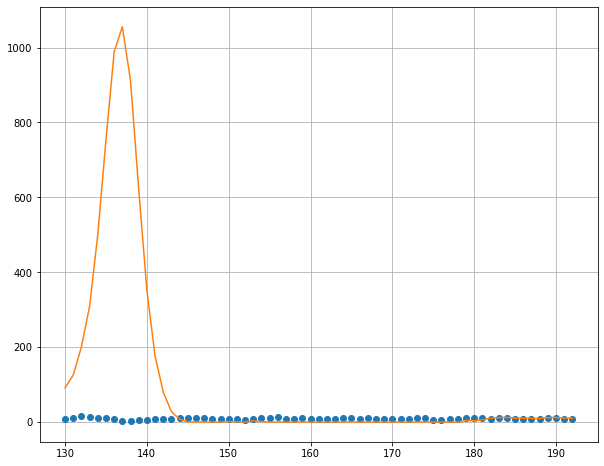

In [15]:
i = 10
arrays, params, noiselists, xLists, yLists, curveparams = list(zip(*fsub_stop_2d))[i]

j = 2

plt.plot(xLists[j], noiselists[j], 'o')
plt.plot(np.abs(xLists[j]), yLists[j])

plt.grid()
#plt.semilogy()

In [59]:
%pdb

Automatic pdb calling has been turned ON


In [61]:
reload(hitp)

<module 'dataproc.operations.hitp' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/dataproc-0.0.1-py3.7.egg/dataproc/operations/hitp.py'>

In [29]:
%pdb

Automatic pdb calling has been turned OFF


In [50]:
# 22, 29, 37?, 

(22, 31)

In [65]:
reload(hitp)

<module 'dataproc.operations.hitp' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/dataproc-0.0.1-py3.7.egg/dataproc/operations/hitp.py'>

In [113]:
i, j
#(23, 2)

(20, 6)

In [ ]:
44, 55, 56

In [17]:
reload(hitp)

<module 'dataproc.operations.hitp' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/dataproc/operations/hitp.py'>

[6.113299466478149, -230.97660984497867, 19975.24101572928, 7.499999999999999, 6.398992286182739, -0.49999999999999994, 110.01020098623043, 11962.033113663116, 0.0009252121168442629, 5.295057522315488]


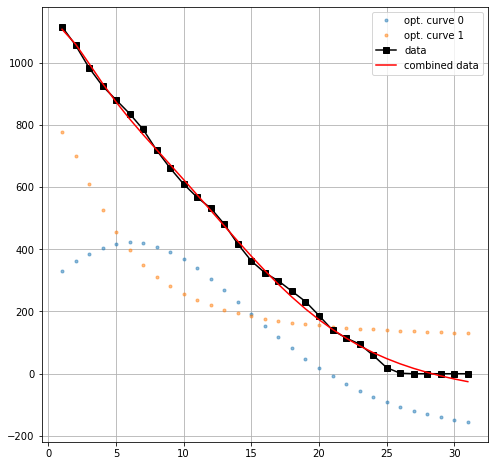

In [478]:
k = 49
a, b = 1, 2
i, j = res[k]
#i, j = 23, 2

#plt.subplot(b, a, 1)
arrays, params1, noiselists, xLists, yLists, curveparams = list(zip(*fsub_stop_2d))[i]
#curveys0 = hitp.plot_curve_fit(xLists[j], yLists[j], curveparams[j])
hitp.plot_curve_fit(xLists[j], yLists[j], curveparams[j])
plt.grid()

In [479]:
arrays, params1, noiselists, xLists, yLists, curveparams = list(zip(*fsub_stop_2d_nobg))[i]
#curveys0 = hitp.plot_curve_fit(xLists[j], yLists[j], curveparams[j])
hitp.plot_curve_fit(xLists[j], yLists[j], curveparams[j])
plt.grid()

[5.280136533194638, -165.06238782717264, 1189.4916158618869, 2.0569403544953104, 5.68913754985051e-36, 11.097002861030342, 776.8231184990047, 2030.4733484384114, 4.634590234661434, 1.0126381021768348e-25, 2.7000000018444634, -171.66559071121696, 9.645104159860605e-32, 7.49999999925, 7.49999999925]


In [ ]:
fsub_stop_2d_nobg

In [206]:
#arrays, params1, noiselists, xLists, yLists, _ = list(zip(*fsub_stop_2d_lowthreshold))[i]
curveys0 = hitp.plot_curve_fit(xLists[j], yLists[j], curveparams_single)
plt.grid()

AttributeError: 'list' object has no attribute 'items'

<Figure size 576x576 with 0 Axes>

In [ ]:
60

In [166]:
reload(hitp)

<module 'dataproc.operations.hitp' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/dataproc/operations/hitp.py'>

In [384]:
curveparams_single, _ = hitp.fit_peak(xLists[j], yLists[j], peakShape = 'Voigt', numCurves = 1,
                                      noise_estimate = noiselists[j], background = background[i][xLists[j]])
curveys0 = hitp.plot_curve_fit(xLists[j], yLists[j], curveparams_single);

Peak at 548, start iteration with error = 0.6948000187866952
Peak at 548, iteration 0: error = 1.2219974144496544
[547.8981343451742, -10.913358404173922, 4818.346377565941, 3.144882866762522, 1.3810531014753682]


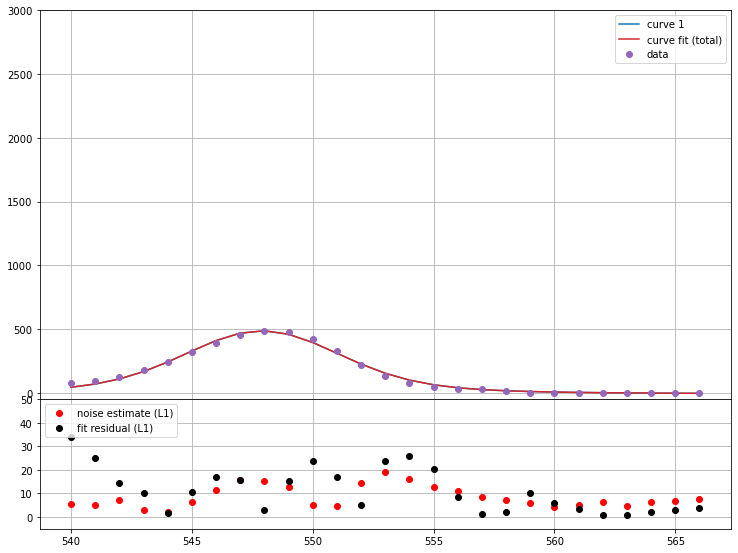

In [385]:
c = curveys0[0][-1]

fig1 = figure(1)
#Plot Data-model
frame1=fig1.add_axes((.1,.3,.8,.6))

plt.plot(xLists[j], curveys0[0] , label = 'curve 1')
plt.plot([], [])
plt.plot([], [])
plt.plot(xLists[j], curveys0[0], label = 'curve fit (total)')
plt.plot(xLists[j], yLists[j], 'o', label = 'data')

frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.grid()
plt.legend()
plt.ylim((-50, 10000))
plt.ylim((-50, 3000))

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2)) 
plt.plot(xLists[j], np.abs(noiselists[j]), 'or', label = 'noise estimate (L1)')
plt.plot(xLists[j], 
    np.abs(yLists[j] - (curveys0[0]))
         , 'ok', label = 'fit residual (L1)')
plt.ylim((-5, 350))
plt.ylim((-5, 50))


#plot(x,difference,'or')
plt.grid()
plt.legend(loc = 'upper left')

[-0.5999999999966921, -21.753425869683596, 14396.757133863905, 1.4277172664725823, 7.999999999999998]
[-0.5999999999966921, -21.753425869683596, 14396.757133863905, 1.4277172664725823, 7.999999999999998]


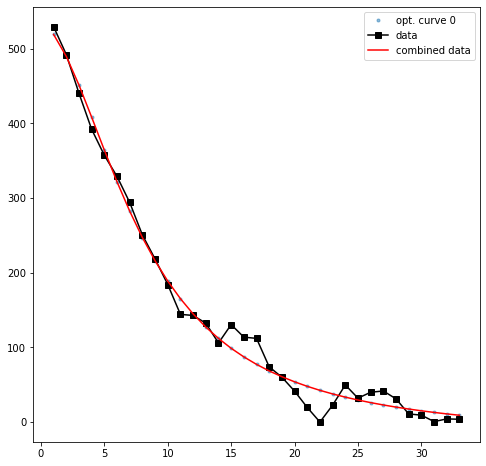

In [649]:
# candiat8s: k = 68, 95, 100, 110, 166, 205?, 213?
# k = 5
k = 57

a, b = 1, 2
i, j = res[k]
#i, j = 23, 2

#plt.subplot(b, a, 1)
arrays, params1, noiselists, xLists, yLists, curveparams = list(zip(*fsub_stop_2d))[i]
curveys0 = hitp.plot_curve_fit(xLists[j], yLists[j], curveparams[j]);
hitp.plot_curve_fit(xLists[j], yLists[j], curveparams[j])
plt.grid()

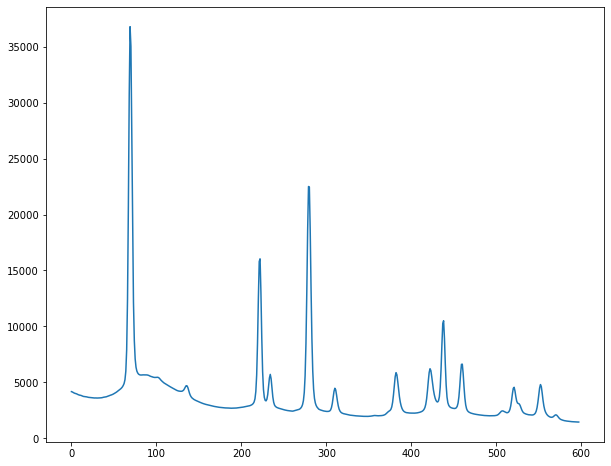

In [642]:
plt.plot(patterns[i])

[382.28215855899043, -471.18173427431316, 24747.44357592308, 4.51772108795244, 1.525200250338794, 354.47057488706395, 438.82593966468556, 622.9741925787765, 1.4437677932988704, 1.525913839025424]
[382.28215855899043, -471.18173427431316, 24747.44357592308, 4.51772108795244, 1.525200250338794, 354.47057488706395, 438.82593966468556, 622.9741925787765, 1.4437677932988704, 1.525913839025424]


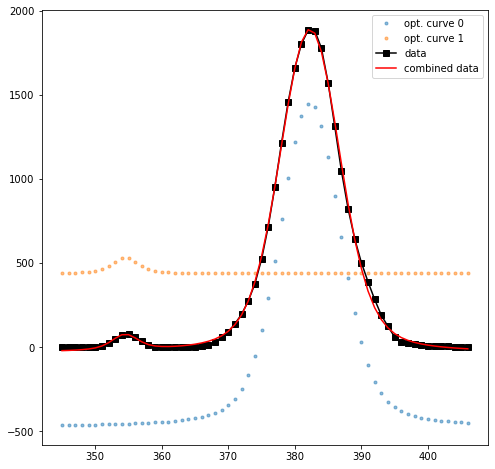

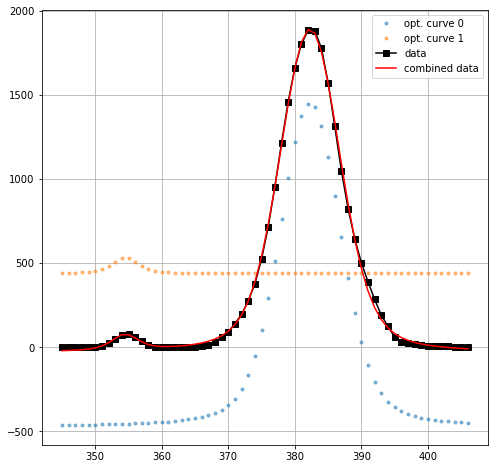

In [523]:
#plt.subplot(b, a, 1)
j = 7
arrays, params1, noiselists, xLists, yLists, curveparams = list(zip(*fsub_stop_2d))[i]
curveys0 = hitp.plot_curve_fit(xLists[j], yLists[j], curveparams[j]);
hitp.plot_curve_fit(xLists[j], yLists[j], curveparams[j])
plt.grid()

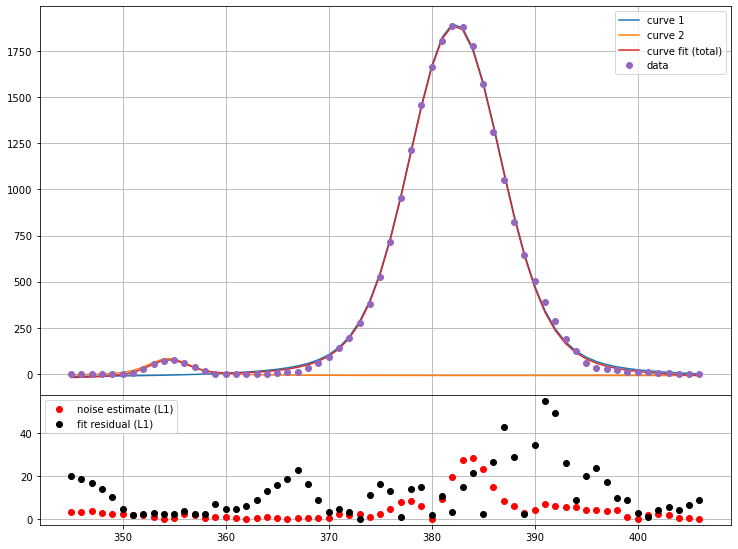

In [524]:
c, d = curveys0[0][-1], curveys0[1][-1]

fig1 = figure(1)
#Plot Data-model
frame1=fig1.add_axes((.1,.3,.8,.6))

plt.plot(xLists[j], curveys0[0] - c, label = 'curve 1')
plt.plot(xLists[j], curveys0[1] + c, label = 'curve 2')
plt.plot([], [])
plt.plot(xLists[j], curveys0[0] + curveys0[1], label = 'curve fit (total)')
plt.plot(xLists[j], yLists[j], 'o', label = 'data')

frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.grid()
plt.legend()
#plt.ylim((-50, 10000))

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2)) 
plt.plot(xLists[j], np.abs(noiselists[j]), 'or', label = 'noise estimate (L1)')
plt.plot(xLists[j], 
    np.abs(yLists[j] - (curveys0[0] + curveys0[1]))
         , 'ok', label = 'fit residual (L1)')

#plot(x,difference,'or')
plt.grid()
plt.legend(loc = 'upper left')
#plt.ylim((-5, 350))

[385.02361803252734, -1592.7766206009553, 44571.071194799486, 1.1330249715220355, 2.74571536117119, 409.54996747436024, 2898.365950118006, 64719.97532458552, 12.708161078745109, 12.749999998587791]
[385.02361803252734, -1592.7766206009553, 44571.071194799486, 1.1330249715220355, 2.74571536117119, 409.54996747436024, 2898.365950118006, 64719.97532458552, 12.708161078745109, 12.749999998587791]


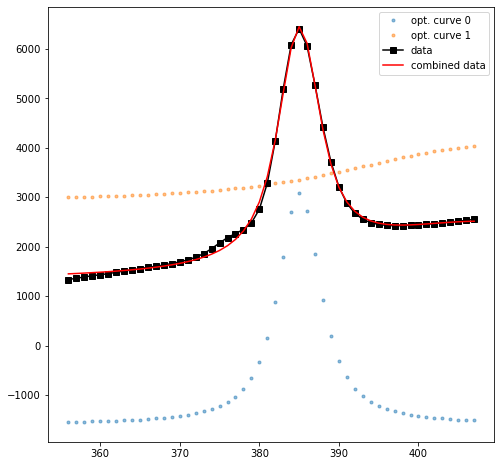

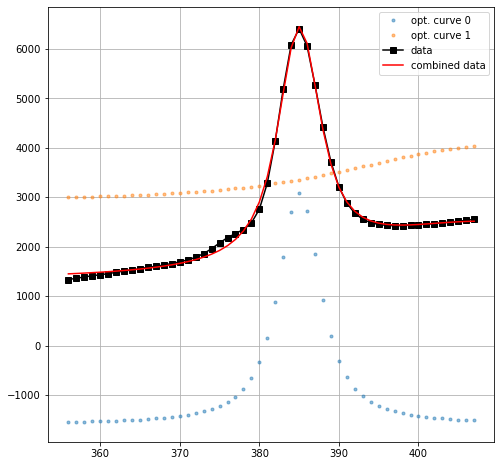

In [604]:
#plt.subplot(b, a, 1)
#j = 7
arrays, params1, noiselists, xLists, yLists, curveparams = list(zip(*fsub_stop_2d_bg))[i]
curveys0 = hitp.plot_curve_fit(xLists[j], yLists[j], curveparams[j]);
hitp.plot_curve_fit(xLists[j], yLists[j], curveparams[j])
plt.grid()

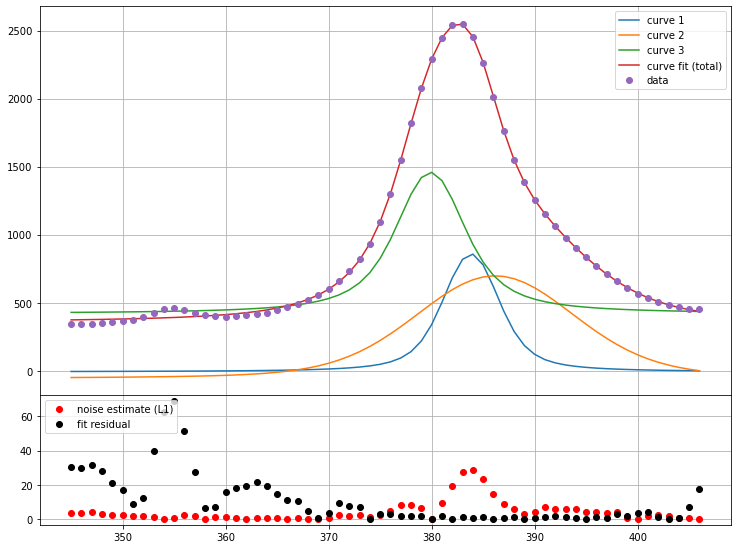

In [530]:
c, d, e = curveys[0][-1], curveys[1][-1], curveys[2][-1]

fig1 = figure(1)
#Plot Data-model
frame1=fig1.add_axes((.1,.3,.8,.6))

plt.plot(xLists[j], curveys[0] - c, label = 'curve 1')
plt.plot(xLists[j], curveys[1] - d, label = 'curve 2')
plt.plot(xLists[j], curveys[2] + c + d, label = 'curve 3')
plt.plot(xLists[j], curveys[0] + curveys[1] + curveys[2], label = 'curve fit (total)')
plt.plot(xLists[j], yLists[j], 'o', label = 'data')

frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.grid()
plt.legend()
#plt.ylim((-50, 10000))


#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2)) 
plt.plot(xLists[j], np.abs(noiselists[j]), 'or', label = 'noise estimate (L1)')

#plt.plot(xLists[j], np.abs(yLists[j] - (curveys[0] + curveys[1] + curveys[2]- c - d - e)), 'ok', label = 'residual')
plt.plot(xLists[j], np.abs(yLists[j] - (curveys[0] + curveys[1] + curveys[2])), 'ok', label = 'fit residual')

#plot(x,difference,'or')
plt.grid()
plt.legend(loc = 'upper left')
#plt.ylim((-5, 350))

In [ ]:
arrays, params1, noiselists, xLists, yLists, curveparams = list(zip(*fsub_stop_2d_lowthreshold))[i]
curveys = hitp.plot_curve_fit(xLists[j], yLists[j], curveparams[j])
plt.grid()

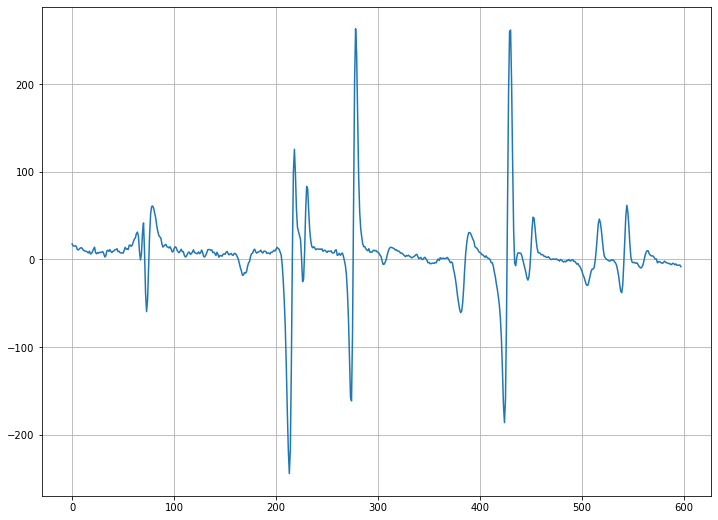

In [192]:
#plt.plot(patterns[i])
plt.plot(fast_T[i])
plt.grid()

In [273]:
pwd

'/Users/ollie/Documents/SLAC/xrd_clustering/notebooks'

[168.6822074874225, -36.735553427950215, 23289.315029523088, 3.2041398931364973, 0.7025324210347778, 162.40695466232364, -9.691727309126968, 337.0365082586868, 2.16116638849319, 7.109223801914095e-06, 185.74350361080172, -6.475841795993049, 235.03886634642018, 2.971308709516478, 1.8995235726197994e-06]


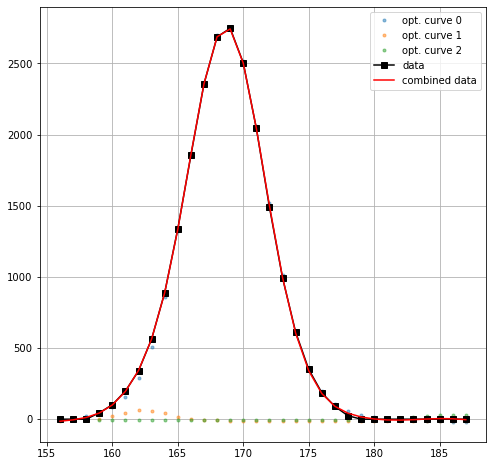

In [272]:
arrays, params1, noiselists, xLists, yLists, curveparams = list(zip(*fsub_stop_2d_lowthreshold))[i]
curveys = hitp.plot_curve_fit(xLists[j], yLists[j], curveparams[j])
plt.grid()

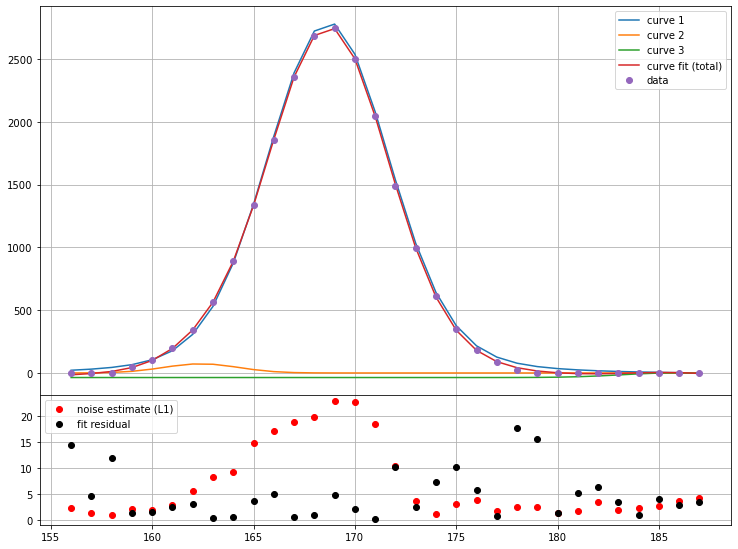

In [275]:
c, d, e = curveys[0][-1], curveys[1][-1], curveys[2][-1]

fig1 = figure(1)
#Plot Data-model
frame1=fig1.add_axes((.1,.3,.8,.6))

plt.plot(xLists[j], curveys[0] - c, label = 'curve 1')
plt.plot(xLists[j], curveys[1] - d, label = 'curve 2')
plt.plot(xLists[j], curveys[2] + c + d, label = 'curve 3')
plt.plot(xLists[j], curveys[0] + curveys[1] + curveys[2], label = 'curve fit (total)')
plt.plot(xLists[j], yLists[j], 'o', label = 'data')

frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.grid()
plt.legend()
#plt.ylim((-50, 10000))


#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2)) 
plt.plot(xLists[j], np.abs(noiselists[j]), 'or', label = 'noise estimate (L1)')

#plt.plot(xLists[j], np.abs(yLists[j] - (curveys[0] + curveys[1] + curveys[2]- c - d - e)), 'ok', label = 'residual')
plt.plot(xLists[j], np.abs(yLists[j] - (curveys[0] + curveys[1] + curveys[2])), 'ok', label = 'fit residual')

#plot(x,difference,'or')
plt.grid()
plt.legend(loc = 'upper left')
#plt.ylim((-5, 350))

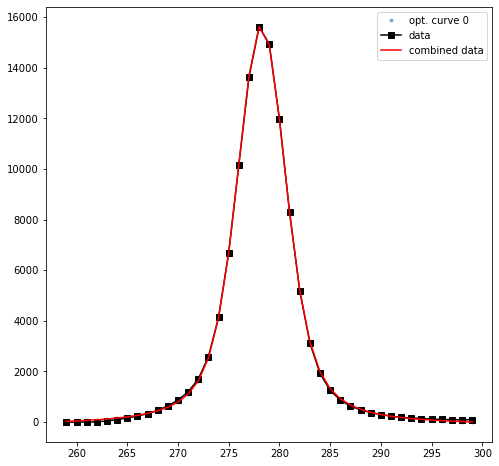

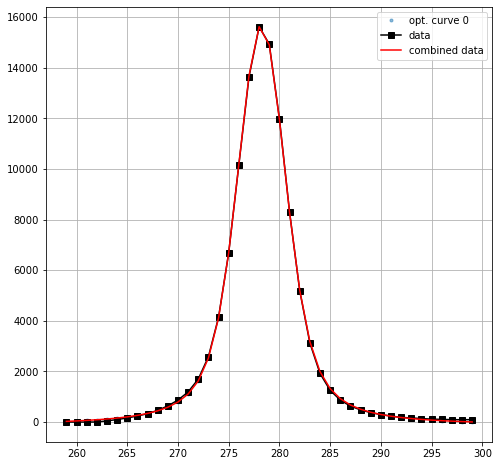

In [149]:
k = 56
a, b = 1, 2
i, j = res[k]
#i, j = 23, 2

#plt.subplot(b, a, 1)
arrays, params1, noiselists, xLists, yLists, curveparams = list(zip(*fsub_stop_2d))[i]
curveys0 = hitp.plot_curve_fit(xLists[j], yLists[j], curveparams[j])
hitp.plot_curve_fit(xLists[j], yLists[j], curveparams[j])
plt.grid()

<IPython.core.display.Javascript object>


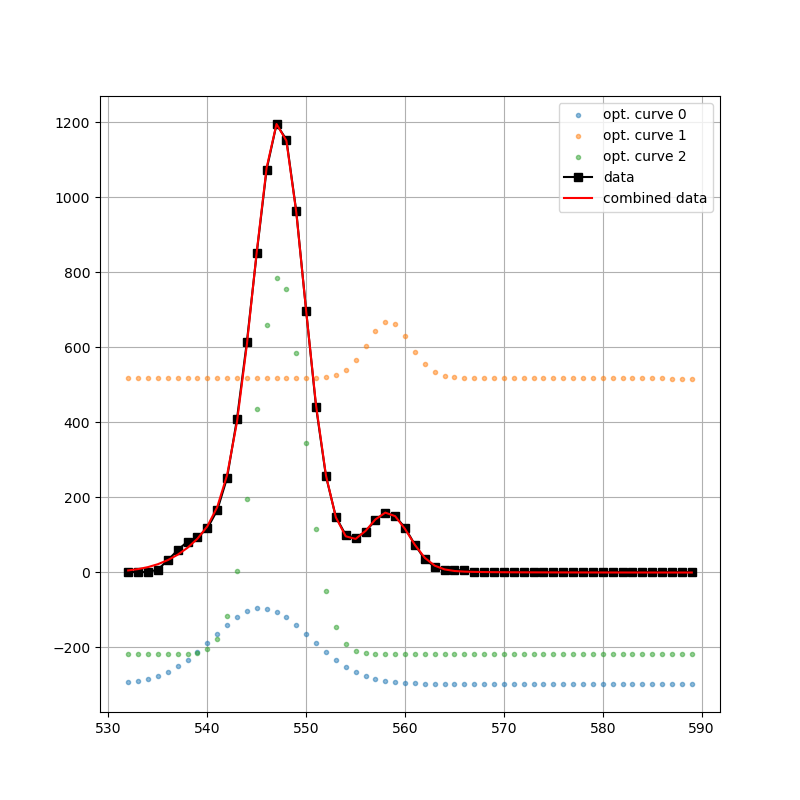

In [160]:
arrays, params1, noiselists, xLists, yLists, curveparams = list(zip(*fsub_stop_2d_lowthreshold))[i]
curveys = hitp.plot_curve_fit(xLists[j], yLists[j], curveparams[j])
plt.grid()

In [75]:
curveys[2]

array([-418.84366376, -413.74681425, -405.61890078, -395.18182553,
       -386.92785946, -386.60686663, -394.47512818, -404.95084656,
       -413.29449444, -418.57394845, -421.69499277, -423.58194849,
       -424.78432575, -425.59175822, -426.158639  , -426.57142371,
       -426.88115507, -427.11943323, -427.30663688, -427.45637505,
       -427.57801247, -427.67816256, -427.76160263, -427.83185292,
       -427.89155343, -427.94271536, -427.98689259, -428.02530098,
       -428.05890292, -428.08846816, -428.11461834, -428.13785986,
       -428.15860865, -428.17720883, -428.19394716, -428.20906409,
       -428.22276247, -428.23521439, -428.24656663, -428.25694497,
       -428.2664577 , -428.27519848, -428.28324864, -428.29067905,
       -428.29755175, -428.30392117, -428.3098353 , -428.31533651,
       -428.32046237, -428.32524626, -428.32971794, -428.333904  ,
       -428.33782826, -428.34151209, -428.34497476, -428.34823361,
       -428.35130433, -428.35420114, -428.35693691, -428.35952

In [388]:
i = 10

In [389]:
%matplotlib notebook
# plt.plot(xLists[j], curveys[0] - c, label = 'curve 1')
# plt.plot(xLists[j], curveys[1] - d, label = 'curve 2')
# plt.plot(xLists[j], curveys[2] - e, label = 'curve 3')

#plt.plot(xLists[j], np.abs(noiselists[j]), 'o')

plt.plot(np.arange(len(patterns[i])), patterns[i] - background[i])
plt.plot(np.arange(len(patterns[i])), patterns[i])

plt.plot(xLists[j], patterns[i][xLists[j]], label = 'fit region (raw)')

plt.plot(xLists[j], yLists[j], label = 'fit region (background subtracted)')

plt.legend()
plt.grid()

<IPython.core.display.Javascript object>

In [150]:
%matplotlib notebook

In [92]:
pwd

'/Users/ollie/Documents/SLAC/xrd_clustering/notebooks'

In [ ]:
curvep

In [98]:
curveys0

[array([-4.36029852e+01, -3.01398193e+01, -1.35910284e+01,  7.14678346e+00,
         3.38073937e+01,  6.93755744e+01,  1.19631849e+02,  1.97051953e+02,
         3.29964625e+02,  5.81030980e+02,  1.07632870e+03,  2.03343745e+03,
         3.75259048e+03,  6.51772386e+03,  1.03857229e+04,  1.49464523e+04,
         1.92502884e+04,  2.20779000e+04,  2.24952002e+04,  2.03565404e+04,
         1.63875644e+04,  1.17836823e+04,  7.62625544e+03,  4.50171305e+03,
         2.47782477e+03,  1.31519111e+03,  7.02499286e+02])]

IndexError: list index out of range

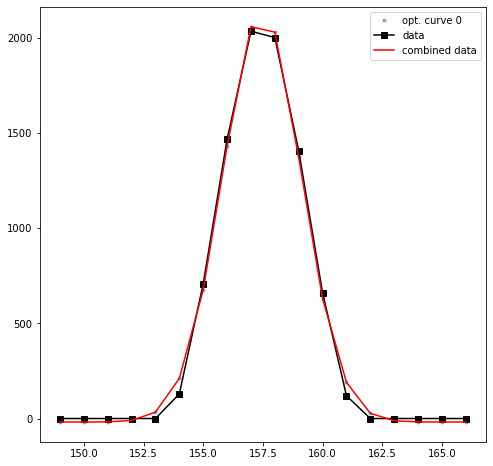

In [100]:
k = 40
i, j = res[k]

xLists, yLists, curveparams = xLists1, yLists1, curveparams1
xLists, yLists, curveparams = xLists2, yLists2, curveparams2

curveys0 = hitp.plot_curve_fit(xLists[j], yLists[j], curveparams[j]);

c, d = curveys0[0][-1], curveys0[1][-1]

fig1 = figure(1)
#Plot Data-model
frame1=fig1.add_axes((.1,.3,.8,.6))

plt.plot(xLists[j], curveys0[0] - c, label = 'curve 1')
plt.plot(xLists[j], curveys0[1] - d, label = 'curve 2')
plt.plot([], [])
plt.plot(xLists[j], curveys0[0] + curveys0[1] - c - d, label = 'curve fit (total)')
plt.plot(xLists[j], yLists[j], 'o', label = 'data')

frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.grid()
plt.legend()
#plt.ylim((-50, 1250))

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2)) 
plt.plot(xLists[j], np.abs(noiselists[j]), 'or', label = 'noise estimate (L1)')
plt.plot(xLists[j], 
         #np.abs(
    yLists[j] - (curveys0[0] + curveys0[1] - c - d)
#)
         , 'ok', label = 'fit residual')

#plot(x,difference,'or')
plt.grid()
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (66,) and (28,)

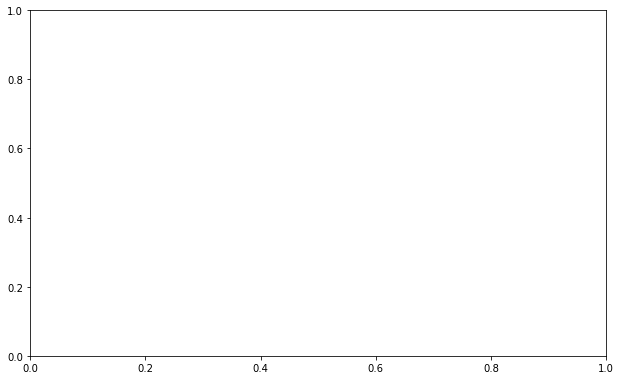

In [93]:
c, d, e = curveys[0][-1], curveys[1][-1], curveys[2][-1]

fig1 = figure(1)
#Plot Data-model
frame1=fig1.add_axes((.1,.3,.8,.6))

plt.plot(xLists[j], curveys[0] - c, label = 'curve 1')
plt.plot(xLists[j], curveys[1] - d, label = 'curve 2')
plt.plot(xLists[j], curveys[2] - e, label = 'curve 3')
plt.plot(xLists[j], curveys[0] + curveys[1] + curveys[2] - c - d - e, label = 'curve fit (total)')
plt.plot(xLists[j], yLists[j], 'o', label = 'data')

frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.grid()
plt.legend()
plt.ylim((-50, 1250))


#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2)) 
plt.plot(xLists[j], np.abs(noiselists[j]), 'or', label = 'noise estimate (L1)')

#plt.plot(xLists[j], np.abs(yLists[j] - (curveys[0] + curveys[1] + curveys[2]- c - d - e)), 'ok', label = 'residual')
plt.plot(xLists[j], (yLists[j] - (curveys[0] + curveys[1] + curveys[2]- c - d - e)), 'ok', label = 'fit residual')

#plot(x,difference,'or')
plt.grid()
plt.legend()

<IPython.core.display.Javascript object>


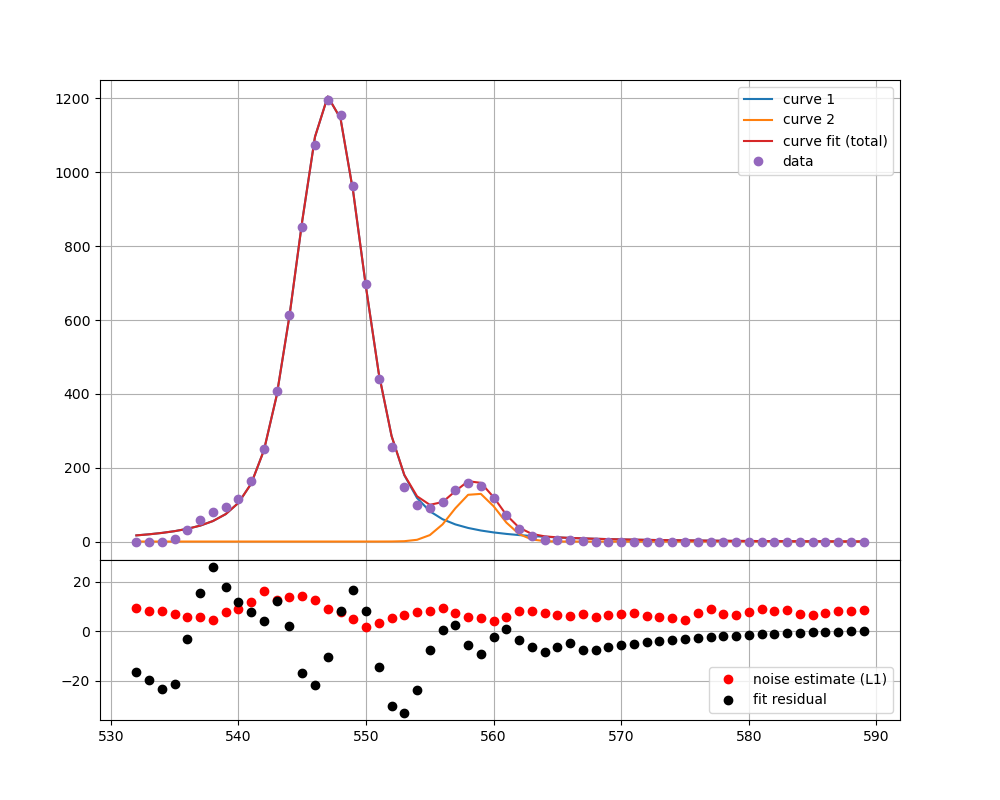

In [206]:
c, d = curveys0[0][-1], curveys0[1][-1]

fig1 = figure(1)
#Plot Data-model
frame1=fig1.add_axes((.1,.3,.8,.6))

plt.plot(xLists[j], curveys0[0] - c, label = 'curve 1')
plt.plot(xLists[j], curveys0[1] - d, label = 'curve 2')
plt.plot([], [])
plt.plot(xLists[j], curveys0[0] + curveys0[1] - c - d, label = 'curve fit (total)')
plt.plot(xLists[j], yLists[j], 'o', label = 'data')

frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.grid()
plt.legend()
plt.ylim((-50, 1250))

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2)) 
plt.plot(xLists[j], np.abs(noiselists[j]), 'or', label = 'noise estimate (L1)')
plt.plot(xLists[j], 
         #np.abs(
    yLists[j] - (curveys0[0] + curveys0[1] - c - d)
#)
         , 'ok', label = 'fit residual')

#plot(x,difference,'or')
plt.grid()
plt.legend()

In [205]:
c, d, e = curveys[0][-1], curveys[1][-1], curveys[2][-1]

fig1 = figure(1)
#Plot Data-model
frame1=fig1.add_axes((.1,.3,.8,.6))

plt.plot(xLists[j], curveys[0] - c, label = 'curve 1')
plt.plot(xLists[j], curveys[1] - d, label = 'curve 2')
plt.plot(xLists[j], curveys[2] - e, label = 'curve 3')
plt.plot(xLists[j], curveys[0] + curveys[1] + curveys[2] - c - d - e, label = 'curve fit (total)')
plt.plot(xLists[j], yLists[j], 'o', label = 'data')

frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.grid()
plt.legend()
plt.ylim((-50, 1250))


#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2)) 
plt.plot(xLists[j], np.abs(noiselists[j]), 'or', label = 'noise estimate (L1)')

#plt.plot(xLists[j], np.abs(yLists[j] - (curveys[0] + curveys[1] + curveys[2]- c - d - e)), 'ok', label = 'residual')
plt.plot(xLists[j], (yLists[j] - (curveys[0] + curveys[1] + curveys[2]- c - d - e)), 'ok', label = 'fit residual')

#plot(x,difference,'or')
plt.grid()
plt.legend()

<IPython.core.display.Javascript object>

In [106]:
%matplotlib inline
plt.plot(xLists[j], curveys[0])
plt.plot(xLists[j], curveys[0] + curveys[1] - 428.36)
plt.plot(xLists[j], curveys[2])
plt.plot(xLists[j], yLists[j], label = 'data')

plt.plot(np.arange(len(patterns[i])), patterns[i] - background[i])
plt.plot(np.arange(len(patterns[i])), patterns[i])
plt.legend()
plt.grid()

In [34]:
fitlists = fsub_stop_2d[1]

In [76]:
# moved to featureization.py

# def color_peaks(fit_list, pattern, imin = 10, fwhm_max = 20, area_min = 1000):
#     """
#     Return an array of 1s in indices corresponding to a peak (+- HWHM) and 0s elsewhere. 
    
#     fit_list: list of derived curve fit parameters.
    
#     Only the first curve in each group of fits is counted.
#     """
#     res = np.zeros_like(pattern)
#     for peaks in fit_list:
#         primary = peaks['curve 0']
#         qwhm = int((primary['FWHM'] + 1) / 3)
#         i0 = int(primary['x0'] + .5)
#         if i0 >= imin and primary['FWHM'] <= fwhm_max:# and primary['area'] > area_min:
#             res[i0 - qwhm: i0 + qwhm] = 1
#     return res

# def color_peaks_2d(fitlists, patterns, **kwargs):
#     return np.vstack([color_peaks(fitlist, patterns[i], **kwargs) for i, fitlist in enumerate(fitlists)])

In [18]:
from xrdc import featurization as feat

In [21]:
plt.imshow(feat.color_peaks_2d(fsub_stop_2d[1], patterns, peakwidth = 2))

In [80]:
plt.imshow(color_peaks_2d(fsub_stop_2d_2[1], patterns))

In [326]:
peakmask = np.vstack([color_peaks(fitlist, patterns[i], area_min = 1) for i, fitlist in enumerate(fsub_stop_2d[1])])

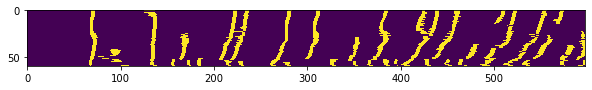

In [327]:
plt.imshow(peakmask, interpolation = 'none')

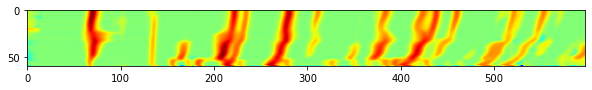

In [334]:
plt.imshow(np.log(1 + fast_q - fast_q.min()), cmap = 'jet')

In [216]:
round(.5)

0

In [394]:
from xrdc import featurization as feat

reload(feat)
# moved to module
# def peakfit_featurize(patterns_pp, fitlists, size_thresh = 5):
#     #patterns_pp = gf(patterns, (1, 1.7))
#     labeled, feature_masks, activations, norm_, activations_n1 = feat.get_ridge_features(
#         patterns_pp,
#        smooth_ax1 = 'FWHM', smooth_ax0 = 2, threshold_percentile = 50, thicken = True, size_thresh = size_thresh, bgsub=False,
#         log_scale_features = False, fwhm_finder=feat.fwhm_finder, do_flood_thicken = False, max_size_flood = 20,
#         thicken_ax0 = 0.5, thicken_ax1 = 0, flood_threshold=.95, smooth_factor_ax1 = .125, fitlists = fitlists,
#     peakwidth = 2)
#     return labeled, feature_masks, activations, norm_, activations_n1

In [400]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

In [218]:
reload(feat)

<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

mark feature masks

In [396]:
%pdb

Automatic pdb calling has been turned ON


In [398]:
reload(feat)

<module 'xrdc.featurization' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/featurization.py'>

In [465]:
patterns_pp = fast_q * (fast_q > 0)
patterns_pp /= patterns_pp.mean()
fitlists = fsub_stop_2d[1]
 feat.get_ridge_features(patterns_pp,
   smooth_ax1 = 'FWHM', smooth_ax0 = 1, threshold_percentile = 75, thicken = True, size_thresh = 5, bgsub=False,
    log_scale_features = False, fwhm_finder=feat.fwhm_finder, do_flood_thicken = False, max_size_flood = 20,
    thicken_ax0 = 1, thicken_ax1 = 1, flood_threshold=.95, smooth_factor_ax1 = .125)
    
# labeled, feature_masks, activations, norm_, activations_n1 = peakfit_featurize(patterns_pp, fitlists,
#                                                                     size_thresh = 3)

IndentationError: unexpected indent (<ipython-input-465-8eae25bd8d17>, line 4)

In [404]:
patterns_pp = fast_q - fast_q.min()
patterns_pp /= patterns_pp.mean()
fitlists = fsub_stop_2d[1]
labeled, feature_masks, activations, norm_, activations_n1 = peakfit_featurize(patterns_pp, fitlists,
                                                                    size_thresh = 3)

Peak at 70, start iteration with error = 0.24202090577376603
Peak at 70, iteration 0: error = 0.29552558198241163
Peak at 69, start iteration with error = 0.24855609044652283
Peak at 69, iteration 0: error = 0.2605758306223381
Peak at 68, start iteration with error = 0.2589362485723926
Peak at 68, iteration 0: error = 0.24649632668317273
Peak at 277, start iteration with error = 0.29356943800066554
Peak at 277, iteration 0: error = 0.3453806393729579
Peak at 211, start iteration with error = 0.23395662705666304
Peak at 211, iteration 0: error = 0.3013587631573703
Peak at 208, start iteration with error = 0.23914730232708642
Peak at 208, iteration 0: error = 0.2823045361897324
using fitlists


<IPython.core.display.Javascript object>

using fitlists
41
1.0944296193337746


In [219]:
patterns_pp = fast_q - fast_q.min()
patterns_pp /= patterns_pp.mean()
fitlists = fsub_stop_2d[1]
labeled, feature_masks, activations, norm_, activations_n1 = peakfit_featurize(patterns_pp, fitlists,
                                                                    size_thresh = 3)

using fitlists
Peak at 70, start iteration with error = 0.353051308642668
Peak at 70, iteration 0: error = 0.3446701219673796
Peak at 69, start iteration with error = 0.13928651108157072
Peak at 69, iteration 0: error = 0.15092469299922626
Peak at 277, start iteration with error = 0.13077815137943002
Peak at 277, iteration 0: error = 0.11476220040499151
Peak at 277, start iteration with error = 0.22468034336754283
Peak at 277, iteration 0: error = 0.24775850970284433
Peak at 211, start iteration with error = 0.21089514413217467
Peak at 211, iteration 0: error = 0.25773065967237974
Peak at 208, start iteration with error = 0.22241460120179887
Peak at 208, iteration 0: error = 0.23831252327132724
using fitlists
45
1.2718179762184438


In [405]:
# moved to module
#def get_features_range(labeled, i):
#     """
#     Return (min vertical index, max vertical index, horizontal index at max vertical position)
#     """
#     indices = np.indices(labeled.shape)#.T[:,:,[1, 0]]
#     if len(labeled.shape) == 2:
#         vi, hi = indices[:, labeled == i]
#         return (vi.min(), vi.max(), np.floor(hi[(vi == vi.max())].mean()))

mark

## Feature map visualtization

In [407]:
aspect = 1.5

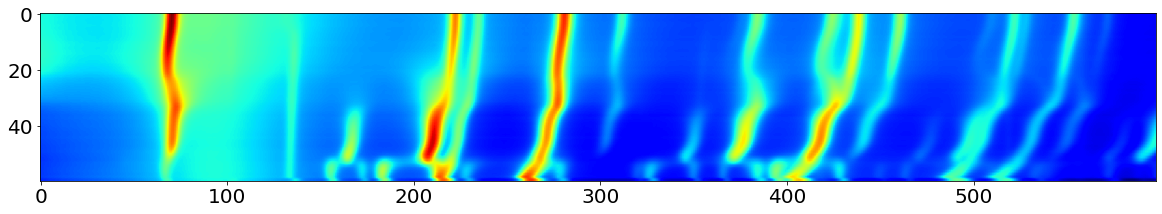

In [275]:
plt.imshow(np.log(1 + patterns), cmap = 'jet', aspect = aspect)

In [288]:
%matplotlib inline

In [292]:
plt.rcParams["figure.figsize"]=(20, 20)

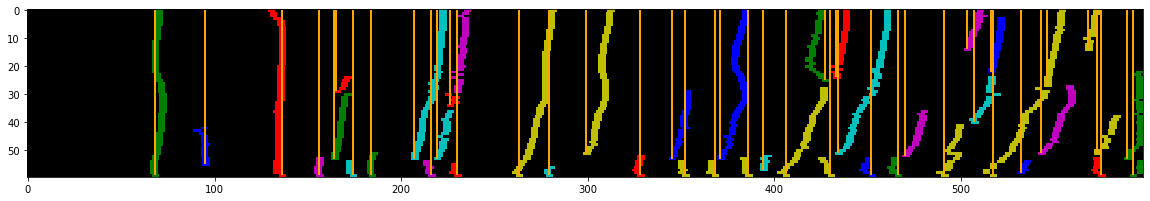

In [293]:
feat.imshow_labeled(labeled, aspect = 1.5)
for i in range(1, labeled.max() + 1):
    frange = get_features_range(labeled, i)
    plt.vlines(frange[2], 0, frange[1], color = 'orange', linewidth = 2)

<IPython.core.display.Javascript object>


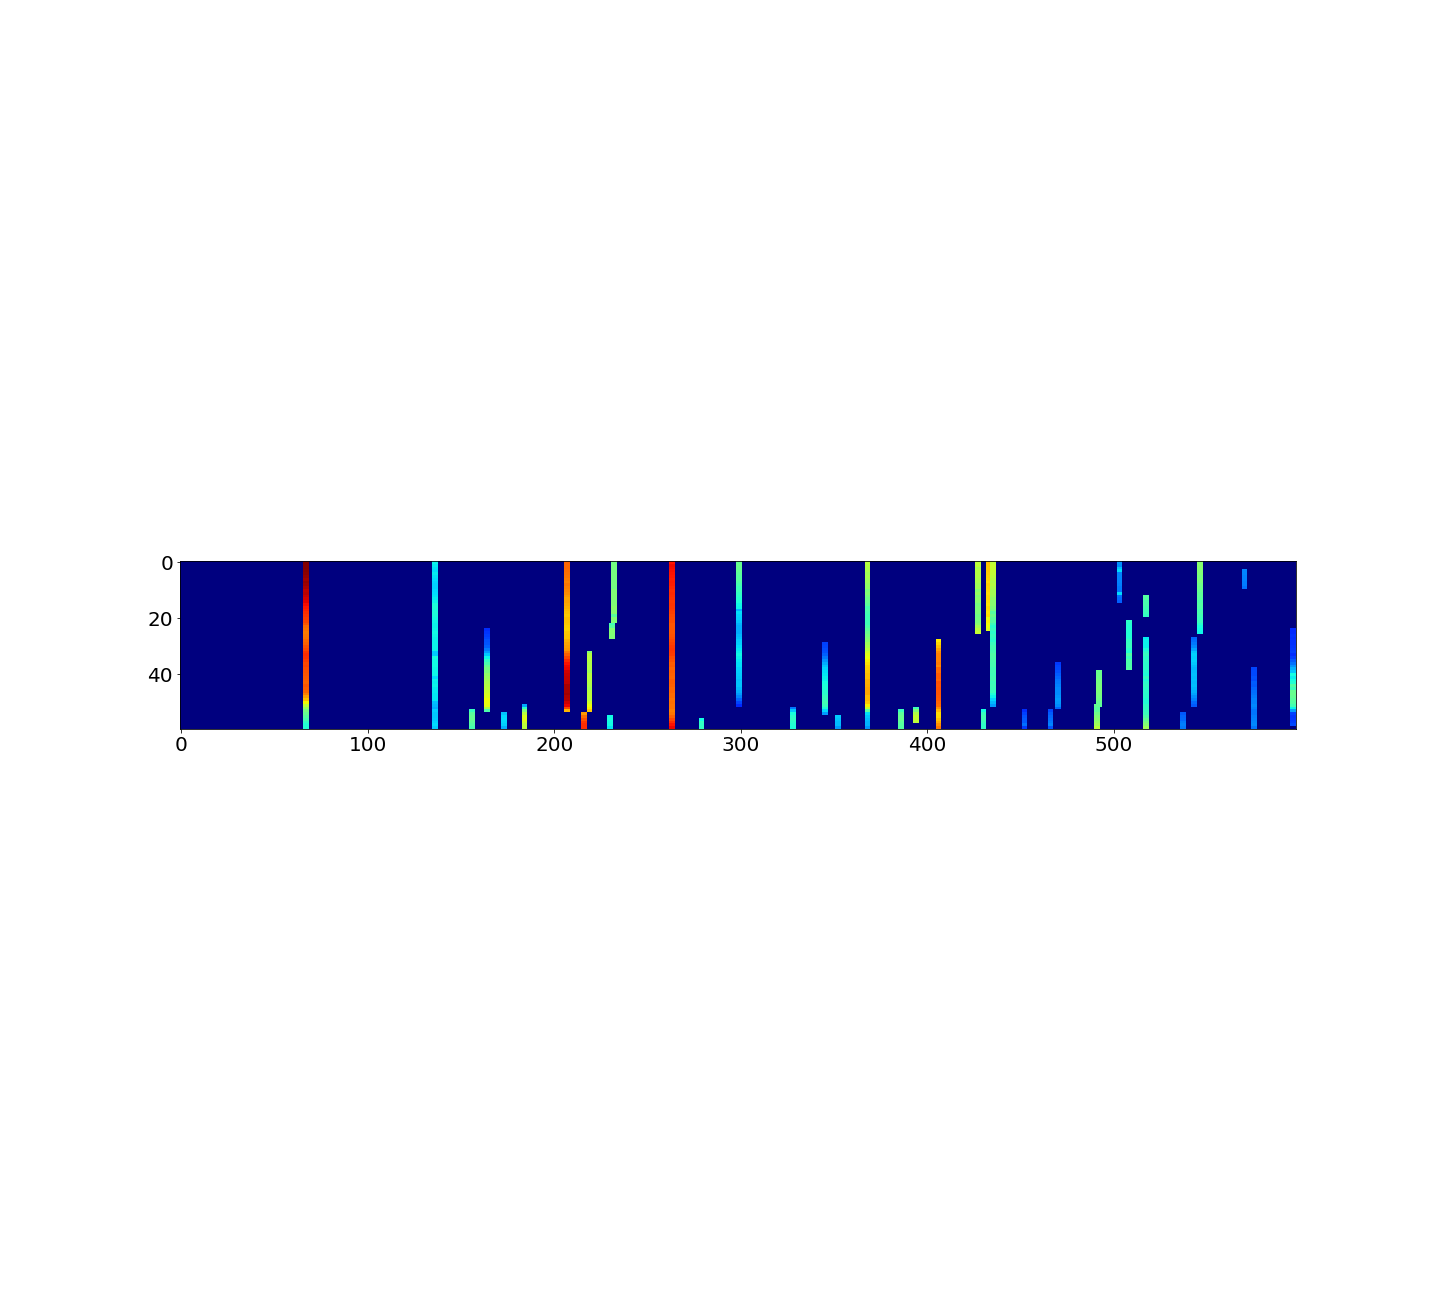

In [408]:
straight_feature_map = np.zeros_like(patterns)
thickness = 2
for i in range(1, labeled.max() + 1):
    vmin, vmax, hcenter = get_features_range(labeled, i)
    hstart, hend = int(hcenter - thickness / 2), int(hcenter + thickness / 2)
    vi, hi = np.indices(labeled.shape)
    fillmask = ((hi >= hstart) & (hi <= hend)) & ((vi <= vmax) & (vi >= vmin))
    vi_fill, hi_fill = vi[fillmask], hi[fillmask]
    for vidx, hidx in zip(vi_fill, hi_fill):
        straight_feature_map[vidx, hidx] = activations[i - 1][vidx]
        
plt.imshow(np.log(1 + straight_feature_map), cmap = 'jet', aspect = aspect, interpolation = 'none')

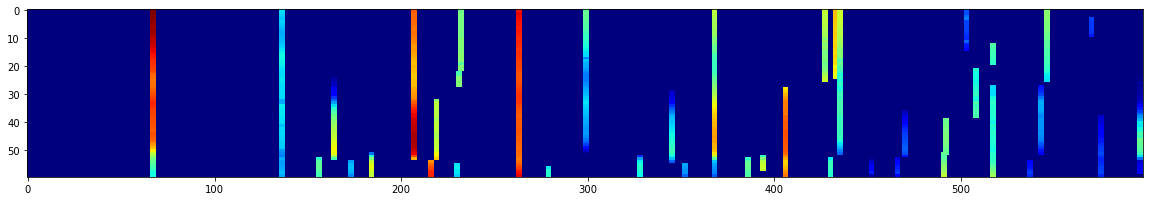

In [451]:
# moved to module
# straight_feature_map = np.zeros_like(patterns)
# thickness = 2
# for i in range(1, labeled.max() + 1):
#     vmin, vmax, hcenter = get_features_range(labeled, i)
#     hstart, hend = int(hcenter - thickness / 2), int(hcenter + thickness / 2)
#     vi, hi = np.indices(labeled.shape)
#     fillmask = ((hi >= hstart) & (hi <= hend)) & ((vi <= vmax) & (vi >= vmin))
#     vi_fill, hi_fill = vi[fillmask], hi[fillmask]
#     for vidx, hidx in zip(vi_fill, hi_fill):
#         straight_feature_map[vidx, hidx] = activations[i - 1][vidx]
        
# plt.imshow(np.log(1 + straight_feature_map), cmap = 'jet', aspect = aspect, interpolation = 'none')

In [312]:
grayscale = np.zeros_like(patterns)
alpha = np.ones_like(patterns)
rgb_img = np.dstack((grayscale, (grayscale), grayscale, (alpha)))
plt.imshow(rgb_img, cmap = 'Greys', aspect = aspect)

grayscale = straight_feature_map
alpha = (straight_feature_map != 0).astype(float)
rgb_img = np.dstack((grayscale, (grayscale), grayscale, (alpha)))
plt.imshow(np.log(1 + grayscale), alpha = alpha, cmap = 'jet', aspect = aspect)

In [436]:
%pdb

Automatic pdb calling has been turned OFF


In [437]:
labeled, feature_masks, activations_bgsubbed, activations_n0, activations_n1_bgsubbed = feat.get_ridge_features(
    patterns_pp,
   smooth_ax1 = 'FWHM', smooth_ax0 = 1, threshold_percentile = 75, thicken = True, size_thresh = 5, bgsub=False,
    log_scale_features = False, fwhm_finder=feat.fwhm_finder, do_flood_thicken = False, max_size_flood = 20,
    thicken_ax0 = 1, thicken_ax1 = 1, flood_threshold=.95, smooth_factor_ax1 = .125)


Peak at 66, start iteration with error = 0.052767999746109955
Peak at 66, iteration 0: error = 0.8815429549335395
Peak at 66, start iteration with error = 0.051875002538039276
Peak at 66, iteration 0: error = 0.7556397362951421
Peak at 66, start iteration with error = 0.04757565527409769
Peak at 66, iteration 0: error = 0.6128919555801976
Peak at 262, start iteration with error = 0.05682480607698902
Peak at 262, iteration 0: error = 0.6646869893988296
Peak at 206, start iteration with error = 0.07223683985817918
Peak at 206, iteration 0: error = 0.9814231629240923
Peak at 206, start iteration with error = 0.07140533742395602
Peak at 206, iteration 0: error = 0.8932004817817115
34
3.3088265297733086


In [438]:
patterns_pp = activations_bgsubbed
a, b = 2, 3
plt.rcParams["figure.figsize"]=(20, 15)

feat.similarity_plot_row(feat.csim_pairs, 'Cosine', patterns_pp, activations_bgsubbed, activations_n1_bgsubbed,
                        a = a, b = b)
feat.similarity_plot_row(lambda arr: -feat.l2_pairs(arr), 'L2', patterns_pp, activations_bgsubbed, activations_n1_bgsubbed, offset = 3,
                        a = a, b = b)


In [452]:
plt.imshow(feat.csim_pairs(straight_feature_map), cmap = 'jet')
plt.title('Cosine, peak shift corrected heatmap')

Text(0.5, 1.0, 'Cosine, peak shift corrected heatmap')

In [462]:
(straight_feature_map[0][straight_feature_map[0] != 0])

array([114.58482521, 114.58482521, 114.58482521,   4.11849458,
         4.11849458,   4.11849458,  45.75211295,  45.75211295,
        45.75211295,   8.96495864,   8.96495864,   8.96495864,
        68.2651962 ,  68.2651962 ,  68.2651962 ,   8.24012889,
         8.24012889,   8.24012889,  14.66591607,  14.66591607,
        14.66591607,  14.83626249,  14.83626249,  14.83626249,
        28.34493827,  28.34493827,  15.21162613,  15.21162613,
        15.21162613,   1.6465651 ,   1.6465651 ,   1.6465651 ,
        10.46233   ,  10.46233   ,  10.46233   ])

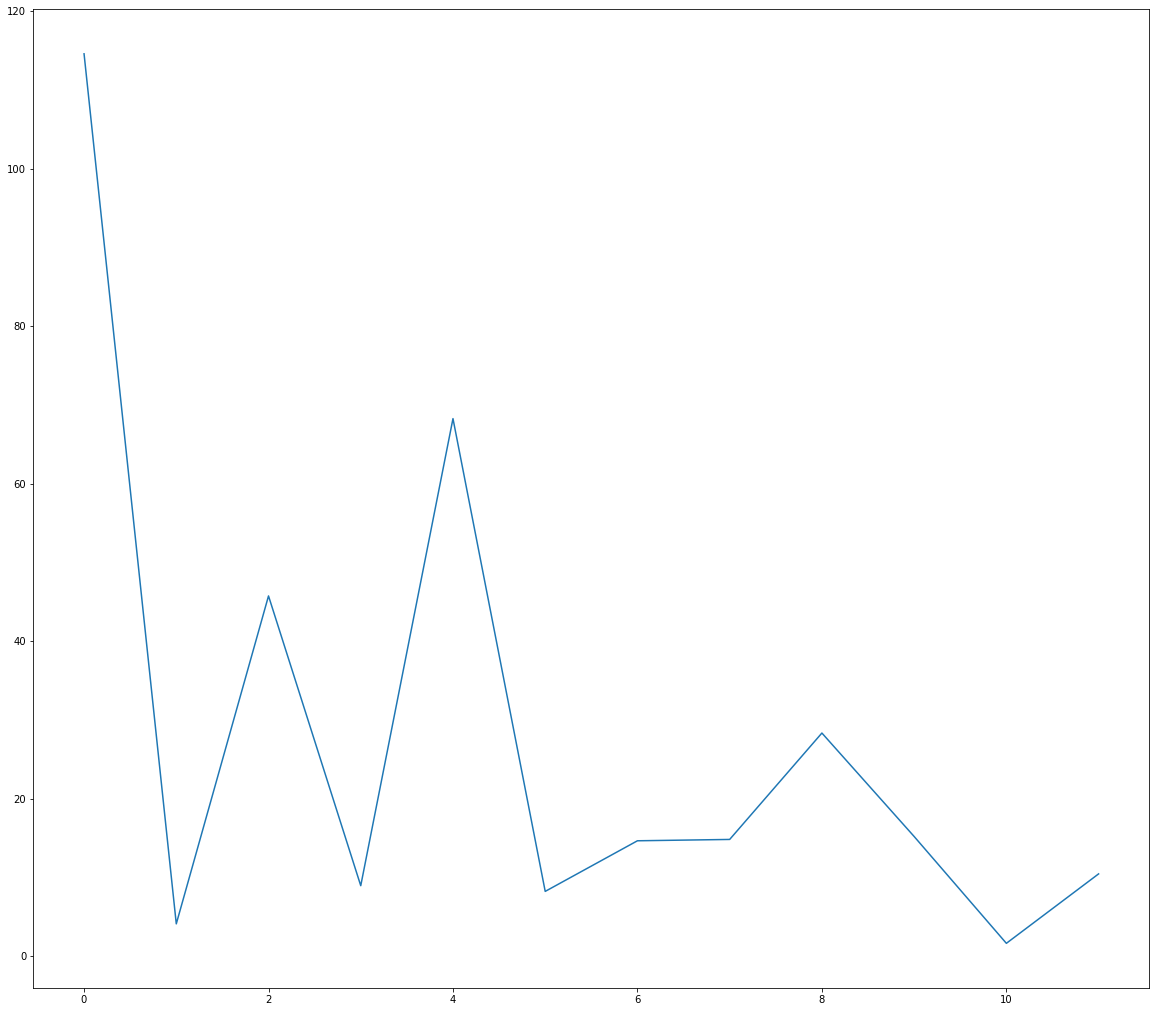

In [463]:
plt.plot((straight_feature_map[0][straight_feature_map[0] != 0][::3]))

Text(0.5, 1.0, 'L2, peak shift corrected heatmap')

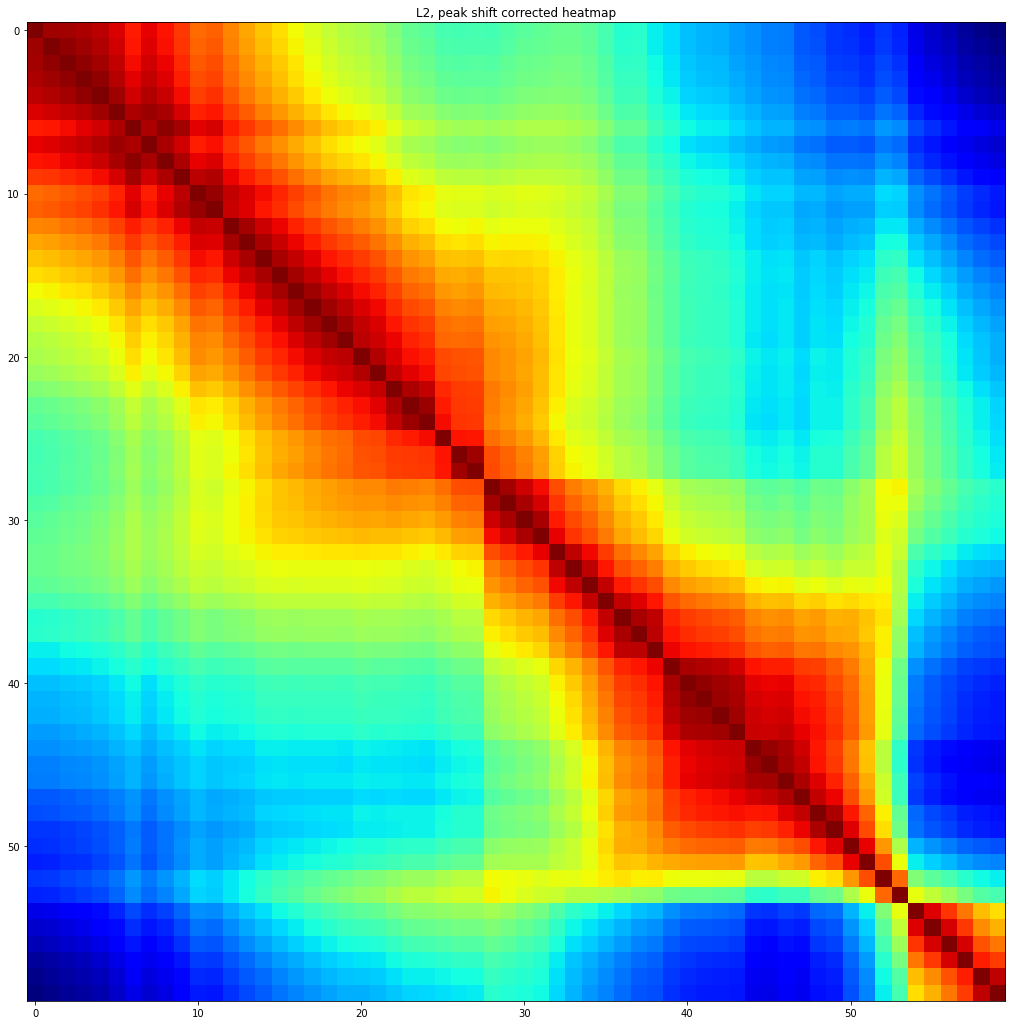

In [453]:
plt.imshow(-feat.l2_pairs(straight_feature_map), cmap = 'jet')
plt.title('L2, peak shift corrected heatmap')

In [ ]:
feat.csim_pairs

In [266]:
plt.imshow

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

Using peak fit FWHM instead of constant width:

using fitlists
Peak at 70, start iteration with error = 0.35307677296466045
Peak at 70, iteration 0: error = 0.34471987497825074
Peak at 69, start iteration with error = 0.13928933038224836
Peak at 69, iteration 0: error = 0.15089892018003775
Peak at 277, start iteration with error = 0.13077241822788968
Peak at 277, iteration 0: error = 0.1147428682989114
Peak at 277, start iteration with error = 0.22466927956503574
Peak at 277, iteration 0: error = 0.2477222202503471
Peak at 211, start iteration with error = 0.2108859353270414
Peak at 211, iteration 0: error = 0.2576948623230084
Peak at 208, start iteration with error = 0.222405073757889
Peak at 208, iteration 0: error = 0.23828123290960712
using fitlists
38
0.6743337289016471


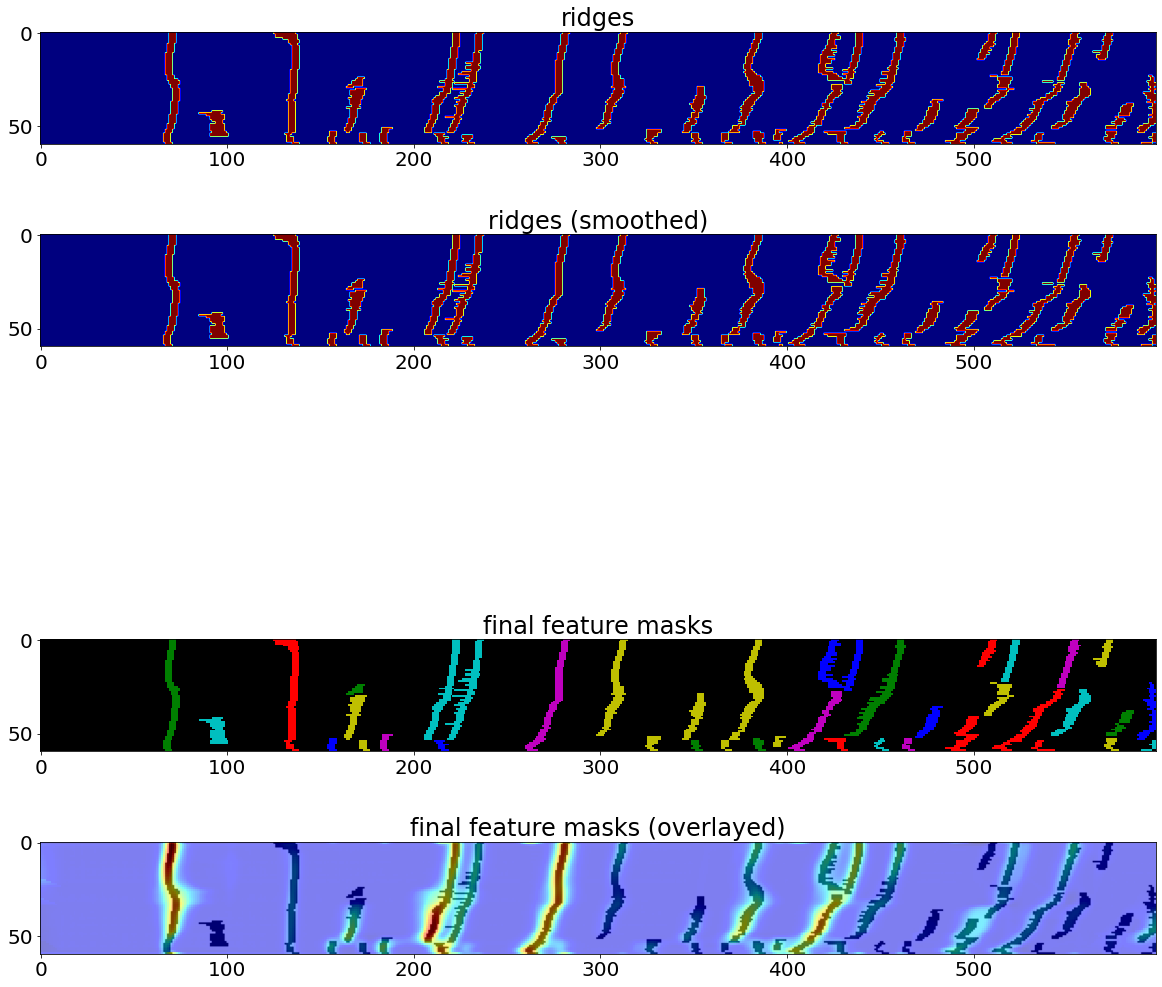

In [429]:
patterns_pp = fast_q - fast_q.min()
patterns_pp /= patterns_pp.mean()
fitlists = fsub_stop_2d[1]
labeled, feature_masks, activations, norm_, activations_n1 = peakfit_featurize(patterns_pp, fitlists)

{'linkage': 'ward', 'affinity': 'euclidean'}



    Similarity type: Cosine

    Scaling: linear
    
    Clustering type: agglom
    
    Linkage: ward
    

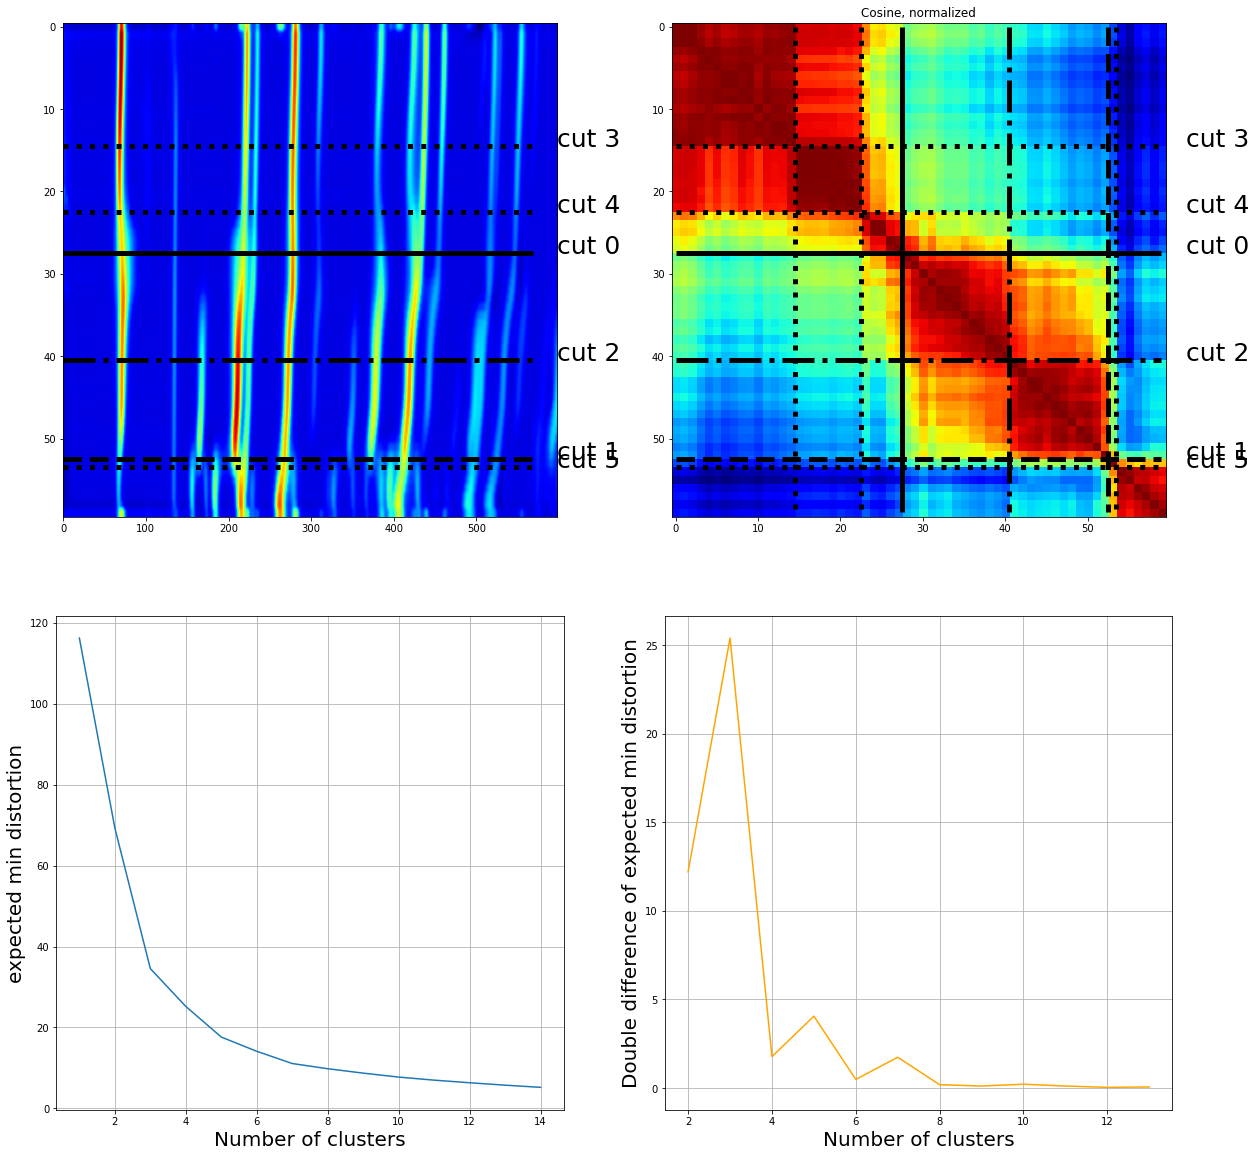

In [401]:
results = []

simtype = 'Cosine'
scaling = 'linear'
linkage = 'ward'
ctype = 'agglom'

feature_csims1, o_cuts = feat.sims_with_boundaries(patterns_pp, activations_n1, activations_n1, n = 7, simtype = simtype, extra_label='',
                    ctype = ctype, linkage = linkage, affinity = 'euclidean')
results.append({'simtype': simtype, 'scaling': scaling, 'linkage': linkage, 'ctype': ctype, 'cut_coords': o_cuts})
feat.printinfo(simtype, scaling, linkage, ctype)

In [ ]:
def place_peak

In [264]:
[len(elt) for elt in fsub_stop_2d[1]]

[2,
 3,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1]

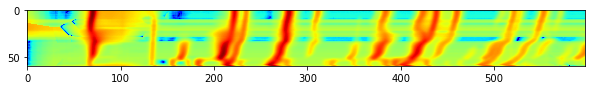

In [221]:
plt.imshow(np.log(1 + fsub_stop_2d), cmap = 'jet')

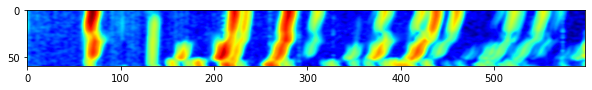

In [207]:
plt.imshow(np.log(sep.reference_bgsub(patterns) + 1), cmap = 'jet')

In [155]:
reload(sep)

<module 'xrdc.source_separation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/source_separation.py'>

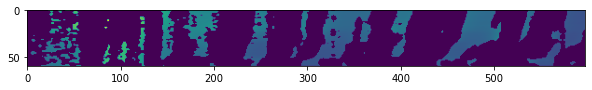

In [118]:
plt.imshow(sep.get_bgmask(patterns, 25) * patterns)

(2, 60, 598)
(2, 60, 598)


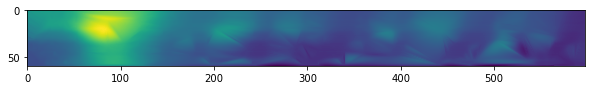

In [162]:
plt.imshow(sep.get_background(patterns, threshold = 25, smooth = 0, method = 'cloughtocher'))

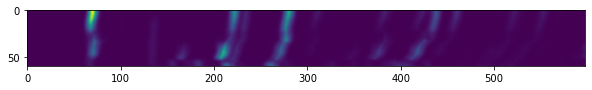

In [226]:
plt.imshow(sep.reference_bgsub(patterns))

In [231]:
reload(sep)
reload(sep.fourier)
reload(sep)

<module 'xrdc.source_separation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/source_separation.py'>

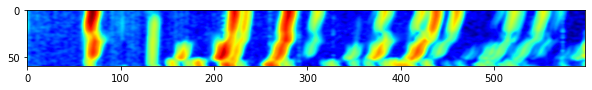

In [234]:
plt.imshow(np.log(1 + sep.reference_bgsub(patterns)), cmap = 'jet')

## 3d dataset

In [127]:
from xrdc.datasets import d3d

patterns = m3d = d3d.get_data()
arr2d = patterns[:, :, 200]

# boundaries = get_boundaries(patterns)

In [91]:
slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns, cutoff = .25,  threshold = 50, smooth_q = 1.7)

In [370]:
reload(hitp)

ModuleNotFoundError: spec not found for the module 'dataproc.operations.hitp'

> /Users/ollie/anaconda3/lib/python3.7/importlib/__init__.py(168)reload()
    166         spec = module.__spec__ = _bootstrap._find_spec(name, pkgpath, target)
    167         if spec is None:
--> 168             raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
    169         _bootstrap._exec(spec, module)
    170         # The module may have replaced itself in sys.modules!

ipdb> c


In [371]:
from dataproc.operations import hitp

In [372]:
patterns.shape

(15, 15, 800)